In [1784]:
import requests, re, sys, time, json, random, operator, itertools, pickle, csv, math 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re

import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(12,8)})

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Scrape RT Data (for Target Variable)

In [3]:
# read in RT urls
RT_urls_df = pd.read_csv('RT_urls.csv')
RT_urls_df

,RT_urls
0,/m/wuhan_wuhan
1,/m/anais_in_love
2,/m/great_freedom
3,/m/sheryl
4,/m/jane_by_charlotte
...,...
15834,/m/the_ravine_2022
15835,/m/escape_the_field
15836,/m/the_twin_2022
15837,/m/the_takedown


In [31]:
# data points to extract
urls = []
RT_titles = []
RT_years = []
RT_genres = []
RT_runtimes = []
RT_distributors = []

RT_critic_scores = []
RT_critic_cert_fresh = []
RT_critic_fresh = []
RT_critic_rev_cnts = []

RT_audience_scores = []
RT_audience_fresh = []
RT_audience_rev_cnts = []

not_found = []

# counter
cnt = 0

# scrape the data
for url in missing_RT_urls:
    
    # url = 'https://www.rottentomatoes.com' + url
    page = requests.get(url)
    
    if str(page)!='<Response [404]>':

        urls.append(url)
        
        soup = BeautifulSoup(page.text, 'lxml')
        score_board = soup.find('score-board')

        title = list(score_board.find('h1',{'slot':'title'}).stripped_strings)[0]
        RT_titles.append(title)

        critic_score = int(score_board.get('tomatometerscore'))
        RT_critic_scores.append(critic_score)

        critic_state = score_board.get('tomatometerstate')

        if critic_state=='certified-fresh':
            RT_critic_cert_fresh.append(1)
            RT_critic_fresh.append(1)
        elif critic_state=='fresh':
            RT_critic_cert_fresh.append(0)
            RT_critic_fresh.append(1)
        else:
            RT_critic_cert_fresh.append(0)
            RT_critic_fresh.append(0)

        audience_score = score_board.get('audiencescore')

        if audience_score=='':
            audience_score = np.nan
            audience_state = np.nan
        else:
            audience_score = int(audience_score)
            audience_state = score_board.get('audiencestate')

        if audience_state=='upright':
            RT_audience_fresh.append(1)
        elif audience_state=='spilled':
            RT_audience_fresh.append(0)
        else:
            RT_audience_fresh.append(np.nan)

        RT_audience_scores.append(audience_score)

        year = np.nan
        genre = np.nan
        runtime = np.nan
        
        info = score_board.find('p',{'slot':'info'})
        
        if info is not None:
            info = list(info.stripped_strings)[0]
            info = str(info).split(',')

            year = info[0].strip()
            year = int(year)

            if len(info)<=1:
                pass

            else:
                genre = info[1].strip()

                if len(info)<=2:
                    pass

                else:    
                    runtime_str = info[2].strip()

                    if 'h' in runtime_str:
                        hr = runtime_str.split('h')[0]
                        runtime = 60*int(hr)

                        if 'm' in runtime_str:
                            m = runtime_str.split('h')[1].split('m')[0].strip()
                            runtime += int(m)

                    elif 'm' in runtime_str:
                        m = runtime_str.split('m')[0].strip()
                        runtime = int(m)

        RT_years.append(year)
        RT_genres.append(genre)
        RT_runtimes.append(runtime)

        critic_rev_cnt = list(score_board.find('a',{'slot':'critics-count'}).stripped_strings)[0]
        critic_rev_cnt = int(critic_rev_cnt.split(' Reviews')[0])
        RT_critic_rev_cnts.append(critic_rev_cnt)

        audience_rev_cnt = list(score_board.find('a',{'slot':'audience-count'}).stripped_strings)[0] 

        if 'Fewer than 50' in audience_rev_cnt:
            audience_rev_cnt = 'Under 50'
        else:
            audience_rev_cnt = int(audience_rev_cnt.split(' Ratings')[0].split('+')[0].replace(",",''))

        RT_audience_rev_cnts.append(audience_rev_cnt)

        movie_info = soup.find('section',{'data-qa':'movie-info-section'})
        info_type = movie_info.find_all('li')

        distributor = np.nan
        for t in info_type:
            tag = t.find_all('div',{'data-qa':'movie-info-item-label'})
            if 'Distributor' in str(tag):
                distributor = list(t.find('div',{'class':'meta-value', 'data-qa':'movie-info-item-value'}).stripped_strings)[0]
                break

        RT_distributors.append(distributor)

        # track progress
        cnt += 1
        comp_rate = round((cnt/len(missing_RT_urls))*100,1)
        results = [title, year, genre, runtime, distributor, critic_score, critic_rev_cnt, audience_rev_cnt]
        null_results = sum(x is np.nan for x in results)
        if np.nan in results:
            print(f'{comp_rate}% done. {cnt} pages scraped. {null_results} missing item(s).')
        else:
            print(f'{comp_rate}% done. {cnt} pages scraped.')
            
    else:
        cnt += 1
        comp_rate = round((cnt/len(RT_urls_df))*100,1)
        not_found.append(url)
        print(f'{comp_rate}% done. {cnt} pages scraped. Page not found.')

11.1% done. 1 pages scraped. 1 missing item(s).
22.2% done. 2 pages scraped. 1 missing item(s).
33.3% done. 3 pages scraped. 1 missing item(s).
44.4% done. 4 pages scraped. 1 missing item(s).
55.6% done. 5 pages scraped. 1 missing item(s).
66.7% done. 6 pages scraped. 1 missing item(s).
77.8% done. 7 pages scraped. 1 missing item(s).
88.9% done. 8 pages scraped. 1 missing item(s).
100.0% done. 9 pages scraped. 1 missing item(s).


In [262]:
# df_results = pd.DataFrame(RT_titles, columns=['Title'])
# df_results['Rel_Year'] = RT_years
# df_results['Genre'] = RT_genres
# df_results['Runtime'] = RT_runtimes
# df_results['Distributor'] = RT_distributors

# df_results['Critic_score'] = RT_critic_scores
# df_results['Critic_cert_fresh'] = RT_critic_cert_fresh
# df_results['Critic_fresh'] = RT_critic_fresh
# df_results['Critic_rev_cnt'] = RT_critic_rev_cnts

# df_results['Audience_score'] = RT_audience_scores
# df_results['Audience_fresh'] = RT_audience_fresh
# df_results['Audience_rev_cnt'] = RT_audience_rev_cnts
# df_results['URL'] = urls[:-1]

In [261]:
# df_results2 = pd.DataFrame(RT_titles, columns=['Title'])
# df_results2['Rel_Year'] = RT_years
# df_results2['Genre'] = RT_genres
# df_results2['Runtime'] = RT_runtimes
# df_results2['Distributor'] = RT_distributors

# df_results2['Critic_score'] = RT_critic_scores
# df_results2['Critic_cert_fresh'] = RT_critic_cert_fresh
# df_results2['Critic_fresh'] = RT_critic_fresh
# df_results2['Critic_rev_cnt'] = RT_critic_rev_cnts

# df_results2['Audience_score'] = RT_audience_scores
# df_results2['Audience_fresh'] = RT_audience_fresh
# df_results2['Audience_rev_cnt'] = RT_audience_rev_cnts
# df_results2['URL'] = urls

In [32]:
# df_results3 = pd.DataFrame(RT_titles, columns=['Title'])
# df_results3['Rel_Year'] = RT_years
# df_results3['Genre'] = RT_genres
# df_results3['Runtime'] = RT_runtimes
# df_results3['Distributor'] = RT_distributors

# df_results3['Critic_score'] = RT_critic_scores
# df_results3['Critic_cert_fresh'] = RT_critic_cert_fresh
# df_results3['Critic_fresh'] = RT_critic_fresh
# df_results3['Critic_rev_cnt'] = RT_critic_rev_cnts

# df_results3['Audience_score'] = RT_audience_scores
# df_results3['Audience_fresh'] = RT_audience_fresh
# df_results3['Audience_rev_cnt'] = RT_audience_rev_cnts
# df_results3['URL'] = urls

In [225]:
# RT_data = pd.concat([df_results, df_results2], ignore_index=True)

In [34]:
# RT_data = pd.concat([RT_data, df_results3], ignore_index=True)

In [186]:
dupe_ind = list(RT_data[RT_data['URL'].duplicated()].index)

In [188]:
RT_data = RT_data.drop(dupe_ind)

In [189]:
# RT_data.to_csv('RT_data.csv', index=False)

In [190]:
RT_data = pd.read_csv('RT_data.csv')

In [1787]:
RT_over_20 = RT_data[RT_data['Critic_rev_cnt']>=20]
RT_subset = RT_over_20[(~RT_over_20['Genre'].str.contains('Documentary', na=False)) & \
          (~RT_over_20['Genre'].str.contains('Stand-up', na=False)) & \
                      (RT_over_20['Rel_Year']>=2017)].reset_index(drop=True)
RT_subset

,Title,Rel_Year,Genre,Runtime,Distributor,Critic_score,Critic_cert_fresh,Critic_fresh,Critic_rev_cnt,Audience_score,Audience_fresh,Audience_rev_cnt,URL
0,Anaïs in Love,2021,Comedy/Lgbtq+,98.0,Magnolia Pictures,89,1,1,44,80.0,1.0,Under 50,https://www.rottentomatoes.com/m/anais_in_love
1,Great Freedom,2021,Drama,116.0,MUBI,96,1,1,54,81.0,1.0,Under 50,https://www.rottentomatoes.com/m/great_freedom
2,All My Puny Sorrows,2021,Drama,103.0,NaN,77,0,1,35,100.0,1.0,Under 50,https://www.rottentomatoes.com/m/all_my_puny_sorrows
3,Crush,2022,Comedy/Romance,93.0,NaN,71,0,1,28,87.0,1.0,100,https://www.rottentomatoes.com/m/crush_2022
4,The Survivor,2021,Drama/Biography,129.0,NaN,85,1,1,55,74.0,1.0,Under 50,https://www.rottentomatoes.com/m/the_survivor_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,Deidra & Laney Rob a Train,2017,Drama/Crime,80.0,NaN,92,0,1,24,55.0,0.0,100,https://www.rottentomatoes.com/m/deidra_and_laney_rob_a_train
2512,I Don't Feel at Home in This World Anymore,2017,Crime/Drama,96.0,NaN,89,1,1,65,77.0,1.0,2500,https://www.rottentomatoes.com/m/i_dont_feel_at_home_in_this_world_anymore
2513,In the Shadow of the Moon,2019,Mystery & thriller,115.0,NaN,57,0,0,53,40.0,0.0,250,https://www.rottentomatoes.com/m/in_the_shadow_of_the_moon_2019
2514,Prayers for the Stolen,2021,Drama,110.0,NaN,96,1,1,52,100.0,1.0,Under 50,https://www.rottentomatoes.com/m/prayers_for_the_stolen


In [6]:
netflix_data = pd.read_pickle('master_data_v4.pkl')

In [72]:
netflix_lst = list(netflix_data[(netflix_data['RT_rev_cnt']>=20) & (netflix_data['Genre_Documentary']==0) \
            & (netflix_data['Genre_Short']==0) & (netflix_data['Rel_year']>=2017)]['Title'])

In [74]:
all_movies_lst=[]
for i in RT_subset['Title']:
    new_i = re.sub(r'[^\w\s]', '', i).lower().replace(" ","")
    for j in netflix_lst:
        new_j = re.sub(r'[^\w\s]', '', j).lower().replace(" ","")
        if i==j:
            print(i)

in_old_data=[]
not_in_old_data=[]
for t in netflix_lst:
    new_t = re.sub(r'[^\w\s]', '', t)
    if new_t.lower().replace(" ","") in all_movies_lst:
        not_in_old_data.append()

22-Jul
A Fall from Grace
Cuties (Mignonnes)
Fear Street Part 1: 1994
Fear Street Part 2: 1978
Fear Street Part 3: 1666
Ravenous
Toot-Toot Cory Carson: Chrissy Takes the Wheel
What Happened to Mr. Cha?


In [23]:
missing_netflix_movies = ['Burning Sands','Deidra & Laney Rob a Train',\
                          "I Don't Feel at Home in This World Anymore",'In the Shadow of the Moon',\
                         'Love Wedding Repeat','Prayers for the Stolen','Win It All']

missing_RT_urls = list(netflix_data[netflix_data['Title'].isin(missing_netflix_movies)]['RT_url'])

In [263]:
bad_titles = ['The Ravenous','Adam','Adam','Swan Song','Swan Song','Deidra & Laney Rob a Train','Isabella']
bad_runtimes = [103,95,98,105,112,80,80]
bad_urls = ['https://www.imdb.com/title/tt6243140/','https://www.imdb.com/title/tt6316466/',\
            'https://www.imdb.com/title/tt10199664/','https://www.imdb.com/title/tt10832274/',\
            'https://www.imdb.com/title/tt13207508/','https://www.imdb.com/title/tt4144332/',\
           'https://www.imdb.com/title/tt11638956/']

### Get IMDb URL

In [481]:
# # get IMDb urls
# imdb_url_lst = []
# flag = []
# runtime_lst = []
# year_lst = []
# cnt=0

# t_lst = list(RT_subset['Title'])
# r_lst = list(RT_subset['Runtime'])
# y_lst = list(RT_subset['Rel_Year'])

# for t,r,y in zip(t_lst, r_lst, y_lst):
    
#     imdb_url=''
#     nf=False
    
#     if t in bad_titles:

#         for i1,i2,i3 in zip(bad_titles,bad_runtimes,bad_urls):

#             if (t==i1) and (r==i2):
#                 nf=True
#                 imdb_url_lst.append(i3)

#                 cnt += 1
#                 comp_rate = round((cnt/len(list(RT_subset['Title'])))*100,1)
#                 print(f'{comp_rate}% done. {cnt} titles searched for.')

#                 break
#             else:
#                 continue
                
#     if nf==True:
#         continue
    
#     starting_page = 'https://www.imdb.com/find?q=' + t + '&ref_=nv_sr_sm'
#     page = requests.get(starting_page)
#     soup = BeautifulSoup(page.text, 'lxml')

#     main = soup.find('div',id='main')

#     results = main.find_all('tr')
    
#     if results==[]:
#         imdb_url_lst.append('DNE')
#         runtime_lst.append('DNE')
#         year_lst.append('DNE')
#         flag.append(t)
#         continue
    
#     for res in results:

#         hyperlink = res.find('a')
#         suffix = str(hyperlink.get('href'))

#         if 'title' in suffix:

#             # verify correct movie
#             results_page_url = 'https://www.imdb.com'+suffix
#             results_page = requests.get(results_page_url)
#             soup = BeautifulSoup(results_page.text, 'lxml')
            
#             # get year
#             info_bar = soup.find_all('ul',{'class':'ipc-inline-list ipc-inline-list--show-dividers sc-8c396aa2-0 kqWovI baseAlt'})

#             if (info_bar==None) or ('Episode aired' in str(info_bar)):
                
#                 if res==results[-1]:
#                     nf=True
#                     imdb_url_lst.append('DNE')
#                     runtime_lst.append('DNE')
#                     year_lst.append('DNE')
#                     flag.append(t)
#                     break
#                 else:
#                     continue
                
#             else:
#                 if 'releaseinfo' in str(info_bar):
#                     year_str = str(info_bar).split('releaseinfo')[1]
#                     year_str = year_str.split('">')[1]
#                     year_str = year_str.split('</a>')[0]
#                     year = re.sub("[^0-9]", "", year_str)
#                 else:
#                     if res==results[-1]:
#                         nf=True
#                         imdb_url_lst.append('DNE')
#                         runtime_lst.append('DNE')
#                         year_lst.append('DNE')
#                         flag.append(t)
#                         break
#                     else:
#                         continue
  
#                 if len(year)>4:
                
#                     if res==results[-1]:
#                         nf=True
#                         imdb_url_lst.append('DNE')
#                         runtime_lst.append('DNE')
#                         year_lst.append('DNE')
#                         flag.append(t)
#                         break
#                     else:
#                         continue
#                 else:
#                     year = int(year)

#                     # get runtime
#                     runtime_str = str(info_bar)

#                     if '<!-- -->h' in runtime_str:
#                         hour = runtime_str.split('<!-- -->h')[0][-3:]
#                         hour = hour.split('">')[1]
#                         hour = int(hour)
#                         minutes = hour*60
#                     else:
#                         minutes = 0
#                     if '<!-- -->m' in runtime_str:
#                         min_ = runtime_str.split('<!-- -->m')[0][-4:]
#                         min_ = min_.split('>')[1]
#                         min_ = int(min_)
#                         minutes = minutes + min_

#                     if ((year==y) & (abs(minutes-r)<=7)) or ((abs(year-y)<=1) & (minutes==r)):
#                         runtime_lst.append(minutes)
#                         year_lst.append(year)
#                         imdb_url_lst.append(results_page_url)
#                         break

#                     # if not correct movie, move on to next result
#                     else:
#                         if res==results[-1]:
#                             nf=True
#                             imdb_url_lst.append('DNE')
#                             runtime_lst.append('DNE')
#                             year_lst.append('DNE')
#                             flag.append(t)
#                             break
#                         else:
#                             continue
            
#         # if none of titles are right movie, flag movie title and move on to next title
#         else:
#             nf=True
#             imdb_url_lst.append('DNE')
#             runtime_lst.append('DNE')
#             year_lst.append('DNE')
#             flag.append(t)
#             break
            
#     # track progress
#     cnt += 1
#     comp_rate = round((cnt/len(list(RT_subset['Title'])))*100,1)
#     not_found = len(flag)
    
#     if nf==True:
#         print(f'{comp_rate}% done. {cnt} titles searched for. {not_found} titles not found ({t}).')
#     else:
#         print(f'{comp_rate}% done. {cnt} titles searched for.')

In [ ]:
imdb_urls = pd.read_csv('imdb_urls.csv')
imdb_urls = imdb_urls.drop(['Unnamed: 0'], axis=1)
imdb_urls.insert(loc=0, column='Title', value=t_lst)

In [348]:
dne_url = ['https://www.imdb.com/title/tt11286210/','https://www.imdb.com/title/tt4664346/','https://www.imdb.com/title/tt12496706/','https://www.imdb.com/title/tt11540284/','https://www.imdb.com/title/tt8386958/','https://www.imdb.com/title/tt3420504/','https://www.imdb.com/title/tt11196036/','https://www.imdb.com/title/tt13056008/','https://www.imdb.com/title/tt10521144/','https://www.imdb.com/title/tt8800266/','https://www.imdb.com/title/tt6217926/','https://www.imdb.com/title/tt10483044/','https://www.imdb.com/title/tt11525644/','https://www.imdb.com/title/tt5144174/','https://www.imdb.com/title/tt5134254/','https://www.imdb.com/title/tt11053476/','https://www.imdb.com/title/tt9690328/','https://www.imdb.com/title/tt2850272/','https://www.imdb.com/title/tt12483492/','https://www.imdb.com/title/tt10121508/','https://www.imdb.com/title/tt8399720/','https://www.imdb.com/title/tt5624466/','https://www.imdb.com/title/tt11701774/','https://www.imdb.com/title/tt5678218/','https://www.imdb.com/title/tt8333746/','https://www.imdb.com/title/tt3797512/','https://www.imdb.com/title/tt6187134/','https://www.imdb.com/title/tt7476810/','https://www.imdb.com/title/tt10656188/','https://www.imdb.com/title/tt9902160/','https://www.imdb.com/title/tt8201352/','https://www.imdb.com/title/tt10199670/','https://www.imdb.com/title/tt7969836/','https://www.imdb.com/title/tt8019486/','https://www.imdb.com/title/tt12885438/','https://www.imdb.com/title/tt9234450/','https://www.imdb.com/title/tt11874226/','https://www.imdb.com/title/tt10384744/','https://www.imdb.com/title/tt11618536/','https://www.imdb.com/title/tt9247314/','https://www.imdb.com/title/tt7435316/','https://www.imdb.com/title/tt10620868/','https://www.imdb.com/title/tt1086064/','https://www.imdb.com/title/tt8767908/','https://www.imdb.com/title/tt8254080/','https://www.imdb.com/title/tt10011336/','https://www.imdb.com/title/tt4155534/','https://www.imdb.com/title/tt8620154/','https://www.imdb.com/title/tt10373830/','https://www.imdb.com/title/tt10314450/','https://www.imdb.com/title/tt7798644/','https://www.imdb.com/title/tt6853934/','https://www.imdb.com/title/tt8963708/','https://www.imdb.com/title/tt10482504/','https://www.imdb.com/title/tt8649186/','https://www.imdb.com/title/tt8995218/','https://www.imdb.com/title/tt7736478/','https://www.imdb.com/title/tt5954556/','https://www.imdb.com/title/tt10008784/','https://www.imdb.com/title/tt6601502/','https://www.imdb.com/title/tt8058874/','https://www.imdb.com/title/tt9086228/','https://www.imdb.com/title/tt2140507/','https://www.imdb.com/title/tt7485508/','https://www.imdb.com/title/tt8096832/','https://www.imdb.com/title/tt8535968/','https://www.imdb.com/title/tt7335104/','https://www.imdb.com/title/tt9099800/','https://www.imdb.com/title/tt8902990/','https://www.imdb.com/title/tt7666250/','https://www.imdb.com/title/tt7128732/','https://www.imdb.com/title/tt8722346/','https://www.imdb.com/title/tt8378126/','https://www.imdb.com/title/tt6521876/','https://www.imdb.com/title/tt8247470/','https://www.imdb.com/title/tt9358196/','https://www.imdb.com/title/tt7549996/','https://www.imdb.com/title/tt9026524/','https://www.imdb.com/title/tt6317236/','https://www.imdb.com/title/tt10324144/','https://www.imdb.com/title/tt7342838/','https://www.imdb.com/title/tt6806448/','https://www.imdb.com/title/tt7616148/','https://www.imdb.com/title/tt5690810/','https://www.imdb.com/title/tt9412268/','https://www.imdb.com/title/tt6016744/','https://www.imdb.com/title/tt4919240/','https://www.imdb.com/title/tt7117594/','https://www.imdb.com/title/tt3385524/','https://www.imdb.com/title/tt5907748/','https://www.imdb.com/title/tt6182078/','https://www.imdb.com/title/tt8425058/','https://www.imdb.com/title/tt3319730/','https://www.imdb.com/title/tt1226837/','https://www.imdb.com/title/tt2837574/','https://www.imdb.com/title/tt1502407/','https://www.imdb.com/title/tt7461200/','https://www.imdb.com/title/tt7219324/','https://www.imdb.com/title/tt5160938/','https://www.imdb.com/title/tt8998472/','https://www.imdb.com/title/tt6892462/','https://www.imdb.com/title/tt6763252/','https://www.imdb.com/title/tt8361028/','https://www.imdb.com/title/tt6641528/','https://www.imdb.com/title/tt6504868/','https://www.imdb.com/title/tt6679794/','https://www.imdb.com/title/tt4830786/','https://www.imdb.com/title/tt5607096/','https://www.imdb.com/title/tt6509058/','https://www.imdb.com/title/tt6306064/','https://www.imdb.com/title/tt5628302/','https://www.imdb.com/title/tt2018069/','https://www.imdb.com/title/tt5814592/','https://www.imdb.com/title/tt4537986/','https://www.imdb.com/title/tt6540078/','https://www.imdb.com/title/tt2380307/','https://www.imdb.com/title/tt6150942/','https://www.imdb.com/title/tt4995790/','https://www.imdb.com/title/tt3582020/','https://www.imdb.com/title/tt5462326/','https://www.imdb.com/title/tt5816682/','https://www.imdb.com/title/tt5084170/','https://www.imdb.com/title/tt5467554/','https://www.imdb.com/title/tt4218696/','https://www.imdb.com/title/tt14550642/','https://www.imdb.com/title/tt1924245/','https://www.imdb.com/title/tt10639214/','https://www.imdb.com/title/tt7737528/','https://www.imdb.com/title/tt10926320/','https://www.imdb.com/title/tt12636872/','https://www.imdb.com/title/tt11307724/','https://www.imdb.com/title/tt8760280/','https://www.imdb.com/title/tt10719958/','https://www.imdb.com/title/tt11390036/','https://www.imdb.com/title/tt1361336/','https://www.imdb.com/title/tt12015352/','https://www.imdb.com/title/tt12676326/','https://www.imdb.com/title/tt9182964/','https://www.imdb.com/title/tt8368294/','https://www.imdb.com/title/tt10449052/','https://www.imdb.com/title/tt13567480/','https://www.imdb.com/title/tt6218010/','https://www.imdb.com/title/tt8669356/','https://www.imdb.com/title/tt12971924/','https://www.imdb.com/title/tt12587564/','https://www.imdb.com/title/tt8945942/','https://www.imdb.com/title/tt5617312/','https://www.imdb.com/title/tt5314450/','https://www.imdb.com/title/tt8750570/','https://www.imdb.com/title/tt9898858/','https://www.imdb.com/title/tt8019694/','https://www.imdb.com/title/tt5717194/','https://www.imdb.com/title/tt5706370/','https://www.imdb.com/title/tt8740778/','https://www.imdb.com/title/tt4558200/','https://www.imdb.com/title/tt4687108/','https://www.imdb.com/title/tt5834854/','https://www.imdb.com/title/tt5859882/','https://www.imdb.com/title/tt3696610/','https://www.imdb.com/title/tt7615302/','https://www.imdb.com/title/tt3861390/','https://www.imdb.com/title/tt5328006/','https://www.imdb.com/title/tt3282076/','https://www.imdb.com/title/tt7671414/','https://www.imdb.com/title/tt1935089/','https://www.imdb.com/title/tt1860242/','https://www.imdb.com/title/tt1255919/','https://www.imdb.com/title/tt6032328/','https://www.imdb.com/title/tt5303442/','https://www.imdb.com/title/tt6495094/','https://www.imdb.com/title/tt7686464/','https://www.imdb.com/title/tt5231916/','https://www.imdb.com/title/tt6371588/','https://www.imdb.com/title/tt4411234/','https://www.imdb.com/title/tt1034385/','https://www.imdb.com/title/tt2316479/','https://www.imdb.com/title/tt3739110/','https://www.imdb.com/title/tt3201640/','https://www.imdb.com/title/tt0835802/','https://www.imdb.com/title/tt2707810/','https://www.imdb.com/title/tt6247936/','https://www.imdb.com/title/tt1758810/','https://www.imdb.com/title/tt2226597/','https://www.imdb.com/title/tt1458169/','https://www.imdb.com/title/tt6131712/','https://www.imdb.com/title/tt5262792/','https://www.imdb.com/title/tt1753383/','https://www.imdb.com/title/tt5155780/']


In [356]:
new_imdb_url_lst=[]
cnt=-1
for url in list(imdb_urls['URL']):
    if url=='DNE':
        cnt+=1
        new_url=dne_url[cnt]
        new_imdb_url_lst.append(new_url)
    else:
        new_imdb_url_lst.append(url)

In [365]:
imdb_urls['IMDb_url']=new_imdb_url_lst
imdb_urls['RT_url']=list(RT_subset['URL'])
imdb_urls = imdb_urls.drop(['URL'], axis=1)

In [477]:
len(imdb_urls)
imdb_urls[:5]

2516

,Title,IMDb_url,RT_url
0,Anaïs in Love,https://www.imdb.com/title/tt13142240/,https://www.rottentomatoes.com/m/anais_in_love
1,Great Freedom,https://www.imdb.com/title/tt14775784/,https://www.rottentomatoes.com/m/great_freedom
2,All My Puny Sorrows,https://www.imdb.com/title/tt13588156/,https://www.rottentomatoes.com/m/all_my_puny_sorrows
3,Crush,https://www.imdb.com/title/tt15096128/,https://www.rottentomatoes.com/m/crush_2022
4,The Survivor,https://www.imdb.com/title/tt9242528/,https://www.rottentomatoes.com/m/the_survivor_2021


In [512]:
problem_titles = ['22 July','A Castle for Christmas',"Tyler Perry's A Fall From Grace",'Against the Ice',\
                 "All the Bright Places","Army Of The Dead","Cuties","Fear Street Part One: 1994",\
                 "Fear Street Part Two: 1978","Fear Street Part Three: 1666","Love. Wedding. Repeat",\
                 "Mank","Munich: The Edge of War","Roma","The Ravenous","Single All the Way",\
                 "The Devil All the Time","The Half of It","The Mitchells vs. the Machines",\
                 "To All the Boys: Always and Forever","To All the Boys I've Loved Before","Vampires vs. The Bronx",\
                 "Yes Day","Tick, Tick... Boom!"]

In [521]:
netflix_simp_title=[]
for j in netflix_lst:
    j_simp = re.sub(r'[^\w\s]', '', j).lower().replace(" ","")
    netflix_simp_title.append(j_simp)

netflix_flag=[]
for i in range(len(movie_urls_df)):
    t = movie_urls_df.iloc[i]['Title']
    t_simp = re.sub(r'[^\w\s]', '', t).lower().replace(" ","")
    if (t_simp in netflix_simp_title) or (t in problem_titles):
        netflix_flag.append(True)
    else:
        netflix_flag.append(False)

In [528]:
movie_urls_df['Netflix_prod']=netflix_flag

In [527]:
movie_urls_df

,Title,IMDb_url,RT_url,Netflix_prod
0,Anaïs in Love,https://www.imdb.com/title/tt13142240/,https://www.rottentomatoes.com/m/anais_in_love,True
1,Great Freedom,https://www.imdb.com/title/tt14775784/,https://www.rottentomatoes.com/m/great_freedom,True
2,All My Puny Sorrows,https://www.imdb.com/title/tt13588156/,https://www.rottentomatoes.com/m/all_my_puny_sorrows,True
3,Crush,https://www.imdb.com/title/tt15096128/,https://www.rottentomatoes.com/m/crush_2022,True
4,The Survivor,https://www.imdb.com/title/tt9242528/,https://www.rottentomatoes.com/m/the_survivor_2021,True
...,...,...,...,...
2511,Deidra & Laney Rob a Train,https://www.imdb.com/title/tt4144332/,https://www.rottentomatoes.com/m/deidra_and_laney_rob_a_train,True
2512,I Don't Feel at Home in This World Anymore,https://www.imdb.com/title/tt5710514/,https://www.rottentomatoes.com/m/i_dont_feel_at_home_in_this_world_anymore,True
2513,In the Shadow of the Moon,https://www.imdb.com/title/tt8110640/,https://www.rottentomatoes.com/m/in_the_shadow_of_the_moon_2019,True
2514,Prayers for the Stolen,https://www.imdb.com/title/tt10366574/,https://www.rottentomatoes.com/m/prayers_for_the_stolen,True


In [532]:
movie_urls_df[movie_urls_df['Title'].duplicated()]

,Title,IMDb_url,RT_url,Netflix_prod
224,Swan Song,https://www.imdb.com/title/tt10832274/,https://www.rottentomatoes.com/m/swan_song_2021,False
745,Bull,https://www.imdb.com/title/tt10008784/,https://www.rottentomatoes.com/m/bull_2020,False
1006,Adam,https://www.imdb.com/title/tt6316466/,https://www.rottentomatoes.com/m/adam_2019,False
1337,The Guilty,https://www.imdb.com/title/tt6742252/,https://www.rottentomatoes.com/m/the_guilty_2018,True
1868,Bliss,https://www.imdb.com/title/tt10333426/,https://www.rottentomatoes.com/m/bliss_2021,False
1905,Girl,https://www.imdb.com/title/tt9392374/,https://www.rottentomatoes.com/m/girl_2020,True
1943,Ava,https://www.imdb.com/title/tt8784956/,https://www.rottentomatoes.com/m/ava_2020_2,False
1991,Dreamland,https://www.imdb.com/title/tt5294522/,https://www.rottentomatoes.com/m/dreamland_2020,False
2240,Little Women,https://www.imdb.com/title/tt6495094/,https://www.rottentomatoes.com/m/little_women_2018,False
2311,Siberia,https://www.imdb.com/title/tt6494418/,https://www.rottentomatoes.com/m/siberia_2018,False


In [548]:
movie_urls_df.at[1905,'Netflix_prod']=False
movie_urls_df.at[1337,'Netflix_prod']=False

In [554]:
# movie_urls_df.to_csv('movie_urls.csv', index=False)

In [555]:
movie_urls_df = pd.read_csv('movie_urls.csv')
movie_urls_df

,Title,IMDb_url,RT_url,Netflix_prod
0,Anaïs in Love,https://www.imdb.com/title/tt13142240/,https://www.rottentomatoes.com/m/anais_in_love,False
1,Great Freedom,https://www.imdb.com/title/tt14775784/,https://www.rottentomatoes.com/m/great_freedom,False
2,All My Puny Sorrows,https://www.imdb.com/title/tt13588156/,https://www.rottentomatoes.com/m/all_my_puny_sorrows,False
3,Crush,https://www.imdb.com/title/tt15096128/,https://www.rottentomatoes.com/m/crush_2022,False
4,The Survivor,https://www.imdb.com/title/tt9242528/,https://www.rottentomatoes.com/m/the_survivor_2021,False
...,...,...,...,...
2511,Deidra & Laney Rob a Train,https://www.imdb.com/title/tt4144332/,https://www.rottentomatoes.com/m/deidra_and_laney_rob_a_train,True
2512,I Don't Feel at Home in This World Anymore,https://www.imdb.com/title/tt5710514/,https://www.rottentomatoes.com/m/i_dont_feel_at_home_in_this_world_anymore,True
2513,In the Shadow of the Moon,https://www.imdb.com/title/tt8110640/,https://www.rottentomatoes.com/m/in_the_shadow_of_the_moon_2019,True
2514,Prayers for the Stolen,https://www.imdb.com/title/tt10366574/,https://www.rottentomatoes.com/m/prayers_for_the_stolen,True


### Pull IMDb Main Data

In [567]:
movie_urls_df

,Title,IMDb_url,RT_url,Netflix_prod
0,Anaïs in Love,https://www.imdb.com/title/tt13142240/,https://www.rottentomatoes.com/m/anais_in_love,False
1,Great Freedom,https://www.imdb.com/title/tt14775784/,https://www.rottentomatoes.com/m/great_freedom,False
2,All My Puny Sorrows,https://www.imdb.com/title/tt13588156/,https://www.rottentomatoes.com/m/all_my_puny_sorrows,False
3,Crush,https://www.imdb.com/title/tt15096128/,https://www.rottentomatoes.com/m/crush_2022,False
4,The Survivor,https://www.imdb.com/title/tt9242528/,https://www.rottentomatoes.com/m/the_survivor_2021,False
...,...,...,...,...
2511,Deidra & Laney Rob a Train,https://www.imdb.com/title/tt4144332/,https://www.rottentomatoes.com/m/deidra_and_laney_rob_a_train,True
2512,I Don't Feel at Home in This World Anymore,https://www.imdb.com/title/tt5710514/,https://www.rottentomatoes.com/m/i_dont_feel_at_home_in_this_world_anymore,True
2513,In the Shadow of the Moon,https://www.imdb.com/title/tt8110640/,https://www.rottentomatoes.com/m/in_the_shadow_of_the_moon_2019,True
2514,Prayers for the Stolen,https://www.imdb.com/title/tt10366574/,https://www.rottentomatoes.com/m/prayers_for_the_stolen,True


In [587]:
non_netflix_urls = movie_urls_df[movie_urls_df['Netflix_prod']==False]
len(non_netflix_urls)

2252

In [588]:
non_netflix_urls

,Title,IMDb_url,RT_url,Netflix_prod
0,Anaïs in Love,https://www.imdb.com/title/tt13142240/,https://www.rottentomatoes.com/m/anais_in_love,False
1,Great Freedom,https://www.imdb.com/title/tt14775784/,https://www.rottentomatoes.com/m/great_freedom,False
2,All My Puny Sorrows,https://www.imdb.com/title/tt13588156/,https://www.rottentomatoes.com/m/all_my_puny_sorrows,False
3,Crush,https://www.imdb.com/title/tt15096128/,https://www.rottentomatoes.com/m/crush_2022,False
4,The Survivor,https://www.imdb.com/title/tt9242528/,https://www.rottentomatoes.com/m/the_survivor_2021,False
...,...,...,...,...
2505,Operation Mincemeat,https://www.imdb.com/title/tt1879016/,https://www.rottentomatoes.com/m/operation_mincemeat,False
2506,The Sadness,https://www.imdb.com/title/tt13872248/,https://www.rottentomatoes.com/m/the_sadness_2021,False
2507,On the Count of Three,https://www.imdb.com/title/tt11160650/,https://www.rottentomatoes.com/m/on_the_count_of_three,False
2508,The Innocents,https://www.imdb.com/title/tt4028464/,https://www.rottentomatoes.com/m/the_innocents_2022,False


In [591]:
non_netflix_urls_sub_df = non_netflix_urls.sample(n=750).reset_index(drop=True)
non_netflix_urls_sub_df

,Title,IMDb_url,RT_url,Netflix_prod
0,The Sadness,https://www.imdb.com/title/tt13872248/,https://www.rottentomatoes.com/m/the_sadness_2021,False
1,Matthias & Maxime,https://www.imdb.com/title/tt8767908/,https://www.rottentomatoes.com/m/matthias_and_maxime,False
2,Dune,https://www.imdb.com/title/tt1160419/,https://www.rottentomatoes.com/m/dune_2021,False
3,Custody,https://www.imdb.com/title/tt6002232/,https://www.rottentomatoes.com/m/custody_2018,False
4,Guest of Honour,https://www.imdb.com/title/tt9143636/,https://www.rottentomatoes.com/m/guest_of_honour,False
...,...,...,...,...
745,Survival Skills,https://www.imdb.com/title/tt8622348/,https://www.rottentomatoes.com/m/survival_skills,False
746,Death to 2020,https://www.imdb.com/title/tt13567480/,https://www.rottentomatoes.com/m/death_to_2020,False
747,The Secret Life of Pets 2,https://www.imdb.com/title/tt5113040/,https://www.rottentomatoes.com/m/the_secret_life_of_pets_2,False
748,Nine Days,https://www.imdb.com/title/tt10451852/,https://www.rottentomatoes.com/m/nine_days,False


In [592]:
months=['January','February','March','April','May','June','July','August','September','October','November','December']
mon = list(range(1,13))

In [844]:
# get IMDb data (minus cast/crew data)
cntr=0

lang_lst=[]
# year_lst = []
rel_month_lst = []
# genre_lst = []
# plot_summaries = []
# plot_keywords = []
# ratings_lst = []
# mpaa_lst_final = []
# runtime_lst = []
# dist_comp_lst = []

for url in list(non_netflix_urls_sub_df['IMDb_url']):
    
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'lxml')
    
#     # get year
#     year_bar = soup.find_all('ul',{'class':'ipc-inline-list ipc-inline-list--show-dividers sc-8c396aa2-0 kqWovI baseAlt'})
#     year_str = str(year_bar).split('releaseinfo')[1]
#     year_str = year_str.split('">')[1]
#     year_str = year_str.split('</a>')[0]
#     year = re.sub("[^0-9]", "", year_str)
#     year = int(year)
#     year_lst.append(year)
    
    
    month='DNE'
    lang='DNE'
    
    # get language
    program_details = soup.find_all('a',{'class':'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'})
    for row in program_details:
        row = str(row)
        if 'primary_language' in row:
            lang_str = row.split('primary_language')[1]
            lang_str = lang_str.split('rel="">')[1]
            lang = lang_str.split('</a>')[0]
            lang_lst.append(lang)
            break
    # get release info (month)
        elif 'releaseinfo' in row:
            rel_info = row.split('releaseinfo')[1]
            for m in months:
                if m in str(rel_info):
                    month = mon[months.index(m)]
                    rel_month_lst.append(month)
    
    if month=='DNE':
        rel_month_lst.append(month)
        
    if lang=='DNE':
        lang_lst.append(lang)
      
#     rating='Not Rated'
#     genres=[]

#     # get Genres
#     plot_details = soup.find_all('ul',{'class':'ipc-metadata-list ipc-metadata-list--dividers-all sc-388740f9-1 IjgYL ipc-metadata-list--base'})
#     for row in plot_details:
#         row2 = row.find_all('li',{'class':'ipc-metadata-list__item'})
#         row_str = str(row2)

#         for s in re.finditer('genres=', row_str):
#             genre = row_str[s.start()+7:s.end()+30]
#             genre = genre.split('&amp')[0]
#             genres.append(genre)
#         genre_lst.append(genres)

#         # get Rating
#         if 'Rated ' in row_str:
#             s = row_str.find('Rated ')
#             rating = row_str[s+6:s+15]
#             rating = rating.split(' for')[0]
#         if '">TV-' in row_str:
#             s = row_str.find('">TV-')
#             rating = row_str[s+2:s+10]
#             rating = rating.split('</')[0]
#     ratings_lst.append(rating)

#     # get runtime
#     runtime_str = soup.find('li',{'data-testid':'title-techspec_runtime'})
#     runtime_str = runtime_str.find('div',{'class':'ipc-metadata-list-item__content-container'})
#     if 'hour' in runtime_str:
#         hour = str(runtime_str).split('<!-- --> <!-- -->hour')[0]
#         hour = hour.split('container">')[1]
#         hour = int(hour)
#         minutes = hour*60
#     elif 'hours' in runtime_str:
#         hour = str(runtime_str).split('<!-- --> <!-- -->hours')[0]
#         hour = hour.split('container">')[1]
#         hour = int(hour)
#         minutes = hour*60
#     else:
#         minutes = 0
#     if 'minutes' in runtime_str:
#         min_ = str(runtime_str).split('<!-- --> <!-- -->minutes')[0][-4:]
#         min_ = min_.split('>')[1]
#         min_ = int(min_)
        
#         minutes = minutes + min_
#         runtime_lst.append(minutes)
#     elif 'minute' in runtime_str:
#         min_ = str(runtime_str).split('<!-- --> <!-- -->minute')[0][-4:]
#         min_ = min_.split('>')[1]
#         min_ = int(min_)
        
#         minutes = minutes + min_
#         runtime_lst.append(minutes)
#     else:
#         runtime_lst.append(minutes)
    
#     # get plot info
#     plot_info = soup.find('div',{'class':'sc-10602b09-2 jzJCdt'})
#     if 'sc-16ede01-2 gXUyNh' in str(plot_info):
#         plot_summary = plot_info.find('span',{'class':'sc-16ede01-2 gXUyNh'})
#         plot_summary = str(plot_summary).split('"presentation">')[1]
#         plot_summary = plot_summary.split('</span>')[0]
#         plot_summaries.append(plot_summary)
#     else:
#         plot_summaries.append('DNE')
    
#     # get rating reason
    
#     page = requests.get(url + 'parentalguide?ref_=tt_stry_pg')
#     soup = BeautifulSoup(page.text, 'lxml')

#     certificate = soup.find('section',{'id':'certificates'})
    
#     mpaa_lst = []
#     mpaa = False
#     for row in certificate:
#         if 'MPAA' in str(row):
#             mpaa = str(row).split('<td>')[1]
#             mpaa = mpaa.split('</td>')[0]
#             reason = mpaa.split('for ')[1]
#             reason = re.split(', ', reason)
#             for r in reason:
#                 r1 = re.split('and ', r)
#                 for r2 in r1:
#                     if r2=='':
#                         continue
#                     else:
#                         r2 = r2.strip()
#                         r2 = r2.replace('.','')
#                         mpaa_lst.append(r2)
#                         mpaa=True

#     if mpaa==False:
#         mpaa_lst.append('No MPAA rating')

#     mpaa_lst_final.append(mpaa_lst)

#     # get plot keywords
#     page = requests.get(url + 'keywords?ref_=tt_stry_kw')
#     soup = BeautifulSoup(page.text, 'lxml')
#     plot_section = soup.find('div',{'id':'keywords_content'})
    
#     keyword_lst = []
#     if plot_section.find('div',{'id':'no_content'})!=None:
#         keyword_lst.append('DNE')
#     else:
#         table = plot_section.find('table')
#         table_row = table.find_all('tr')

#         for row in table_row:
#             keywords = row.find_all('td',{'class':'soda sodavote'})
#             for k in keywords:
#                 keyword = k.get('data-item-keyword')
#                 keyword_lst.append(keyword)
    
#     plot_keywords.append(keyword_lst)
    
#     # get distributor
#     page = requests.get(url + 'companycredits?ref_=tt_dt_co')
#     soup = BeautifulSoup(page.text, 'lxml')
    
#     comp_credits = soup.find_all('div',{'id':'company_credits_content'})
#     dist_comp='DNE'
    
#     for row in comp_credits:
#         comp = row.find_all('li')
#         comp = str(comp)
#         if ('(USA) (theatrical)' in comp):
#             comp = comp.split('(USA) (theatrical)')[0]
#             comp = comp.rpartition('</a>')[0]
#             dist_comp = comp.rpartition('">')[2]
#             dist_comp_lst.append(dist_comp)
#             break
#         elif ('(World-wide) (theatrical)' in comp):
#             comp = comp.split('(World-wide) (theatrical)')[0]
#             comp = comp.rpartition('</a>')[0]
#             dist_comp = comp.rpartition('">')[2]
#             dist_comp_lst.append(dist_comp)
#             break
#         elif ('(USA) (video)' in comp):
#             comp = comp.split('(USA) (video)')[0]
#             comp = comp.rpartition('</a>')[0]
#             dist_comp = comp.rpartition('">')[2]
#             dist_comp_lst.append(dist_comp)
#             break
#         elif ('(World-wide) (video)' in comp):
#             comp = comp.split('(World-wide) (video)')[0]
#             comp = comp.rpartition('</a>')[0]
#             dist_comp = comp.rpartition('">')[2]
#             dist_comp_lst.append(dist_comp)
#             break
#         elif ('(USA) (TV)' in comp):
#             comp = comp.split('(USA) (TV)')[0]
#             comp = comp.rpartition('</a>')[0]
#             dist_comp = comp.rpartition('">')[2]
#             dist_comp_lst.append(dist_comp)
#             break
#         elif ('(USA) (all media)' in comp):
#             comp = comp.split('(USA) (all media)')[0]
#             comp = comp.rpartition('</a>')[0]
#             dist_comp = comp.rpartition('">')[2]
#             dist_comp_lst.append(dist_comp)
#             break
#         elif ('(World-wide) (all media)' in comp):
#             comp = comp.split('(World-wide) (all media)')[0]
#             comp = comp.rpartition('</a>')[0]
#             dist_comp = comp.rpartition('">')[2]
#             dist_comp_lst.append(dist_comp)
#             break

#     if dist_comp=='DNE':
#         dist_comp_lst.append(dist_comp)

    cntr+=1
    if (lang=='DNE') or (year=='') or (month=='DNE') or (genres==[]) or \
    (plot_summary=='DNE') or (keyword_lst==[]) or (r2=='') or (minutes=='DNE') or (dist_comp=='DNE'):
        print(f'Row {cntr} completed. {round(((cntr/750)*100),0)}% done. Possible missing info.')
    else:
        print(f'Row {cntr} completed. {round(((cntr/750)*100),0)}% done.')


Row 1 completed. 0.0% done.
Row 2 completed. 0.0% done.
Row 3 completed. 0.0% done.
Row 4 completed. 1.0% done.
Row 5 completed. 1.0% done.
Row 6 completed. 1.0% done.
Row 7 completed. 1.0% done.
Row 8 completed. 1.0% done.
Row 9 completed. 1.0% done.
Row 10 completed. 1.0% done.
Row 11 completed. 1.0% done.
Row 12 completed. 2.0% done.
Row 13 completed. 2.0% done.
Row 14 completed. 2.0% done.
Row 15 completed. 2.0% done.
Row 16 completed. 2.0% done.
Row 17 completed. 2.0% done.
Row 18 completed. 2.0% done.
Row 19 completed. 3.0% done.
Row 20 completed. 3.0% done.
Row 21 completed. 3.0% done.
Row 22 completed. 3.0% done.
Row 23 completed. 3.0% done.
Row 24 completed. 3.0% done.
Row 25 completed. 3.0% done.
Row 26 completed. 3.0% done.
Row 27 completed. 4.0% done.
Row 28 completed. 4.0% done.
Row 29 completed. 4.0% done.
Row 30 completed. 4.0% done.
Row 31 completed. 4.0% done.
Row 32 completed. 4.0% done.
Row 33 completed. 4.0% done.
Row 34 completed. 5.0% done.
Row 35 completed. 5.0% 

Row 269 completed. 36.0% done.
Row 270 completed. 36.0% done.
Row 271 completed. 36.0% done.
Row 272 completed. 36.0% done.
Row 273 completed. 36.0% done.
Row 274 completed. 37.0% done.
Row 275 completed. 37.0% done.
Row 276 completed. 37.0% done.
Row 277 completed. 37.0% done.
Row 278 completed. 37.0% done.
Row 279 completed. 37.0% done.
Row 280 completed. 37.0% done.
Row 281 completed. 37.0% done.
Row 282 completed. 38.0% done.
Row 283 completed. 38.0% done.
Row 284 completed. 38.0% done.
Row 285 completed. 38.0% done.
Row 286 completed. 38.0% done.
Row 287 completed. 38.0% done.
Row 288 completed. 38.0% done.
Row 289 completed. 39.0% done.
Row 290 completed. 39.0% done.
Row 291 completed. 39.0% done.
Row 292 completed. 39.0% done.
Row 293 completed. 39.0% done.
Row 294 completed. 39.0% done.
Row 295 completed. 39.0% done.
Row 296 completed. 39.0% done.
Row 297 completed. 40.0% done.
Row 298 completed. 40.0% done.
Row 299 completed. 40.0% done.
Row 300 completed. 40.0% done.
Row 301 

Row 533 completed. 71.0% done.
Row 534 completed. 71.0% done.
Row 535 completed. 71.0% done.
Row 536 completed. 71.0% done.
Row 537 completed. 72.0% done.
Row 538 completed. 72.0% done.
Row 539 completed. 72.0% done.
Row 540 completed. 72.0% done.
Row 541 completed. 72.0% done.
Row 542 completed. 72.0% done.
Row 543 completed. 72.0% done.
Row 544 completed. 73.0% done.
Row 545 completed. 73.0% done.
Row 546 completed. 73.0% done.
Row 547 completed. 73.0% done.
Row 548 completed. 73.0% done.
Row 549 completed. 73.0% done.
Row 550 completed. 73.0% done.
Row 551 completed. 73.0% done.
Row 552 completed. 74.0% done.
Row 553 completed. 74.0% done.
Row 554 completed. 74.0% done.
Row 555 completed. 74.0% done.
Row 556 completed. 74.0% done.
Row 557 completed. 74.0% done.
Row 558 completed. 74.0% done.
Row 559 completed. 75.0% done.
Row 560 completed. 75.0% done.
Row 561 completed. 75.0% done.
Row 562 completed. 75.0% done.
Row 563 completed. 75.0% done.
Row 564 completed. 75.0% done.
Row 565 

In [896]:
main_data_df = pd.DataFrame(list(non_netflix_urls_sub_df['Title']), columns=['Title']) #
main_data_df['Lang']=lang_lst # 746
main_data_df['Rel_year']=year_lst
main_data_df['Rel_month']=rel_month_lst # 749
main_data_df['Distributor']=dist_comp_lst
main_data_df['Genre']=genre_lst 
main_data_df['Plot_summ']=plot_summaries
main_data_df['Plot_keywords']=plot_keywords
main_data_df['Rating']=ratings_lst 
main_data_df['Rating_reason']=mpaa_lst_final
main_data_df['Runtime']=runtime_lst
main_data_df['RT_url']=list(non_netflix_urls_sub_df['RT_url'])
main_data_df['IMDb_url']=list(non_netflix_urls_sub_df['IMDb_url'])

In [1109]:
import numpy as np
missing_lang = ['English','English','English','English']
missing_mo = [1]
missing_dist = ['Universal Pictures International (UPI)','Bac Films',np.nan,'Scanbox Entertainment',\
               'Filmax','Curzon Artificial Eye','Sparky Pictures','Sparky Pictures','Game Theory Films',\
               'Golden Mouse Productions','Vertical Entertainment','Label Entertainment','Zee Studios',\
               'Le Pacte','Front Row Filmed Entertainment','Magnolia Pictures','Madman Films','Disney+',\
               'Saban Films','Signature Entertainment','AA Films','Sabay MVP','Altitude Film Entertainment',\
               'Tokyo Theatres K.K.','Shudder','Cherry Pickers Filmdistributie','Picturehouse Entertainment',\
               'R&R Films',np.nan,'Next Entertainment World','Great Point Media','Vertigo Films','Magolia Pictures',\
               'Platoon One Films']

In [1110]:
main_data_df2 = main_data_df.copy()

cnt_i=-1
cnt_j=-1
cnt_k=-1
l_lst=[]
m_lst=[]
d_lst=[]

for i in range(750):
    l = main_data_df.iloc[i]['Lang']
    m = main_data_df.iloc[i]['Rel_month']
    d = main_data_df.iloc[i]['Distributor']
    if l=='DNE':
        cnt_i+=1
        l_lst.append(missing_lang[cnt_i])
    else:
        l_lst.append(l)
    if m=='DNE':
        cnt_j+=1
        m_lst.append(missing_mo[cnt_j])
    else:
        m_lst.append(m)
    if d=='DNE':
        cnt_k+=1
        d_lst.append(missing_dist[cnt_k])
    else:
        d_lst.append(d)

In [1111]:
main_data_df2['Lang']=l_lst
main_data_df2['Rel_month']=m_lst
main_data_df2['Distributor']=d_lst
main_data_df2

,Title,Lang,Rel_year,Rel_month,Distributor,Genre,Plot_summ,Plot_keywords,Rating,Rating_reason,Runtime,RT_url,IMDb_url
0,The Sadness,Mandarin,2021,5,Shudder,[Horror],"A young couple trying to reunite amid a city ravaged by a plague that turns its victims into deranged, bloodthirsty sadists.","[plague, pandemic, virus, mutating virus, attack, blood, blood spatter, blood splatter, motorcycle, cell phone, subway, subway train, subway car, stabbed in the eye, severed finger, hospital, borrowing a cell phone to make a call, couple, written by director]",Not Rated,[No MPAA rating],99,https://www.rottentomatoes.com/m/the_sadness_2021,https://www.imdb.com/title/tt13872248/
1,Matthias & Maxime,French,2019,8,Mubi,"[Drama, Romance]",Hidden feelings come to light and threaten the bond of a group of friends in their late 20s.,"[gay character, friendship, kiss, in love with best friend, mother son relationship, closeted homosexual, montreal quebec canada, film student, recovering drug addict, farewell party, swimming in a lake, cigarette smoking, party game, strip club, fight, gay, franglais, year 2019, actor director, written by director, actor director writer, character name in title, bartender, lawyer, smoking marijuana, punching a mirror, reference to melbourne australia, reference to denys arcand, reference to pedro almodovar, reference to omar sharif, reference to alain delon, reference to peter sellers, reference to jesse owens, 2010s, actor director producer writer, port wine stain on face]",Not Rated,[No MPAA rating],119,https://www.rottentomatoes.com/m/matthias_and_maxime,https://www.imdb.com/title/tt8767908/
2,Dune,English,2021,10,Warner Bros.,"[Action, Adventure, Drama, Sci-Fi]",A noble family becomes embroiled in a war for control over the galaxy's most valuable asset while its heir becomes troubled by visions of a dark future.,"[mother son relationship, mind control, prescience, future, empire, sandworm, doctor, combat, dead body, massacre, spy, premonition, desert, sand, chosen one, male nudity, based on novel, adaptation, duke, nobility, desert planet, science fantasy, destiny, giant creature, giant worm, title same as book, set up for a sequel, father son relationship, distant future, emperor, politics, space travel, fictional drug, dream, training, laser cutter, garden, tent, leadership, twin moon, binoculars, beach, scroll, priestess, subtitled scene, bilingualism, sign language, stabbed in the chest, stabbed in the shoulder, epic battle, compass, gadget, traitor, coming of age, dagger, disarming someone, conspiracy, body armor, loss of father, heavy rain, battle, battlefield, corpse, ensemble cast, test, teenage boy, gas mask, bound and gagged, blue eyes, bagpipes, palm tree, fire, gardener, aerial camera shot, exploration, alien, pregnancy, muscleman, voice over narration, color blind casting, interracial couple, high tech suit, fictional language, refinery, walled city, reverend mother, poison gas, coup d'etat, child prodigy, tunnel, space pod, faith, temple, blood on shirt, culture clash, projector, glow stick, death of father, dune, space opera, ...]",PG-13,"[sequences of strong violence, some disturbing images, suggestive material]",155,https://www.rottentomatoes.com/m/dune_2021,https://www.imdb.com/title/tt1160419/
3,Custody,French,2017,2,Kino Lorber,"[Drama, Thriller]",A broken marriage leads to a bitter custody battle with an embattled son at the centre.,"[divorce, lie, child custody, violent father, judge, lawyer, birthday party, france, divorced parents, jealous rage, fear, anger, jealousy, couple, husband wife relationship, custody battle, apartment, boy, cigarette smoking, kiss, bus, toilet, mother son relationship, singing, neighbor, rifle, police, bathtub, police arrest, no music score, written by director, cell phone, divorce proceedings, violent man, insane with jealousy, pathological jealousy, father son estrangement, father daughter estrangement, pregnancy test, veiled threat, crying man, shotgun, shooti

### Get Cast/Crew Filmographies

In [899]:
def get_crew(string, start, stop):
    crew_str = str(string).split(start)[1]
    crew_str = crew_str.split(stop)[0]
    crew_str.find('<a href="')
    
    names=[]
    links=[]

    for s in re.finditer('<a href="', crew_str):
        crew_link_0 = crew_str[s.end():s.end()+50]
        crew_link = crew_link_0.split('"> ')[0]
        links.append(crew_link)
        crew_name = crew_link_0.split('"> ')[1]
        crew_name = crew_name.split('\n')[0]
        names.append(crew_name)
        
    names = list(dict.fromkeys(names))
    links = list(dict.fromkeys(links))
    
    return names, links

def get_yr(string):

    if ('in_production' not in str(string).lower()) and ('announced' not in str(string).lower()) and ('music video' not in str(string).lower()) and ('post-production' not in str(string).lower()) and ('pre-production' not in str(string).lower()):
        if '(' in str(string):
            paren = str(string).split('(')[1]
            paren = paren.split(')')[0]

            if not(any(item in paren.lower() for item in non_film_str)):
                yr = str(string).split('"year_column">\n\xa0')[1]
                yr = yr.split('\n')[0]
                return yr
            else:
                yr = ''
                return yr
        else:

            yr = str(string).split('"year_column">\n\xa0')[1]
            yr = yr.split('\n')[0]
            return yr
    else:
        yr = ''
        return yr

def get_title(string):

    if ('in_production' not in str(string).lower()) and ('announced' not in str(string).lower()) and ('music video' not in str(string).lower()) and ('post-production' not in str(string).lower()) and ('pre-production' not in str(string).lower()):
        if '(' in str(string):
            paren = str(string).split('(')[1]
            paren = paren.split(')')[0]

            if not(any(item in paren.lower() for item in non_film_str)):
                title = str(string.find('a')).split('/">')[1]
                title = title.split('</a>')[0]
                return title
            else:
                title = ''
                return title

        else:
            title = str(string.find('a')).split('/">')[1]
            title = title.split('</a>')[0]
            return title
    else:
        title = ''
        return title

In [900]:
non_film_str = ['short','music video','segment','tv','video','in_production','announced','podcast',\
                'post-production','pre-production']

In [949]:
cntr = 0

dir_names_lst = []
wrtr_names_lst = []
actr_names_lst = []

dir_projs_lst_final = []
wrtr_projs_lst_final = []
actr_projs_lst_final = []

year_lst_ = list(main_data_df['Rel_year'])[614:]
url_lst_ = list(main_data_df['IMDb_url'])[614:]

for link,year in zip(url_lst_, year_lst_):

    page = requests.get(link) # + 'fullcredits?ref_=tt_ov_st_sm'
    soup = BeautifulSoup(page.text, 'lxml')
    
    dir_names=[]
    dir_links=[]

    wrtr_names=[]
    wrtr_links=[]

    top_bar = soup.find_all('li',{'data-testid':'title-pc-principal-credit'})
    for row in top_bar:
        if 'Director' in str(row):
            for s in re.finditer('rel="">', str(row)):
                name = str(row)[s.start()+7:s.end()+30]
                name = name.split('</a>')[0]
                dir_names.append(name)

            for s in re.finditer('href="', str(row)):
                link = str(row)[s.start()+6:s.end()+30]
                link = link.split('?ref_')[0]
                if 'name' in link:
                    dir_links.append(link)
                else:
                    continue
            break
            
    dir_names_lst.append(dir_names)

    for row in top_bar:
        if 'Writer' in str(row):
            for s in re.finditer('rel="">', str(row)):
                name = str(row)[s.start()+7:s.end()+30]
                name = name.split('</a>')[0]
                wrtr_names.append(name)

            for s in re.finditer('href="', str(row)):
                link = str(row)[s.start()+6:s.end()+30]
                link = link.split('?ref_')[0]
                if 'name' in link:
                    wrtr_links.append(link)
                else:
                    continue
            break
        else:
            continue
    
    wrtr_names_lst.append(wrtr_names)
    
    
    # get actors
    actr_names = []
    actor_links = []

    cast = soup.find_all('a',{'data-testid':'title-cast-item__actor'})
    cnt = 0
    for row in cast:
        actor_name = re.search('>(.*)<', str(row)).group(1)
        actr_names.append(actor_name)
        
        actor_link = str(row).split('href="/')[1]
        actor_link = actor_link.split('?ref_')[0]
        actor_links.append(actor_link)
  
        cnt+=1
        if cnt==5:
            break # stop loop after scraping top 5 actors
    
    actr_names_lst.append(actr_names)

    
    
    dir_projs_lst = []
    
    # get director(s) filmography
    for link2 in dir_links:
        page = requests.get('https://www.imdb.com/' + link2)
        soup = BeautifulSoup(page.text, 'lxml')
        filmography = soup.find('div',{'id':'filmography'})
        films = filmography.find_all('div',{'class':"filmo-row"})
        
        dir_projs = []
        dir_proj_yrs = []
        
        for f in films:
            f_str = str(f)
            
            if 'id="director' in f_str:
                
                # get project year
                yr = get_yr(f_str) 
                if yr=='':
                    continue
                else:
                    yr = re.sub("[^0-9]", "", yr)
                    yr = int(yr)
                    if (yr>=year) or ((year-20)>yr): # only pull films made w/in 20 years of current film
                        continue
                    else:
                        dir_proj_yrs.append(yr)
                
                # get project title
                title = get_title(f)
                if title=='':
                    continue
                else:
                    title = title.replace('&amp;','&')
                    dir_projs.append(title)
                    
        dir_projs_dict = dict(zip(dir_projs, dir_proj_yrs))        
        dir_projs_lst.append(dir_projs_dict)    
    dir_projs_lst_final.append(dir_projs_lst)
    
    
    wrtr_projs_lst = []
    
    # get writer(s) filmography
    for link2 in wrtr_links:
        page = requests.get('https://www.imdb.com/' + link2)
        soup = BeautifulSoup(page.text, 'lxml')
        filmography = soup.find('div',{'id':'filmography'})
        films = filmography.find_all('div',{'class':"filmo-row"})
        
        wrtr_projs = []
        wrtr_proj_yrs = []
        
        for f in films:
            f_str = str(f)
            
            if 'id="writer' in f_str:
                
                # get project year
                yr = get_yr(f_str) 
                if yr=='':
                    continue
                else:
                    yr = re.sub("[^0-9]", "", yr)
                    yr = int(yr)
                    if (yr>=year) or ((year-20)>yr): # only pull films made w/in 20 years of current film
                        continue
                    else:
                        wrtr_proj_yrs.append(yr)
                
                # get project title
                title = get_title(f)
                if title=='':
                    continue
                else:
                    title = title.replace('&amp;','&')
                    wrtr_projs.append(title)
                    
        wrtr_projs_dict = dict(zip(wrtr_projs, wrtr_proj_yrs))                
        wrtr_projs_lst.append(wrtr_projs_dict)    
    wrtr_projs_lst_final.append(wrtr_projs_lst)
            
    
    actr_projs_lst = []
    
    # get actor(s) filmography
    for link2,actor2 in zip(actor_links,actr_names):
        page = requests.get('https://www.imdb.com/' + link2)
        soup = BeautifulSoup(page.text, 'lxml')
        filmography = soup.find('div',{'id':'filmography'})
        films = filmography.find_all('div',{'class':"filmo-row"})
        
        actr_projs = []
        actr_proj_yrs = []
        rank_lst = []
        
        for f in films:
            f_str = str(f)

            if ('id="actor' in f_str) or ('id="actress' in f_str):

                # get project year
                yr = get_yr(f_str) 
                if yr=='':
                    continue
                else:
                    yr = re.sub("[^0-9]", "", yr)
                    yr = int(yr)
                    if (yr>=year) or ((year-10)>yr): # only pull films made w/in 10 years of current film
                        continue
                    else:
                        actr_proj_yrs.append(yr)

                # get project title
                title = get_title(f)

                if title=='':
                    continue
                else:
                    title = title.replace('&amp;','&')
                    actr_projs.append(title)
                    rank_lst.append(1) 

#                     title_URL = f.find('a').get('href') # get project URL

#                     page = requests.get('https://www.imdb.com/' + title_URL)
#                     soup = BeautifulSoup(page.text, 'lxml')

#                     actr_names2 = []
                    
#                     cast = soup.find_all('a',{'data-testid':'title-cast-item__actor'})
#                     for cast_row in cast:
#                         name = re.search('>(.*)<', str(cast_row)).group(1)
#                         actr_names2.append(name)
                    
#                     if actor2 in actr_names2:
#                         rank = actr_names2.index(actor2)+1
#                         rank_lst.append(rank) 
#                     else:
#                         rank = np.nan
#                         rank_lst.append(rank)    
        
        actr_projs_dict = {}
        for proj,proj_ind in zip(actr_projs,range(len(actr_projs))):
            actr_projs_dict[proj] = [actr_proj_yrs[proj_ind], rank_lst[proj_ind]]         
        actr_projs_lst.append(actr_projs_dict)   
    actr_projs_lst_final.append(actr_projs_lst)
    
    cntr+=1
    if ((dir_names_lst=='') and (wrtr_names_lst=='')) or (actr_names_lst==''):
        print(f'Row {cntr} completed. {round(((cntr/750)*100),0)}% done. Possible missing info.')
    else:
        print(f'Row {cntr} completed. {round(((cntr/750)*100),0)}% done.')

Row 1 completed. 0.0% done.
Row 2 completed. 0.0% done.
Row 3 completed. 0.0% done.
Row 4 completed. 1.0% done.
Row 5 completed. 1.0% done.
Row 6 completed. 1.0% done.
Row 7 completed. 1.0% done.
Row 8 completed. 1.0% done.
Row 9 completed. 1.0% done.
Row 10 completed. 1.0% done.
Row 11 completed. 1.0% done.
Row 12 completed. 2.0% done.
Row 13 completed. 2.0% done.
Row 14 completed. 2.0% done.
Row 15 completed. 2.0% done.
Row 16 completed. 2.0% done.
Row 17 completed. 2.0% done.
Row 18 completed. 2.0% done.
Row 19 completed. 3.0% done.
Row 20 completed. 3.0% done.
Row 21 completed. 3.0% done.
Row 22 completed. 3.0% done.
Row 23 completed. 3.0% done.
Row 24 completed. 3.0% done.
Row 25 completed. 3.0% done.
Row 26 completed. 3.0% done.
Row 27 completed. 4.0% done.
Row 28 completed. 4.0% done.
Row 29 completed. 4.0% done.
Row 30 completed. 4.0% done.
Row 31 completed. 4.0% done.
Row 32 completed. 4.0% done.
Row 33 completed. 4.0% done.
Row 34 completed. 5.0% done.
Row 35 completed. 5.0% 

In [938]:
# filmographies_df_1 = pd.DataFrame(list(main_data_df['Title'])[:405], columns=['Title'])
# filmographies_df_1['Dir_names']=dir_names_lst[:-1]
# filmographies_df_1['Dir_projs']=dir_projs_lst_final[:-1]
# filmographies_df_1['Wrtr_names']=wrtr_names_lst[:-1]
# filmographies_df_1['Writer_projs']=wrtr_projs_lst_final[:-1]
# filmographies_df_1['Actr_names']=actr_names_lst[:-1]
# filmographies_df_1['Actor_projs']=actr_projs_lst_final

In [942]:
# filmographies_df_2 = pd.DataFrame(list(main_data_df['Title'])[405:614], columns=['Title'])
# filmographies_df_2['Dir_names']=dir_names_lst[:-1]
# filmographies_df_2['Dir_projs']=dir_projs_lst_final[:-1]
# filmographies_df_2['Wrtr_names']=wrtr_names_lst[:-1]
# filmographies_df_2['Writer_projs']=wrtr_projs_lst_final
# filmographies_df_2['Actr_names']=actr_names_lst[:-1]
# filmographies_df_2['Actor_projs']=actr_projs_lst_final

In [950]:
# filmographies_df_3 = pd.DataFrame(list(main_data_df['Title'])[614:], columns=['Title'])
# filmographies_df_3['Dir_names']=dir_names_lst
# filmographies_df_3['Dir_projs']=dir_projs_lst_final
# filmographies_df_3['Wrtr_names']=wrtr_names_lst
# filmographies_df_3['Writer_projs']=wrtr_projs_lst_final
# filmographies_df_3['Actr_names']=actr_names_lst
# filmographies_df_3['Actor_projs']=actr_projs_lst_final

In [992]:
filmographies_df = pd.concat([filmographies_df_1, filmographies_df_2, filmographies_df_3])

In [983]:
# filmographies_df.to_csv('filmographies.csv', index=False)

In [984]:
filmographies_df = pd.read_csv('filmographies.csv')

In [988]:
filmographies_df.columns

Index(['Title', 'Dir_names', 'Dir_projs', 'Wrtr_names', 'Writer_projs',
       'Actr_names', 'Actor_projs'],
      dtype='object')

In [1006]:
movies_lst = []
yrs_lst = []
actrs_lst = []

for lst,i in zip(list(filmographies_df['Actor_projs']),range(len(filmographies_df['Actr_names']))):
    for d,actr in zip(lst,list(filmographies_df['Actr_names'])[i]):
        movies = list(d.keys())
        yrs = list(d.values())
        for m,y in zip(movies,yrs):
            movies_lst.append(m)
            yrs_lst.append(y[0])
            actrs_lst.append(actr)

df_actrs = pd.DataFrame(movies_lst, columns=['Title'])
df_actrs['Year']=yrs_lst
df_actrs['Cast/Crew']=actrs_lst
df_actrs['Role']=['Actor']*len(df_actrs)
df_actrs

,Title,Year,Cast/Crew,Role
0,We Are Champions,2019,Berant Zhu,Actor
1,How to Train Our Dragon,2018,Berant Zhu,Actor
2,My Missing Valentine,2020,Tzu-Chiang Wang,Actor
3,Sent from Above,2020,Tzu-Chiang Wang,Actor
4,The Shooting of 319,2019,Tzu-Chiang Wang,Actor
...,...,...,...,...
37828,Strange Weather,2016,Glenne Headly,Actor
37829,Dial a Prayer,2015,Glenne Headly,Actor
37830,Don Jon,2013,Glenne Headly,Actor
37831,The Joneses,2009,Glenne Headly,Actor


In [993]:
movies_lst = []
yrs_lst = []
dirs_lst = []

for lst,i in zip(list(filmographies_df['Dir_projs']),range(len(filmographies_df['Dir_names']))):
    for d,drctr in zip(lst,list(filmographies_df['Dir_names'])[i]):
        movies = list(d.keys())
        yrs = list(d.values())
        for m,y in zip(movies,yrs):
            movies_lst.append(m)
            yrs_lst.append(y)
            dirs_lst.append(drctr)

df_dirs = pd.DataFrame(movies_lst, columns=['Title'])
df_dirs['Year']=yrs_lst
df_dirs['Cast/Crew']=dirs_lst
df_dirs['Role']=['Director']*len(df_dirs)
df_dirs

,Title,Year,Cast/Crew,Role
0,The Death & Life of John F. Donovan,2018,Xavier Dolan,Director
1,It's Only the End of the World,2016,Xavier Dolan,Director
2,Mommy,2014,Xavier Dolan,Director
3,Tom at the Farm,2013,Xavier Dolan,Director
4,Laurence Anyways,2012,Xavier Dolan,Director
...,...,...,...,...
2532,Despicable Me,2010,Chris Renaud,Director
2533,The 2006 Academy Award Nominated Short Films: Animation,2007,Chris Renaud,Director
2534,Hollywood Homicide,2003,Ron Shelton,Director
2535,Dark Blue,2002,Ron Shelton,Director


In [997]:
movies_lst = []
yrs_lst = []
wrtrs_lst = []

for lst,i in zip(list(filmographies_df['Writer_projs']),range(len(filmographies_df['Wrtr_names']))):
    for d,wrtr in zip(lst,list(filmographies_df['Wrtr_names'])[i]):
        movies = list(d.keys())
        yrs = list(d.values())
        for m,y in zip(movies,yrs):
            movies_lst.append(m)
            yrs_lst.append(y)
            wrtrs_lst.append(wrtr)

df_wrtrs = pd.DataFrame(movies_lst, columns=['Title'])
df_wrtrs['Year']=yrs_lst
df_wrtrs['Cast/Crew']=wrtrs_lst
df_wrtrs['Role']=['Writer']*len(df_wrtrs)
df_wrtrs

,Title,Year,Cast/Crew,Role
0,The Death & Life of John F. Donovan,2018,Xavier Dolan,Writer
1,It's Only the End of the World,2016,Xavier Dolan,Writer
2,Mommy,2014,Xavier Dolan,Writer
3,Tom at the Farm,2013,Xavier Dolan,Writer
4,Laurence Anyways,2012,Xavier Dolan,Writer
...,...,...,...,...
3686,The Santa Clause 2,2002,Cinco Paul,Writer
3687,Bubble Boy,2001,Cinco Paul,Writer
3688,Bad Boys II,2003,Ron Shelton,Writer
3689,Hollywood Homicide,2003,Ron Shelton,Writer


In [1000]:
# rand = random.randint(0,2500)
# df_actrs.iloc[rand]
# df_dirs.iloc[rand]
# df_wrtrs.iloc[rand]

In [1007]:
df_comb = pd.concat([df_actrs,df_dirs,df_wrtrs])
df_comb

,Title,Year,Cast/Crew,Role
0,We Are Champions,2019,Berant Zhu,Actor
1,How to Train Our Dragon,2018,Berant Zhu,Actor
2,My Missing Valentine,2020,Tzu-Chiang Wang,Actor
3,Sent from Above,2020,Tzu-Chiang Wang,Actor
4,The Shooting of 319,2019,Tzu-Chiang Wang,Actor
...,...,...,...,...
3686,The Santa Clause 2,2002,Cinco Paul,Writer
3687,Bubble Boy,2001,Cinco Paul,Writer
3688,Bad Boys II,2003,Ron Shelton,Writer
3689,Hollywood Homicide,2003,Ron Shelton,Writer


In [1008]:
df_grouped = df_comb.groupby(['Title','Year','Role'],as_index=False)['Cast/Crew'].agg(lambda x: list(dict.fromkeys(list(x))))
df_grouped

,Title,Year,Role,Cast/Crew
0,#Horror,2015,Actor,[Chloë Sevigny]
1,#Iamhere,2019,Actor,[Blanche Gardin]
2,#Like,2019,Actor,[Marc Menchaca]
3,#Lucky Number,2015,Actor,[Al Sapienza]
4,#Roxy,2018,Actor,[Danny Trejo]
...,...,...,...,...
19115,Ça se soigne?,2008,Actor,[Gérard Jugnot]
19116,Çakallarla Dans 4,2016,Actor,[Tim Seyfi]
19117,Épouse-moi mon pote,2017,Actor,[Alexis Manenti]
19118,Étoile violette,2005,Writer,[Axelle Ropert]


In [1010]:
df_grouped[df_grouped.duplicated(subset=['Title','Year'])]

,Title,Year,Role,Cast/Crew
14,'R Xmas,2001,Writer,[Abel Ferrara]
19,(Notes on) Biology,2011,Director,[Danny Madden]
36,"1,000 Times Good Night",2013,Writer,[Harald Rosenløw-Eeg]
49,10.000 Km,2014,Director,[Carlos Marques-Marcet]
50,10.000 Km,2014,Writer,[Carlos Marques-Marcet]
...,...,...,...,...
19085,Zootopia,2016,Writer,"[Phil Johnston, Rich Moore]"
19098,[REC] 3: Genesis,2012,Director,[Paco Plaza]
19099,[REC] 3: Genesis,2012,Writer,[Paco Plaza]
19102,[Rec]²,2009,Writer,[Paco Plaza]


In [1011]:
df_actr = df_grouped[df_grouped['Role']=='Actor']
df_dir = df_grouped[df_grouped['Role']=='Director']
df_wrtr = df_grouped[df_grouped['Role']=='Writer']

In [1012]:
from functools import reduce

data_frames = [df_actr,df_dir,df_wrtr]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Title','Year'],
                                            how='outer'), data_frames).fillna('')

df_merged

,Title,Year,Role_x,Cast/Crew_x,Role_y,Cast/Crew_y,Role,Cast/Crew
0,#Horror,2015,Actor,[Chloë Sevigny],,,,
1,#Iamhere,2019,Actor,[Blanche Gardin],,,,
2,#Like,2019,Actor,[Marc Menchaca],,,,
3,#Lucky Number,2015,Actor,[Al Sapienza],,,,
4,#Roxy,2018,Actor,[Danny Trejo],,,,
...,...,...,...,...,...,...,...,...
16148,Zutaboro,2015,,,,,Writer,[Izumi Takahashi]
16149,¿Quién dice que es fácil?,2007,,,,,Writer,[Pablo Solarz]
16150,À boire,2004,,,,,Writer,"[Frédéric Jardin, Thomas Bidegain]"
16151,À la place du coeur,1998,,,,,Writer,[James Baldwin]


In [1013]:
df_merged2 = df_merged.drop(['Role_x','Role_y','Role'],1)
df_merged2 = df_merged2.rename(columns={'Cast/Crew_x': 'Cast', 'Cast/Crew_y': 'Director', 'Cast/Crew': 'Writer'})

In [1017]:
df_merged2

,Title,Year,Cast,Director,Writer
0,#Horror,2015,[Chloë Sevigny],,
1,#Iamhere,2019,[Blanche Gardin],,
2,#Like,2019,[Marc Menchaca],,
3,#Lucky Number,2015,[Al Sapienza],,
4,#Roxy,2018,[Danny Trejo],,
...,...,...,...,...,...
16148,Zutaboro,2015,,,[Izumi Takahashi]
16149,¿Quién dice que es fácil?,2007,,,[Pablo Solarz]
16150,À boire,2004,,,"[Frédéric Jardin, Thomas Bidegain]"
16151,À la place du coeur,1998,,,[James Baldwin]


### Get RT Scores for Filmographies

In [1022]:
ms=[]
RT_titles_ = list(RT_data['Title'])
RT_years_ = list(RT_data['Rel_Year'])

merged_titles = list(df_merged2['Title'])
merged_years = list(df_merged2['Year'])

for m1,y1 in zip(merged_titles,merged_years):
    for m2,y2 in zip(RT_titles_,RT_years_):
        if (m1==m2) and (y1==y2):
            ms.append(m1)

In [1023]:
len(ms)tagtag

4365

In [1015]:
# create RT search URLs
search_urls2 = []
for i in list(df_merged2['Title']):
    for j in i:
        if j in ['#']:
            i = i.replace(j, "")
    search_urls2.append('https://www.rottentomatoes.com/search?search=' + i)

In [1028]:
cntr=0

RT_scores_lst2 = []
reviews_cnt_lst2 = []
urls2 = []
not_on_RT2 = []
on_RT2 = []
year_lst = []

for i,j,k,l,m in zip(search_urls2, df_merged2['Year'], df_merged2['Cast'], df_merged2['Director'], df_merged2['Writer']):
        
    starting_page = i
    page = requests.get(starting_page)
    soup = BeautifulSoup(page.text, 'lxml')
    title = i.split('https://www.rottentomatoes.com/search?search=')[1]
    
    results = soup.find_all('search-page-result', slot='movie')
    
    RT_score=''
    
    searching=True
    
    for r in results:
        
        if RT_score!='':
            break
        
        row = r.find_all('search-page-media-row')
        
        for item in row:
            
            rel_yr = ''
            cast = ''
            RT_score = ''
            reviews_cnt = ''
            
            if 'releaseyear' in str(item):
                rel_yr = str(item).split('releaseyear="')[1]
                rel_yr = rel_yr.split('"')[0]
                
                if rel_yr.isdecimal()==False:
                    continue

                if abs(j-int(rel_yr))<=1: # select movie if within 1 year

                    url = item.find('a').get('href')
                    page = requests.get(url)
                    soup = BeautifulSoup(page.text, 'lxml')
                    
                    if soup.find('section', {'id':'movie-cast'})==None:
                        if item==row[-1]:
                            RT_score='DNE'
                            reviews_cnt='DNE'
                            RT_scores_lst2.append(RT_score)
                            reviews_cnt_lst2.append(reviews_cnt)
                            urls2.append(i)
                            not_on_RT2.append(i)
                            on_RT2.append(title)
                            year_lst.append(j)
                            searching=False
                            break
                        else:
                            continue
                    
                    cast_info = soup.find('section', {'id':'movie-cast'})
                    cast_rows = cast_info.find_all('div',{'class':'cast-item media inlineBlock'})
                    more_cast_rows = cast_info.find_all('div',{'class':'cast-item media inlineBlock moreCasts hide'})
                    
                    cast_names=[]
                    for row2 in cast_rows:
                        if 'span title="' in str(row2):
                            name = str(row2).split('span title="')[1]
                            name = name.split('">')[0]
                            cast_names.append(name)
                    for row2 in more_cast_rows:
                        if 'span title="' in str(row2):
                            name = str(row2).split('span title="')[1]
                            name = name.split('">')[0]
                            cast_names.append(name)
                    
                    cast=False
                    
                    for a in k:
                        if a in cast_names:
                            cast=True
                            break
                        else:
                            continue
                            
                    for d in l:
                        if d in cast_names:
                            cast=True
                            break
                        else:
                            continue
                    
                    for w in m:
                        if w in cast_names:
                            cast=True
                            break
                        else:
                            continue
                    
                    if cast==True:
                        topSection = soup.find_all('div', {'id':'topSection'})
                        for t in topSection:
                            RT_score = t.find('score-board').get('tomatometerscore')
                            f = t.find_all('a')
                            for g in f:
                                if 'critics-count' in str(g):
                                    reviews_cnt = str(g).split('"critics-count">')[1]
                                    reviews_cnt = reviews_cnt.split(' ')[0]
                                    reviews_cnt = int(reviews_cnt)
                        RT_scores_lst2.append(RT_score)
                        reviews_cnt_lst2.append(reviews_cnt)
                        urls2.append(url)
                        on_RT2.append(title)
                        year_lst.append(j)
                        searching=False
                        break 
                        
                    elif j==int(rel_yr):
                        topSection = soup.find_all('div', {'id':'topSection'})
                        for t in topSection:
                            f = t.find('h1',{'class':'scoreboard__title'})
                            if 'slot="title">' in str(f):
                                RT_title = str(f).split('slot="title">')[1]
                                RT_title = RT_title.split('</h1>')[0]
                                RT_title = RT_title.replace('&amp;','&')
                                RT_title = re.sub(r'[^\w\s]', '', RT_title)
                                no_punc_title = re.sub(r'[^\w\s]', '', title)
                            if no_punc_title.lower()==RT_title.lower():
                                for t in topSection:
                                    RT_score = t.find('score-board').get('tomatometerscore')
                                    f = t.find_all('a')
                                    for g in f:
                                        if 'critics-count' in str(g):
                                            reviews_cnt = str(g).split('"critics-count">')[1]
                                            reviews_cnt = reviews_cnt.split(' ')[0]
                                            reviews_cnt = int(reviews_cnt)
                                RT_scores_lst2.append(RT_score)
                                reviews_cnt_lst2.append(reviews_cnt)
                                urls2.append(url)
                                on_RT2.append(title)
                                year_lst.append(j)
                                searching=False
                                break
                            else:
                                if item==row[-1]:
                                    RT_score='DNE'
                                    reviews_cnt='DNE'
                                    RT_scores_lst2.append(RT_score)
                                    reviews_cnt_lst2.append(reviews_cnt)
                                    urls2.append(i)
                                    not_on_RT2.append(i)
                                    on_RT2.append(title)
                                    year_lst.append(j)
                                    searching=False
                                    break
                                else:
                                    continue
                                
                        break
                    
                    else:
                        if item==row[-1]:
                            RT_score='DNE'
                            reviews_cnt='DNE'
                            RT_scores_lst2.append(RT_score)
                            reviews_cnt_lst2.append(reviews_cnt)
                            urls2.append(i)
                            not_on_RT2.append(i)
                            on_RT2.append(title)
                            year_lst.append(j)
                            searching=False
                            break
                        else:
                            continue
                            
                else:
                    if item==row[-1]:
                        RT_score='DNE'
                        reviews_cnt='DNE'
                        RT_scores_lst2.append(RT_score)
                        reviews_cnt_lst2.append(reviews_cnt)
                        urls2.append(i)
                        not_on_RT2.append(i)
                        on_RT2.append(title)
                        year_lst.append(j)
                        searching=False
                        break
                    else:
                        continue
            
            else:
                continue
        
        if searching==True:
            RT_score='DNE'
            reviews_cnt='DNE'
            RT_scores_lst2.append(RT_score)
            reviews_cnt_lst2.append(reviews_cnt)
            urls2.append(i)
            not_on_RT2.append(i)
            on_RT2.append(title)
            year_lst.append(j)
            searching==False
            break  

    cntr+=1
    if RT_score=='DNE':
        print(f'Row {cntr} completed. {round(cntr/len(search_urls2)*100,1)}% done. {len(not_on_RT2)} movies not found.')
    else:
        print(f'Row {cntr} completed. {round(cntr/len(search_urls2)*100,1)}% done.')

Row 1 completed. 0.0% done.
Row 2 completed. 0.0% done.
Row 3 completed. 0.0% done.
Row 4 completed. 0.0% done.
Row 5 completed. 0.0% done.
Row 6 completed. 0.0% done.
Row 7 completed. 0.0% done.


False

Row 8 completed. 0.0% done. 1 movies not found.
Row 9 completed. 0.1% done.
Row 10 completed. 0.1% done.
Row 11 completed. 0.1% done. 2 movies not found.
Row 12 completed. 0.1% done.
Row 13 completed. 0.1% done.


False

Row 14 completed. 0.1% done. 3 movies not found.
Row 15 completed. 0.1% done. 4 movies not found.
Row 16 completed. 0.1% done.


False

Row 17 completed. 0.1% done. 5 movies not found.
Row 18 completed. 0.1% done. 6 movies not found.
Row 19 completed. 0.1% done. 7 movies not found.
Row 20 completed. 0.1% done. 8 movies not found.
Row 21 completed. 0.1% done. 9 movies not found.
Row 22 completed. 0.1% done. 10 movies not found.
Row 23 completed. 0.1% done.
Row 24 completed. 0.1% done.
Row 25 completed. 0.2% done. 11 movies not found.
Row 26 completed. 0.2% done. 12 movies not found.


False

Row 27 completed. 0.2% done. 13 movies not found.
Row 28 completed. 0.2% done.
Row 29 completed. 0.2% done.
Row 30 completed. 0.2% done.
Row 31 completed. 0.2% done.
Row 32 completed. 0.2% done.
Row 33 completed. 0.2% done.
Row 34 completed. 0.2% done. 14 movies not found.
Row 35 completed. 0.2% done.
Row 36 completed. 0.2% done.
Row 37 completed. 0.2% done.
Row 38 completed. 0.2% done.
Row 39 completed. 0.2% done. 15 movies not found.
Row 40 completed. 0.2% done.
Row 41 completed. 0.3% done. 16 movies not found.
Row 42 completed. 0.3% done. 17 movies not found.
Row 43 completed. 0.3% done.
Row 44 completed. 0.3% done.
Row 45 completed. 0.3% done.
Row 46 completed. 0.3% done.
Row 47 completed. 0.3% done.
Row 48 completed. 0.3% done.
Row 49 completed. 0.3% done.
Row 50 completed. 0.3% done.
Row 51 completed. 0.3% done.
Row 52 completed. 0.3% done.
Row 53 completed. 0.3% done.
Row 54 completed. 0.3% done.
Row 55 completed. 0.3% done.
Row 56 completed. 0.3% done. 18 movies not found.
Row 

False

Row 78 completed. 0.5% done. 24 movies not found.


False

Row 79 completed. 0.5% done. 25 movies not found.


False

Row 80 completed. 0.5% done. 26 movies not found.
Row 81 completed. 0.5% done.
Row 82 completed. 0.5% done.
Row 83 completed. 0.5% done.
Row 84 completed. 0.5% done.
Row 85 completed. 0.5% done.
Row 86 completed. 0.5% done.
Row 87 completed. 0.5% done. 27 movies not found.
Row 88 completed. 0.5% done.
Row 89 completed. 0.6% done.
Row 90 completed. 0.6% done.
Row 91 completed. 0.6% done. 28 movies not found.
Row 92 completed. 0.6% done. 29 movies not found.
Row 93 completed. 0.6% done. 30 movies not found.
Row 94 completed. 0.6% done. 31 movies not found.
Row 95 completed. 0.6% done.
Row 96 completed. 0.6% done.
Row 97 completed. 0.6% done.
Row 98 completed. 0.6% done.
Row 99 completed. 0.6% done.
Row 100 completed. 0.6% done.
Row 101 completed. 0.6% done.
Row 102 completed. 0.6% done. 32 movies not found.


False

Row 103 completed. 0.6% done. 33 movies not found.
Row 104 completed. 0.6% done.
Row 105 completed. 0.7% done.
Row 106 completed. 0.7% done.
Row 107 completed. 0.7% done.
Row 108 completed. 0.7% done.
Row 109 completed. 0.7% done.
Row 110 completed. 0.7% done. 34 movies not found.


False

Row 111 completed. 0.7% done. 35 movies not found.
Row 112 completed. 0.7% done.
Row 113 completed. 0.7% done.
Row 114 completed. 0.7% done.
Row 115 completed. 0.7% done.
Row 116 completed. 0.7% done. 36 movies not found.
Row 117 completed. 0.7% done.
Row 118 completed. 0.7% done.
Row 119 completed. 0.7% done.
Row 120 completed. 0.7% done.
Row 121 completed. 0.7% done.
Row 122 completed. 0.8% done. 37 movies not found.
Row 123 completed. 0.8% done.
Row 124 completed. 0.8% done.
Row 125 completed. 0.8% done.
Row 126 completed. 0.8% done.
Row 127 completed. 0.8% done.
Row 128 completed. 0.8% done.
Row 129 completed. 0.8% done.
Row 130 completed. 0.8% done. 38 movies not found.
Row 131 completed. 0.8% done.
Row 132 completed. 0.8% done. 39 movies not found.
Row 133 completed. 0.8% done.
Row 134 completed. 0.8% done.
Row 135 completed. 0.8% done.
Row 136 completed. 0.8% done.
Row 137 completed. 0.8% done.
Row 138 completed. 0.9% done.
Row 139 completed. 0.9% done.
Row 140 completed. 0.9% d

False

Row 179 completed. 1.1% done. 46 movies not found.
Row 180 completed. 1.1% done.
Row 181 completed. 1.1% done.
Row 182 completed. 1.1% done.
Row 183 completed. 1.1% done.
Row 184 completed. 1.1% done.
Row 185 completed. 1.1% done.
Row 186 completed. 1.2% done.
Row 187 completed. 1.2% done.


False

Row 188 completed. 1.2% done. 47 movies not found.
Row 189 completed. 1.2% done.
Row 190 completed. 1.2% done.
Row 191 completed. 1.2% done.
Row 192 completed. 1.2% done.
Row 193 completed. 1.2% done. 48 movies not found.
Row 194 completed. 1.2% done.
Row 195 completed. 1.2% done.
Row 196 completed. 1.2% done.


False

Row 197 completed. 1.2% done. 49 movies not found.
Row 198 completed. 1.2% done.


False

Row 199 completed. 1.2% done. 50 movies not found.
Row 200 completed. 1.2% done.
Row 201 completed. 1.2% done. 51 movies not found.
Row 202 completed. 1.3% done.
Row 203 completed. 1.3% done. 52 movies not found.
Row 204 completed. 1.3% done. 53 movies not found.
Row 205 completed. 1.3% done.
Row 206 completed. 1.3% done.
Row 207 completed. 1.3% done. 54 movies not found.
Row 208 completed. 1.3% done.
Row 209 completed. 1.3% done.


False

Row 210 completed. 1.3% done. 55 movies not found.
Row 211 completed. 1.3% done.
Row 212 completed. 1.3% done. 56 movies not found.
Row 213 completed. 1.3% done.
Row 214 completed. 1.3% done.
Row 215 completed. 1.3% done.
Row 216 completed. 1.3% done.
Row 217 completed. 1.3% done.
Row 218 completed. 1.3% done.
Row 219 completed. 1.4% done.
Row 220 completed. 1.4% done.
Row 221 completed. 1.4% done.
Row 222 completed. 1.4% done. 57 movies not found.
Row 223 completed. 1.4% done.
Row 224 completed. 1.4% done. 58 movies not found.
Row 225 completed. 1.4% done. 59 movies not found.
Row 226 completed. 1.4% done. 60 movies not found.
Row 227 completed. 1.4% done.
Row 228 completed. 1.4% done.
Row 229 completed. 1.4% done.
Row 230 completed. 1.4% done.
Row 231 completed. 1.4% done.
Row 232 completed. 1.4% done. 61 movies not found.
Row 233 completed. 1.4% done.
Row 234 completed. 1.4% done.
Row 235 completed. 1.5% done.


False

Row 236 completed. 1.5% done. 62 movies not found.
Row 237 completed. 1.5% done.
Row 238 completed. 1.5% done.
Row 239 completed. 1.5% done.
Row 240 completed. 1.5% done. 63 movies not found.
Row 241 completed. 1.5% done. 64 movies not found.
Row 242 completed. 1.5% done.
Row 243 completed. 1.5% done. 65 movies not found.
Row 244 completed. 1.5% done. 66 movies not found.
Row 245 completed. 1.5% done. 67 movies not found.
Row 246 completed. 1.5% done. 68 movies not found.
Row 247 completed. 1.5% done. 69 movies not found.
Row 248 completed. 1.5% done.


False

Row 249 completed. 1.5% done. 70 movies not found.
Row 250 completed. 1.5% done.
Row 251 completed. 1.6% done. 71 movies not found.
Row 252 completed. 1.6% done.
Row 253 completed. 1.6% done.
Row 254 completed. 1.6% done. 72 movies not found.
Row 255 completed. 1.6% done. 73 movies not found.
Row 256 completed. 1.6% done.
Row 257 completed. 1.6% done. 74 movies not found.
Row 258 completed. 1.6% done. 75 movies not found.
Row 259 completed. 1.6% done. 76 movies not found.
Row 260 completed. 1.6% done.
Row 261 completed. 1.6% done.
Row 262 completed. 1.6% done.
Row 263 completed. 1.6% done.
Row 264 completed. 1.6% done.
Row 265 completed. 1.6% done.
Row 266 completed. 1.6% done.
Row 267 completed. 1.7% done.
Row 268 completed. 1.7% done.
Row 269 completed. 1.7% done.
Row 270 completed. 1.7% done.
Row 271 completed. 1.7% done. 77 movies not found.
Row 272 completed. 1.7% done.
Row 273 completed. 1.7% done.
Row 274 completed. 1.7% done.
Row 275 completed. 1.7% done.
Row 276 completed. 1.7

False

Row 277 completed. 1.7% done. 79 movies not found.
Row 278 completed. 1.7% done.
Row 279 completed. 1.7% done.
Row 280 completed. 1.7% done. 80 movies not found.
Row 281 completed. 1.7% done.
Row 282 completed. 1.7% done.
Row 283 completed. 1.8% done.
Row 284 completed. 1.8% done.
Row 285 completed. 1.8% done.
Row 286 completed. 1.8% done.
Row 287 completed. 1.8% done.
Row 288 completed. 1.8% done.


False

Row 289 completed. 1.8% done. 81 movies not found.
Row 290 completed. 1.8% done.
Row 291 completed. 1.8% done.


False

Row 292 completed. 1.8% done. 82 movies not found.
Row 293 completed. 1.8% done.
Row 294 completed. 1.8% done.
Row 295 completed. 1.8% done.
Row 296 completed. 1.8% done.
Row 297 completed. 1.8% done. 83 movies not found.
Row 298 completed. 1.8% done.
Row 299 completed. 1.9% done.
Row 300 completed. 1.9% done.
Row 301 completed. 1.9% done.
Row 302 completed. 1.9% done.
Row 303 completed. 1.9% done. 84 movies not found.
Row 304 completed. 1.9% done.
Row 305 completed. 1.9% done.
Row 306 completed. 1.9% done.
Row 307 completed. 1.9% done.
Row 308 completed. 1.9% done.
Row 309 completed. 1.9% done.
Row 310 completed. 1.9% done.
Row 311 completed. 1.9% done.
Row 312 completed. 1.9% done.
Row 313 completed. 1.9% done. 85 movies not found.
Row 314 completed. 1.9% done.
Row 315 completed. 2.0% done.
Row 316 completed. 2.0% done. 86 movies not found.


False

Row 317 completed. 2.0% done. 87 movies not found.
Row 318 completed. 2.0% done.
Row 319 completed. 2.0% done. 88 movies not found.
Row 320 completed. 2.0% done. 89 movies not found.
Row 321 completed. 2.0% done. 90 movies not found.
Row 322 completed. 2.0% done.
Row 323 completed. 2.0% done.
Row 324 completed. 2.0% done.
Row 325 completed. 2.0% done.
Row 326 completed. 2.0% done.
Row 327 completed. 2.0% done.
Row 328 completed. 2.0% done.
Row 329 completed. 2.0% done.
Row 330 completed. 2.0% done.
Row 331 completed. 2.0% done. 91 movies not found.
Row 332 completed. 2.1% done.
Row 333 completed. 2.1% done.
Row 334 completed. 2.1% done.
Row 335 completed. 2.1% done.
Row 336 completed. 2.1% done.
Row 337 completed. 2.1% done.
Row 338 completed. 2.1% done.
Row 339 completed. 2.1% done.
Row 340 completed. 2.1% done.
Row 341 completed. 2.1% done.
Row 342 completed. 2.1% done.
Row 343 completed. 2.1% done.
Row 344 completed. 2.1% done.


False

Row 345 completed. 2.1% done. 92 movies not found.
Row 346 completed. 2.1% done.
Row 347 completed. 2.1% done.
Row 348 completed. 2.2% done. 93 movies not found.
Row 349 completed. 2.2% done.
Row 350 completed. 2.2% done.
Row 351 completed. 2.2% done.
Row 352 completed. 2.2% done.
Row 353 completed. 2.2% done.
Row 354 completed. 2.2% done. 94 movies not found.
Row 355 completed. 2.2% done.


False

Row 356 completed. 2.2% done. 95 movies not found.
Row 357 completed. 2.2% done. 96 movies not found.
Row 358 completed. 2.2% done. 97 movies not found.
Row 359 completed. 2.2% done.
Row 360 completed. 2.2% done.
Row 361 completed. 2.2% done.
Row 362 completed. 2.2% done.


False

Row 363 completed. 2.2% done. 98 movies not found.
Row 364 completed. 2.3% done.
Row 365 completed. 2.3% done. 99 movies not found.
Row 366 completed. 2.3% done.
Row 367 completed. 2.3% done. 100 movies not found.
Row 368 completed. 2.3% done.
Row 369 completed. 2.3% done.
Row 370 completed. 2.3% done.
Row 371 completed. 2.3% done.
Row 372 completed. 2.3% done.
Row 373 completed. 2.3% done.
Row 374 completed. 2.3% done.
Row 375 completed. 2.3% done.
Row 376 completed. 2.3% done.
Row 377 completed. 2.3% done.
Row 378 completed. 2.3% done.
Row 379 completed. 2.3% done.
Row 380 completed. 2.4% done.
Row 381 completed. 2.4% done.
Row 382 completed. 2.4% done.
Row 383 completed. 2.4% done.
Row 384 completed. 2.4% done.
Row 385 completed. 2.4% done.
Row 386 completed. 2.4% done.
Row 387 completed. 2.4% done. 101 movies not found.
Row 388 completed. 2.4% done.
Row 389 completed. 2.4% done.
Row 390 completed. 2.4% done.
Row 391 completed. 2.4% done.
Row 392 completed. 2.4% done.
Row 393 comple

False

Row 403 completed. 2.5% done. 103 movies not found.
Row 404 completed. 2.5% done.
Row 405 completed. 2.5% done.
Row 406 completed. 2.5% done.
Row 407 completed. 2.5% done.
Row 408 completed. 2.5% done. 104 movies not found.
Row 409 completed. 2.5% done. 105 movies not found.
Row 410 completed. 2.5% done.


False

Row 411 completed. 2.5% done. 106 movies not found.
Row 412 completed. 2.6% done.
Row 413 completed. 2.6% done.
Row 414 completed. 2.6% done. 107 movies not found.
Row 415 completed. 2.6% done.
Row 416 completed. 2.6% done.
Row 417 completed. 2.6% done.
Row 418 completed. 2.6% done.
Row 419 completed. 2.6% done. 108 movies not found.
Row 420 completed. 2.6% done. 109 movies not found.
Row 421 completed. 2.6% done.
Row 422 completed. 2.6% done. 110 movies not found.
Row 423 completed. 2.6% done.
Row 424 completed. 2.6% done.
Row 425 completed. 2.6% done.
Row 426 completed. 2.6% done.
Row 427 completed. 2.6% done.
Row 428 completed. 2.6% done.
Row 429 completed. 2.7% done.
Row 430 completed. 2.7% done.


False

Row 431 completed. 2.7% done. 111 movies not found.
Row 432 completed. 2.7% done.
Row 433 completed. 2.7% done. 112 movies not found.
Row 434 completed. 2.7% done.
Row 435 completed. 2.7% done.


False

Row 436 completed. 2.7% done. 113 movies not found.
Row 437 completed. 2.7% done.
Row 438 completed. 2.7% done. 114 movies not found.
Row 439 completed. 2.7% done. 115 movies not found.


False

Row 440 completed. 2.7% done. 116 movies not found.
Row 441 completed. 2.7% done. 117 movies not found.
Row 442 completed. 2.7% done.
Row 443 completed. 2.7% done.
Row 444 completed. 2.7% done. 118 movies not found.
Row 445 completed. 2.8% done.
Row 446 completed. 2.8% done.
Row 447 completed. 2.8% done.


False

Row 448 completed. 2.8% done. 119 movies not found.
Row 449 completed. 2.8% done.
Row 450 completed. 2.8% done.
Row 451 completed. 2.8% done.
Row 452 completed. 2.8% done.
Row 453 completed. 2.8% done.
Row 454 completed. 2.8% done.
Row 455 completed. 2.8% done.
Row 456 completed. 2.8% done.
Row 457 completed. 2.8% done.
Row 458 completed. 2.8% done. 120 movies not found.
Row 459 completed. 2.8% done. 121 movies not found.
Row 460 completed. 2.8% done.


False

Row 461 completed. 2.9% done. 122 movies not found.
Row 462 completed. 2.9% done.
Row 463 completed. 2.9% done.
Row 464 completed. 2.9% done.
Row 465 completed. 2.9% done.
Row 466 completed. 2.9% done.
Row 467 completed. 2.9% done.
Row 468 completed. 2.9% done.
Row 469 completed. 2.9% done.


False

Row 470 completed. 2.9% done. 123 movies not found.
Row 471 completed. 2.9% done.
Row 472 completed. 2.9% done.


False

Row 473 completed. 2.9% done. 124 movies not found.
Row 474 completed. 2.9% done.
Row 475 completed. 2.9% done.
Row 476 completed. 2.9% done.
Row 477 completed. 3.0% done.
Row 478 completed. 3.0% done.
Row 479 completed. 3.0% done.
Row 480 completed. 3.0% done.
Row 481 completed. 3.0% done.
Row 482 completed. 3.0% done.
Row 483 completed. 3.0% done.
Row 484 completed. 3.0% done.
Row 485 completed. 3.0% done.
Row 486 completed. 3.0% done. 125 movies not found.
Row 487 completed. 3.0% done.
Row 488 completed. 3.0% done.
Row 489 completed. 3.0% done.
Row 490 completed. 3.0% done.
Row 491 completed. 3.0% done.
Row 492 completed. 3.0% done.
Row 493 completed. 3.1% done.
Row 494 completed. 3.1% done.
Row 495 completed. 3.1% done.
Row 496 completed. 3.1% done. 126 movies not found.
Row 497 completed. 3.1% done.
Row 498 completed. 3.1% done.
Row 499 completed. 3.1% done.
Row 500 completed. 3.1% done.


False

Row 501 completed. 3.1% done. 127 movies not found.
Row 502 completed. 3.1% done.
Row 503 completed. 3.1% done. 128 movies not found.
Row 504 completed. 3.1% done.
Row 505 completed. 3.1% done. 129 movies not found.
Row 506 completed. 3.1% done.
Row 507 completed. 3.1% done.
Row 508 completed. 3.1% done.
Row 509 completed. 3.2% done.
Row 510 completed. 3.2% done.
Row 511 completed. 3.2% done.
Row 512 completed. 3.2% done.
Row 513 completed. 3.2% done. 130 movies not found.
Row 514 completed. 3.2% done.
Row 515 completed. 3.2% done. 131 movies not found.
Row 516 completed. 3.2% done.
Row 517 completed. 3.2% done.
Row 518 completed. 3.2% done.
Row 519 completed. 3.2% done.
Row 520 completed. 3.2% done. 132 movies not found.
Row 521 completed. 3.2% done.
Row 522 completed. 3.2% done.
Row 523 completed. 3.2% done. 133 movies not found.
Row 524 completed. 3.2% done.
Row 525 completed. 3.3% done.
Row 526 completed. 3.3% done.
Row 527 completed. 3.3% done.
Row 528 completed. 3.3% done. 134 mo

False

Row 532 completed. 3.3% done. 135 movies not found.
Row 533 completed. 3.3% done.
Row 534 completed. 3.3% done.
Row 535 completed. 3.3% done.
Row 536 completed. 3.3% done.
Row 537 completed. 3.3% done.
Row 538 completed. 3.3% done.
Row 539 completed. 3.3% done.
Row 540 completed. 3.3% done.
Row 541 completed. 3.3% done.
Row 542 completed. 3.4% done.
Row 543 completed. 3.4% done.
Row 544 completed. 3.4% done.
Row 545 completed. 3.4% done.
Row 546 completed. 3.4% done.
Row 547 completed. 3.4% done.
Row 548 completed. 3.4% done.
Row 549 completed. 3.4% done. 136 movies not found.
Row 550 completed. 3.4% done.
Row 551 completed. 3.4% done.
Row 552 completed. 3.4% done.
Row 553 completed. 3.4% done.
Row 554 completed. 3.4% done.
Row 555 completed. 3.4% done.
Row 556 completed. 3.4% done. 137 movies not found.
Row 557 completed. 3.4% done.
Row 558 completed. 3.5% done.
Row 559 completed. 3.5% done.
Row 560 completed. 3.5% done.
Row 561 completed. 3.5% done. 138 movies not found.


False

Row 562 completed. 3.5% done. 139 movies not found.
Row 563 completed. 3.5% done. 140 movies not found.
Row 564 completed. 3.5% done.
Row 565 completed. 3.5% done.
Row 566 completed. 3.5% done. 141 movies not found.
Row 567 completed. 3.5% done.
Row 568 completed. 3.5% done.
Row 569 completed. 3.5% done.
Row 570 completed. 3.5% done. 142 movies not found.
Row 571 completed. 3.5% done.


False

Row 572 completed. 3.5% done. 143 movies not found.
Row 573 completed. 3.5% done. 144 movies not found.
Row 574 completed. 3.6% done.
Row 575 completed. 3.6% done.


False

Row 576 completed. 3.6% done. 145 movies not found.
Row 577 completed. 3.6% done. 146 movies not found.
Row 578 completed. 3.6% done.
Row 579 completed. 3.6% done.
Row 580 completed. 3.6% done.
Row 581 completed. 3.6% done.


False

Row 582 completed. 3.6% done. 147 movies not found.
Row 583 completed. 3.6% done.
Row 584 completed. 3.6% done.


False

Row 585 completed. 3.6% done. 148 movies not found.


False

Row 586 completed. 3.6% done. 149 movies not found.
Row 587 completed. 3.6% done. 150 movies not found.
Row 588 completed. 3.6% done.
Row 589 completed. 3.6% done.
Row 590 completed. 3.7% done. 151 movies not found.
Row 591 completed. 3.7% done.
Row 592 completed. 3.7% done.
Row 593 completed. 3.7% done. 152 movies not found.
Row 594 completed. 3.7% done.
Row 595 completed. 3.7% done. 153 movies not found.
Row 596 completed. 3.7% done.
Row 597 completed. 3.7% done.
Row 598 completed. 3.7% done.
Row 599 completed. 3.7% done.
Row 600 completed. 3.7% done.


False

Row 601 completed. 3.7% done. 154 movies not found.
Row 602 completed. 3.7% done.
Row 603 completed. 3.7% done.
Row 604 completed. 3.7% done.
Row 605 completed. 3.7% done.
Row 606 completed. 3.8% done.
Row 607 completed. 3.8% done.
Row 608 completed. 3.8% done.
Row 609 completed. 3.8% done.
Row 610 completed. 3.8% done. 155 movies not found.
Row 611 completed. 3.8% done.
Row 612 completed. 3.8% done.
Row 613 completed. 3.8% done.
Row 614 completed. 3.8% done.
Row 615 completed. 3.8% done. 156 movies not found.
Row 616 completed. 3.8% done.
Row 617 completed. 3.8% done.
Row 618 completed. 3.8% done.
Row 619 completed. 3.8% done.
Row 620 completed. 3.8% done.
Row 621 completed. 3.8% done.
Row 622 completed. 3.9% done. 157 movies not found.
Row 623 completed. 3.9% done.
Row 624 completed. 3.9% done.
Row 625 completed. 3.9% done.
Row 626 completed. 3.9% done.
Row 627 completed. 3.9% done.
Row 628 completed. 3.9% done.
Row 629 completed. 3.9% done. 158 movies not found.
Row 630 completed. 3

False

Row 647 completed. 4.0% done. 161 movies not found.
Row 648 completed. 4.0% done. 162 movies not found.
Row 649 completed. 4.0% done.
Row 650 completed. 4.0% done.
Row 651 completed. 4.0% done.
Row 652 completed. 4.0% done.
Row 653 completed. 4.0% done.
Row 654 completed. 4.0% done.
Row 655 completed. 4.1% done.
Row 656 completed. 4.1% done. 163 movies not found.
Row 657 completed. 4.1% done.
Row 658 completed. 4.1% done.
Row 659 completed. 4.1% done.
Row 660 completed. 4.1% done. 164 movies not found.
Row 661 completed. 4.1% done. 165 movies not found.
Row 662 completed. 4.1% done.
Row 663 completed. 4.1% done.
Row 664 completed. 4.1% done.
Row 665 completed. 4.1% done.
Row 666 completed. 4.1% done.


False

Row 667 completed. 4.1% done. 166 movies not found.
Row 668 completed. 4.1% done.
Row 669 completed. 4.1% done.
Row 670 completed. 4.1% done. 167 movies not found.
Row 671 completed. 4.2% done.


False

Row 672 completed. 4.2% done. 168 movies not found.
Row 673 completed. 4.2% done.


False

Row 674 completed. 4.2% done. 169 movies not found.
Row 675 completed. 4.2% done. 170 movies not found.
Row 676 completed. 4.2% done.
Row 677 completed. 4.2% done.
Row 678 completed. 4.2% done.
Row 679 completed. 4.2% done.
Row 680 completed. 4.2% done.
Row 681 completed. 4.2% done.
Row 682 completed. 4.2% done.
Row 683 completed. 4.2% done.
Row 684 completed. 4.2% done.
Row 685 completed. 4.2% done.
Row 686 completed. 4.2% done.
Row 687 completed. 4.3% done. 171 movies not found.
Row 688 completed. 4.3% done.
Row 689 completed. 4.3% done.
Row 690 completed. 4.3% done.
Row 691 completed. 4.3% done.
Row 692 completed. 4.3% done.
Row 693 completed. 4.3% done.
Row 694 completed. 4.3% done.
Row 695 completed. 4.3% done. 172 movies not found.
Row 696 completed. 4.3% done.
Row 697 completed. 4.3% done. 173 movies not found.
Row 698 completed. 4.3% done.
Row 699 completed. 4.3% done.
Row 700 completed. 4.3% done.
Row 701 completed. 4.3% done. 174 movies not found.
Row 702 completed. 4.3% done

False

Row 717 completed. 4.4% done. 180 movies not found.
Row 718 completed. 4.4% done.
Row 719 completed. 4.5% done.
Row 720 completed. 4.5% done.
Row 721 completed. 4.5% done.
Row 722 completed. 4.5% done.
Row 723 completed. 4.5% done.
Row 724 completed. 4.5% done.
Row 725 completed. 4.5% done.
Row 726 completed. 4.5% done. 181 movies not found.
Row 727 completed. 4.5% done.
Row 728 completed. 4.5% done.
Row 729 completed. 4.5% done.
Row 730 completed. 4.5% done.
Row 731 completed. 4.5% done.
Row 732 completed. 4.5% done.
Row 733 completed. 4.5% done.
Row 734 completed. 4.5% done.
Row 735 completed. 4.6% done.
Row 736 completed. 4.6% done.
Row 737 completed. 4.6% done.
Row 738 completed. 4.6% done.
Row 739 completed. 4.6% done.
Row 740 completed. 4.6% done.
Row 741 completed. 4.6% done.
Row 742 completed. 4.6% done.
Row 743 completed. 4.6% done.
Row 744 completed. 4.6% done. 182 movies not found.
Row 745 completed. 4.6% done. 183 movies not found.
Row 746 completed. 4.6% done.
Row 747 comp

False

Row 758 completed. 4.7% done. 188 movies not found.
Row 759 completed. 4.7% done.
Row 760 completed. 4.7% done.
Row 761 completed. 4.7% done.
Row 762 completed. 4.7% done. 189 movies not found.
Row 763 completed. 4.7% done. 190 movies not found.
Row 764 completed. 4.7% done.
Row 765 completed. 4.7% done.
Row 766 completed. 4.7% done.
Row 767 completed. 4.7% done.
Row 768 completed. 4.8% done.
Row 769 completed. 4.8% done. 191 movies not found.
Row 770 completed. 4.8% done. 192 movies not found.
Row 771 completed. 4.8% done. 193 movies not found.
Row 772 completed. 4.8% done. 194 movies not found.
Row 773 completed. 4.8% done. 195 movies not found.
Row 774 completed. 4.8% done.


False

Row 775 completed. 4.8% done. 196 movies not found.
Row 776 completed. 4.8% done.
Row 777 completed. 4.8% done.
Row 778 completed. 4.8% done.


False

Row 779 completed. 4.8% done. 197 movies not found.
Row 780 completed. 4.8% done.
Row 781 completed. 4.8% done.
Row 782 completed. 4.8% done.
Row 783 completed. 4.8% done.
Row 784 completed. 4.9% done.
Row 785 completed. 4.9% done. 198 movies not found.
Row 786 completed. 4.9% done. 199 movies not found.
Row 787 completed. 4.9% done. 200 movies not found.
Row 788 completed. 4.9% done.
Row 789 completed. 4.9% done.
Row 790 completed. 4.9% done. 201 movies not found.
Row 791 completed. 4.9% done.
Row 792 completed. 4.9% done.
Row 793 completed. 4.9% done.
Row 794 completed. 4.9% done.
Row 795 completed. 4.9% done.
Row 796 completed. 4.9% done.
Row 797 completed. 4.9% done. 202 movies not found.
Row 798 completed. 4.9% done. 203 movies not found.
Row 799 completed. 4.9% done.
Row 800 completed. 5.0% done.
Row 801 completed. 5.0% done.
Row 802 completed. 5.0% done.
Row 803 completed. 5.0% done. 204 movies not found.
Row 804 completed. 5.0% done. 205 movies not found.
Row 805 completed. 5.0

False

Row 818 completed. 5.1% done. 209 movies not found.
Row 819 completed. 5.1% done.
Row 820 completed. 5.1% done.
Row 821 completed. 5.1% done.
Row 822 completed. 5.1% done.
Row 823 completed. 5.1% done.
Row 824 completed. 5.1% done.
Row 825 completed. 5.1% done.


False

Row 826 completed. 5.1% done. 210 movies not found.
Row 827 completed. 5.1% done.
Row 828 completed. 5.1% done.


False

Row 829 completed. 5.1% done. 211 movies not found.
Row 830 completed. 5.1% done.
Row 831 completed. 5.1% done. 212 movies not found.
Row 832 completed. 5.2% done.
Row 833 completed. 5.2% done.
Row 834 completed. 5.2% done.
Row 835 completed. 5.2% done. 213 movies not found.
Row 836 completed. 5.2% done. 214 movies not found.
Row 837 completed. 5.2% done.
Row 838 completed. 5.2% done.
Row 839 completed. 5.2% done. 215 movies not found.
Row 840 completed. 5.2% done.
Row 841 completed. 5.2% done.
Row 842 completed. 5.2% done.
Row 843 completed. 5.2% done. 216 movies not found.
Row 844 completed. 5.2% done.
Row 845 completed. 5.2% done.
Row 846 completed. 5.2% done.
Row 847 completed. 5.2% done.
Row 848 completed. 5.2% done.
Row 849 completed. 5.3% done. 217 movies not found.
Row 850 completed. 5.3% done.
Row 851 completed. 5.3% done.
Row 852 completed. 5.3% done.
Row 853 completed. 5.3% done.
Row 854 completed. 5.3% done.
Row 855 completed. 5.3% done. 218 movies not found.
Row 856 comple

False

Row 864 completed. 5.3% done. 219 movies not found.
Row 865 completed. 5.4% done. 220 movies not found.
Row 866 completed. 5.4% done.
Row 867 completed. 5.4% done.
Row 868 completed. 5.4% done. 221 movies not found.
Row 869 completed. 5.4% done. 222 movies not found.


False

Row 870 completed. 5.4% done. 223 movies not found.
Row 871 completed. 5.4% done.
Row 872 completed. 5.4% done.
Row 873 completed. 5.4% done.
Row 874 completed. 5.4% done. 224 movies not found.
Row 875 completed. 5.4% done.
Row 876 completed. 5.4% done. 225 movies not found.
Row 877 completed. 5.4% done.
Row 878 completed. 5.4% done.
Row 879 completed. 5.4% done.
Row 880 completed. 5.4% done.
Row 881 completed. 5.5% done. 226 movies not found.
Row 882 completed. 5.5% done.
Row 883 completed. 5.5% done.
Row 884 completed. 5.5% done.
Row 885 completed. 5.5% done.
Row 886 completed. 5.5% done.
Row 887 completed. 5.5% done.
Row 888 completed. 5.5% done.
Row 889 completed. 5.5% done.
Row 890 completed. 5.5% done. 227 movies not found.
Row 891 completed. 5.5% done.
Row 892 completed. 5.5% done.
Row 893 completed. 5.5% done. 228 movies not found.
Row 894 completed. 5.5% done.
Row 895 completed. 5.5% done.
Row 896 completed. 5.5% done.
Row 897 completed. 5.6% done.
Row 898 completed. 5.6% done

False

Row 936 completed. 5.8% done. 234 movies not found.
Row 937 completed. 5.8% done.


False

Row 938 completed. 5.8% done. 235 movies not found.
Row 939 completed. 5.8% done.
Row 940 completed. 5.8% done. 236 movies not found.
Row 941 completed. 5.8% done. 237 movies not found.
Row 942 completed. 5.8% done. 238 movies not found.
Row 943 completed. 5.8% done.


False

Row 944 completed. 5.8% done. 239 movies not found.


False

Row 945 completed. 5.9% done. 240 movies not found.


False

Row 946 completed. 5.9% done. 241 movies not found.
Row 947 completed. 5.9% done.
Row 948 completed. 5.9% done.
Row 949 completed. 5.9% done.
Row 950 completed. 5.9% done.
Row 951 completed. 5.9% done.
Row 952 completed. 5.9% done.
Row 953 completed. 5.9% done.
Row 954 completed. 5.9% done.
Row 955 completed. 5.9% done.
Row 956 completed. 5.9% done.
Row 957 completed. 5.9% done.
Row 958 completed. 5.9% done. 242 movies not found.
Row 959 completed. 5.9% done.
Row 960 completed. 5.9% done.
Row 961 completed. 5.9% done.
Row 962 completed. 6.0% done.
Row 963 completed. 6.0% done.
Row 964 completed. 6.0% done.
Row 965 completed. 6.0% done.
Row 966 completed. 6.0% done.
Row 967 completed. 6.0% done.
Row 968 completed. 6.0% done.
Row 969 completed. 6.0% done. 243 movies not found.
Row 970 completed. 6.0% done.
Row 971 completed. 6.0% done.
Row 972 completed. 6.0% done. 244 movies not found.
Row 973 completed. 6.0% done.
Row 974 completed. 6.0% done.
Row 975 completed. 6.0% done.
Row 976 comp

False

Row 997 completed. 6.2% done. 247 movies not found.
Row 998 completed. 6.2% done.
Row 999 completed. 6.2% done.
Row 1000 completed. 6.2% done.
Row 1001 completed. 6.2% done. 248 movies not found.
Row 1002 completed. 6.2% done.


False

Row 1003 completed. 6.2% done. 249 movies not found.
Row 1004 completed. 6.2% done. 250 movies not found.
Row 1005 completed. 6.2% done.
Row 1006 completed. 6.2% done.


False

Row 1007 completed. 6.2% done. 251 movies not found.
Row 1008 completed. 6.2% done.
Row 1009 completed. 6.2% done.
Row 1010 completed. 6.3% done.
Row 1011 completed. 6.3% done.
Row 1012 completed. 6.3% done.
Row 1013 completed. 6.3% done. 252 movies not found.
Row 1014 completed. 6.3% done. 253 movies not found.
Row 1015 completed. 6.3% done.
Row 1016 completed. 6.3% done.
Row 1017 completed. 6.3% done.


False

Row 1018 completed. 6.3% done. 254 movies not found.
Row 1019 completed. 6.3% done.


False

Row 1020 completed. 6.3% done. 255 movies not found.
Row 1021 completed. 6.3% done.
Row 1022 completed. 6.3% done. 256 movies not found.
Row 1023 completed. 6.3% done.
Row 1024 completed. 6.3% done.
Row 1025 completed. 6.3% done.
Row 1026 completed. 6.4% done.
Row 1027 completed. 6.4% done.
Row 1028 completed. 6.4% done.
Row 1029 completed. 6.4% done.
Row 1030 completed. 6.4% done. 257 movies not found.
Row 1031 completed. 6.4% done.
Row 1032 completed. 6.4% done.
Row 1033 completed. 6.4% done.
Row 1034 completed. 6.4% done.
Row 1035 completed. 6.4% done.
Row 1036 completed. 6.4% done.
Row 1037 completed. 6.4% done. 258 movies not found.
Row 1038 completed. 6.4% done.
Row 1039 completed. 6.4% done.
Row 1040 completed. 6.4% done.


False

Row 1041 completed. 6.4% done. 259 movies not found.
Row 1042 completed. 6.5% done. 260 movies not found.
Row 1043 completed. 6.5% done.
Row 1044 completed. 6.5% done. 261 movies not found.
Row 1045 completed. 6.5% done.
Row 1046 completed. 6.5% done.
Row 1047 completed. 6.5% done.
Row 1048 completed. 6.5% done.
Row 1049 completed. 6.5% done.
Row 1050 completed. 6.5% done.
Row 1051 completed. 6.5% done.


False

Row 1052 completed. 6.5% done. 262 movies not found.
Row 1053 completed. 6.5% done. 263 movies not found.
Row 1054 completed. 6.5% done.
Row 1055 completed. 6.5% done.
Row 1056 completed. 6.5% done. 264 movies not found.
Row 1057 completed. 6.5% done.
Row 1058 completed. 6.5% done.
Row 1059 completed. 6.6% done.
Row 1060 completed. 6.6% done. 265 movies not found.
Row 1061 completed. 6.6% done.
Row 1062 completed. 6.6% done. 266 movies not found.
Row 1063 completed. 6.6% done. 267 movies not found.
Row 1064 completed. 6.6% done. 268 movies not found.
Row 1065 completed. 6.6% done.
Row 1066 completed. 6.6% done.


False

Row 1067 completed. 6.6% done. 269 movies not found.
Row 1068 completed. 6.6% done.
Row 1069 completed. 6.6% done.
Row 1070 completed. 6.6% done.
Row 1071 completed. 6.6% done. 270 movies not found.
Row 1072 completed. 6.6% done.
Row 1073 completed. 6.6% done.
Row 1074 completed. 6.6% done. 271 movies not found.
Row 1075 completed. 6.7% done. 272 movies not found.
Row 1076 completed. 6.7% done.
Row 1077 completed. 6.7% done.
Row 1078 completed. 6.7% done.
Row 1079 completed. 6.7% done. 273 movies not found.
Row 1080 completed. 6.7% done.
Row 1081 completed. 6.7% done.
Row 1082 completed. 6.7% done.
Row 1083 completed. 6.7% done. 274 movies not found.
Row 1084 completed. 6.7% done.
Row 1085 completed. 6.7% done.
Row 1086 completed. 6.7% done.
Row 1087 completed. 6.7% done.
Row 1088 completed. 6.7% done.
Row 1089 completed. 6.7% done.
Row 1090 completed. 6.7% done.
Row 1091 completed. 6.8% done.
Row 1092 completed. 6.8% done. 275 movies not found.


False

Row 1093 completed. 6.8% done. 276 movies not found.


False

Row 1094 completed. 6.8% done. 277 movies not found.
Row 1095 completed. 6.8% done.
Row 1096 completed. 6.8% done.
Row 1097 completed. 6.8% done.
Row 1098 completed. 6.8% done.
Row 1099 completed. 6.8% done.
Row 1100 completed. 6.8% done.
Row 1101 completed. 6.8% done. 278 movies not found.
Row 1102 completed. 6.8% done.
Row 1103 completed. 6.8% done. 279 movies not found.
Row 1104 completed. 6.8% done.
Row 1105 completed. 6.8% done.
Row 1106 completed. 6.8% done.
Row 1107 completed. 6.9% done.
Row 1108 completed. 6.9% done.
Row 1109 completed. 6.9% done.
Row 1110 completed. 6.9% done.
Row 1111 completed. 6.9% done.
Row 1112 completed. 6.9% done. 280 movies not found.
Row 1113 completed. 6.9% done. 281 movies not found.
Row 1114 completed. 6.9% done.
Row 1115 completed. 6.9% done. 282 movies not found.
Row 1116 completed. 6.9% done.
Row 1117 completed. 6.9% done.
Row 1118 completed. 6.9% done.
Row 1119 completed. 6.9% done.
Row 1120 completed. 6.9% done.
Row 1121 completed. 6.9% done.


False

Row 1172 completed. 7.3% done. 293 movies not found.
Row 1173 completed. 7.3% done.
Row 1174 completed. 7.3% done.
Row 1175 completed. 7.3% done.
Row 1176 completed. 7.3% done.
Row 1177 completed. 7.3% done. 294 movies not found.
Row 1178 completed. 7.3% done.
Row 1179 completed. 7.3% done.
Row 1180 completed. 7.3% done.
Row 1181 completed. 7.3% done.
Row 1182 completed. 7.3% done.
Row 1183 completed. 7.3% done.
Row 1184 completed. 7.3% done. 295 movies not found.
Row 1185 completed. 7.3% done.
Row 1186 completed. 7.3% done.
Row 1187 completed. 7.3% done.
Row 1188 completed. 7.4% done.
Row 1189 completed. 7.4% done.
Row 1190 completed. 7.4% done.
Row 1191 completed. 7.4% done.
Row 1192 completed. 7.4% done.
Row 1193 completed. 7.4% done. 296 movies not found.
Row 1194 completed. 7.4% done.
Row 1195 completed. 7.4% done.
Row 1196 completed. 7.4% done.
Row 1197 completed. 7.4% done.
Row 1198 completed. 7.4% done.
Row 1199 completed. 7.4% done.
Row 1200 completed. 7.4% done. 297 movies no

False

Row 1213 completed. 7.5% done. 300 movies not found.
Row 1214 completed. 7.5% done.
Row 1215 completed. 7.5% done.
Row 1216 completed. 7.5% done.
Row 1217 completed. 7.5% done.
Row 1218 completed. 7.5% done. 301 movies not found.
Row 1219 completed. 7.5% done. 302 movies not found.
Row 1220 completed. 7.6% done.
Row 1221 completed. 7.6% done.
Row 1222 completed. 7.6% done.
Row 1223 completed. 7.6% done.
Row 1224 completed. 7.6% done.
Row 1225 completed. 7.6% done.
Row 1226 completed. 7.6% done. 303 movies not found.
Row 1227 completed. 7.6% done.
Row 1228 completed. 7.6% done.
Row 1229 completed. 7.6% done.
Row 1230 completed. 7.6% done.
Row 1231 completed. 7.6% done.
Row 1232 completed. 7.6% done.
Row 1233 completed. 7.6% done.
Row 1234 completed. 7.6% done.
Row 1235 completed. 7.6% done.
Row 1236 completed. 7.7% done.
Row 1237 completed. 7.7% done.
Row 1238 completed. 7.7% done. 304 movies not found.


False

Row 1239 completed. 7.7% done. 305 movies not found.
Row 1240 completed. 7.7% done.
Row 1241 completed. 7.7% done. 306 movies not found.
Row 1242 completed. 7.7% done.
Row 1243 completed. 7.7% done.
Row 1244 completed. 7.7% done.
Row 1245 completed. 7.7% done.
Row 1246 completed. 7.7% done. 307 movies not found.
Row 1247 completed. 7.7% done.
Row 1248 completed. 7.7% done.
Row 1249 completed. 7.7% done. 308 movies not found.
Row 1250 completed. 7.7% done.
Row 1251 completed. 7.7% done. 309 movies not found.


False

Row 1252 completed. 7.8% done. 310 movies not found.
Row 1253 completed. 7.8% done.
Row 1254 completed. 7.8% done.
Row 1255 completed. 7.8% done.
Row 1256 completed. 7.8% done.


False

Row 1257 completed. 7.8% done. 311 movies not found.
Row 1258 completed. 7.8% done.
Row 1259 completed. 7.8% done.
Row 1260 completed. 7.8% done. 312 movies not found.
Row 1261 completed. 7.8% done.
Row 1262 completed. 7.8% done.
Row 1263 completed. 7.8% done.
Row 1264 completed. 7.8% done. 313 movies not found.
Row 1265 completed. 7.8% done.
Row 1266 completed. 7.8% done.
Row 1267 completed. 7.8% done.
Row 1268 completed. 7.8% done.
Row 1269 completed. 7.9% done.
Row 1270 completed. 7.9% done.
Row 1271 completed. 7.9% done.
Row 1272 completed. 7.9% done.


False

Row 1273 completed. 7.9% done. 314 movies not found.
Row 1274 completed. 7.9% done.
Row 1275 completed. 7.9% done.
Row 1276 completed. 7.9% done.
Row 1277 completed. 7.9% done.
Row 1278 completed. 7.9% done.
Row 1279 completed. 7.9% done.
Row 1280 completed. 7.9% done.
Row 1281 completed. 7.9% done.
Row 1282 completed. 7.9% done. 315 movies not found.
Row 1283 completed. 7.9% done. 316 movies not found.
Row 1284 completed. 7.9% done.
Row 1285 completed. 8.0% done. 317 movies not found.
Row 1286 completed. 8.0% done. 318 movies not found.
Row 1287 completed. 8.0% done.
Row 1288 completed. 8.0% done.
Row 1289 completed. 8.0% done.
Row 1290 completed. 8.0% done.
Row 1291 completed. 8.0% done.
Row 1292 completed. 8.0% done. 319 movies not found.
Row 1293 completed. 8.0% done.
Row 1294 completed. 8.0% done.
Row 1295 completed. 8.0% done.
Row 1296 completed. 8.0% done.
Row 1297 completed. 8.0% done. 320 movies not found.
Row 1298 completed. 8.0% done.
Row 1299 completed. 8.0% done.
Row 1300 

False

Row 1306 completed. 8.1% done. 322 movies not found.
Row 1307 completed. 8.1% done.
Row 1308 completed. 8.1% done.
Row 1309 completed. 8.1% done.
Row 1310 completed. 8.1% done.
Row 1311 completed. 8.1% done. 323 movies not found.
Row 1312 completed. 8.1% done. 324 movies not found.
Row 1313 completed. 8.1% done. 325 movies not found.
Row 1314 completed. 8.1% done. 326 movies not found.
Row 1315 completed. 8.1% done.
Row 1316 completed. 8.1% done.
Row 1317 completed. 8.2% done.
Row 1318 completed. 8.2% done.
Row 1319 completed. 8.2% done.
Row 1320 completed. 8.2% done. 327 movies not found.
Row 1321 completed. 8.2% done.
Row 1322 completed. 8.2% done.
Row 1323 completed. 8.2% done.
Row 1324 completed. 8.2% done.
Row 1325 completed. 8.2% done. 328 movies not found.
Row 1326 completed. 8.2% done.
Row 1327 completed. 8.2% done.
Row 1328 completed. 8.2% done. 329 movies not found.
Row 1329 completed. 8.2% done.
Row 1330 completed. 8.2% done.
Row 1331 completed. 8.2% done.
Row 1332 completed

False

Row 1333 completed. 8.3% done. 331 movies not found.
Row 1334 completed. 8.3% done.


False

Row 1335 completed. 8.3% done. 332 movies not found.
Row 1336 completed. 8.3% done.
Row 1337 completed. 8.3% done.
Row 1338 completed. 8.3% done.
Row 1339 completed. 8.3% done.
Row 1340 completed. 8.3% done.


False

Row 1341 completed. 8.3% done. 333 movies not found.
Row 1342 completed. 8.3% done.
Row 1343 completed. 8.3% done.
Row 1344 completed. 8.3% done.
Row 1345 completed. 8.3% done. 334 movies not found.
Row 1346 completed. 8.3% done.
Row 1347 completed. 8.3% done.
Row 1348 completed. 8.3% done.
Row 1349 completed. 8.4% done.
Row 1350 completed. 8.4% done. 335 movies not found.
Row 1351 completed. 8.4% done.
Row 1352 completed. 8.4% done. 336 movies not found.
Row 1353 completed. 8.4% done.
Row 1354 completed. 8.4% done.
Row 1355 completed. 8.4% done.
Row 1356 completed. 8.4% done.
Row 1357 completed. 8.4% done. 337 movies not found.
Row 1358 completed. 8.4% done.
Row 1359 completed. 8.4% done.
Row 1360 completed. 8.4% done.
Row 1361 completed. 8.4% done. 338 movies not found.
Row 1362 completed. 8.4% done.
Row 1363 completed. 8.4% done.


False

Row 1364 completed. 8.4% done. 339 movies not found.
Row 1365 completed. 8.5% done. 340 movies not found.
Row 1366 completed. 8.5% done.


False

Row 1367 completed. 8.5% done. 341 movies not found.


False

Row 1368 completed. 8.5% done. 342 movies not found.
Row 1369 completed. 8.5% done.
Row 1370 completed. 8.5% done.
Row 1371 completed. 8.5% done.
Row 1372 completed. 8.5% done.
Row 1373 completed. 8.5% done.
Row 1374 completed. 8.5% done.
Row 1375 completed. 8.5% done.
Row 1376 completed. 8.5% done.


False

Row 1377 completed. 8.5% done. 343 movies not found.
Row 1378 completed. 8.5% done. 344 movies not found.
Row 1379 completed. 8.5% done.
Row 1380 completed. 8.5% done. 345 movies not found.
Row 1381 completed. 8.5% done.
Row 1382 completed. 8.6% done.
Row 1383 completed. 8.6% done.
Row 1384 completed. 8.6% done.
Row 1385 completed. 8.6% done.
Row 1386 completed. 8.6% done.
Row 1387 completed. 8.6% done.
Row 1388 completed. 8.6% done.
Row 1389 completed. 8.6% done.
Row 1390 completed. 8.6% done.
Row 1391 completed. 8.6% done.
Row 1392 completed. 8.6% done.
Row 1393 completed. 8.6% done.
Row 1394 completed. 8.6% done.
Row 1395 completed. 8.6% done.
Row 1396 completed. 8.6% done. 346 movies not found.


False

Row 1397 completed. 8.6% done. 347 movies not found.
Row 1398 completed. 8.7% done.
Row 1399 completed. 8.7% done.
Row 1400 completed. 8.7% done.
Row 1401 completed. 8.7% done.
Row 1402 completed. 8.7% done.
Row 1403 completed. 8.7% done.
Row 1404 completed. 8.7% done.
Row 1405 completed. 8.7% done.
Row 1406 completed. 8.7% done.
Row 1407 completed. 8.7% done.
Row 1408 completed. 8.7% done.
Row 1409 completed. 8.7% done.
Row 1410 completed. 8.7% done.
Row 1411 completed. 8.7% done. 348 movies not found.
Row 1412 completed. 8.7% done.
Row 1413 completed. 8.7% done. 349 movies not found.
Row 1414 completed. 8.8% done.
Row 1415 completed. 8.8% done.
Row 1416 completed. 8.8% done.
Row 1417 completed. 8.8% done.
Row 1418 completed. 8.8% done.
Row 1419 completed. 8.8% done.
Row 1420 completed. 8.8% done.
Row 1421 completed. 8.8% done.
Row 1422 completed. 8.8% done.
Row 1423 completed. 8.8% done.
Row 1424 completed. 8.8% done.
Row 1425 completed. 8.8% done.
Row 1426 completed. 8.8% done. 350 

False

Row 1456 completed. 9.0% done. 353 movies not found.
Row 1457 completed. 9.0% done. 354 movies not found.
Row 1458 completed. 9.0% done. 355 movies not found.


False

Row 1459 completed. 9.0% done. 356 movies not found.


False

Row 1460 completed. 9.0% done. 357 movies not found.
Row 1461 completed. 9.0% done.
Row 1462 completed. 9.1% done.
Row 1463 completed. 9.1% done.


False

Row 1464 completed. 9.1% done. 358 movies not found.
Row 1465 completed. 9.1% done.
Row 1466 completed. 9.1% done.
Row 1467 completed. 9.1% done.
Row 1468 completed. 9.1% done.
Row 1469 completed. 9.1% done.
Row 1470 completed. 9.1% done.
Row 1471 completed. 9.1% done.
Row 1472 completed. 9.1% done.
Row 1473 completed. 9.1% done. 359 movies not found.
Row 1474 completed. 9.1% done.
Row 1475 completed. 9.1% done.
Row 1476 completed. 9.1% done.
Row 1477 completed. 9.1% done.
Row 1478 completed. 9.2% done.
Row 1479 completed. 9.2% done.
Row 1480 completed. 9.2% done.
Row 1481 completed. 9.2% done.
Row 1482 completed. 9.2% done.
Row 1483 completed. 9.2% done.
Row 1484 completed. 9.2% done.
Row 1485 completed. 9.2% done. 360 movies not found.
Row 1486 completed. 9.2% done.
Row 1487 completed. 9.2% done.
Row 1488 completed. 9.2% done. 361 movies not found.
Row 1489 completed. 9.2% done.
Row 1490 completed. 9.2% done.
Row 1491 completed. 9.2% done. 362 movies not found.
Row 1492 completed. 9.

False

Row 1535 completed. 9.5% done. 367 movies not found.
Row 1536 completed. 9.5% done.
Row 1537 completed. 9.5% done.


False

Row 1538 completed. 9.5% done. 368 movies not found.
Row 1539 completed. 9.5% done.
Row 1540 completed. 9.5% done.
Row 1541 completed. 9.5% done.
Row 1542 completed. 9.5% done. 369 movies not found.
Row 1543 completed. 9.6% done.
Row 1544 completed. 9.6% done.
Row 1545 completed. 9.6% done. 370 movies not found.
Row 1546 completed. 9.6% done.
Row 1547 completed. 9.6% done.
Row 1548 completed. 9.6% done.
Row 1549 completed. 9.6% done.
Row 1550 completed. 9.6% done.
Row 1551 completed. 9.6% done.
Row 1552 completed. 9.6% done.
Row 1553 completed. 9.6% done.
Row 1554 completed. 9.6% done.
Row 1555 completed. 9.6% done.
Row 1556 completed. 9.6% done.
Row 1557 completed. 9.6% done.
Row 1558 completed. 9.6% done.
Row 1559 completed. 9.7% done.
Row 1560 completed. 9.7% done.
Row 1561 completed. 9.7% done.
Row 1562 completed. 9.7% done.
Row 1563 completed. 9.7% done.


False

Row 1564 completed. 9.7% done. 371 movies not found.
Row 1565 completed. 9.7% done.
Row 1566 completed. 9.7% done.
Row 1567 completed. 9.7% done.
Row 1568 completed. 9.7% done. 372 movies not found.
Row 1569 completed. 9.7% done.
Row 1570 completed. 9.7% done.
Row 1571 completed. 9.7% done.
Row 1572 completed. 9.7% done. 373 movies not found.
Row 1573 completed. 9.7% done.
Row 1574 completed. 9.7% done.
Row 1575 completed. 9.8% done.
Row 1576 completed. 9.8% done.
Row 1577 completed. 9.8% done.
Row 1578 completed. 9.8% done.
Row 1579 completed. 9.8% done.
Row 1580 completed. 9.8% done.
Row 1581 completed. 9.8% done.


False

Row 1582 completed. 9.8% done. 374 movies not found.
Row 1583 completed. 9.8% done.
Row 1584 completed. 9.8% done.
Row 1585 completed. 9.8% done.
Row 1586 completed. 9.8% done.


False

Row 1587 completed. 9.8% done. 375 movies not found.
Row 1588 completed. 9.8% done. 376 movies not found.
Row 1589 completed. 9.8% done.
Row 1590 completed. 9.8% done.
Row 1591 completed. 9.8% done.
Row 1592 completed. 9.9% done.
Row 1593 completed. 9.9% done. 377 movies not found.
Row 1594 completed. 9.9% done.
Row 1595 completed. 9.9% done.
Row 1596 completed. 9.9% done.
Row 1597 completed. 9.9% done.
Row 1598 completed. 9.9% done.
Row 1599 completed. 9.9% done.
Row 1600 completed. 9.9% done.
Row 1601 completed. 9.9% done.
Row 1602 completed. 9.9% done.
Row 1603 completed. 9.9% done. 378 movies not found.
Row 1604 completed. 9.9% done.
Row 1605 completed. 9.9% done.
Row 1606 completed. 9.9% done.
Row 1607 completed. 9.9% done. 379 movies not found.
Row 1608 completed. 10.0% done.
Row 1609 completed. 10.0% done.


False

Row 1610 completed. 10.0% done. 380 movies not found.
Row 1611 completed. 10.0% done. 381 movies not found.
Row 1612 completed. 10.0% done.
Row 1613 completed. 10.0% done.
Row 1614 completed. 10.0% done.
Row 1615 completed. 10.0% done.
Row 1616 completed. 10.0% done.
Row 1617 completed. 10.0% done.
Row 1618 completed. 10.0% done. 382 movies not found.
Row 1619 completed. 10.0% done.
Row 1620 completed. 10.0% done. 383 movies not found.
Row 1621 completed. 10.0% done.
Row 1622 completed. 10.0% done. 384 movies not found.
Row 1623 completed. 10.0% done. 385 movies not found.
Row 1624 completed. 10.1% done. 386 movies not found.
Row 1625 completed. 10.1% done.
Row 1626 completed. 10.1% done.
Row 1627 completed. 10.1% done.


False

Row 1628 completed. 10.1% done. 387 movies not found.
Row 1629 completed. 10.1% done. 388 movies not found.
Row 1630 completed. 10.1% done.
Row 1631 completed. 10.1% done.
Row 1632 completed. 10.1% done. 389 movies not found.
Row 1633 completed. 10.1% done.
Row 1634 completed. 10.1% done.
Row 1635 completed. 10.1% done.
Row 1636 completed. 10.1% done.
Row 1637 completed. 10.1% done.


False

Row 1638 completed. 10.1% done. 390 movies not found.
Row 1639 completed. 10.1% done.
Row 1640 completed. 10.2% done.
Row 1641 completed. 10.2% done.
Row 1642 completed. 10.2% done.
Row 1643 completed. 10.2% done.
Row 1644 completed. 10.2% done.
Row 1645 completed. 10.2% done.
Row 1646 completed. 10.2% done.
Row 1647 completed. 10.2% done.
Row 1648 completed. 10.2% done.
Row 1649 completed. 10.2% done.
Row 1650 completed. 10.2% done.
Row 1651 completed. 10.2% done. 391 movies not found.
Row 1652 completed. 10.2% done.
Row 1653 completed. 10.2% done.
Row 1654 completed. 10.2% done.
Row 1655 completed. 10.2% done.
Row 1656 completed. 10.3% done.
Row 1657 completed. 10.3% done.
Row 1658 completed. 10.3% done.
Row 1659 completed. 10.3% done.
Row 1660 completed. 10.3% done.
Row 1661 completed. 10.3% done. 392 movies not found.
Row 1662 completed. 10.3% done.
Row 1663 completed. 10.3% done.
Row 1664 completed. 10.3% done.
Row 1665 completed. 10.3% done.
Row 1666 completed. 10.3% done.
Row 16

False

Row 1699 completed. 10.5% done. 398 movies not found.
Row 1700 completed. 10.5% done. 399 movies not found.
Row 1701 completed. 10.5% done.
Row 1702 completed. 10.5% done.
Row 1703 completed. 10.5% done.
Row 1704 completed. 10.5% done.
Row 1705 completed. 10.6% done.
Row 1706 completed. 10.6% done. 400 movies not found.
Row 1707 completed. 10.6% done.
Row 1708 completed. 10.6% done.
Row 1709 completed. 10.6% done.
Row 1710 completed. 10.6% done.
Row 1711 completed. 10.6% done.
Row 1712 completed. 10.6% done.
Row 1713 completed. 10.6% done.
Row 1714 completed. 10.6% done.
Row 1715 completed. 10.6% done.
Row 1716 completed. 10.6% done.
Row 1717 completed. 10.6% done.
Row 1718 completed. 10.6% done.
Row 1719 completed. 10.6% done. 401 movies not found.
Row 1720 completed. 10.6% done.
Row 1721 completed. 10.7% done.
Row 1722 completed. 10.7% done.
Row 1723 completed. 10.7% done. 402 movies not found.
Row 1724 completed. 10.7% done.
Row 1725 completed. 10.7% done. 403 movies not found.
Row 

False

Row 1731 completed. 10.7% done. 404 movies not found.
Row 1732 completed. 10.7% done.
Row 1733 completed. 10.7% done.
Row 1734 completed. 10.7% done.
Row 1735 completed. 10.7% done.
Row 1736 completed. 10.7% done. 405 movies not found.
Row 1737 completed. 10.8% done.
Row 1738 completed. 10.8% done.


False

Row 1739 completed. 10.8% done. 406 movies not found.
Row 1740 completed. 10.8% done.
Row 1741 completed. 10.8% done.
Row 1742 completed. 10.8% done.


False

Row 1743 completed. 10.8% done. 407 movies not found.
Row 1744 completed. 10.8% done.
Row 1745 completed. 10.8% done.
Row 1746 completed. 10.8% done.
Row 1747 completed. 10.8% done.
Row 1748 completed. 10.8% done.
Row 1749 completed. 10.8% done.
Row 1750 completed. 10.8% done. 408 movies not found.


False

Row 1751 completed. 10.8% done. 409 movies not found.
Row 1752 completed. 10.8% done.
Row 1753 completed. 10.9% done. 410 movies not found.
Row 1754 completed. 10.9% done.
Row 1755 completed. 10.9% done.
Row 1756 completed. 10.9% done.
Row 1757 completed. 10.9% done.
Row 1758 completed. 10.9% done.
Row 1759 completed. 10.9% done.
Row 1760 completed. 10.9% done. 411 movies not found.
Row 1761 completed. 10.9% done. 412 movies not found.
Row 1762 completed. 10.9% done. 413 movies not found.
Row 1763 completed. 10.9% done.
Row 1764 completed. 10.9% done.
Row 1765 completed. 10.9% done.
Row 1766 completed. 10.9% done.
Row 1767 completed. 10.9% done.
Row 1768 completed. 10.9% done.
Row 1769 completed. 11.0% done.
Row 1770 completed. 11.0% done.
Row 1771 completed. 11.0% done.
Row 1772 completed. 11.0% done.
Row 1773 completed. 11.0% done.
Row 1774 completed. 11.0% done.
Row 1775 completed. 11.0% done. 414 movies not found.
Row 1776 completed. 11.0% done. 415 movies not found.
Row 1777 compl

False

Row 1779 completed. 11.0% done. 416 movies not found.
Row 1780 completed. 11.0% done.
Row 1781 completed. 11.0% done.
Row 1782 completed. 11.0% done.
Row 1783 completed. 11.0% done.
Row 1784 completed. 11.0% done.
Row 1785 completed. 11.1% done.
Row 1786 completed. 11.1% done.


False

Row 1787 completed. 11.1% done. 417 movies not found.
Row 1788 completed. 11.1% done.
Row 1789 completed. 11.1% done. 418 movies not found.


False

Row 1790 completed. 11.1% done. 419 movies not found.
Row 1791 completed. 11.1% done. 420 movies not found.
Row 1792 completed. 11.1% done. 421 movies not found.
Row 1793 completed. 11.1% done.
Row 1794 completed. 11.1% done. 422 movies not found.
Row 1795 completed. 11.1% done. 423 movies not found.
Row 1796 completed. 11.1% done.
Row 1797 completed. 11.1% done.
Row 1798 completed. 11.1% done.
Row 1799 completed. 11.1% done. 424 movies not found.
Row 1800 completed. 11.1% done.
Row 1801 completed. 11.1% done. 425 movies not found.
Row 1802 completed. 11.2% done.


False

Row 1803 completed. 11.2% done. 426 movies not found.
Row 1804 completed. 11.2% done.
Row 1805 completed. 11.2% done.
Row 1806 completed. 11.2% done.
Row 1807 completed. 11.2% done. 427 movies not found.
Row 1808 completed. 11.2% done.
Row 1809 completed. 11.2% done. 428 movies not found.
Row 1810 completed. 11.2% done. 429 movies not found.
Row 1811 completed. 11.2% done.
Row 1812 completed. 11.2% done.
Row 1813 completed. 11.2% done.
Row 1814 completed. 11.2% done.
Row 1815 completed. 11.2% done.


False

Row 1816 completed. 11.2% done. 430 movies not found.
Row 1817 completed. 11.2% done.
Row 1818 completed. 11.3% done.
Row 1819 completed. 11.3% done. 431 movies not found.
Row 1820 completed. 11.3% done. 432 movies not found.
Row 1821 completed. 11.3% done.
Row 1822 completed. 11.3% done.
Row 1823 completed. 11.3% done.
Row 1824 completed. 11.3% done.
Row 1825 completed. 11.3% done.
Row 1826 completed. 11.3% done. 433 movies not found.
Row 1827 completed. 11.3% done. 434 movies not found.
Row 1828 completed. 11.3% done.
Row 1829 completed. 11.3% done.
Row 1830 completed. 11.3% done.
Row 1831 completed. 11.3% done.
Row 1832 completed. 11.3% done.
Row 1833 completed. 11.3% done.
Row 1834 completed. 11.4% done. 435 movies not found.
Row 1835 completed. 11.4% done. 436 movies not found.
Row 1836 completed. 11.4% done.
Row 1837 completed. 11.4% done.
Row 1838 completed. 11.4% done.
Row 1839 completed. 11.4% done.


False

Row 1840 completed. 11.4% done. 437 movies not found.
Row 1841 completed. 11.4% done.
Row 1842 completed. 11.4% done. 438 movies not found.
Row 1843 completed. 11.4% done.
Row 1844 completed. 11.4% done.
Row 1845 completed. 11.4% done.
Row 1846 completed. 11.4% done. 439 movies not found.
Row 1847 completed. 11.4% done.
Row 1848 completed. 11.4% done.


False

Row 1849 completed. 11.4% done. 440 movies not found.
Row 1850 completed. 11.5% done.
Row 1851 completed. 11.5% done.
Row 1852 completed. 11.5% done.
Row 1853 completed. 11.5% done.
Row 1854 completed. 11.5% done.
Row 1855 completed. 11.5% done.
Row 1856 completed. 11.5% done. 441 movies not found.
Row 1857 completed. 11.5% done.
Row 1858 completed. 11.5% done.
Row 1859 completed. 11.5% done.
Row 1860 completed. 11.5% done.
Row 1861 completed. 11.5% done.
Row 1862 completed. 11.5% done.
Row 1863 completed. 11.5% done.
Row 1864 completed. 11.5% done.
Row 1865 completed. 11.5% done.
Row 1866 completed. 11.6% done.
Row 1867 completed. 11.6% done. 442 movies not found.


False

Row 1868 completed. 11.6% done. 443 movies not found.
Row 1869 completed. 11.6% done.
Row 1870 completed. 11.6% done.
Row 1871 completed. 11.6% done. 444 movies not found.
Row 1872 completed. 11.6% done.
Row 1873 completed. 11.6% done.
Row 1874 completed. 11.6% done.
Row 1875 completed. 11.6% done.
Row 1876 completed. 11.6% done.
Row 1877 completed. 11.6% done.
Row 1878 completed. 11.6% done. 445 movies not found.
Row 1879 completed. 11.6% done.
Row 1880 completed. 11.6% done.
Row 1881 completed. 11.6% done. 446 movies not found.
Row 1882 completed. 11.7% done.
Row 1883 completed. 11.7% done.
Row 1884 completed. 11.7% done.
Row 1885 completed. 11.7% done.
Row 1886 completed. 11.7% done.
Row 1887 completed. 11.7% done. 447 movies not found.
Row 1888 completed. 11.7% done.
Row 1889 completed. 11.7% done.
Row 1890 completed. 11.7% done.
Row 1891 completed. 11.7% done. 448 movies not found.
Row 1892 completed. 11.7% done.
Row 1893 completed. 11.7% done.
Row 1894 completed. 11.7% done.
Row 

False

Row 1905 completed. 11.8% done. 449 movies not found.
Row 1906 completed. 11.8% done.
Row 1907 completed. 11.8% done.
Row 1908 completed. 11.8% done.
Row 1909 completed. 11.8% done.
Row 1910 completed. 11.8% done.
Row 1911 completed. 11.8% done.
Row 1912 completed. 11.8% done.
Row 1913 completed. 11.8% done.
Row 1914 completed. 11.8% done.
Row 1915 completed. 11.9% done.
Row 1916 completed. 11.9% done. 450 movies not found.
Row 1917 completed. 11.9% done.
Row 1918 completed. 11.9% done.
Row 1919 completed. 11.9% done.
Row 1920 completed. 11.9% done. 451 movies not found.
Row 1921 completed. 11.9% done.
Row 1922 completed. 11.9% done. 452 movies not found.
Row 1923 completed. 11.9% done. 453 movies not found.
Row 1924 completed. 11.9% done.
Row 1925 completed. 11.9% done.
Row 1926 completed. 11.9% done.
Row 1927 completed. 11.9% done.
Row 1928 completed. 11.9% done.


False

Row 1929 completed. 11.9% done. 454 movies not found.
Row 1930 completed. 11.9% done.
Row 1931 completed. 12.0% done.
Row 1932 completed. 12.0% done.
Row 1933 completed. 12.0% done.


False

Row 1934 completed. 12.0% done. 455 movies not found.
Row 1935 completed. 12.0% done.
Row 1936 completed. 12.0% done. 456 movies not found.
Row 1937 completed. 12.0% done.
Row 1938 completed. 12.0% done.
Row 1939 completed. 12.0% done. 457 movies not found.
Row 1940 completed. 12.0% done.


False

Row 1941 completed. 12.0% done. 458 movies not found.
Row 1942 completed. 12.0% done. 459 movies not found.
Row 1943 completed. 12.0% done.
Row 1944 completed. 12.0% done.
Row 1945 completed. 12.0% done.
Row 1946 completed. 12.0% done.
Row 1947 completed. 12.1% done.
Row 1948 completed. 12.1% done. 460 movies not found.
Row 1949 completed. 12.1% done.


False

Row 1950 completed. 12.1% done. 461 movies not found.
Row 1951 completed. 12.1% done.
Row 1952 completed. 12.1% done.
Row 1953 completed. 12.1% done.
Row 1954 completed. 12.1% done.
Row 1955 completed. 12.1% done.
Row 1956 completed. 12.1% done.
Row 1957 completed. 12.1% done.
Row 1958 completed. 12.1% done.
Row 1959 completed. 12.1% done. 462 movies not found.
Row 1960 completed. 12.1% done.
Row 1961 completed. 12.1% done.
Row 1962 completed. 12.1% done.
Row 1963 completed. 12.2% done.
Row 1964 completed. 12.2% done.
Row 1965 completed. 12.2% done.
Row 1966 completed. 12.2% done. 463 movies not found.
Row 1967 completed. 12.2% done.
Row 1968 completed. 12.2% done.
Row 1969 completed. 12.2% done. 464 movies not found.
Row 1970 completed. 12.2% done. 465 movies not found.
Row 1971 completed. 12.2% done.
Row 1972 completed. 12.2% done.
Row 1973 completed. 12.2% done.
Row 1974 completed. 12.2% done.
Row 1975 completed. 12.2% done.
Row 1976 completed. 12.2% done.
Row 1977 completed. 12.2% 

False

Row 1993 completed. 12.3% done. 469 movies not found.
Row 1994 completed. 12.3% done. 470 movies not found.
Row 1995 completed. 12.4% done. 471 movies not found.
Row 1996 completed. 12.4% done.
Row 1997 completed. 12.4% done.


False

Row 1998 completed. 12.4% done. 472 movies not found.
Row 1999 completed. 12.4% done.
Row 2000 completed. 12.4% done. 473 movies not found.
Row 2001 completed. 12.4% done.
Row 2002 completed. 12.4% done.
Row 2003 completed. 12.4% done.
Row 2004 completed. 12.4% done.
Row 2005 completed. 12.4% done.
Row 2006 completed. 12.4% done.
Row 2007 completed. 12.4% done.


False

Row 2008 completed. 12.4% done. 474 movies not found.
Row 2009 completed. 12.4% done.
Row 2010 completed. 12.4% done.
Row 2011 completed. 12.4% done. 475 movies not found.
Row 2012 completed. 12.5% done.
Row 2013 completed. 12.5% done.
Row 2014 completed. 12.5% done. 476 movies not found.
Row 2015 completed. 12.5% done.
Row 2016 completed. 12.5% done.
Row 2017 completed. 12.5% done.
Row 2018 completed. 12.5% done.
Row 2019 completed. 12.5% done.
Row 2020 completed. 12.5% done.
Row 2021 completed. 12.5% done.
Row 2022 completed. 12.5% done.
Row 2023 completed. 12.5% done.


False

Row 2024 completed. 12.5% done. 477 movies not found.
Row 2025 completed. 12.5% done. 478 movies not found.
Row 2026 completed. 12.5% done.
Row 2027 completed. 12.5% done. 479 movies not found.
Row 2028 completed. 12.6% done.
Row 2029 completed. 12.6% done.
Row 2030 completed. 12.6% done.
Row 2031 completed. 12.6% done.
Row 2032 completed. 12.6% done.
Row 2033 completed. 12.6% done. 480 movies not found.
Row 2034 completed. 12.6% done.
Row 2035 completed. 12.6% done.
Row 2036 completed. 12.6% done.
Row 2037 completed. 12.6% done. 481 movies not found.
Row 2038 completed. 12.6% done.
Row 2039 completed. 12.6% done.
Row 2040 completed. 12.6% done.
Row 2041 completed. 12.6% done.
Row 2042 completed. 12.6% done.
Row 2043 completed. 12.6% done.
Row 2044 completed. 12.7% done.
Row 2045 completed. 12.7% done.
Row 2046 completed. 12.7% done.
Row 2047 completed. 12.7% done.
Row 2048 completed. 12.7% done. 482 movies not found.
Row 2049 completed. 12.7% done.
Row 2050 completed. 12.7% done.
Row 

False

Row 2083 completed. 12.9% done. 491 movies not found.
Row 2084 completed. 12.9% done.
Row 2085 completed. 12.9% done.
Row 2086 completed. 12.9% done. 492 movies not found.
Row 2087 completed. 12.9% done.
Row 2088 completed. 12.9% done.
Row 2089 completed. 12.9% done.
Row 2090 completed. 12.9% done.
Row 2091 completed. 12.9% done.
Row 2092 completed. 13.0% done.
Row 2093 completed. 13.0% done.
Row 2094 completed. 13.0% done.
Row 2095 completed. 13.0% done.
Row 2096 completed. 13.0% done.
Row 2097 completed. 13.0% done.
Row 2098 completed. 13.0% done.
Row 2099 completed. 13.0% done.
Row 2100 completed. 13.0% done.
Row 2101 completed. 13.0% done.
Row 2102 completed. 13.0% done. 493 movies not found.
Row 2103 completed. 13.0% done. 494 movies not found.
Row 2104 completed. 13.0% done.
Row 2105 completed. 13.0% done.
Row 2106 completed. 13.0% done.
Row 2107 completed. 13.0% done.
Row 2108 completed. 13.1% done. 495 movies not found.
Row 2109 completed. 13.1% done.
Row 2110 completed. 13.1% 

False

Row 2115 completed. 13.1% done. 497 movies not found.
Row 2116 completed. 13.1% done.
Row 2117 completed. 13.1% done.
Row 2118 completed. 13.1% done. 498 movies not found.
Row 2119 completed. 13.1% done.
Row 2120 completed. 13.1% done.
Row 2121 completed. 13.1% done.
Row 2122 completed. 13.1% done.
Row 2123 completed. 13.1% done.
Row 2124 completed. 13.1% done.
Row 2125 completed. 13.2% done.
Row 2126 completed. 13.2% done.
Row 2127 completed. 13.2% done.
Row 2128 completed. 13.2% done.
Row 2129 completed. 13.2% done.
Row 2130 completed. 13.2% done.
Row 2131 completed. 13.2% done.
Row 2132 completed. 13.2% done.
Row 2133 completed. 13.2% done.
Row 2134 completed. 13.2% done.
Row 2135 completed. 13.2% done.
Row 2136 completed. 13.2% done.
Row 2137 completed. 13.2% done.
Row 2138 completed. 13.2% done. 499 movies not found.
Row 2139 completed. 13.2% done.
Row 2140 completed. 13.2% done.
Row 2141 completed. 13.3% done.
Row 2142 completed. 13.3% done. 500 movies not found.
Row 2143 complet

False

Row 2178 completed. 13.5% done. 508 movies not found.
Row 2179 completed. 13.5% done.


False

Row 2180 completed. 13.5% done. 509 movies not found.
Row 2181 completed. 13.5% done. 510 movies not found.
Row 2182 completed. 13.5% done.
Row 2183 completed. 13.5% done.
Row 2184 completed. 13.5% done. 511 movies not found.
Row 2185 completed. 13.5% done.
Row 2186 completed. 13.5% done.
Row 2187 completed. 13.5% done.
Row 2188 completed. 13.5% done.
Row 2189 completed. 13.6% done.
Row 2190 completed. 13.6% done. 512 movies not found.


False

Row 2191 completed. 13.6% done. 513 movies not found.
Row 2192 completed. 13.6% done. 514 movies not found.
Row 2193 completed. 13.6% done. 515 movies not found.
Row 2194 completed. 13.6% done.


False

Row 2195 completed. 13.6% done. 516 movies not found.
Row 2196 completed. 13.6% done.
Row 2197 completed. 13.6% done.
Row 2198 completed. 13.6% done. 517 movies not found.
Row 2199 completed. 13.6% done.
Row 2200 completed. 13.6% done.
Row 2201 completed. 13.6% done. 518 movies not found.
Row 2202 completed. 13.6% done. 519 movies not found.
Row 2203 completed. 13.6% done.
Row 2204 completed. 13.6% done. 520 movies not found.
Row 2205 completed. 13.7% done. 521 movies not found.
Row 2206 completed. 13.7% done.
Row 2207 completed. 13.7% done.
Row 2208 completed. 13.7% done.
Row 2209 completed. 13.7% done. 522 movies not found.
Row 2210 completed. 13.7% done.
Row 2211 completed. 13.7% done.
Row 2212 completed. 13.7% done.
Row 2213 completed. 13.7% done.
Row 2214 completed. 13.7% done.
Row 2215 completed. 13.7% done.
Row 2216 completed. 13.7% done.
Row 2217 completed. 13.7% done.
Row 2218 completed. 13.7% done.
Row 2219 completed. 13.7% done.
Row 2220 completed. 13.7% done.
Row 2221 compl

False

Row 2231 completed. 13.8% done. 525 movies not found.
Row 2232 completed. 13.8% done.
Row 2233 completed. 13.8% done.
Row 2234 completed. 13.8% done.
Row 2235 completed. 13.8% done.
Row 2236 completed. 13.8% done.
Row 2237 completed. 13.8% done.
Row 2238 completed. 13.9% done.
Row 2239 completed. 13.9% done. 526 movies not found.
Row 2240 completed. 13.9% done.
Row 2241 completed. 13.9% done. 527 movies not found.
Row 2242 completed. 13.9% done.
Row 2243 completed. 13.9% done.
Row 2244 completed. 13.9% done.
Row 2245 completed. 13.9% done.
Row 2246 completed. 13.9% done.
Row 2247 completed. 13.9% done.
Row 2248 completed. 13.9% done.
Row 2249 completed. 13.9% done.
Row 2250 completed. 13.9% done. 528 movies not found.
Row 2251 completed. 13.9% done.
Row 2252 completed. 13.9% done.
Row 2253 completed. 13.9% done.
Row 2254 completed. 14.0% done.
Row 2255 completed. 14.0% done.
Row 2256 completed. 14.0% done. 529 movies not found.
Row 2257 completed. 14.0% done. 530 movies not found.


False

Row 2258 completed. 14.0% done. 531 movies not found.
Row 2259 completed. 14.0% done.
Row 2260 completed. 14.0% done.
Row 2261 completed. 14.0% done. 532 movies not found.
Row 2262 completed. 14.0% done.
Row 2263 completed. 14.0% done.
Row 2264 completed. 14.0% done.
Row 2265 completed. 14.0% done.
Row 2266 completed. 14.0% done.
Row 2267 completed. 14.0% done. 533 movies not found.
Row 2268 completed. 14.0% done. 534 movies not found.
Row 2269 completed. 14.0% done. 535 movies not found.
Row 2270 completed. 14.1% done.
Row 2271 completed. 14.1% done.
Row 2272 completed. 14.1% done.
Row 2273 completed. 14.1% done.
Row 2274 completed. 14.1% done.
Row 2275 completed. 14.1% done.
Row 2276 completed. 14.1% done. 536 movies not found.


False

Row 2277 completed. 14.1% done. 537 movies not found.
Row 2278 completed. 14.1% done. 538 movies not found.
Row 2279 completed. 14.1% done.
Row 2280 completed. 14.1% done. 539 movies not found.
Row 2281 completed. 14.1% done.


False

Row 2282 completed. 14.1% done. 540 movies not found.
Row 2283 completed. 14.1% done.


False

Row 2284 completed. 14.1% done. 541 movies not found.
Row 2285 completed. 14.1% done. 542 movies not found.
Row 2286 completed. 14.2% done.
Row 2287 completed. 14.2% done.
Row 2288 completed. 14.2% done. 543 movies not found.


False

Row 2289 completed. 14.2% done. 544 movies not found.
Row 2290 completed. 14.2% done.
Row 2291 completed. 14.2% done.


False

Row 2292 completed. 14.2% done. 545 movies not found.
Row 2293 completed. 14.2% done. 546 movies not found.
Row 2294 completed. 14.2% done.
Row 2295 completed. 14.2% done.
Row 2296 completed. 14.2% done.
Row 2297 completed. 14.2% done.
Row 2298 completed. 14.2% done.
Row 2299 completed. 14.2% done. 547 movies not found.
Row 2300 completed. 14.2% done. 548 movies not found.
Row 2301 completed. 14.2% done.
Row 2302 completed. 14.3% done.
Row 2303 completed. 14.3% done.
Row 2304 completed. 14.3% done. 549 movies not found.
Row 2305 completed. 14.3% done.


False

Row 2306 completed. 14.3% done. 550 movies not found.
Row 2307 completed. 14.3% done.
Row 2308 completed. 14.3% done. 551 movies not found.
Row 2309 completed. 14.3% done.
Row 2310 completed. 14.3% done.
Row 2311 completed. 14.3% done.
Row 2312 completed. 14.3% done. 552 movies not found.


False

Row 2313 completed. 14.3% done. 553 movies not found.
Row 2314 completed. 14.3% done.
Row 2315 completed. 14.3% done.
Row 2316 completed. 14.3% done.
Row 2317 completed. 14.3% done.
Row 2318 completed. 14.4% done.
Row 2319 completed. 14.4% done.
Row 2320 completed. 14.4% done.
Row 2321 completed. 14.4% done.
Row 2322 completed. 14.4% done.
Row 2323 completed. 14.4% done. 554 movies not found.
Row 2324 completed. 14.4% done.
Row 2325 completed. 14.4% done.
Row 2326 completed. 14.4% done. 555 movies not found.
Row 2327 completed. 14.4% done.
Row 2328 completed. 14.4% done. 556 movies not found.
Row 2329 completed. 14.4% done.
Row 2330 completed. 14.4% done.
Row 2331 completed. 14.4% done. 557 movies not found.
Row 2332 completed. 14.4% done.
Row 2333 completed. 14.4% done.
Row 2334 completed. 14.4% done.
Row 2335 completed. 14.5% done.
Row 2336 completed. 14.5% done.
Row 2337 completed. 14.5% done.
Row 2338 completed. 14.5% done.
Row 2339 completed. 14.5% done.
Row 2340 completed. 14.5% 

False

Row 2379 completed. 14.7% done. 564 movies not found.


False

Row 2380 completed. 14.7% done. 565 movies not found.


False

Row 2381 completed. 14.7% done. 566 movies not found.
Row 2382 completed. 14.7% done. 567 movies not found.
Row 2383 completed. 14.8% done. 568 movies not found.


False

Row 2384 completed. 14.8% done. 569 movies not found.
Row 2385 completed. 14.8% done.
Row 2386 completed. 14.8% done.
Row 2387 completed. 14.8% done.
Row 2388 completed. 14.8% done.
Row 2389 completed. 14.8% done.
Row 2390 completed. 14.8% done. 570 movies not found.
Row 2391 completed. 14.8% done.
Row 2392 completed. 14.8% done.
Row 2393 completed. 14.8% done. 571 movies not found.
Row 2394 completed. 14.8% done.
Row 2395 completed. 14.8% done. 572 movies not found.
Row 2396 completed. 14.8% done.
Row 2397 completed. 14.8% done.
Row 2398 completed. 14.8% done.


False

Row 2399 completed. 14.9% done. 573 movies not found.
Row 2400 completed. 14.9% done. 574 movies not found.
Row 2401 completed. 14.9% done. 575 movies not found.


False

Row 2402 completed. 14.9% done. 576 movies not found.
Row 2403 completed. 14.9% done.
Row 2404 completed. 14.9% done.


False

Row 2405 completed. 14.9% done. 577 movies not found.
Row 2406 completed. 14.9% done.
Row 2407 completed. 14.9% done.
Row 2408 completed. 14.9% done.
Row 2409 completed. 14.9% done.
Row 2410 completed. 14.9% done. 578 movies not found.
Row 2411 completed. 14.9% done.
Row 2412 completed. 14.9% done.
Row 2413 completed. 14.9% done.
Row 2414 completed. 14.9% done.
Row 2415 completed. 15.0% done.
Row 2416 completed. 15.0% done.
Row 2417 completed. 15.0% done.
Row 2418 completed. 15.0% done.
Row 2419 completed. 15.0% done. 579 movies not found.
Row 2420 completed. 15.0% done.
Row 2421 completed. 15.0% done.
Row 2422 completed. 15.0% done.
Row 2423 completed. 15.0% done.


False

Row 2424 completed. 15.0% done. 580 movies not found.
Row 2425 completed. 15.0% done.
Row 2426 completed. 15.0% done. 581 movies not found.
Row 2427 completed. 15.0% done.
Row 2428 completed. 15.0% done. 582 movies not found.
Row 2429 completed. 15.0% done.
Row 2430 completed. 15.0% done.
Row 2431 completed. 15.0% done.
Row 2432 completed. 15.1% done.
Row 2433 completed. 15.1% done.
Row 2434 completed. 15.1% done.
Row 2435 completed. 15.1% done.
Row 2436 completed. 15.1% done.
Row 2437 completed. 15.1% done.
Row 2438 completed. 15.1% done.
Row 2439 completed. 15.1% done.
Row 2440 completed. 15.1% done. 583 movies not found.
Row 2441 completed. 15.1% done. 584 movies not found.


False

Row 2442 completed. 15.1% done. 585 movies not found.
Row 2443 completed. 15.1% done. 586 movies not found.
Row 2444 completed. 15.1% done.
Row 2445 completed. 15.1% done.
Row 2446 completed. 15.1% done.
Row 2447 completed. 15.1% done.


False

Row 2448 completed. 15.2% done. 587 movies not found.
Row 2449 completed. 15.2% done.
Row 2450 completed. 15.2% done.


False

Row 2451 completed. 15.2% done. 588 movies not found.
Row 2452 completed. 15.2% done.
Row 2453 completed. 15.2% done.
Row 2454 completed. 15.2% done. 589 movies not found.
Row 2455 completed. 15.2% done.
Row 2456 completed. 15.2% done.
Row 2457 completed. 15.2% done. 590 movies not found.
Row 2458 completed. 15.2% done.
Row 2459 completed. 15.2% done.
Row 2460 completed. 15.2% done.


False

Row 2461 completed. 15.2% done. 591 movies not found.
Row 2462 completed. 15.2% done.
Row 2463 completed. 15.2% done.
Row 2464 completed. 15.3% done. 592 movies not found.


False

Row 2465 completed. 15.3% done. 593 movies not found.
Row 2466 completed. 15.3% done. 594 movies not found.
Row 2467 completed. 15.3% done.
Row 2468 completed. 15.3% done. 595 movies not found.
Row 2469 completed. 15.3% done.
Row 2470 completed. 15.3% done.
Row 2471 completed. 15.3% done.
Row 2472 completed. 15.3% done.
Row 2473 completed. 15.3% done.
Row 2474 completed. 15.3% done.
Row 2475 completed. 15.3% done. 596 movies not found.
Row 2476 completed. 15.3% done.
Row 2477 completed. 15.3% done.
Row 2478 completed. 15.3% done.
Row 2479 completed. 15.3% done.
Row 2480 completed. 15.4% done.
Row 2481 completed. 15.4% done.
Row 2482 completed. 15.4% done.
Row 2483 completed. 15.4% done.
Row 2484 completed. 15.4% done.
Row 2485 completed. 15.4% done.
Row 2486 completed. 15.4% done.
Row 2487 completed. 15.4% done.
Row 2488 completed. 15.4% done. 597 movies not found.
Row 2489 completed. 15.4% done.
Row 2490 completed. 15.4% done.
Row 2491 completed. 15.4% done.
Row 2492 completed. 15.4% 

False

Row 2499 completed. 15.5% done. 598 movies not found.
Row 2500 completed. 15.5% done.
Row 2501 completed. 15.5% done.
Row 2502 completed. 15.5% done. 599 movies not found.
Row 2503 completed. 15.5% done. 600 movies not found.
Row 2504 completed. 15.5% done.
Row 2505 completed. 15.5% done.
Row 2506 completed. 15.5% done.
Row 2507 completed. 15.5% done.
Row 2508 completed. 15.5% done.
Row 2509 completed. 15.5% done.
Row 2510 completed. 15.5% done. 601 movies not found.
Row 2511 completed. 15.5% done.
Row 2512 completed. 15.6% done.
Row 2513 completed. 15.6% done.
Row 2514 completed. 15.6% done.
Row 2515 completed. 15.6% done.
Row 2516 completed. 15.6% done.
Row 2517 completed. 15.6% done.
Row 2518 completed. 15.6% done. 602 movies not found.
Row 2519 completed. 15.6% done. 603 movies not found.
Row 2520 completed. 15.6% done.
Row 2521 completed. 15.6% done. 604 movies not found.
Row 2522 completed. 15.6% done. 605 movies not found.
Row 2523 completed. 15.6% done. 606 movies not found.
Ro

False

Row 2525 completed. 15.6% done. 607 movies not found.
Row 2526 completed. 15.6% done.
Row 2527 completed. 15.6% done.
Row 2528 completed. 15.7% done.
Row 2529 completed. 15.7% done.
Row 2530 completed. 15.7% done. 608 movies not found.
Row 2531 completed. 15.7% done.
Row 2532 completed. 15.7% done.
Row 2533 completed. 15.7% done.
Row 2534 completed. 15.7% done. 609 movies not found.
Row 2535 completed. 15.7% done.
Row 2536 completed. 15.7% done. 610 movies not found.
Row 2537 completed. 15.7% done. 611 movies not found.
Row 2538 completed. 15.7% done.
Row 2539 completed. 15.7% done.
Row 2540 completed. 15.7% done. 612 movies not found.
Row 2541 completed. 15.7% done.
Row 2542 completed. 15.7% done.
Row 2543 completed. 15.7% done.
Row 2544 completed. 15.7% done. 613 movies not found.
Row 2545 completed. 15.8% done.
Row 2546 completed. 15.8% done.
Row 2547 completed. 15.8% done.
Row 2548 completed. 15.8% done.
Row 2549 completed. 15.8% done.
Row 2550 completed. 15.8% done.
Row 2551 compl

False

Row 2580 completed. 16.0% done. 621 movies not found.


False

Row 2581 completed. 16.0% done. 622 movies not found.
Row 2582 completed. 16.0% done.
Row 2583 completed. 16.0% done.


False

Row 2584 completed. 16.0% done. 623 movies not found.
Row 2585 completed. 16.0% done. 624 movies not found.
Row 2586 completed. 16.0% done.
Row 2587 completed. 16.0% done.
Row 2588 completed. 16.0% done.
Row 2589 completed. 16.0% done.
Row 2590 completed. 16.0% done.
Row 2591 completed. 16.0% done.
Row 2592 completed. 16.0% done.
Row 2593 completed. 16.1% done.
Row 2594 completed. 16.1% done. 625 movies not found.
Row 2595 completed. 16.1% done.
Row 2596 completed. 16.1% done. 626 movies not found.
Row 2597 completed. 16.1% done.
Row 2598 completed. 16.1% done.


False

Row 2599 completed. 16.1% done. 627 movies not found.
Row 2600 completed. 16.1% done.
Row 2601 completed. 16.1% done.
Row 2602 completed. 16.1% done.
Row 2603 completed. 16.1% done.
Row 2604 completed. 16.1% done.
Row 2605 completed. 16.1% done.
Row 2606 completed. 16.1% done.
Row 2607 completed. 16.1% done.
Row 2608 completed. 16.1% done.
Row 2609 completed. 16.2% done.
Row 2610 completed. 16.2% done.
Row 2611 completed. 16.2% done.
Row 2612 completed. 16.2% done.
Row 2613 completed. 16.2% done.
Row 2614 completed. 16.2% done.
Row 2615 completed. 16.2% done.


False

Row 2616 completed. 16.2% done. 628 movies not found.
Row 2617 completed. 16.2% done.
Row 2618 completed. 16.2% done.
Row 2619 completed. 16.2% done.
Row 2620 completed. 16.2% done.
Row 2621 completed. 16.2% done.
Row 2622 completed. 16.2% done.
Row 2623 completed. 16.2% done.
Row 2624 completed. 16.2% done.
Row 2625 completed. 16.3% done.
Row 2626 completed. 16.3% done.
Row 2627 completed. 16.3% done.
Row 2628 completed. 16.3% done.
Row 2629 completed. 16.3% done.
Row 2630 completed. 16.3% done.
Row 2631 completed. 16.3% done.


False

Row 2632 completed. 16.3% done. 629 movies not found.
Row 2633 completed. 16.3% done.
Row 2634 completed. 16.3% done.
Row 2635 completed. 16.3% done.
Row 2636 completed. 16.3% done.
Row 2637 completed. 16.3% done.
Row 2638 completed. 16.3% done.
Row 2639 completed. 16.3% done.
Row 2640 completed. 16.3% done.
Row 2641 completed. 16.3% done.
Row 2642 completed. 16.4% done.
Row 2643 completed. 16.4% done.


False

Row 2644 completed. 16.4% done. 630 movies not found.
Row 2645 completed. 16.4% done.
Row 2646 completed. 16.4% done. 631 movies not found.
Row 2647 completed. 16.4% done.
Row 2648 completed. 16.4% done.
Row 2649 completed. 16.4% done.
Row 2650 completed. 16.4% done.
Row 2651 completed. 16.4% done.
Row 2652 completed. 16.4% done.
Row 2653 completed. 16.4% done.
Row 2654 completed. 16.4% done.
Row 2655 completed. 16.4% done. 632 movies not found.
Row 2656 completed. 16.4% done.


False

Row 2657 completed. 16.4% done. 633 movies not found.
Row 2658 completed. 16.5% done.
Row 2659 completed. 16.5% done.
Row 2660 completed. 16.5% done.
Row 2661 completed. 16.5% done. 634 movies not found.
Row 2662 completed. 16.5% done.
Row 2663 completed. 16.5% done.
Row 2664 completed. 16.5% done.
Row 2665 completed. 16.5% done.
Row 2666 completed. 16.5% done.
Row 2667 completed. 16.5% done.
Row 2668 completed. 16.5% done.
Row 2669 completed. 16.5% done.
Row 2670 completed. 16.5% done. 635 movies not found.
Row 2671 completed. 16.5% done.
Row 2672 completed. 16.5% done.
Row 2673 completed. 16.5% done.
Row 2674 completed. 16.6% done.
Row 2675 completed. 16.6% done.
Row 2676 completed. 16.6% done.
Row 2677 completed. 16.6% done. 636 movies not found.
Row 2678 completed. 16.6% done.
Row 2679 completed. 16.6% done.
Row 2680 completed. 16.6% done. 637 movies not found.
Row 2681 completed. 16.6% done.
Row 2682 completed. 16.6% done.
Row 2683 completed. 16.6% done. 638 movies not found.
Row 

False

Row 2697 completed. 16.7% done. 641 movies not found.
Row 2698 completed. 16.7% done.
Row 2699 completed. 16.7% done.
Row 2700 completed. 16.7% done. 642 movies not found.
Row 2701 completed. 16.7% done.
Row 2702 completed. 16.7% done.
Row 2703 completed. 16.7% done.
Row 2704 completed. 16.7% done. 643 movies not found.
Row 2705 completed. 16.7% done. 644 movies not found.
Row 2706 completed. 16.8% done.
Row 2707 completed. 16.8% done.
Row 2708 completed. 16.8% done.
Row 2709 completed. 16.8% done.


False

Row 2710 completed. 16.8% done. 645 movies not found.
Row 2711 completed. 16.8% done. 646 movies not found.
Row 2712 completed. 16.8% done.
Row 2713 completed. 16.8% done. 647 movies not found.
Row 2714 completed. 16.8% done. 648 movies not found.
Row 2715 completed. 16.8% done. 649 movies not found.
Row 2716 completed. 16.8% done.
Row 2717 completed. 16.8% done.
Row 2718 completed. 16.8% done.
Row 2719 completed. 16.8% done.
Row 2720 completed. 16.8% done.
Row 2721 completed. 16.8% done.
Row 2722 completed. 16.9% done.
Row 2723 completed. 16.9% done. 650 movies not found.
Row 2724 completed. 16.9% done.
Row 2725 completed. 16.9% done.
Row 2726 completed. 16.9% done.
Row 2727 completed. 16.9% done.


False

Row 2728 completed. 16.9% done. 651 movies not found.
Row 2729 completed. 16.9% done.
Row 2730 completed. 16.9% done.
Row 2731 completed. 16.9% done.
Row 2732 completed. 16.9% done.
Row 2733 completed. 16.9% done.
Row 2734 completed. 16.9% done.
Row 2735 completed. 16.9% done.


False

Row 2736 completed. 16.9% done. 652 movies not found.
Row 2737 completed. 16.9% done. 653 movies not found.
Row 2738 completed. 17.0% done. 654 movies not found.
Row 2739 completed. 17.0% done. 655 movies not found.
Row 2740 completed. 17.0% done. 656 movies not found.
Row 2741 completed. 17.0% done.
Row 2742 completed. 17.0% done.
Row 2743 completed. 17.0% done.
Row 2744 completed. 17.0% done.
Row 2745 completed. 17.0% done.


False

Row 2746 completed. 17.0% done. 657 movies not found.
Row 2747 completed. 17.0% done. 658 movies not found.


False

Row 2748 completed. 17.0% done. 659 movies not found.
Row 2749 completed. 17.0% done.
Row 2750 completed. 17.0% done. 660 movies not found.
Row 2751 completed. 17.0% done. 661 movies not found.
Row 2752 completed. 17.0% done.
Row 2753 completed. 17.0% done.
Row 2754 completed. 17.0% done.
Row 2755 completed. 17.1% done.
Row 2756 completed. 17.1% done.
Row 2757 completed. 17.1% done.
Row 2758 completed. 17.1% done.
Row 2759 completed. 17.1% done.
Row 2760 completed. 17.1% done.
Row 2761 completed. 17.1% done. 662 movies not found.
Row 2762 completed. 17.1% done. 663 movies not found.


False

Row 2763 completed. 17.1% done. 664 movies not found.
Row 2764 completed. 17.1% done.
Row 2765 completed. 17.1% done.
Row 2766 completed. 17.1% done. 665 movies not found.
Row 2767 completed. 17.1% done. 666 movies not found.
Row 2768 completed. 17.1% done.
Row 2769 completed. 17.1% done.
Row 2770 completed. 17.1% done.
Row 2771 completed. 17.2% done. 667 movies not found.
Row 2772 completed. 17.2% done.
Row 2773 completed. 17.2% done.
Row 2774 completed. 17.2% done.


False

Row 2775 completed. 17.2% done. 668 movies not found.
Row 2776 completed. 17.2% done.
Row 2777 completed. 17.2% done. 669 movies not found.
Row 2778 completed. 17.2% done.
Row 2779 completed. 17.2% done.


False

Row 2780 completed. 17.2% done. 670 movies not found.
Row 2781 completed. 17.2% done.
Row 2782 completed. 17.2% done. 671 movies not found.
Row 2783 completed. 17.2% done. 672 movies not found.
Row 2784 completed. 17.2% done.
Row 2785 completed. 17.2% done.
Row 2786 completed. 17.2% done.
Row 2787 completed. 17.3% done. 673 movies not found.
Row 2788 completed. 17.3% done.
Row 2789 completed. 17.3% done.
Row 2790 completed. 17.3% done.
Row 2791 completed. 17.3% done. 674 movies not found.
Row 2792 completed. 17.3% done.
Row 2793 completed. 17.3% done.
Row 2794 completed. 17.3% done. 675 movies not found.
Row 2795 completed. 17.3% done.
Row 2796 completed. 17.3% done.


False

Row 2797 completed. 17.3% done. 676 movies not found.
Row 2798 completed. 17.3% done.
Row 2799 completed. 17.3% done.
Row 2800 completed. 17.3% done. 677 movies not found.
Row 2801 completed. 17.3% done. 678 movies not found.
Row 2802 completed. 17.3% done.
Row 2803 completed. 17.4% done. 679 movies not found.
Row 2804 completed. 17.4% done.
Row 2805 completed. 17.4% done.
Row 2806 completed. 17.4% done.
Row 2807 completed. 17.4% done.
Row 2808 completed. 17.4% done.


False

Row 2809 completed. 17.4% done. 680 movies not found.
Row 2810 completed. 17.4% done.
Row 2811 completed. 17.4% done.
Row 2812 completed. 17.4% done.
Row 2813 completed. 17.4% done. 681 movies not found.
Row 2814 completed. 17.4% done.
Row 2815 completed. 17.4% done.
Row 2816 completed. 17.4% done.
Row 2817 completed. 17.4% done.
Row 2818 completed. 17.4% done.


False

Row 2819 completed. 17.5% done. 682 movies not found.
Row 2820 completed. 17.5% done.
Row 2821 completed. 17.5% done.


False

Row 2822 completed. 17.5% done. 683 movies not found.
Row 2823 completed. 17.5% done. 684 movies not found.
Row 2824 completed. 17.5% done.
Row 2825 completed. 17.5% done.
Row 2826 completed. 17.5% done.
Row 2827 completed. 17.5% done.
Row 2828 completed. 17.5% done.
Row 2829 completed. 17.5% done.
Row 2830 completed. 17.5% done. 685 movies not found.
Row 2831 completed. 17.5% done.
Row 2832 completed. 17.5% done.
Row 2833 completed. 17.5% done.
Row 2834 completed. 17.5% done.
Row 2835 completed. 17.6% done.
Row 2836 completed. 17.6% done.
Row 2837 completed. 17.6% done.
Row 2838 completed. 17.6% done.
Row 2839 completed. 17.6% done.


False

Row 2840 completed. 17.6% done. 686 movies not found.
Row 2841 completed. 17.6% done.
Row 2842 completed. 17.6% done. 687 movies not found.
Row 2843 completed. 17.6% done. 688 movies not found.
Row 2844 completed. 17.6% done.
Row 2845 completed. 17.6% done.
Row 2846 completed. 17.6% done.
Row 2847 completed. 17.6% done.
Row 2848 completed. 17.6% done. 689 movies not found.
Row 2849 completed. 17.6% done.


False

Row 2850 completed. 17.6% done. 690 movies not found.
Row 2851 completed. 17.6% done.
Row 2852 completed. 17.7% done.
Row 2853 completed. 17.7% done.
Row 2854 completed. 17.7% done.


False

Row 2855 completed. 17.7% done. 691 movies not found.
Row 2856 completed. 17.7% done.
Row 2857 completed. 17.7% done.
Row 2858 completed. 17.7% done.
Row 2859 completed. 17.7% done.
Row 2860 completed. 17.7% done.
Row 2861 completed. 17.7% done.
Row 2862 completed. 17.7% done.
Row 2863 completed. 17.7% done.


False

Row 2864 completed. 17.7% done. 692 movies not found.
Row 2865 completed. 17.7% done.
Row 2866 completed. 17.7% done. 693 movies not found.
Row 2867 completed. 17.7% done.
Row 2868 completed. 17.8% done.
Row 2869 completed. 17.8% done. 694 movies not found.
Row 2870 completed. 17.8% done. 695 movies not found.
Row 2871 completed. 17.8% done. 696 movies not found.
Row 2872 completed. 17.8% done.
Row 2873 completed. 17.8% done. 697 movies not found.
Row 2874 completed. 17.8% done.
Row 2875 completed. 17.8% done.
Row 2876 completed. 17.8% done.
Row 2877 completed. 17.8% done.
Row 2878 completed. 17.8% done.
Row 2879 completed. 17.8% done.
Row 2880 completed. 17.8% done.
Row 2881 completed. 17.8% done. 698 movies not found.
Row 2882 completed. 17.8% done.
Row 2883 completed. 17.8% done. 699 movies not found.
Row 2884 completed. 17.9% done.
Row 2885 completed. 17.9% done. 700 movies not found.
Row 2886 completed. 17.9% done. 701 movies not found.
Row 2887 completed. 17.9% done.
Row 2888 com

False

Row 2899 completed. 17.9% done. 705 movies not found.
Row 2900 completed. 18.0% done.
Row 2901 completed. 18.0% done.
Row 2902 completed. 18.0% done.
Row 2903 completed. 18.0% done.
Row 2904 completed. 18.0% done.
Row 2905 completed. 18.0% done.
Row 2906 completed. 18.0% done.
Row 2907 completed. 18.0% done.
Row 2908 completed. 18.0% done.
Row 2909 completed. 18.0% done. 706 movies not found.


False

Row 2910 completed. 18.0% done. 707 movies not found.
Row 2911 completed. 18.0% done. 708 movies not found.
Row 2912 completed. 18.0% done. 709 movies not found.
Row 2913 completed. 18.0% done. 710 movies not found.
Row 2914 completed. 18.0% done.
Row 2915 completed. 18.0% done.
Row 2916 completed. 18.1% done.
Row 2917 completed. 18.1% done.
Row 2918 completed. 18.1% done.
Row 2919 completed. 18.1% done.
Row 2920 completed. 18.1% done.
Row 2921 completed. 18.1% done. 711 movies not found.
Row 2922 completed. 18.1% done.
Row 2923 completed. 18.1% done.
Row 2924 completed. 18.1% done.
Row 2925 completed. 18.1% done.
Row 2926 completed. 18.1% done.
Row 2927 completed. 18.1% done.
Row 2928 completed. 18.1% done.
Row 2929 completed. 18.1% done.
Row 2930 completed. 18.1% done. 712 movies not found.
Row 2931 completed. 18.1% done.
Row 2932 completed. 18.2% done.
Row 2933 completed. 18.2% done.
Row 2934 completed. 18.2% done.
Row 2935 completed. 18.2% done. 713 movies not found.
Row 2936 compl

False

Row 2967 completed. 18.4% done. 721 movies not found.
Row 2968 completed. 18.4% done. 722 movies not found.
Row 2969 completed. 18.4% done.
Row 2970 completed. 18.4% done.
Row 2971 completed. 18.4% done.
Row 2972 completed. 18.4% done. 723 movies not found.
Row 2973 completed. 18.4% done. 724 movies not found.
Row 2974 completed. 18.4% done.
Row 2975 completed. 18.4% done.
Row 2976 completed. 18.4% done.


False

Row 2977 completed. 18.4% done. 725 movies not found.
Row 2978 completed. 18.4% done.
Row 2979 completed. 18.4% done.


False

Row 2980 completed. 18.4% done. 726 movies not found.
Row 2981 completed. 18.5% done.
Row 2982 completed. 18.5% done.
Row 2983 completed. 18.5% done.
Row 2984 completed. 18.5% done.
Row 2985 completed. 18.5% done.
Row 2986 completed. 18.5% done.
Row 2987 completed. 18.5% done. 727 movies not found.
Row 2988 completed. 18.5% done.
Row 2989 completed. 18.5% done. 728 movies not found.
Row 2990 completed. 18.5% done.
Row 2991 completed. 18.5% done.
Row 2992 completed. 18.5% done.
Row 2993 completed. 18.5% done.
Row 2994 completed. 18.5% done.
Row 2995 completed. 18.5% done.
Row 2996 completed. 18.5% done.
Row 2997 completed. 18.6% done. 729 movies not found.
Row 2998 completed. 18.6% done.
Row 2999 completed. 18.6% done.
Row 3000 completed. 18.6% done. 730 movies not found.
Row 3001 completed. 18.6% done.
Row 3002 completed. 18.6% done.
Row 3003 completed. 18.6% done.
Row 3004 completed. 18.6% done. 731 movies not found.
Row 3005 completed. 18.6% done.
Row 3006 completed. 18.6% done.
Row 

False

Row 3010 completed. 18.6% done. 732 movies not found.


False

Row 3011 completed. 18.6% done. 733 movies not found.
Row 3012 completed. 18.6% done. 734 movies not found.
Row 3013 completed. 18.7% done. 735 movies not found.
Row 3014 completed. 18.7% done.
Row 3015 completed. 18.7% done. 736 movies not found.
Row 3016 completed. 18.7% done. 737 movies not found.
Row 3017 completed. 18.7% done. 738 movies not found.
Row 3018 completed. 18.7% done.
Row 3019 completed. 18.7% done.
Row 3020 completed. 18.7% done. 739 movies not found.
Row 3021 completed. 18.7% done. 740 movies not found.
Row 3022 completed. 18.7% done. 741 movies not found.
Row 3023 completed. 18.7% done.
Row 3024 completed. 18.7% done.
Row 3025 completed. 18.7% done.
Row 3026 completed. 18.7% done.
Row 3027 completed. 18.7% done.
Row 3028 completed. 18.7% done.
Row 3029 completed. 18.8% done.
Row 3030 completed. 18.8% done.
Row 3031 completed. 18.8% done.
Row 3032 completed. 18.8% done.
Row 3033 completed. 18.8% done. 742 movies not found.
Row 3034 completed. 18.8% done.
Row 3035 com

False

Row 3057 completed. 18.9% done. 744 movies not found.
Row 3058 completed. 18.9% done.
Row 3059 completed. 18.9% done.
Row 3060 completed. 18.9% done.


False

Row 3061 completed. 19.0% done. 745 movies not found.


False

Row 3062 completed. 19.0% done. 746 movies not found.


False

Row 3063 completed. 19.0% done. 747 movies not found.


False

Row 3064 completed. 19.0% done. 748 movies not found.
Row 3065 completed. 19.0% done.
Row 3066 completed. 19.0% done.
Row 3067 completed. 19.0% done. 749 movies not found.


False

Row 3068 completed. 19.0% done. 750 movies not found.
Row 3069 completed. 19.0% done. 751 movies not found.
Row 3070 completed. 19.0% done. 752 movies not found.
Row 3071 completed. 19.0% done.
Row 3072 completed. 19.0% done.
Row 3073 completed. 19.0% done.
Row 3074 completed. 19.0% done. 753 movies not found.
Row 3075 completed. 19.0% done. 754 movies not found.
Row 3076 completed. 19.0% done.
Row 3077 completed. 19.0% done.
Row 3078 completed. 19.1% done.
Row 3079 completed. 19.1% done.


False

Row 3080 completed. 19.1% done. 755 movies not found.
Row 3081 completed. 19.1% done.
Row 3082 completed. 19.1% done.
Row 3083 completed. 19.1% done.
Row 3084 completed. 19.1% done.
Row 3085 completed. 19.1% done.
Row 3086 completed. 19.1% done.
Row 3087 completed. 19.1% done. 756 movies not found.
Row 3088 completed. 19.1% done.
Row 3089 completed. 19.1% done.


False

Row 3090 completed. 19.1% done. 757 movies not found.
Row 3091 completed. 19.1% done.
Row 3092 completed. 19.1% done.
Row 3093 completed. 19.1% done.
Row 3094 completed. 19.2% done.
Row 3095 completed. 19.2% done.
Row 3096 completed. 19.2% done. 758 movies not found.
Row 3097 completed. 19.2% done.
Row 3098 completed. 19.2% done.
Row 3099 completed. 19.2% done.
Row 3100 completed. 19.2% done.
Row 3101 completed. 19.2% done.
Row 3102 completed. 19.2% done.
Row 3103 completed. 19.2% done.
Row 3104 completed. 19.2% done.
Row 3105 completed. 19.2% done. 759 movies not found.
Row 3106 completed. 19.2% done.
Row 3107 completed. 19.2% done.
Row 3108 completed. 19.2% done.
Row 3109 completed. 19.2% done.
Row 3110 completed. 19.3% done. 760 movies not found.
Row 3111 completed. 19.3% done.
Row 3112 completed. 19.3% done.
Row 3113 completed. 19.3% done.
Row 3114 completed. 19.3% done. 761 movies not found.
Row 3115 completed. 19.3% done.
Row 3116 completed. 19.3% done.
Row 3117 completed. 19.3% 

False

Row 3119 completed. 19.3% done. 762 movies not found.
Row 3120 completed. 19.3% done.
Row 3121 completed. 19.3% done. 763 movies not found.
Row 3122 completed. 19.3% done. 764 movies not found.
Row 3123 completed. 19.3% done.
Row 3124 completed. 19.3% done.
Row 3125 completed. 19.3% done.
Row 3126 completed. 19.4% done.
Row 3127 completed. 19.4% done.
Row 3128 completed. 19.4% done. 765 movies not found.
Row 3129 completed. 19.4% done.
Row 3130 completed. 19.4% done.
Row 3131 completed. 19.4% done.
Row 3132 completed. 19.4% done.
Row 3133 completed. 19.4% done.
Row 3134 completed. 19.4% done. 766 movies not found.
Row 3135 completed. 19.4% done.
Row 3136 completed. 19.4% done.
Row 3137 completed. 19.4% done.
Row 3138 completed. 19.4% done.


False

Row 3139 completed. 19.4% done. 767 movies not found.
Row 3140 completed. 19.4% done.
Row 3141 completed. 19.4% done.
Row 3142 completed. 19.5% done.
Row 3143 completed. 19.5% done.
Row 3144 completed. 19.5% done.
Row 3145 completed. 19.5% done.
Row 3146 completed. 19.5% done.
Row 3147 completed. 19.5% done.
Row 3148 completed. 19.5% done.
Row 3149 completed. 19.5% done.
Row 3150 completed. 19.5% done.
Row 3151 completed. 19.5% done.
Row 3152 completed. 19.5% done.
Row 3153 completed. 19.5% done.
Row 3154 completed. 19.5% done.
Row 3155 completed. 19.5% done.
Row 3156 completed. 19.5% done.
Row 3157 completed. 19.5% done. 768 movies not found.
Row 3158 completed. 19.6% done.
Row 3159 completed. 19.6% done.
Row 3160 completed. 19.6% done.
Row 3161 completed. 19.6% done.
Row 3162 completed. 19.6% done.
Row 3163 completed. 19.6% done.
Row 3164 completed. 19.6% done.
Row 3165 completed. 19.6% done. 769 movies not found.
Row 3166 completed. 19.6% done.
Row 3167 completed. 19.6% done.
Row 31

False

Row 3191 completed. 19.8% done. 775 movies not found.
Row 3192 completed. 19.8% done.
Row 3193 completed. 19.8% done.


False

Row 3194 completed. 19.8% done. 776 movies not found.
Row 3195 completed. 19.8% done.
Row 3196 completed. 19.8% done. 777 movies not found.
Row 3197 completed. 19.8% done.
Row 3198 completed. 19.8% done.
Row 3199 completed. 19.8% done.
Row 3200 completed. 19.8% done.
Row 3201 completed. 19.8% done.
Row 3202 completed. 19.8% done.
Row 3203 completed. 19.8% done. 778 movies not found.
Row 3204 completed. 19.8% done. 779 movies not found.
Row 3205 completed. 19.8% done. 780 movies not found.
Row 3206 completed. 19.8% done. 781 movies not found.
Row 3207 completed. 19.9% done. 782 movies not found.
Row 3208 completed. 19.9% done.
Row 3209 completed. 19.9% done. 783 movies not found.
Row 3210 completed. 19.9% done. 784 movies not found.


False

Row 3211 completed. 19.9% done. 785 movies not found.
Row 3212 completed. 19.9% done.
Row 3213 completed. 19.9% done.
Row 3214 completed. 19.9% done.
Row 3215 completed. 19.9% done.
Row 3216 completed. 19.9% done.
Row 3217 completed. 19.9% done.
Row 3218 completed. 19.9% done.
Row 3219 completed. 19.9% done.


False

Row 3220 completed. 19.9% done. 786 movies not found.
Row 3221 completed. 19.9% done.
Row 3222 completed. 19.9% done. 787 movies not found.


False

Row 3223 completed. 20.0% done. 788 movies not found.
Row 3224 completed. 20.0% done.
Row 3225 completed. 20.0% done.
Row 3226 completed. 20.0% done.
Row 3227 completed. 20.0% done.
Row 3228 completed. 20.0% done.
Row 3229 completed. 20.0% done.
Row 3230 completed. 20.0% done. 789 movies not found.
Row 3231 completed. 20.0% done.
Row 3232 completed. 20.0% done.
Row 3233 completed. 20.0% done.
Row 3234 completed. 20.0% done.
Row 3235 completed. 20.0% done.
Row 3236 completed. 20.0% done.
Row 3237 completed. 20.0% done.
Row 3238 completed. 20.0% done.
Row 3239 completed. 20.1% done. 790 movies not found.
Row 3240 completed. 20.1% done.
Row 3241 completed. 20.1% done. 791 movies not found.
Row 3242 completed. 20.1% done.
Row 3243 completed. 20.1% done.
Row 3244 completed. 20.1% done.
Row 3245 completed. 20.1% done.
Row 3246 completed. 20.1% done.
Row 3247 completed. 20.1% done.
Row 3248 completed. 20.1% done.
Row 3249 completed. 20.1% done. 792 movies not found.
Row 3250 completed. 20.1% 

False

Row 3259 completed. 20.2% done. 793 movies not found.
Row 3260 completed. 20.2% done. 794 movies not found.
Row 3261 completed. 20.2% done. 795 movies not found.
Row 3262 completed. 20.2% done.
Row 3263 completed. 20.2% done.
Row 3264 completed. 20.2% done. 796 movies not found.
Row 3265 completed. 20.2% done.
Row 3266 completed. 20.2% done. 797 movies not found.
Row 3267 completed. 20.2% done.
Row 3268 completed. 20.2% done.
Row 3269 completed. 20.2% done. 798 movies not found.
Row 3270 completed. 20.2% done. 799 movies not found.
Row 3271 completed. 20.3% done.
Row 3272 completed. 20.3% done.
Row 3273 completed. 20.3% done. 800 movies not found.
Row 3274 completed. 20.3% done.
Row 3275 completed. 20.3% done. 801 movies not found.
Row 3276 completed. 20.3% done.
Row 3277 completed. 20.3% done.
Row 3278 completed. 20.3% done.
Row 3279 completed. 20.3% done.
Row 3280 completed. 20.3% done.
Row 3281 completed. 20.3% done.
Row 3282 completed. 20.3% done.
Row 3283 completed. 20.3% done. 80

False

Row 3285 completed. 20.3% done. 804 movies not found.
Row 3286 completed. 20.3% done. 805 movies not found.
Row 3287 completed. 20.3% done. 806 movies not found.
Row 3288 completed. 20.4% done.
Row 3289 completed. 20.4% done. 807 movies not found.
Row 3290 completed. 20.4% done.
Row 3291 completed. 20.4% done. 808 movies not found.
Row 3292 completed. 20.4% done. 809 movies not found.
Row 3293 completed. 20.4% done. 810 movies not found.
Row 3294 completed. 20.4% done. 811 movies not found.


False

Row 3295 completed. 20.4% done. 812 movies not found.
Row 3296 completed. 20.4% done. 813 movies not found.
Row 3297 completed. 20.4% done.


False

Row 3298 completed. 20.4% done. 814 movies not found.
Row 3299 completed. 20.4% done.
Row 3300 completed. 20.4% done. 815 movies not found.
Row 3301 completed. 20.4% done.


False

Row 3302 completed. 20.4% done. 816 movies not found.
Row 3303 completed. 20.4% done.
Row 3304 completed. 20.5% done. 817 movies not found.
Row 3305 completed. 20.5% done.


False

Row 3306 completed. 20.5% done. 818 movies not found.


False

Row 3307 completed. 20.5% done. 819 movies not found.


False

Row 3308 completed. 20.5% done. 820 movies not found.


False

Row 3309 completed. 20.5% done. 821 movies not found.
Row 3310 completed. 20.5% done. 822 movies not found.
Row 3311 completed. 20.5% done. 823 movies not found.
Row 3312 completed. 20.5% done.
Row 3313 completed. 20.5% done.
Row 3314 completed. 20.5% done. 824 movies not found.


False

Row 3315 completed. 20.5% done. 825 movies not found.
Row 3316 completed. 20.5% done.


False

Row 3317 completed. 20.5% done. 826 movies not found.
Row 3318 completed. 20.5% done.
Row 3319 completed. 20.5% done. 827 movies not found.
Row 3320 completed. 20.6% done.
Row 3321 completed. 20.6% done.


False

Row 3322 completed. 20.6% done. 828 movies not found.
Row 3323 completed. 20.6% done.
Row 3324 completed. 20.6% done.
Row 3325 completed. 20.6% done.
Row 3326 completed. 20.6% done.


False

Row 3327 completed. 20.6% done. 829 movies not found.
Row 3328 completed. 20.6% done.
Row 3329 completed. 20.6% done.
Row 3330 completed. 20.6% done.
Row 3331 completed. 20.6% done.
Row 3332 completed. 20.6% done.
Row 3333 completed. 20.6% done.
Row 3334 completed. 20.6% done. 830 movies not found.
Row 3335 completed. 20.6% done.
Row 3336 completed. 20.7% done.
Row 3337 completed. 20.7% done.
Row 3338 completed. 20.7% done.
Row 3339 completed. 20.7% done.
Row 3340 completed. 20.7% done.
Row 3341 completed. 20.7% done.
Row 3342 completed. 20.7% done. 831 movies not found.
Row 3343 completed. 20.7% done.
Row 3344 completed. 20.7% done.
Row 3345 completed. 20.7% done.
Row 3346 completed. 20.7% done.
Row 3347 completed. 20.7% done.
Row 3348 completed. 20.7% done.
Row 3349 completed. 20.7% done.
Row 3350 completed. 20.7% done. 832 movies not found.
Row 3351 completed. 20.7% done.
Row 3352 completed. 20.8% done.
Row 3353 completed. 20.8% done.
Row 3354 completed. 20.8% done.
Row 3355 complet

False

Row 3357 completed. 20.8% done. 833 movies not found.
Row 3358 completed. 20.8% done.
Row 3359 completed. 20.8% done.
Row 3360 completed. 20.8% done.
Row 3361 completed. 20.8% done.
Row 3362 completed. 20.8% done.
Row 3363 completed. 20.8% done.
Row 3364 completed. 20.8% done. 834 movies not found.
Row 3365 completed. 20.8% done. 835 movies not found.
Row 3366 completed. 20.8% done.
Row 3367 completed. 20.8% done.
Row 3368 completed. 20.9% done.
Row 3369 completed. 20.9% done.
Row 3370 completed. 20.9% done.
Row 3371 completed. 20.9% done.
Row 3372 completed. 20.9% done.
Row 3373 completed. 20.9% done.
Row 3374 completed. 20.9% done.
Row 3375 completed. 20.9% done.
Row 3376 completed. 20.9% done.
Row 3377 completed. 20.9% done.
Row 3378 completed. 20.9% done.
Row 3379 completed. 20.9% done.
Row 3380 completed. 20.9% done.
Row 3381 completed. 20.9% done.
Row 3382 completed. 20.9% done. 836 movies not found.
Row 3383 completed. 20.9% done.
Row 3384 completed. 20.9% done.


False

Row 3385 completed. 21.0% done. 837 movies not found.
Row 3386 completed. 21.0% done.
Row 3387 completed. 21.0% done. 838 movies not found.
Row 3388 completed. 21.0% done.
Row 3389 completed. 21.0% done.


False

Row 3390 completed. 21.0% done. 839 movies not found.


False

Row 3391 completed. 21.0% done. 840 movies not found.
Row 3392 completed. 21.0% done.
Row 3393 completed. 21.0% done.
Row 3394 completed. 21.0% done.
Row 3395 completed. 21.0% done.
Row 3396 completed. 21.0% done. 841 movies not found.


False

Row 3397 completed. 21.0% done. 842 movies not found.
Row 3398 completed. 21.0% done.
Row 3399 completed. 21.0% done.
Row 3400 completed. 21.0% done.
Row 3401 completed. 21.1% done.
Row 3402 completed. 21.1% done.
Row 3403 completed. 21.1% done.
Row 3404 completed. 21.1% done.
Row 3405 completed. 21.1% done.
Row 3406 completed. 21.1% done. 843 movies not found.
Row 3407 completed. 21.1% done.
Row 3408 completed. 21.1% done.
Row 3409 completed. 21.1% done.
Row 3410 completed. 21.1% done.
Row 3411 completed. 21.1% done.
Row 3412 completed. 21.1% done.
Row 3413 completed. 21.1% done.
Row 3414 completed. 21.1% done.
Row 3415 completed. 21.1% done. 844 movies not found.
Row 3416 completed. 21.1% done.
Row 3417 completed. 21.2% done.
Row 3418 completed. 21.2% done.
Row 3419 completed. 21.2% done.
Row 3420 completed. 21.2% done.
Row 3421 completed. 21.2% done.
Row 3422 completed. 21.2% done. 845 movies not found.
Row 3423 completed. 21.2% done.


False

Row 3424 completed. 21.2% done. 846 movies not found.


False

Row 3425 completed. 21.2% done. 847 movies not found.
Row 3426 completed. 21.2% done.
Row 3427 completed. 21.2% done.
Row 3428 completed. 21.2% done.
Row 3429 completed. 21.2% done.
Row 3430 completed. 21.2% done.
Row 3431 completed. 21.2% done.
Row 3432 completed. 21.2% done.


False

Row 3433 completed. 21.3% done. 848 movies not found.
Row 3434 completed. 21.3% done.
Row 3435 completed. 21.3% done.
Row 3436 completed. 21.3% done.
Row 3437 completed. 21.3% done.
Row 3438 completed. 21.3% done.
Row 3439 completed. 21.3% done.
Row 3440 completed. 21.3% done.
Row 3441 completed. 21.3% done.
Row 3442 completed. 21.3% done.
Row 3443 completed. 21.3% done. 849 movies not found.
Row 3444 completed. 21.3% done. 850 movies not found.
Row 3445 completed. 21.3% done.
Row 3446 completed. 21.3% done.
Row 3447 completed. 21.3% done.
Row 3448 completed. 21.3% done. 851 movies not found.
Row 3449 completed. 21.4% done. 852 movies not found.
Row 3450 completed. 21.4% done.
Row 3451 completed. 21.4% done.
Row 3452 completed. 21.4% done. 853 movies not found.
Row 3453 completed. 21.4% done.
Row 3454 completed. 21.4% done.
Row 3455 completed. 21.4% done.
Row 3456 completed. 21.4% done.
Row 3457 completed. 21.4% done. 854 movies not found.
Row 3458 completed. 21.4% done.
Row 3459 compl

False

Row 3469 completed. 21.5% done. 857 movies not found.
Row 3470 completed. 21.5% done.
Row 3471 completed. 21.5% done.
Row 3472 completed. 21.5% done.
Row 3473 completed. 21.5% done.
Row 3474 completed. 21.5% done.
Row 3475 completed. 21.5% done.
Row 3476 completed. 21.5% done.
Row 3477 completed. 21.5% done.
Row 3478 completed. 21.5% done.
Row 3479 completed. 21.5% done.
Row 3480 completed. 21.5% done.
Row 3481 completed. 21.6% done.
Row 3482 completed. 21.6% done. 858 movies not found.
Row 3483 completed. 21.6% done. 859 movies not found.
Row 3484 completed. 21.6% done. 860 movies not found.
Row 3485 completed. 21.6% done. 861 movies not found.


False

Row 3486 completed. 21.6% done. 862 movies not found.
Row 3487 completed. 21.6% done.
Row 3488 completed. 21.6% done.
Row 3489 completed. 21.6% done. 863 movies not found.
Row 3490 completed. 21.6% done.
Row 3491 completed. 21.6% done.
Row 3492 completed. 21.6% done.
Row 3493 completed. 21.6% done.
Row 3494 completed. 21.6% done.
Row 3495 completed. 21.6% done.
Row 3496 completed. 21.6% done.
Row 3497 completed. 21.6% done.
Row 3498 completed. 21.7% done.
Row 3499 completed. 21.7% done.
Row 3500 completed. 21.7% done.
Row 3501 completed. 21.7% done. 864 movies not found.
Row 3502 completed. 21.7% done.
Row 3503 completed. 21.7% done.
Row 3504 completed. 21.7% done. 865 movies not found.
Row 3505 completed. 21.7% done. 866 movies not found.


False

Row 3506 completed. 21.7% done. 867 movies not found.
Row 3507 completed. 21.7% done.
Row 3508 completed. 21.7% done.
Row 3509 completed. 21.7% done.
Row 3510 completed. 21.7% done. 868 movies not found.
Row 3511 completed. 21.7% done.
Row 3512 completed. 21.7% done.
Row 3513 completed. 21.7% done.
Row 3514 completed. 21.8% done.
Row 3515 completed. 21.8% done.
Row 3516 completed. 21.8% done.
Row 3517 completed. 21.8% done.
Row 3518 completed. 21.8% done. 869 movies not found.
Row 3519 completed. 21.8% done.
Row 3520 completed. 21.8% done.
Row 3521 completed. 21.8% done.
Row 3522 completed. 21.8% done. 870 movies not found.
Row 3523 completed. 21.8% done. 871 movies not found.
Row 3524 completed. 21.8% done.
Row 3525 completed. 21.8% done.
Row 3526 completed. 21.8% done.
Row 3527 completed. 21.8% done.
Row 3528 completed. 21.8% done.
Row 3529 completed. 21.8% done. 872 movies not found.
Row 3530 completed. 21.9% done.
Row 3531 completed. 21.9% done. 873 movies not found.
Row 3532 compl

False

Row 3559 completed. 22.0% done. 881 movies not found.
Row 3560 completed. 22.0% done.
Row 3561 completed. 22.0% done.
Row 3562 completed. 22.1% done.
Row 3563 completed. 22.1% done.
Row 3564 completed. 22.1% done.
Row 3565 completed. 22.1% done.
Row 3566 completed. 22.1% done.
Row 3567 completed. 22.1% done.
Row 3568 completed. 22.1% done.
Row 3569 completed. 22.1% done.
Row 3570 completed. 22.1% done.
Row 3571 completed. 22.1% done. 882 movies not found.
Row 3572 completed. 22.1% done.
Row 3573 completed. 22.1% done.
Row 3574 completed. 22.1% done.
Row 3575 completed. 22.1% done.
Row 3576 completed. 22.1% done.
Row 3577 completed. 22.1% done. 883 movies not found.
Row 3578 completed. 22.2% done.
Row 3579 completed. 22.2% done.
Row 3580 completed. 22.2% done.
Row 3581 completed. 22.2% done. 884 movies not found.
Row 3582 completed. 22.2% done.
Row 3583 completed. 22.2% done.
Row 3584 completed. 22.2% done. 885 movies not found.
Row 3585 completed. 22.2% done. 886 movies not found.
Row 

False

Row 3588 completed. 22.2% done. 888 movies not found.
Row 3589 completed. 22.2% done.
Row 3590 completed. 22.2% done.
Row 3591 completed. 22.2% done.
Row 3592 completed. 22.2% done.
Row 3593 completed. 22.2% done. 889 movies not found.
Row 3594 completed. 22.2% done.
Row 3595 completed. 22.3% done.
Row 3596 completed. 22.3% done.
Row 3597 completed. 22.3% done.
Row 3598 completed. 22.3% done.
Row 3599 completed. 22.3% done.
Row 3600 completed. 22.3% done. 890 movies not found.
Row 3601 completed. 22.3% done.
Row 3602 completed. 22.3% done.
Row 3603 completed. 22.3% done. 891 movies not found.
Row 3604 completed. 22.3% done.
Row 3605 completed. 22.3% done.
Row 3606 completed. 22.3% done.
Row 3607 completed. 22.3% done.
Row 3608 completed. 22.3% done.
Row 3609 completed. 22.3% done.
Row 3610 completed. 22.3% done.
Row 3611 completed. 22.4% done. 892 movies not found.
Row 3612 completed. 22.4% done.
Row 3613 completed. 22.4% done.


False

Row 3614 completed. 22.4% done. 893 movies not found.
Row 3615 completed. 22.4% done.
Row 3616 completed. 22.4% done.
Row 3617 completed. 22.4% done.
Row 3618 completed. 22.4% done.
Row 3619 completed. 22.4% done. 894 movies not found.
Row 3620 completed. 22.4% done.
Row 3621 completed. 22.4% done.
Row 3622 completed. 22.4% done.
Row 3623 completed. 22.4% done.
Row 3624 completed. 22.4% done.
Row 3625 completed. 22.4% done. 895 movies not found.
Row 3626 completed. 22.4% done.
Row 3627 completed. 22.5% done.
Row 3628 completed. 22.5% done. 896 movies not found.
Row 3629 completed. 22.5% done.
Row 3630 completed. 22.5% done.
Row 3631 completed. 22.5% done.
Row 3632 completed. 22.5% done.
Row 3633 completed. 22.5% done.
Row 3634 completed. 22.5% done. 897 movies not found.
Row 3635 completed. 22.5% done. 898 movies not found.
Row 3636 completed. 22.5% done.
Row 3637 completed. 22.5% done. 899 movies not found.
Row 3638 completed. 22.5% done. 900 movies not found.


False

Row 3639 completed. 22.5% done. 901 movies not found.
Row 3640 completed. 22.5% done. 902 movies not found.
Row 3641 completed. 22.5% done. 903 movies not found.
Row 3642 completed. 22.5% done. 904 movies not found.
Row 3643 completed. 22.6% done. 905 movies not found.
Row 3644 completed. 22.6% done. 906 movies not found.
Row 3645 completed. 22.6% done.
Row 3646 completed. 22.6% done. 907 movies not found.
Row 3647 completed. 22.6% done. 908 movies not found.
Row 3648 completed. 22.6% done. 909 movies not found.
Row 3649 completed. 22.6% done. 910 movies not found.
Row 3650 completed. 22.6% done.
Row 3651 completed. 22.6% done. 911 movies not found.
Row 3652 completed. 22.6% done.
Row 3653 completed. 22.6% done. 912 movies not found.
Row 3654 completed. 22.6% done. 913 movies not found.
Row 3655 completed. 22.6% done.
Row 3656 completed. 22.6% done. 914 movies not found.
Row 3657 completed. 22.6% done.
Row 3658 completed. 22.6% done.
Row 3659 completed. 22.7% done.
Row 3660 completed. 

False

Row 3678 completed. 22.8% done. 919 movies not found.
Row 3679 completed. 22.8% done.
Row 3680 completed. 22.8% done. 920 movies not found.
Row 3681 completed. 22.8% done.
Row 3682 completed. 22.8% done. 921 movies not found.
Row 3683 completed. 22.8% done.


False

Row 3684 completed. 22.8% done. 922 movies not found.
Row 3685 completed. 22.8% done.
Row 3686 completed. 22.8% done.
Row 3687 completed. 22.8% done.
Row 3688 completed. 22.8% done.
Row 3689 completed. 22.8% done.


False

Row 3690 completed. 22.8% done. 923 movies not found.
Row 3691 completed. 22.9% done.
Row 3692 completed. 22.9% done.
Row 3693 completed. 22.9% done.
Row 3694 completed. 22.9% done. 924 movies not found.
Row 3695 completed. 22.9% done.
Row 3696 completed. 22.9% done.
Row 3697 completed. 22.9% done.
Row 3698 completed. 22.9% done.
Row 3699 completed. 22.9% done.
Row 3700 completed. 22.9% done.
Row 3701 completed. 22.9% done.
Row 3702 completed. 22.9% done.
Row 3703 completed. 22.9% done.
Row 3704 completed. 22.9% done.
Row 3705 completed. 22.9% done.
Row 3706 completed. 22.9% done.
Row 3707 completed. 22.9% done.
Row 3708 completed. 23.0% done.
Row 3709 completed. 23.0% done.
Row 3710 completed. 23.0% done.
Row 3711 completed. 23.0% done.
Row 3712 completed. 23.0% done.
Row 3713 completed. 23.0% done. 925 movies not found.
Row 3714 completed. 23.0% done.
Row 3715 completed. 23.0% done.
Row 3716 completed. 23.0% done.
Row 3717 completed. 23.0% done.
Row 3718 completed. 23.0% done. 926 mo

False

Row 3737 completed. 23.1% done. 931 movies not found.
Row 3738 completed. 23.1% done. 932 movies not found.
Row 3739 completed. 23.1% done. 933 movies not found.
Row 3740 completed. 23.2% done.
Row 3741 completed. 23.2% done. 934 movies not found.
Row 3742 completed. 23.2% done. 935 movies not found.


False

Row 3743 completed. 23.2% done. 936 movies not found.
Row 3744 completed. 23.2% done. 937 movies not found.
Row 3745 completed. 23.2% done.
Row 3746 completed. 23.2% done. 938 movies not found.
Row 3747 completed. 23.2% done.
Row 3748 completed. 23.2% done.
Row 3749 completed. 23.2% done.
Row 3750 completed. 23.2% done.
Row 3751 completed. 23.2% done. 939 movies not found.
Row 3752 completed. 23.2% done. 940 movies not found.
Row 3753 completed. 23.2% done. 941 movies not found.
Row 3754 completed. 23.2% done.
Row 3755 completed. 23.2% done.
Row 3756 completed. 23.3% done.
Row 3757 completed. 23.3% done.
Row 3758 completed. 23.3% done.
Row 3759 completed. 23.3% done.
Row 3760 completed. 23.3% done. 942 movies not found.
Row 3761 completed. 23.3% done.
Row 3762 completed. 23.3% done. 943 movies not found.
Row 3763 completed. 23.3% done.
Row 3764 completed. 23.3% done.
Row 3765 completed. 23.3% done. 944 movies not found.
Row 3766 completed. 23.3% done.
Row 3767 completed. 23.3% done.
Ro

False

Row 3795 completed. 23.5% done. 951 movies not found.
Row 3796 completed. 23.5% done. 952 movies not found.
Row 3797 completed. 23.5% done. 953 movies not found.
Row 3798 completed. 23.5% done.
Row 3799 completed. 23.5% done.
Row 3800 completed. 23.5% done.
Row 3801 completed. 23.5% done.
Row 3802 completed. 23.5% done.
Row 3803 completed. 23.5% done.
Row 3804 completed. 23.5% done.


False

Row 3805 completed. 23.6% done. 954 movies not found.
Row 3806 completed. 23.6% done.
Row 3807 completed. 23.6% done.
Row 3808 completed. 23.6% done.
Row 3809 completed. 23.6% done.
Row 3810 completed. 23.6% done.
Row 3811 completed. 23.6% done.
Row 3812 completed. 23.6% done. 955 movies not found.
Row 3813 completed. 23.6% done. 956 movies not found.
Row 3814 completed. 23.6% done. 957 movies not found.
Row 3815 completed. 23.6% done.
Row 3816 completed. 23.6% done.
Row 3817 completed. 23.6% done. 958 movies not found.
Row 3818 completed. 23.6% done.
Row 3819 completed. 23.6% done.
Row 3820 completed. 23.6% done. 959 movies not found.
Row 3821 completed. 23.7% done.
Row 3822 completed. 23.7% done.
Row 3823 completed. 23.7% done.


False

Row 3824 completed. 23.7% done. 960 movies not found.
Row 3825 completed. 23.7% done.
Row 3826 completed. 23.7% done. 961 movies not found.
Row 3827 completed. 23.7% done. 962 movies not found.
Row 3828 completed. 23.7% done.
Row 3829 completed. 23.7% done.
Row 3830 completed. 23.7% done.
Row 3831 completed. 23.7% done.
Row 3832 completed. 23.7% done.
Row 3833 completed. 23.7% done.
Row 3834 completed. 23.7% done.
Row 3835 completed. 23.7% done.
Row 3836 completed. 23.7% done.
Row 3837 completed. 23.8% done.
Row 3838 completed. 23.8% done.
Row 3839 completed. 23.8% done. 963 movies not found.
Row 3840 completed. 23.8% done.
Row 3841 completed. 23.8% done. 964 movies not found.
Row 3842 completed. 23.8% done.
Row 3843 completed. 23.8% done.
Row 3844 completed. 23.8% done.
Row 3845 completed. 23.8% done.
Row 3846 completed. 23.8% done.
Row 3847 completed. 23.8% done.
Row 3848 completed. 23.8% done. 965 movies not found.
Row 3849 completed. 23.8% done.
Row 3850 completed. 23.8% done.


False

Row 3851 completed. 23.8% done. 966 movies not found.


False

Row 3852 completed. 23.8% done. 967 movies not found.
Row 3853 completed. 23.9% done.
Row 3854 completed. 23.9% done.
Row 3855 completed. 23.9% done.


False

Row 3856 completed. 23.9% done. 968 movies not found.
Row 3857 completed. 23.9% done.
Row 3858 completed. 23.9% done.
Row 3859 completed. 23.9% done.
Row 3860 completed. 23.9% done.


False

Row 3861 completed. 23.9% done. 969 movies not found.
Row 3862 completed. 23.9% done.
Row 3863 completed. 23.9% done. 970 movies not found.
Row 3864 completed. 23.9% done.
Row 3865 completed. 23.9% done.
Row 3866 completed. 23.9% done.
Row 3867 completed. 23.9% done.
Row 3868 completed. 23.9% done.
Row 3869 completed. 24.0% done.
Row 3870 completed. 24.0% done.
Row 3871 completed. 24.0% done.
Row 3872 completed. 24.0% done. 971 movies not found.
Row 3873 completed. 24.0% done.
Row 3874 completed. 24.0% done.
Row 3875 completed. 24.0% done.
Row 3876 completed. 24.0% done.
Row 3877 completed. 24.0% done.
Row 3878 completed. 24.0% done.
Row 3879 completed. 24.0% done.
Row 3880 completed. 24.0% done. 972 movies not found.


False

Row 3881 completed. 24.0% done. 973 movies not found.
Row 3882 completed. 24.0% done.
Row 3883 completed. 24.0% done.
Row 3884 completed. 24.0% done.
Row 3885 completed. 24.1% done.
Row 3886 completed. 24.1% done.
Row 3887 completed. 24.1% done. 974 movies not found.
Row 3888 completed. 24.1% done.


False

Row 3889 completed. 24.1% done. 975 movies not found.
Row 3890 completed. 24.1% done.
Row 3891 completed. 24.1% done.
Row 3892 completed. 24.1% done.
Row 3893 completed. 24.1% done.
Row 3894 completed. 24.1% done. 976 movies not found.
Row 3895 completed. 24.1% done.


False

Row 3896 completed. 24.1% done. 977 movies not found.
Row 3897 completed. 24.1% done.
Row 3898 completed. 24.1% done. 978 movies not found.
Row 3899 completed. 24.1% done.
Row 3900 completed. 24.1% done.
Row 3901 completed. 24.2% done.
Row 3902 completed. 24.2% done. 979 movies not found.
Row 3903 completed. 24.2% done.


False

Row 3904 completed. 24.2% done. 980 movies not found.
Row 3905 completed. 24.2% done. 981 movies not found.
Row 3906 completed. 24.2% done.
Row 3907 completed. 24.2% done.
Row 3908 completed. 24.2% done.
Row 3909 completed. 24.2% done.
Row 3910 completed. 24.2% done.
Row 3911 completed. 24.2% done.
Row 3912 completed. 24.2% done.
Row 3913 completed. 24.2% done.
Row 3914 completed. 24.2% done.
Row 3915 completed. 24.2% done.
Row 3916 completed. 24.2% done.
Row 3917 completed. 24.2% done.
Row 3918 completed. 24.3% done.
Row 3919 completed. 24.3% done.
Row 3920 completed. 24.3% done.
Row 3921 completed. 24.3% done.
Row 3922 completed. 24.3% done.
Row 3923 completed. 24.3% done.
Row 3924 completed. 24.3% done.
Row 3925 completed. 24.3% done. 982 movies not found.
Row 3926 completed. 24.3% done.
Row 3927 completed. 24.3% done.
Row 3928 completed. 24.3% done.
Row 3929 completed. 24.3% done.
Row 3930 completed. 24.3% done. 983 movies not found.
Row 3931 completed. 24.3% done.
Row 3932 complet

False

Row 3944 completed. 24.4% done. 987 movies not found.
Row 3945 completed. 24.4% done. 988 movies not found.
Row 3946 completed. 24.4% done.
Row 3947 completed. 24.4% done. 989 movies not found.
Row 3948 completed. 24.4% done.
Row 3949 completed. 24.4% done.
Row 3950 completed. 24.5% done.
Row 3951 completed. 24.5% done.
Row 3952 completed. 24.5% done.
Row 3953 completed. 24.5% done.
Row 3954 completed. 24.5% done.
Row 3955 completed. 24.5% done.
Row 3956 completed. 24.5% done. 990 movies not found.
Row 3957 completed. 24.5% done. 991 movies not found.
Row 3958 completed. 24.5% done.
Row 3959 completed. 24.5% done. 992 movies not found.
Row 3960 completed. 24.5% done.
Row 3961 completed. 24.5% done.
Row 3962 completed. 24.5% done.
Row 3963 completed. 24.5% done.
Row 3964 completed. 24.5% done.
Row 3965 completed. 24.5% done. 993 movies not found.
Row 3966 completed. 24.6% done. 994 movies not found.
Row 3967 completed. 24.6% done.
Row 3968 completed. 24.6% done.
Row 3969 completed. 24.6

False

Row 4001 completed. 24.8% done. 1000 movies not found.
Row 4002 completed. 24.8% done.
Row 4003 completed. 24.8% done.
Row 4004 completed. 24.8% done. 1001 movies not found.
Row 4005 completed. 24.8% done.
Row 4006 completed. 24.8% done.
Row 4007 completed. 24.8% done.
Row 4008 completed. 24.8% done.
Row 4009 completed. 24.8% done.
Row 4010 completed. 24.8% done.
Row 4011 completed. 24.8% done. 1002 movies not found.
Row 4012 completed. 24.8% done.
Row 4013 completed. 24.8% done.
Row 4014 completed. 24.8% done.
Row 4015 completed. 24.9% done.
Row 4016 completed. 24.9% done. 1003 movies not found.
Row 4017 completed. 24.9% done.
Row 4018 completed. 24.9% done. 1004 movies not found.
Row 4019 completed. 24.9% done. 1005 movies not found.
Row 4020 completed. 24.9% done.
Row 4021 completed. 24.9% done.
Row 4022 completed. 24.9% done.
Row 4023 completed. 24.9% done.
Row 4024 completed. 24.9% done.
Row 4025 completed. 24.9% done. 1006 movies not found.
Row 4026 completed. 24.9% done.
Row 402

False

Row 4046 completed. 25.0% done. 1011 movies not found.
Row 4047 completed. 25.1% done.
Row 4048 completed. 25.1% done. 1012 movies not found.
Row 4049 completed. 25.1% done.
Row 4050 completed. 25.1% done.
Row 4051 completed. 25.1% done.
Row 4052 completed. 25.1% done.
Row 4053 completed. 25.1% done.
Row 4054 completed. 25.1% done.
Row 4055 completed. 25.1% done.
Row 4056 completed. 25.1% done.
Row 4057 completed. 25.1% done.
Row 4058 completed. 25.1% done. 1013 movies not found.
Row 4059 completed. 25.1% done. 1014 movies not found.
Row 4060 completed. 25.1% done.
Row 4061 completed. 25.1% done.
Row 4062 completed. 25.1% done. 1015 movies not found.
Row 4063 completed. 25.2% done. 1016 movies not found.
Row 4064 completed. 25.2% done.
Row 4065 completed. 25.2% done.
Row 4066 completed. 25.2% done.
Row 4067 completed. 25.2% done.
Row 4068 completed. 25.2% done.
Row 4069 completed. 25.2% done.
Row 4070 completed. 25.2% done.
Row 4071 completed. 25.2% done.
Row 4072 completed. 25.2% done

False

Row 4113 completed. 25.5% done. 1026 movies not found.
Row 4114 completed. 25.5% done.
Row 4115 completed. 25.5% done.
Row 4116 completed. 25.5% done. 1027 movies not found.
Row 4117 completed. 25.5% done.
Row 4118 completed. 25.5% done.
Row 4119 completed. 25.5% done. 1028 movies not found.
Row 4120 completed. 25.5% done.
Row 4121 completed. 25.5% done.
Row 4122 completed. 25.5% done.
Row 4123 completed. 25.5% done.
Row 4124 completed. 25.5% done. 1029 movies not found.
Row 4125 completed. 25.5% done.
Row 4126 completed. 25.5% done.
Row 4127 completed. 25.5% done.


False

Row 4128 completed. 25.6% done. 1030 movies not found.
Row 4129 completed. 25.6% done.
Row 4130 completed. 25.6% done.
Row 4131 completed. 25.6% done.
Row 4132 completed. 25.6% done.
Row 4133 completed. 25.6% done.
Row 4134 completed. 25.6% done.
Row 4135 completed. 25.6% done.


False

Row 4136 completed. 25.6% done. 1031 movies not found.
Row 4137 completed. 25.6% done. 1032 movies not found.


False

Row 4138 completed. 25.6% done. 1033 movies not found.
Row 4139 completed. 25.6% done.
Row 4140 completed. 25.6% done.
Row 4141 completed. 25.6% done. 1034 movies not found.
Row 4142 completed. 25.6% done.
Row 4143 completed. 25.6% done.
Row 4144 completed. 25.7% done. 1035 movies not found.
Row 4145 completed. 25.7% done.


False

Row 4146 completed. 25.7% done. 1036 movies not found.
Row 4147 completed. 25.7% done.
Row 4148 completed. 25.7% done. 1037 movies not found.
Row 4149 completed. 25.7% done.
Row 4150 completed. 25.7% done. 1038 movies not found.
Row 4151 completed. 25.7% done.
Row 4152 completed. 25.7% done. 1039 movies not found.
Row 4153 completed. 25.7% done.
Row 4154 completed. 25.7% done. 1040 movies not found.
Row 4155 completed. 25.7% done.
Row 4156 completed. 25.7% done. 1041 movies not found.
Row 4157 completed. 25.7% done.
Row 4158 completed. 25.7% done.
Row 4159 completed. 25.7% done.
Row 4160 completed. 25.8% done. 1042 movies not found.
Row 4161 completed. 25.8% done.
Row 4162 completed. 25.8% done.
Row 4163 completed. 25.8% done.
Row 4164 completed. 25.8% done.
Row 4165 completed. 25.8% done. 1043 movies not found.
Row 4166 completed. 25.8% done.
Row 4167 completed. 25.8% done.
Row 4168 completed. 25.8% done.
Row 4169 completed. 25.8% done.
Row 4170 completed. 25.8% done.
Row 4171 complet

False

Row 4173 completed. 25.8% done. 1045 movies not found.
Row 4174 completed. 25.8% done.


False

Row 4175 completed. 25.8% done. 1046 movies not found.
Row 4176 completed. 25.9% done. 1047 movies not found.
Row 4177 completed. 25.9% done.
Row 4178 completed. 25.9% done.
Row 4179 completed. 25.9% done. 1048 movies not found.
Row 4180 completed. 25.9% done.
Row 4181 completed. 25.9% done.
Row 4182 completed. 25.9% done.
Row 4183 completed. 25.9% done.
Row 4184 completed. 25.9% done.


False

Row 4185 completed. 25.9% done. 1049 movies not found.
Row 4186 completed. 25.9% done.
Row 4187 completed. 25.9% done. 1050 movies not found.
Row 4188 completed. 25.9% done. 1051 movies not found.
Row 4189 completed. 25.9% done.
Row 4190 completed. 25.9% done.
Row 4191 completed. 25.9% done.
Row 4192 completed. 26.0% done.
Row 4193 completed. 26.0% done. 1052 movies not found.
Row 4194 completed. 26.0% done.
Row 4195 completed. 26.0% done.
Row 4196 completed. 26.0% done. 1053 movies not found.


False

Row 4197 completed. 26.0% done. 1054 movies not found.
Row 4198 completed. 26.0% done.
Row 4199 completed. 26.0% done.
Row 4200 completed. 26.0% done.
Row 4201 completed. 26.0% done.
Row 4202 completed. 26.0% done.
Row 4203 completed. 26.0% done.
Row 4204 completed. 26.0% done.
Row 4205 completed. 26.0% done. 1055 movies not found.
Row 4206 completed. 26.0% done.
Row 4207 completed. 26.0% done.


False

Row 4208 completed. 26.1% done. 1056 movies not found.
Row 4209 completed. 26.1% done.
Row 4210 completed. 26.1% done.
Row 4211 completed. 26.1% done.
Row 4212 completed. 26.1% done.
Row 4213 completed. 26.1% done.
Row 4214 completed. 26.1% done.
Row 4215 completed. 26.1% done. 1057 movies not found.
Row 4216 completed. 26.1% done.
Row 4217 completed. 26.1% done.
Row 4218 completed. 26.1% done. 1058 movies not found.
Row 4219 completed. 26.1% done.
Row 4220 completed. 26.1% done.
Row 4221 completed. 26.1% done.
Row 4222 completed. 26.1% done.
Row 4223 completed. 26.1% done. 1059 movies not found.
Row 4224 completed. 26.1% done. 1060 movies not found.
Row 4225 completed. 26.2% done. 1061 movies not found.
Row 4226 completed. 26.2% done. 1062 movies not found.
Row 4227 completed. 26.2% done. 1063 movies not found.
Row 4228 completed. 26.2% done. 1064 movies not found.
Row 4229 completed. 26.2% done.
Row 4230 completed. 26.2% done. 1065 movies not found.
Row 4231 completed. 26.2% done. 10

False

Row 4244 completed. 26.3% done. 1070 movies not found.
Row 4245 completed. 26.3% done.
Row 4246 completed. 26.3% done.
Row 4247 completed. 26.3% done.


False

Row 4248 completed. 26.3% done. 1071 movies not found.
Row 4249 completed. 26.3% done.


False

Row 4250 completed. 26.3% done. 1072 movies not found.
Row 4251 completed. 26.3% done.
Row 4252 completed. 26.3% done. 1073 movies not found.
Row 4253 completed. 26.3% done.
Row 4254 completed. 26.3% done.
Row 4255 completed. 26.3% done.
Row 4256 completed. 26.3% done.
Row 4257 completed. 26.4% done.
Row 4258 completed. 26.4% done. 1074 movies not found.
Row 4259 completed. 26.4% done.
Row 4260 completed. 26.4% done.
Row 4261 completed. 26.4% done.
Row 4262 completed. 26.4% done.
Row 4263 completed. 26.4% done.
Row 4264 completed. 26.4% done.
Row 4265 completed. 26.4% done.
Row 4266 completed. 26.4% done.
Row 4267 completed. 26.4% done.
Row 4268 completed. 26.4% done.
Row 4269 completed. 26.4% done. 1075 movies not found.
Row 4270 completed. 26.4% done.
Row 4271 completed. 26.4% done.
Row 4272 completed. 26.4% done.
Row 4273 completed. 26.5% done.
Row 4274 completed. 26.5% done.
Row 4275 completed. 26.5% done.
Row 4276 completed. 26.5% done.
Row 4277 completed. 26.5% done.
Row 4278 com

False

Row 4304 completed. 26.6% done. 1078 movies not found.
Row 4305 completed. 26.7% done.
Row 4306 completed. 26.7% done. 1079 movies not found.
Row 4307 completed. 26.7% done.
Row 4308 completed. 26.7% done.
Row 4309 completed. 26.7% done. 1080 movies not found.
Row 4310 completed. 26.7% done.
Row 4311 completed. 26.7% done.
Row 4312 completed. 26.7% done.
Row 4313 completed. 26.7% done.
Row 4314 completed. 26.7% done.
Row 4315 completed. 26.7% done.
Row 4316 completed. 26.7% done.
Row 4317 completed. 26.7% done.
Row 4318 completed. 26.7% done.
Row 4319 completed. 26.7% done.
Row 4320 completed. 26.7% done.


False

Row 4321 completed. 26.8% done. 1081 movies not found.


False

Row 4322 completed. 26.8% done. 1082 movies not found.
Row 4323 completed. 26.8% done.
Row 4324 completed. 26.8% done.
Row 4325 completed. 26.8% done.
Row 4326 completed. 26.8% done.
Row 4327 completed. 26.8% done.
Row 4328 completed. 26.8% done.
Row 4329 completed. 26.8% done.
Row 4330 completed. 26.8% done.
Row 4331 completed. 26.8% done.
Row 4332 completed. 26.8% done.
Row 4333 completed. 26.8% done.
Row 4334 completed. 26.8% done.
Row 4335 completed. 26.8% done.
Row 4336 completed. 26.8% done.
Row 4337 completed. 26.8% done.
Row 4338 completed. 26.9% done.
Row 4339 completed. 26.9% done.
Row 4340 completed. 26.9% done.
Row 4341 completed. 26.9% done.
Row 4342 completed. 26.9% done.
Row 4343 completed. 26.9% done. 1083 movies not found.
Row 4344 completed. 26.9% done. 1084 movies not found.


False

Row 4345 completed. 26.9% done. 1085 movies not found.
Row 4346 completed. 26.9% done. 1086 movies not found.
Row 4347 completed. 26.9% done.
Row 4348 completed. 26.9% done.
Row 4349 completed. 26.9% done.
Row 4350 completed. 26.9% done.
Row 4351 completed. 26.9% done.
Row 4352 completed. 26.9% done. 1087 movies not found.
Row 4353 completed. 26.9% done.
Row 4354 completed. 27.0% done. 1088 movies not found.
Row 4355 completed. 27.0% done. 1089 movies not found.
Row 4356 completed. 27.0% done.
Row 4357 completed. 27.0% done.
Row 4358 completed. 27.0% done.
Row 4359 completed. 27.0% done.
Row 4360 completed. 27.0% done.
Row 4361 completed. 27.0% done.
Row 4362 completed. 27.0% done.
Row 4363 completed. 27.0% done.
Row 4364 completed. 27.0% done.


False

Row 4365 completed. 27.0% done. 1090 movies not found.


False

Row 4366 completed. 27.0% done. 1091 movies not found.
Row 4367 completed. 27.0% done.
Row 4368 completed. 27.0% done.
Row 4369 completed. 27.0% done.
Row 4370 completed. 27.1% done.
Row 4371 completed. 27.1% done.
Row 4372 completed. 27.1% done.
Row 4373 completed. 27.1% done.
Row 4374 completed. 27.1% done.
Row 4375 completed. 27.1% done.
Row 4376 completed. 27.1% done.
Row 4377 completed. 27.1% done.
Row 4378 completed. 27.1% done.
Row 4379 completed. 27.1% done.
Row 4380 completed. 27.1% done.
Row 4381 completed. 27.1% done.
Row 4382 completed. 27.1% done.
Row 4383 completed. 27.1% done.
Row 4384 completed. 27.1% done.
Row 4385 completed. 27.1% done.
Row 4386 completed. 27.2% done.
Row 4387 completed. 27.2% done. 1092 movies not found.
Row 4388 completed. 27.2% done. 1093 movies not found.
Row 4389 completed. 27.2% done. 1094 movies not found.
Row 4390 completed. 27.2% done.
Row 4391 completed. 27.2% done.


False

Row 4392 completed. 27.2% done. 1095 movies not found.
Row 4393 completed. 27.2% done.
Row 4394 completed. 27.2% done. 1096 movies not found.
Row 4395 completed. 27.2% done. 1097 movies not found.
Row 4396 completed. 27.2% done.
Row 4397 completed. 27.2% done.
Row 4398 completed. 27.2% done.
Row 4399 completed. 27.2% done. 1098 movies not found.
Row 4400 completed. 27.2% done. 1099 movies not found.
Row 4401 completed. 27.2% done.
Row 4402 completed. 27.3% done.
Row 4403 completed. 27.3% done.
Row 4404 completed. 27.3% done.
Row 4405 completed. 27.3% done.
Row 4406 completed. 27.3% done.
Row 4407 completed. 27.3% done. 1100 movies not found.
Row 4408 completed. 27.3% done.
Row 4409 completed. 27.3% done. 1101 movies not found.
Row 4410 completed. 27.3% done.
Row 4411 completed. 27.3% done.
Row 4412 completed. 27.3% done.
Row 4413 completed. 27.3% done.
Row 4414 completed. 27.3% done.
Row 4415 completed. 27.3% done.
Row 4416 completed. 27.3% done.
Row 4417 completed. 27.3% done.


False

Row 4418 completed. 27.4% done. 1102 movies not found.


False

Row 4419 completed. 27.4% done. 1103 movies not found.
Row 4420 completed. 27.4% done. 1104 movies not found.
Row 4421 completed. 27.4% done.
Row 4422 completed. 27.4% done. 1105 movies not found.
Row 4423 completed. 27.4% done.
Row 4424 completed. 27.4% done.
Row 4425 completed. 27.4% done.
Row 4426 completed. 27.4% done.
Row 4427 completed. 27.4% done.
Row 4428 completed. 27.4% done.
Row 4429 completed. 27.4% done.
Row 4430 completed. 27.4% done.
Row 4431 completed. 27.4% done.
Row 4432 completed. 27.4% done.
Row 4433 completed. 27.4% done. 1106 movies not found.
Row 4434 completed. 27.5% done.
Row 4435 completed. 27.5% done. 1107 movies not found.
Row 4436 completed. 27.5% done.


False

Row 4437 completed. 27.5% done. 1108 movies not found.
Row 4438 completed. 27.5% done. 1109 movies not found.
Row 4439 completed. 27.5% done.
Row 4440 completed. 27.5% done. 1110 movies not found.
Row 4441 completed. 27.5% done.
Row 4442 completed. 27.5% done.
Row 4443 completed. 27.5% done.


False

Row 4444 completed. 27.5% done. 1111 movies not found.
Row 4445 completed. 27.5% done.
Row 4446 completed. 27.5% done. 1112 movies not found.
Row 4447 completed. 27.5% done.
Row 4448 completed. 27.5% done. 1113 movies not found.
Row 4449 completed. 27.5% done. 1114 movies not found.
Row 4450 completed. 27.5% done. 1115 movies not found.


False

Row 4451 completed. 27.6% done. 1116 movies not found.
Row 4452 completed. 27.6% done. 1117 movies not found.
Row 4453 completed. 27.6% done. 1118 movies not found.
Row 4454 completed. 27.6% done. 1119 movies not found.
Row 4455 completed. 27.6% done.
Row 4456 completed. 27.6% done.
Row 4457 completed. 27.6% done.
Row 4458 completed. 27.6% done.
Row 4459 completed. 27.6% done. 1120 movies not found.


False

Row 4460 completed. 27.6% done. 1121 movies not found.
Row 4461 completed. 27.6% done. 1122 movies not found.
Row 4462 completed. 27.6% done.
Row 4463 completed. 27.6% done. 1123 movies not found.
Row 4464 completed. 27.6% done.
Row 4465 completed. 27.6% done.
Row 4466 completed. 27.6% done. 1124 movies not found.
Row 4467 completed. 27.7% done.
Row 4468 completed. 27.7% done. 1125 movies not found.


False

Row 4469 completed. 27.7% done. 1126 movies not found.
Row 4470 completed. 27.7% done. 1127 movies not found.
Row 4471 completed. 27.7% done.
Row 4472 completed. 27.7% done.
Row 4473 completed. 27.7% done. 1128 movies not found.


False

Row 4474 completed. 27.7% done. 1129 movies not found.
Row 4475 completed. 27.7% done.
Row 4476 completed. 27.7% done.
Row 4477 completed. 27.7% done.


False

Row 4478 completed. 27.7% done. 1130 movies not found.


False

Row 4479 completed. 27.7% done. 1131 movies not found.
Row 4480 completed. 27.7% done.
Row 4481 completed. 27.7% done. 1132 movies not found.
Row 4482 completed. 27.7% done.
Row 4483 completed. 27.8% done.
Row 4484 completed. 27.8% done.
Row 4485 completed. 27.8% done.
Row 4486 completed. 27.8% done.
Row 4487 completed. 27.8% done. 1133 movies not found.
Row 4488 completed. 27.8% done.
Row 4489 completed. 27.8% done.
Row 4490 completed. 27.8% done.
Row 4491 completed. 27.8% done.
Row 4492 completed. 27.8% done. 1134 movies not found.
Row 4493 completed. 27.8% done.
Row 4494 completed. 27.8% done.
Row 4495 completed. 27.8% done.
Row 4496 completed. 27.8% done.
Row 4497 completed. 27.8% done.
Row 4498 completed. 27.8% done. 1135 movies not found.
Row 4499 completed. 27.9% done.
Row 4500 completed. 27.9% done. 1136 movies not found.
Row 4501 completed. 27.9% done. 1137 movies not found.
Row 4502 completed. 27.9% done.
Row 4503 completed. 27.9% done.
Row 4504 completed. 27.9% done.
Row 450

False

Row 4521 completed. 28.0% done. 1143 movies not found.
Row 4522 completed. 28.0% done.
Row 4523 completed. 28.0% done.
Row 4524 completed. 28.0% done. 1144 movies not found.
Row 4525 completed. 28.0% done.
Row 4526 completed. 28.0% done.
Row 4527 completed. 28.0% done.
Row 4528 completed. 28.0% done. 1145 movies not found.
Row 4529 completed. 28.0% done.
Row 4530 completed. 28.0% done. 1146 movies not found.
Row 4531 completed. 28.1% done.
Row 4532 completed. 28.1% done.
Row 4533 completed. 28.1% done.
Row 4534 completed. 28.1% done.
Row 4535 completed. 28.1% done.
Row 4536 completed. 28.1% done.
Row 4537 completed. 28.1% done.
Row 4538 completed. 28.1% done.
Row 4539 completed. 28.1% done. 1147 movies not found.
Row 4540 completed. 28.1% done. 1148 movies not found.
Row 4541 completed. 28.1% done.


False

Row 4542 completed. 28.1% done. 1149 movies not found.
Row 4543 completed. 28.1% done.
Row 4544 completed. 28.1% done.
Row 4545 completed. 28.1% done.
Row 4546 completed. 28.1% done. 1150 movies not found.
Row 4547 completed. 28.1% done. 1151 movies not found.
Row 4548 completed. 28.2% done.
Row 4549 completed. 28.2% done.
Row 4550 completed. 28.2% done.
Row 4551 completed. 28.2% done.
Row 4552 completed. 28.2% done.
Row 4553 completed. 28.2% done.
Row 4554 completed. 28.2% done.
Row 4555 completed. 28.2% done.


False

Row 4556 completed. 28.2% done. 1152 movies not found.
Row 4557 completed. 28.2% done.
Row 4558 completed. 28.2% done.
Row 4559 completed. 28.2% done. 1153 movies not found.
Row 4560 completed. 28.2% done.
Row 4561 completed. 28.2% done. 1154 movies not found.
Row 4562 completed. 28.2% done. 1155 movies not found.
Row 4563 completed. 28.2% done.
Row 4564 completed. 28.3% done.
Row 4565 completed. 28.3% done.
Row 4566 completed. 28.3% done.
Row 4567 completed. 28.3% done.


False

Row 4568 completed. 28.3% done. 1156 movies not found.
Row 4569 completed. 28.3% done.
Row 4570 completed. 28.3% done.
Row 4571 completed. 28.3% done.
Row 4572 completed. 28.3% done.
Row 4573 completed. 28.3% done. 1157 movies not found.


False

Row 4574 completed. 28.3% done. 1158 movies not found.
Row 4575 completed. 28.3% done. 1159 movies not found.
Row 4576 completed. 28.3% done.


False

Row 4577 completed. 28.3% done. 1160 movies not found.
Row 4578 completed. 28.3% done.
Row 4579 completed. 28.3% done.
Row 4580 completed. 28.4% done.


False

Row 4581 completed. 28.4% done. 1161 movies not found.
Row 4582 completed. 28.4% done.
Row 4583 completed. 28.4% done.
Row 4584 completed. 28.4% done.
Row 4585 completed. 28.4% done.
Row 4586 completed. 28.4% done.
Row 4587 completed. 28.4% done.
Row 4588 completed. 28.4% done.
Row 4589 completed. 28.4% done.
Row 4590 completed. 28.4% done. 1162 movies not found.
Row 4591 completed. 28.4% done.
Row 4592 completed. 28.4% done.
Row 4593 completed. 28.4% done.
Row 4594 completed. 28.4% done. 1163 movies not found.
Row 4595 completed. 28.4% done.


False

Row 4596 completed. 28.5% done. 1164 movies not found.
Row 4597 completed. 28.5% done.
Row 4598 completed. 28.5% done.
Row 4599 completed. 28.5% done. 1165 movies not found.
Row 4600 completed. 28.5% done.
Row 4601 completed. 28.5% done.
Row 4602 completed. 28.5% done.


False

Row 4603 completed. 28.5% done. 1166 movies not found.
Row 4604 completed. 28.5% done. 1167 movies not found.
Row 4605 completed. 28.5% done.
Row 4606 completed. 28.5% done.
Row 4607 completed. 28.5% done.
Row 4608 completed. 28.5% done.
Row 4609 completed. 28.5% done.
Row 4610 completed. 28.5% done.
Row 4611 completed. 28.5% done.
Row 4612 completed. 28.6% done.


False

Row 4613 completed. 28.6% done. 1168 movies not found.
Row 4614 completed. 28.6% done.
Row 4615 completed. 28.6% done.
Row 4616 completed. 28.6% done.
Row 4617 completed. 28.6% done. 1169 movies not found.
Row 4618 completed. 28.6% done.
Row 4619 completed. 28.6% done.
Row 4620 completed. 28.6% done.
Row 4621 completed. 28.6% done.
Row 4622 completed. 28.6% done.
Row 4623 completed. 28.6% done. 1170 movies not found.
Row 4624 completed. 28.6% done.
Row 4625 completed. 28.6% done.
Row 4626 completed. 28.6% done.
Row 4627 completed. 28.6% done.
Row 4628 completed. 28.7% done.
Row 4629 completed. 28.7% done.
Row 4630 completed. 28.7% done.
Row 4631 completed. 28.7% done.
Row 4632 completed. 28.7% done.
Row 4633 completed. 28.7% done. 1171 movies not found.
Row 4634 completed. 28.7% done.
Row 4635 completed. 28.7% done. 1172 movies not found.
Row 4636 completed. 28.7% done. 1173 movies not found.
Row 4637 completed. 28.7% done.
Row 4638 completed. 28.7% done.
Row 4639 completed. 28.7% done

False

Row 4680 completed. 29.0% done. 1179 movies not found.
Row 4681 completed. 29.0% done.
Row 4682 completed. 29.0% done.
Row 4683 completed. 29.0% done.
Row 4684 completed. 29.0% done.
Row 4685 completed. 29.0% done.
Row 4686 completed. 29.0% done. 1180 movies not found.
Row 4687 completed. 29.0% done.


False

Row 4688 completed. 29.0% done. 1181 movies not found.
Row 4689 completed. 29.0% done. 1182 movies not found.
Row 4690 completed. 29.0% done.
Row 4691 completed. 29.0% done. 1183 movies not found.
Row 4692 completed. 29.0% done.
Row 4693 completed. 29.1% done.
Row 4694 completed. 29.1% done.
Row 4695 completed. 29.1% done.
Row 4696 completed. 29.1% done.
Row 4697 completed. 29.1% done.
Row 4698 completed. 29.1% done.
Row 4699 completed. 29.1% done.
Row 4700 completed. 29.1% done. 1184 movies not found.
Row 4701 completed. 29.1% done.
Row 4702 completed. 29.1% done. 1185 movies not found.
Row 4703 completed. 29.1% done.


False

Row 4704 completed. 29.1% done. 1186 movies not found.
Row 4705 completed. 29.1% done.
Row 4706 completed. 29.1% done.
Row 4707 completed. 29.1% done.
Row 4708 completed. 29.1% done.
Row 4709 completed. 29.2% done.
Row 4710 completed. 29.2% done.


False

Row 4711 completed. 29.2% done. 1187 movies not found.
Row 4712 completed. 29.2% done.
Row 4713 completed. 29.2% done.
Row 4714 completed. 29.2% done.
Row 4715 completed. 29.2% done.
Row 4716 completed. 29.2% done. 1188 movies not found.
Row 4717 completed. 29.2% done.
Row 4718 completed. 29.2% done.
Row 4719 completed. 29.2% done.
Row 4720 completed. 29.2% done. 1189 movies not found.
Row 4721 completed. 29.2% done.
Row 4722 completed. 29.2% done.
Row 4723 completed. 29.2% done.
Row 4724 completed. 29.2% done.


False

Row 4725 completed. 29.3% done. 1190 movies not found.
Row 4726 completed. 29.3% done. 1191 movies not found.


False

Row 4727 completed. 29.3% done. 1192 movies not found.
Row 4728 completed. 29.3% done.
Row 4729 completed. 29.3% done.
Row 4730 completed. 29.3% done.
Row 4731 completed. 29.3% done.
Row 4732 completed. 29.3% done. 1193 movies not found.
Row 4733 completed. 29.3% done.
Row 4734 completed. 29.3% done.
Row 4735 completed. 29.3% done.
Row 4736 completed. 29.3% done.
Row 4737 completed. 29.3% done.
Row 4738 completed. 29.3% done.
Row 4739 completed. 29.3% done.
Row 4740 completed. 29.3% done.
Row 4741 completed. 29.4% done.
Row 4742 completed. 29.4% done.
Row 4743 completed. 29.4% done. 1194 movies not found.
Row 4744 completed. 29.4% done.
Row 4745 completed. 29.4% done.
Row 4746 completed. 29.4% done. 1195 movies not found.
Row 4747 completed. 29.4% done.
Row 4748 completed. 29.4% done.
Row 4749 completed. 29.4% done.
Row 4750 completed. 29.4% done. 1196 movies not found.
Row 4751 completed. 29.4% done.
Row 4752 completed. 29.4% done. 1197 movies not found.
Row 4753 completed. 29.4% done

False

Row 4789 completed. 29.6% done. 1209 movies not found.
Row 4790 completed. 29.7% done.
Row 4791 completed. 29.7% done.
Row 4792 completed. 29.7% done.
Row 4793 completed. 29.7% done. 1210 movies not found.
Row 4794 completed. 29.7% done. 1211 movies not found.
Row 4795 completed. 29.7% done. 1212 movies not found.
Row 4796 completed. 29.7% done. 1213 movies not found.
Row 4797 completed. 29.7% done.
Row 4798 completed. 29.7% done.


False

Row 4799 completed. 29.7% done. 1214 movies not found.
Row 4800 completed. 29.7% done.
Row 4801 completed. 29.7% done.
Row 4802 completed. 29.7% done.
Row 4803 completed. 29.7% done.
Row 4804 completed. 29.7% done.
Row 4805 completed. 29.7% done.
Row 4806 completed. 29.8% done. 1215 movies not found.
Row 4807 completed. 29.8% done.
Row 4808 completed. 29.8% done.
Row 4809 completed. 29.8% done.
Row 4810 completed. 29.8% done.
Row 4811 completed. 29.8% done.
Row 4812 completed. 29.8% done.
Row 4813 completed. 29.8% done.
Row 4814 completed. 29.8% done. 1216 movies not found.
Row 4815 completed. 29.8% done. 1217 movies not found.
Row 4816 completed. 29.8% done.
Row 4817 completed. 29.8% done. 1218 movies not found.
Row 4818 completed. 29.8% done.


False

Row 4819 completed. 29.8% done. 1219 movies not found.
Row 4820 completed. 29.8% done.
Row 4821 completed. 29.8% done. 1220 movies not found.
Row 4822 completed. 29.9% done.


False

Row 4823 completed. 29.9% done. 1221 movies not found.
Row 4824 completed. 29.9% done.
Row 4825 completed. 29.9% done.


False

Row 4826 completed. 29.9% done. 1222 movies not found.
Row 4827 completed. 29.9% done. 1223 movies not found.
Row 4828 completed. 29.9% done.
Row 4829 completed. 29.9% done.
Row 4830 completed. 29.9% done.
Row 4831 completed. 29.9% done.


False

Row 4832 completed. 29.9% done. 1224 movies not found.
Row 4833 completed. 29.9% done.
Row 4834 completed. 29.9% done.
Row 4835 completed. 29.9% done.
Row 4836 completed. 29.9% done.
Row 4837 completed. 29.9% done.
Row 4838 completed. 30.0% done.
Row 4839 completed. 30.0% done.
Row 4840 completed. 30.0% done.


False

Row 4841 completed. 30.0% done. 1225 movies not found.


False

Row 4842 completed. 30.0% done. 1226 movies not found.


False

Row 4843 completed. 30.0% done. 1227 movies not found.
Row 4844 completed. 30.0% done.
Row 4845 completed. 30.0% done.
Row 4846 completed. 30.0% done.
Row 4847 completed. 30.0% done.
Row 4848 completed. 30.0% done.
Row 4849 completed. 30.0% done.
Row 4850 completed. 30.0% done.
Row 4851 completed. 30.0% done.
Row 4852 completed. 30.0% done.
Row 4853 completed. 30.0% done. 1228 movies not found.
Row 4854 completed. 30.1% done.
Row 4855 completed. 30.1% done. 1229 movies not found.
Row 4856 completed. 30.1% done.
Row 4857 completed. 30.1% done.
Row 4858 completed. 30.1% done. 1230 movies not found.
Row 4859 completed. 30.1% done. 1231 movies not found.
Row 4860 completed. 30.1% done.
Row 4861 completed. 30.1% done.
Row 4862 completed. 30.1% done.
Row 4863 completed. 30.1% done.
Row 4864 completed. 30.1% done.
Row 4865 completed. 30.1% done. 1232 movies not found.
Row 4866 completed. 30.1% done.
Row 4867 completed. 30.1% done.
Row 4868 completed. 30.1% done.
Row 4869 completed. 30.1% done

False

Row 4870 completed. 30.1% done. 1233 movies not found.
Row 4871 completed. 30.2% done.
Row 4872 completed. 30.2% done.
Row 4873 completed. 30.2% done.
Row 4874 completed. 30.2% done. 1234 movies not found.
Row 4875 completed. 30.2% done.
Row 4876 completed. 30.2% done.
Row 4877 completed. 30.2% done. 1235 movies not found.


False

Row 4878 completed. 30.2% done. 1236 movies not found.
Row 4879 completed. 30.2% done.
Row 4880 completed. 30.2% done.
Row 4881 completed. 30.2% done.
Row 4882 completed. 30.2% done.
Row 4883 completed. 30.2% done.
Row 4884 completed. 30.2% done.
Row 4885 completed. 30.2% done.
Row 4886 completed. 30.2% done.
Row 4887 completed. 30.3% done.
Row 4888 completed. 30.3% done.


False

Row 4889 completed. 30.3% done. 1237 movies not found.
Row 4890 completed. 30.3% done.
Row 4891 completed. 30.3% done.
Row 4892 completed. 30.3% done.
Row 4893 completed. 30.3% done.
Row 4894 completed. 30.3% done.
Row 4895 completed. 30.3% done. 1238 movies not found.
Row 4896 completed. 30.3% done.


False

Row 4897 completed. 30.3% done. 1239 movies not found.
Row 4898 completed. 30.3% done.
Row 4899 completed. 30.3% done.
Row 4900 completed. 30.3% done.
Row 4901 completed. 30.3% done.
Row 4902 completed. 30.3% done. 1240 movies not found.
Row 4903 completed. 30.4% done.
Row 4904 completed. 30.4% done.
Row 4905 completed. 30.4% done.
Row 4906 completed. 30.4% done.
Row 4907 completed. 30.4% done. 1241 movies not found.


False

Row 4908 completed. 30.4% done. 1242 movies not found.


False

Row 4909 completed. 30.4% done. 1243 movies not found.
Row 4910 completed. 30.4% done. 1244 movies not found.
Row 4911 completed. 30.4% done.
Row 4912 completed. 30.4% done.
Row 4913 completed. 30.4% done.
Row 4914 completed. 30.4% done.
Row 4915 completed. 30.4% done. 1245 movies not found.


False

Row 4916 completed. 30.4% done. 1246 movies not found.
Row 4917 completed. 30.4% done.


False

Row 4918 completed. 30.4% done. 1247 movies not found.
Row 4919 completed. 30.5% done.
Row 4920 completed. 30.5% done.
Row 4921 completed. 30.5% done.
Row 4922 completed. 30.5% done.
Row 4923 completed. 30.5% done.
Row 4924 completed. 30.5% done.
Row 4925 completed. 30.5% done.
Row 4926 completed. 30.5% done. 1248 movies not found.
Row 4927 completed. 30.5% done.
Row 4928 completed. 30.5% done.
Row 4929 completed. 30.5% done.
Row 4930 completed. 30.5% done.
Row 4931 completed. 30.5% done.
Row 4932 completed. 30.5% done.
Row 4933 completed. 30.5% done.
Row 4934 completed. 30.5% done.
Row 4935 completed. 30.6% done.
Row 4936 completed. 30.6% done.
Row 4937 completed. 30.6% done.
Row 4938 completed. 30.6% done.
Row 4939 completed. 30.6% done. 1249 movies not found.
Row 4940 completed. 30.6% done. 1250 movies not found.
Row 4941 completed. 30.6% done. 1251 movies not found.
Row 4942 completed. 30.6% done. 1252 movies not found.


False

Row 4943 completed. 30.6% done. 1253 movies not found.
Row 4944 completed. 30.6% done. 1254 movies not found.


False

Row 4945 completed. 30.6% done. 1255 movies not found.
Row 4946 completed. 30.6% done.
Row 4947 completed. 30.6% done.
Row 4948 completed. 30.6% done.
Row 4949 completed. 30.6% done.
Row 4950 completed. 30.6% done.
Row 4951 completed. 30.7% done.
Row 4952 completed. 30.7% done.
Row 4953 completed. 30.7% done.


False

Row 4954 completed. 30.7% done. 1256 movies not found.
Row 4955 completed. 30.7% done.
Row 4956 completed. 30.7% done.
Row 4957 completed. 30.7% done. 1257 movies not found.
Row 4958 completed. 30.7% done.
Row 4959 completed. 30.7% done.
Row 4960 completed. 30.7% done.
Row 4961 completed. 30.7% done.
Row 4962 completed. 30.7% done. 1258 movies not found.
Row 4963 completed. 30.7% done.
Row 4964 completed. 30.7% done. 1259 movies not found.
Row 4965 completed. 30.7% done.
Row 4966 completed. 30.7% done.
Row 4967 completed. 30.7% done. 1260 movies not found.
Row 4968 completed. 30.8% done. 1261 movies not found.
Row 4969 completed. 30.8% done.
Row 4970 completed. 30.8% done. 1262 movies not found.
Row 4971 completed. 30.8% done.
Row 4972 completed. 30.8% done.
Row 4973 completed. 30.8% done.
Row 4974 completed. 30.8% done.
Row 4975 completed. 30.8% done.
Row 4976 completed. 30.8% done.
Row 4977 completed. 30.8% done.
Row 4978 completed. 30.8% done.
Row 4979 completed. 30.8% done.
Row 498

False

Row 4990 completed. 30.9% done. 1263 movies not found.
Row 4991 completed. 30.9% done.
Row 4992 completed. 30.9% done.
Row 4993 completed. 30.9% done.
Row 4994 completed. 30.9% done.
Row 4995 completed. 30.9% done.
Row 4996 completed. 30.9% done. 1264 movies not found.
Row 4997 completed. 30.9% done.
Row 4998 completed. 30.9% done.


False

Row 4999 completed. 30.9% done. 1265 movies not found.
Row 5000 completed. 31.0% done.
Row 5001 completed. 31.0% done.
Row 5002 completed. 31.0% done.
Row 5003 completed. 31.0% done.
Row 5004 completed. 31.0% done.
Row 5005 completed. 31.0% done.
Row 5006 completed. 31.0% done. 1266 movies not found.
Row 5007 completed. 31.0% done.
Row 5008 completed. 31.0% done.
Row 5009 completed. 31.0% done.
Row 5010 completed. 31.0% done.


False

Row 5011 completed. 31.0% done. 1267 movies not found.
Row 5012 completed. 31.0% done.
Row 5013 completed. 31.0% done.


False

Row 5014 completed. 31.0% done. 1268 movies not found.
Row 5015 completed. 31.0% done.
Row 5016 completed. 31.1% done.
Row 5017 completed. 31.1% done. 1269 movies not found.
Row 5018 completed. 31.1% done.
Row 5019 completed. 31.1% done.
Row 5020 completed. 31.1% done.
Row 5021 completed. 31.1% done.
Row 5022 completed. 31.1% done.
Row 5023 completed. 31.1% done. 1270 movies not found.
Row 5024 completed. 31.1% done.
Row 5025 completed. 31.1% done. 1271 movies not found.
Row 5026 completed. 31.1% done.
Row 5027 completed. 31.1% done.
Row 5028 completed. 31.1% done.
Row 5029 completed. 31.1% done.
Row 5030 completed. 31.1% done.


False

Row 5031 completed. 31.1% done. 1272 movies not found.


False

Row 5032 completed. 31.2% done. 1273 movies not found.
Row 5033 completed. 31.2% done.
Row 5034 completed. 31.2% done.
Row 5035 completed. 31.2% done.


False

Row 5036 completed. 31.2% done. 1274 movies not found.
Row 5037 completed. 31.2% done.
Row 5038 completed. 31.2% done.
Row 5039 completed. 31.2% done.
Row 5040 completed. 31.2% done.
Row 5041 completed. 31.2% done. 1275 movies not found.
Row 5042 completed. 31.2% done.
Row 5043 completed. 31.2% done.
Row 5044 completed. 31.2% done.
Row 5045 completed. 31.2% done. 1276 movies not found.
Row 5046 completed. 31.2% done.
Row 5047 completed. 31.2% done. 1277 movies not found.
Row 5048 completed. 31.3% done. 1278 movies not found.
Row 5049 completed. 31.3% done. 1279 movies not found.
Row 5050 completed. 31.3% done. 1280 movies not found.
Row 5051 completed. 31.3% done. 1281 movies not found.
Row 5052 completed. 31.3% done. 1282 movies not found.
Row 5053 completed. 31.3% done.
Row 5054 completed. 31.3% done. 1283 movies not found.
Row 5055 completed. 31.3% done. 1284 movies not found.
Row 5056 completed. 31.3% done.
Row 5057 completed. 31.3% done.
Row 5058 completed. 31.3% done.
Row 5059 co

False

Row 5080 completed. 31.4% done. 1288 movies not found.
Row 5081 completed. 31.5% done.
Row 5082 completed. 31.5% done.
Row 5083 completed. 31.5% done.
Row 5084 completed. 31.5% done.
Row 5085 completed. 31.5% done.
Row 5086 completed. 31.5% done.
Row 5087 completed. 31.5% done.
Row 5088 completed. 31.5% done.
Row 5089 completed. 31.5% done. 1289 movies not found.
Row 5090 completed. 31.5% done.
Row 5091 completed. 31.5% done. 1290 movies not found.
Row 5092 completed. 31.5% done.
Row 5093 completed. 31.5% done.


False

Row 5094 completed. 31.5% done. 1291 movies not found.
Row 5095 completed. 31.5% done.
Row 5096 completed. 31.5% done.
Row 5097 completed. 31.6% done. 1292 movies not found.
Row 5098 completed. 31.6% done.
Row 5099 completed. 31.6% done. 1293 movies not found.
Row 5100 completed. 31.6% done.
Row 5101 completed. 31.6% done. 1294 movies not found.
Row 5102 completed. 31.6% done.
Row 5103 completed. 31.6% done.
Row 5104 completed. 31.6% done.
Row 5105 completed. 31.6% done.
Row 5106 completed. 31.6% done. 1295 movies not found.
Row 5107 completed. 31.6% done. 1296 movies not found.
Row 5108 completed. 31.6% done.
Row 5109 completed. 31.6% done.


False

Row 5110 completed. 31.6% done. 1297 movies not found.
Row 5111 completed. 31.6% done.
Row 5112 completed. 31.6% done.
Row 5113 completed. 31.7% done.
Row 5114 completed. 31.7% done.
Row 5115 completed. 31.7% done.
Row 5116 completed. 31.7% done.
Row 5117 completed. 31.7% done.
Row 5118 completed. 31.7% done.
Row 5119 completed. 31.7% done. 1298 movies not found.
Row 5120 completed. 31.7% done.
Row 5121 completed. 31.7% done.
Row 5122 completed. 31.7% done. 1299 movies not found.
Row 5123 completed. 31.7% done.
Row 5124 completed. 31.7% done.
Row 5125 completed. 31.7% done.
Row 5126 completed. 31.7% done. 1300 movies not found.
Row 5127 completed. 31.7% done.
Row 5128 completed. 31.7% done.
Row 5129 completed. 31.8% done.
Row 5130 completed. 31.8% done.
Row 5131 completed. 31.8% done.
Row 5132 completed. 31.8% done.
Row 5133 completed. 31.8% done.
Row 5134 completed. 31.8% done.
Row 5135 completed. 31.8% done.
Row 5136 completed. 31.8% done.


False

Row 5137 completed. 31.8% done. 1301 movies not found.
Row 5138 completed. 31.8% done.
Row 5139 completed. 31.8% done.


False

Row 5140 completed. 31.8% done. 1302 movies not found.
Row 5141 completed. 31.8% done. 1303 movies not found.
Row 5142 completed. 31.8% done. 1304 movies not found.
Row 5143 completed. 31.8% done.
Row 5144 completed. 31.8% done.
Row 5145 completed. 31.9% done.
Row 5146 completed. 31.9% done.
Row 5147 completed. 31.9% done.
Row 5148 completed. 31.9% done.
Row 5149 completed. 31.9% done.
Row 5150 completed. 31.9% done.
Row 5151 completed. 31.9% done.
Row 5152 completed. 31.9% done. 1305 movies not found.
Row 5153 completed. 31.9% done. 1306 movies not found.
Row 5154 completed. 31.9% done.
Row 5155 completed. 31.9% done.
Row 5156 completed. 31.9% done.
Row 5157 completed. 31.9% done.
Row 5158 completed. 31.9% done. 1307 movies not found.
Row 5159 completed. 31.9% done. 1308 movies not found.


False

Row 5160 completed. 31.9% done. 1309 movies not found.


False

Row 5161 completed. 32.0% done. 1310 movies not found.
Row 5162 completed. 32.0% done.
Row 5163 completed. 32.0% done.
Row 5164 completed. 32.0% done.
Row 5165 completed. 32.0% done.
Row 5166 completed. 32.0% done.
Row 5167 completed. 32.0% done.
Row 5168 completed. 32.0% done.
Row 5169 completed. 32.0% done.
Row 5170 completed. 32.0% done.
Row 5171 completed. 32.0% done.
Row 5172 completed. 32.0% done.
Row 5173 completed. 32.0% done.
Row 5174 completed. 32.0% done.
Row 5175 completed. 32.0% done.
Row 5176 completed. 32.0% done.
Row 5177 completed. 32.0% done.


False

Row 5178 completed. 32.1% done. 1311 movies not found.
Row 5179 completed. 32.1% done.
Row 5180 completed. 32.1% done.
Row 5181 completed. 32.1% done.
Row 5182 completed. 32.1% done.
Row 5183 completed. 32.1% done.
Row 5184 completed. 32.1% done.
Row 5185 completed. 32.1% done.
Row 5186 completed. 32.1% done.
Row 5187 completed. 32.1% done. 1312 movies not found.


False

Row 5188 completed. 32.1% done. 1313 movies not found.
Row 5189 completed. 32.1% done.
Row 5190 completed. 32.1% done.
Row 5191 completed. 32.1% done. 1314 movies not found.
Row 5192 completed. 32.1% done.
Row 5193 completed. 32.1% done.
Row 5194 completed. 32.2% done.


False

Row 5195 completed. 32.2% done. 1315 movies not found.
Row 5196 completed. 32.2% done.
Row 5197 completed. 32.2% done.
Row 5198 completed. 32.2% done. 1316 movies not found.
Row 5199 completed. 32.2% done.
Row 5200 completed. 32.2% done.
Row 5201 completed. 32.2% done.
Row 5202 completed. 32.2% done.
Row 5203 completed. 32.2% done.
Row 5204 completed. 32.2% done.
Row 5205 completed. 32.2% done.
Row 5206 completed. 32.2% done.
Row 5207 completed. 32.2% done.
Row 5208 completed. 32.2% done. 1317 movies not found.
Row 5209 completed. 32.2% done. 1318 movies not found.
Row 5210 completed. 32.3% done.
Row 5211 completed. 32.3% done.
Row 5212 completed. 32.3% done.
Row 5213 completed. 32.3% done.
Row 5214 completed. 32.3% done. 1319 movies not found.
Row 5215 completed. 32.3% done.
Row 5216 completed. 32.3% done.
Row 5217 completed. 32.3% done.
Row 5218 completed. 32.3% done.
Row 5219 completed. 32.3% done.
Row 5220 completed. 32.3% done.
Row 5221 completed. 32.3% done.
Row 5222 completed. 3

False

Row 5256 completed. 32.5% done. 1326 movies not found.
Row 5257 completed. 32.5% done.
Row 5258 completed. 32.6% done.


False

Row 5259 completed. 32.6% done. 1327 movies not found.
Row 5260 completed. 32.6% done.
Row 5261 completed. 32.6% done.
Row 5262 completed. 32.6% done.
Row 5263 completed. 32.6% done. 1328 movies not found.


False

Row 5264 completed. 32.6% done. 1329 movies not found.
Row 5265 completed. 32.6% done.
Row 5266 completed. 32.6% done.
Row 5267 completed. 32.6% done.
Row 5268 completed. 32.6% done. 1330 movies not found.
Row 5269 completed. 32.6% done.
Row 5270 completed. 32.6% done.
Row 5271 completed. 32.6% done.
Row 5272 completed. 32.6% done.
Row 5273 completed. 32.6% done.
Row 5274 completed. 32.7% done.
Row 5275 completed. 32.7% done.
Row 5276 completed. 32.7% done.
Row 5277 completed. 32.7% done.
Row 5278 completed. 32.7% done.
Row 5279 completed. 32.7% done.
Row 5280 completed. 32.7% done.


False

Row 5281 completed. 32.7% done. 1331 movies not found.
Row 5282 completed. 32.7% done.
Row 5283 completed. 32.7% done. 1332 movies not found.
Row 5284 completed. 32.7% done.
Row 5285 completed. 32.7% done.
Row 5286 completed. 32.7% done.
Row 5287 completed. 32.7% done.
Row 5288 completed. 32.7% done.
Row 5289 completed. 32.7% done.
Row 5290 completed. 32.7% done.
Row 5291 completed. 32.8% done.
Row 5292 completed. 32.8% done.
Row 5293 completed. 32.8% done.
Row 5294 completed. 32.8% done.
Row 5295 completed. 32.8% done.
Row 5296 completed. 32.8% done.
Row 5297 completed. 32.8% done.
Row 5298 completed. 32.8% done.
Row 5299 completed. 32.8% done.
Row 5300 completed. 32.8% done.
Row 5301 completed. 32.8% done.
Row 5302 completed. 32.8% done.
Row 5303 completed. 32.8% done. 1333 movies not found.
Row 5304 completed. 32.8% done.
Row 5305 completed. 32.8% done.
Row 5306 completed. 32.8% done. 1334 movies not found.
Row 5307 completed. 32.9% done.
Row 5308 completed. 32.9% done.
Row 5309 com

False

Row 5315 completed. 32.9% done. 1336 movies not found.
Row 5316 completed. 32.9% done. 1337 movies not found.
Row 5317 completed. 32.9% done.
Row 5318 completed. 32.9% done. 1338 movies not found.
Row 5319 completed. 32.9% done. 1339 movies not found.
Row 5320 completed. 32.9% done. 1340 movies not found.
Row 5321 completed. 32.9% done.


False

Row 5322 completed. 32.9% done. 1341 movies not found.
Row 5323 completed. 33.0% done.
Row 5324 completed. 33.0% done.
Row 5325 completed. 33.0% done.
Row 5326 completed. 33.0% done. 1342 movies not found.
Row 5327 completed. 33.0% done.
Row 5328 completed. 33.0% done.
Row 5329 completed. 33.0% done. 1343 movies not found.
Row 5330 completed. 33.0% done.
Row 5331 completed. 33.0% done.
Row 5332 completed. 33.0% done.
Row 5333 completed. 33.0% done.
Row 5334 completed. 33.0% done.
Row 5335 completed. 33.0% done.
Row 5336 completed. 33.0% done.
Row 5337 completed. 33.0% done.
Row 5338 completed. 33.0% done.
Row 5339 completed. 33.1% done.
Row 5340 completed. 33.1% done. 1344 movies not found.
Row 5341 completed. 33.1% done.


False

Row 5342 completed. 33.1% done. 1345 movies not found.
Row 5343 completed. 33.1% done.
Row 5344 completed. 33.1% done.
Row 5345 completed. 33.1% done.
Row 5346 completed. 33.1% done. 1346 movies not found.
Row 5347 completed. 33.1% done.
Row 5348 completed. 33.1% done.
Row 5349 completed. 33.1% done.
Row 5350 completed. 33.1% done.
Row 5351 completed. 33.1% done. 1347 movies not found.
Row 5352 completed. 33.1% done.
Row 5353 completed. 33.1% done. 1348 movies not found.


False

Row 5354 completed. 33.1% done. 1349 movies not found.
Row 5355 completed. 33.2% done.
Row 5356 completed. 33.2% done.
Row 5357 completed. 33.2% done.
Row 5358 completed. 33.2% done.
Row 5359 completed. 33.2% done.
Row 5360 completed. 33.2% done.
Row 5361 completed. 33.2% done.
Row 5362 completed. 33.2% done.
Row 5363 completed. 33.2% done.


False

Row 5364 completed. 33.2% done. 1350 movies not found.
Row 5365 completed. 33.2% done.
Row 5366 completed. 33.2% done.
Row 5367 completed. 33.2% done.
Row 5368 completed. 33.2% done.
Row 5369 completed. 33.2% done. 1351 movies not found.
Row 5370 completed. 33.2% done.
Row 5371 completed. 33.3% done.
Row 5372 completed. 33.3% done.
Row 5373 completed. 33.3% done.
Row 5374 completed. 33.3% done. 1352 movies not found.
Row 5375 completed. 33.3% done.
Row 5376 completed. 33.3% done.
Row 5377 completed. 33.3% done.


False

Row 5378 completed. 33.3% done. 1353 movies not found.
Row 5379 completed. 33.3% done.
Row 5380 completed. 33.3% done.
Row 5381 completed. 33.3% done.
Row 5382 completed. 33.3% done.
Row 5383 completed. 33.3% done.
Row 5384 completed. 33.3% done.
Row 5385 completed. 33.3% done.
Row 5386 completed. 33.3% done.
Row 5387 completed. 33.3% done.
Row 5388 completed. 33.4% done.
Row 5389 completed. 33.4% done.
Row 5390 completed. 33.4% done.
Row 5391 completed. 33.4% done.
Row 5392 completed. 33.4% done.
Row 5393 completed. 33.4% done.
Row 5394 completed. 33.4% done.
Row 5395 completed. 33.4% done.
Row 5396 completed. 33.4% done.
Row 5397 completed. 33.4% done.
Row 5398 completed. 33.4% done. 1354 movies not found.
Row 5399 completed. 33.4% done. 1355 movies not found.
Row 5400 completed. 33.4% done. 1356 movies not found.
Row 5401 completed. 33.4% done.
Row 5402 completed. 33.4% done. 1357 movies not found.
Row 5403 completed. 33.4% done.
Row 5404 completed. 33.5% done.
Row 5405 completed. 3

False

Row 5424 completed. 33.6% done. 1361 movies not found.
Row 5425 completed. 33.6% done.
Row 5426 completed. 33.6% done. 1362 movies not found.
Row 5427 completed. 33.6% done.
Row 5428 completed. 33.6% done.
Row 5429 completed. 33.6% done.
Row 5430 completed. 33.6% done.
Row 5431 completed. 33.6% done.
Row 5432 completed. 33.6% done. 1363 movies not found.
Row 5433 completed. 33.6% done.
Row 5434 completed. 33.6% done.
Row 5435 completed. 33.6% done.
Row 5436 completed. 33.7% done. 1364 movies not found.
Row 5437 completed. 33.7% done.
Row 5438 completed. 33.7% done.
Row 5439 completed. 33.7% done. 1365 movies not found.
Row 5440 completed. 33.7% done.
Row 5441 completed. 33.7% done.
Row 5442 completed. 33.7% done.
Row 5443 completed. 33.7% done.
Row 5444 completed. 33.7% done.
Row 5445 completed. 33.7% done.
Row 5446 completed. 33.7% done. 1366 movies not found.
Row 5447 completed. 33.7% done.
Row 5448 completed. 33.7% done.
Row 5449 completed. 33.7% done. 1367 movies not found.


False

Row 5450 completed. 33.7% done. 1368 movies not found.
Row 5451 completed. 33.7% done.
Row 5452 completed. 33.8% done.
Row 5453 completed. 33.8% done.
Row 5454 completed. 33.8% done.
Row 5455 completed. 33.8% done. 1369 movies not found.
Row 5456 completed. 33.8% done.
Row 5457 completed. 33.8% done. 1370 movies not found.
Row 5458 completed. 33.8% done. 1371 movies not found.
Row 5459 completed. 33.8% done. 1372 movies not found.


False

Row 5460 completed. 33.8% done. 1373 movies not found.
Row 5461 completed. 33.8% done. 1374 movies not found.
Row 5462 completed. 33.8% done. 1375 movies not found.
Row 5463 completed. 33.8% done.
Row 5464 completed. 33.8% done.
Row 5465 completed. 33.8% done.
Row 5466 completed. 33.8% done.
Row 5467 completed. 33.8% done. 1376 movies not found.


False

Row 5468 completed. 33.9% done. 1377 movies not found.
Row 5469 completed. 33.9% done. 1378 movies not found.
Row 5470 completed. 33.9% done.
Row 5471 completed. 33.9% done.
Row 5472 completed. 33.9% done.
Row 5473 completed. 33.9% done.
Row 5474 completed. 33.9% done.
Row 5475 completed. 33.9% done.
Row 5476 completed. 33.9% done. 1379 movies not found.
Row 5477 completed. 33.9% done.
Row 5478 completed. 33.9% done.
Row 5479 completed. 33.9% done. 1380 movies not found.


False

Row 5480 completed. 33.9% done. 1381 movies not found.
Row 5481 completed. 33.9% done.
Row 5482 completed. 33.9% done.
Row 5483 completed. 33.9% done.
Row 5484 completed. 34.0% done.
Row 5485 completed. 34.0% done.
Row 5486 completed. 34.0% done.
Row 5487 completed. 34.0% done.
Row 5488 completed. 34.0% done. 1382 movies not found.
Row 5489 completed. 34.0% done. 1383 movies not found.
Row 5490 completed. 34.0% done.
Row 5491 completed. 34.0% done.
Row 5492 completed. 34.0% done.
Row 5493 completed. 34.0% done.
Row 5494 completed. 34.0% done.
Row 5495 completed. 34.0% done.
Row 5496 completed. 34.0% done.
Row 5497 completed. 34.0% done. 1384 movies not found.


False

Row 5498 completed. 34.0% done. 1385 movies not found.
Row 5499 completed. 34.0% done.
Row 5500 completed. 34.0% done.
Row 5501 completed. 34.1% done.
Row 5502 completed. 34.1% done.
Row 5503 completed. 34.1% done.
Row 5504 completed. 34.1% done.
Row 5505 completed. 34.1% done.


False

Row 5506 completed. 34.1% done. 1386 movies not found.
Row 5507 completed. 34.1% done.
Row 5508 completed. 34.1% done.
Row 5509 completed. 34.1% done.
Row 5510 completed. 34.1% done.
Row 5511 completed. 34.1% done.
Row 5512 completed. 34.1% done. 1387 movies not found.
Row 5513 completed. 34.1% done.
Row 5514 completed. 34.1% done.
Row 5515 completed. 34.1% done.
Row 5516 completed. 34.1% done.
Row 5517 completed. 34.2% done.
Row 5518 completed. 34.2% done. 1388 movies not found.
Row 5519 completed. 34.2% done.
Row 5520 completed. 34.2% done.
Row 5521 completed. 34.2% done.
Row 5522 completed. 34.2% done.


False

Row 5523 completed. 34.2% done. 1389 movies not found.
Row 5524 completed. 34.2% done.
Row 5525 completed. 34.2% done.
Row 5526 completed. 34.2% done.
Row 5527 completed. 34.2% done. 1390 movies not found.
Row 5528 completed. 34.2% done.
Row 5529 completed. 34.2% done.
Row 5530 completed. 34.2% done.
Row 5531 completed. 34.2% done.
Row 5532 completed. 34.2% done.
Row 5533 completed. 34.3% done. 1391 movies not found.
Row 5534 completed. 34.3% done.
Row 5535 completed. 34.3% done.
Row 5536 completed. 34.3% done.
Row 5537 completed. 34.3% done. 1392 movies not found.
Row 5538 completed. 34.3% done.
Row 5539 completed. 34.3% done.
Row 5540 completed. 34.3% done.
Row 5541 completed. 34.3% done.
Row 5542 completed. 34.3% done.
Row 5543 completed. 34.3% done. 1393 movies not found.
Row 5544 completed. 34.3% done.
Row 5545 completed. 34.3% done.
Row 5546 completed. 34.3% done.
Row 5547 completed. 34.3% done. 1394 movies not found.
Row 5548 completed. 34.3% done.
Row 5549 completed. 34.4% done

False

Row 5555 completed. 34.4% done. 1395 movies not found.
Row 5556 completed. 34.4% done.
Row 5557 completed. 34.4% done. 1396 movies not found.
Row 5558 completed. 34.4% done.
Row 5559 completed. 34.4% done.
Row 5560 completed. 34.4% done.
Row 5561 completed. 34.4% done.
Row 5562 completed. 34.4% done. 1397 movies not found.
Row 5563 completed. 34.4% done. 1398 movies not found.
Row 5564 completed. 34.4% done. 1399 movies not found.
Row 5565 completed. 34.5% done.
Row 5566 completed. 34.5% done.
Row 5567 completed. 34.5% done. 1400 movies not found.


False

Row 5568 completed. 34.5% done. 1401 movies not found.
Row 5569 completed. 34.5% done.
Row 5570 completed. 34.5% done.


False

Row 5571 completed. 34.5% done. 1402 movies not found.


False

Row 5572 completed. 34.5% done. 1403 movies not found.
Row 5573 completed. 34.5% done.
Row 5574 completed. 34.5% done.
Row 5575 completed. 34.5% done.
Row 5576 completed. 34.5% done.
Row 5577 completed. 34.5% done. 1404 movies not found.
Row 5578 completed. 34.5% done.
Row 5579 completed. 34.5% done.
Row 5580 completed. 34.5% done. 1405 movies not found.
Row 5581 completed. 34.6% done.
Row 5582 completed. 34.6% done.
Row 5583 completed. 34.6% done.
Row 5584 completed. 34.6% done.
Row 5585 completed. 34.6% done. 1406 movies not found.
Row 5586 completed. 34.6% done.
Row 5587 completed. 34.6% done.
Row 5588 completed. 34.6% done.
Row 5589 completed. 34.6% done.
Row 5590 completed. 34.6% done.
Row 5591 completed. 34.6% done.
Row 5592 completed. 34.6% done.
Row 5593 completed. 34.6% done. 1407 movies not found.
Row 5594 completed. 34.6% done. 1408 movies not found.
Row 5595 completed. 34.6% done.
Row 5596 completed. 34.6% done.
Row 5597 completed. 34.6% done.
Row 5598 completed. 34.7% done

False

Row 5609 completed. 34.7% done. 1409 movies not found.
Row 5610 completed. 34.7% done.
Row 5611 completed. 34.7% done. 1410 movies not found.
Row 5612 completed. 34.7% done.


False

Row 5613 completed. 34.7% done. 1411 movies not found.
Row 5614 completed. 34.8% done. 1412 movies not found.
Row 5615 completed. 34.8% done.
Row 5616 completed. 34.8% done.
Row 5617 completed. 34.8% done.
Row 5618 completed. 34.8% done.
Row 5619 completed. 34.8% done.
Row 5620 completed. 34.8% done.
Row 5621 completed. 34.8% done.
Row 5622 completed. 34.8% done.
Row 5623 completed. 34.8% done.
Row 5624 completed. 34.8% done.
Row 5625 completed. 34.8% done.
Row 5626 completed. 34.8% done.
Row 5627 completed. 34.8% done.
Row 5628 completed. 34.8% done.
Row 5629 completed. 34.8% done.
Row 5630 completed. 34.9% done. 1413 movies not found.
Row 5631 completed. 34.9% done.
Row 5632 completed. 34.9% done. 1414 movies not found.
Row 5633 completed. 34.9% done. 1415 movies not found.
Row 5634 completed. 34.9% done.
Row 5635 completed. 34.9% done.
Row 5636 completed. 34.9% done.
Row 5637 completed. 34.9% done. 1416 movies not found.
Row 5638 completed. 34.9% done. 1417 movies not found.
Row 563

False

Row 5655 completed. 35.0% done. 1419 movies not found.
Row 5656 completed. 35.0% done.


False

Row 5657 completed. 35.0% done. 1420 movies not found.


False

Row 5658 completed. 35.0% done. 1421 movies not found.
Row 5659 completed. 35.0% done. 1422 movies not found.
Row 5660 completed. 35.0% done. 1423 movies not found.
Row 5661 completed. 35.0% done. 1424 movies not found.
Row 5662 completed. 35.1% done.


False

Row 5663 completed. 35.1% done. 1425 movies not found.
Row 5664 completed. 35.1% done.
Row 5665 completed. 35.1% done. 1426 movies not found.
Row 5666 completed. 35.1% done.
Row 5667 completed. 35.1% done. 1427 movies not found.
Row 5668 completed. 35.1% done. 1428 movies not found.


False

Row 5669 completed. 35.1% done. 1429 movies not found.
Row 5670 completed. 35.1% done. 1430 movies not found.
Row 5671 completed. 35.1% done.
Row 5672 completed. 35.1% done.
Row 5673 completed. 35.1% done.
Row 5674 completed. 35.1% done.
Row 5675 completed. 35.1% done.
Row 5676 completed. 35.1% done.
Row 5677 completed. 35.1% done.
Row 5678 completed. 35.2% done.
Row 5679 completed. 35.2% done.
Row 5680 completed. 35.2% done.
Row 5681 completed. 35.2% done.
Row 5682 completed. 35.2% done.
Row 5683 completed. 35.2% done. 1431 movies not found.
Row 5684 completed. 35.2% done.
Row 5685 completed. 35.2% done.
Row 5686 completed. 35.2% done. 1432 movies not found.
Row 5687 completed. 35.2% done.
Row 5688 completed. 35.2% done. 1433 movies not found.
Row 5689 completed. 35.2% done.
Row 5690 completed. 35.2% done.
Row 5691 completed. 35.2% done.
Row 5692 completed. 35.2% done.
Row 5693 completed. 35.2% done.
Row 5694 completed. 35.3% done.
Row 5695 completed. 35.3% done.
Row 5696 completed. 3

False

Row 5712 completed. 35.4% done. 1438 movies not found.
Row 5713 completed. 35.4% done.
Row 5714 completed. 35.4% done.
Row 5715 completed. 35.4% done.
Row 5716 completed. 35.4% done.
Row 5717 completed. 35.4% done.
Row 5718 completed. 35.4% done. 1439 movies not found.
Row 5719 completed. 35.4% done.
Row 5720 completed. 35.4% done.
Row 5721 completed. 35.4% done.
Row 5722 completed. 35.4% done.
Row 5723 completed. 35.4% done.
Row 5724 completed. 35.4% done.
Row 5725 completed. 35.4% done.
Row 5726 completed. 35.4% done.
Row 5727 completed. 35.5% done.
Row 5728 completed. 35.5% done.


False

Row 5729 completed. 35.5% done. 1440 movies not found.
Row 5730 completed. 35.5% done.
Row 5731 completed. 35.5% done.
Row 5732 completed. 35.5% done.


False

Row 5733 completed. 35.5% done. 1441 movies not found.
Row 5734 completed. 35.5% done.
Row 5735 completed. 35.5% done.


False

Row 5736 completed. 35.5% done. 1442 movies not found.
Row 5737 completed. 35.5% done.
Row 5738 completed. 35.5% done.
Row 5739 completed. 35.5% done. 1443 movies not found.
Row 5740 completed. 35.5% done.
Row 5741 completed. 35.5% done.
Row 5742 completed. 35.5% done.
Row 5743 completed. 35.6% done. 1444 movies not found.
Row 5744 completed. 35.6% done.
Row 5745 completed. 35.6% done.
Row 5746 completed. 35.6% done.
Row 5747 completed. 35.6% done.
Row 5748 completed. 35.6% done.
Row 5749 completed. 35.6% done.
Row 5750 completed. 35.6% done.
Row 5751 completed. 35.6% done.
Row 5752 completed. 35.6% done.
Row 5753 completed. 35.6% done.
Row 5754 completed. 35.6% done.
Row 5755 completed. 35.6% done. 1445 movies not found.
Row 5756 completed. 35.6% done.
Row 5757 completed. 35.6% done.
Row 5758 completed. 35.6% done.
Row 5759 completed. 35.7% done.
Row 5760 completed. 35.7% done.
Row 5761 completed. 35.7% done.
Row 5762 completed. 35.7% done.
Row 5763 completed. 35.7% done.
Row 5764 com

False

Row 5810 completed. 36.0% done. 1458 movies not found.
Row 5811 completed. 36.0% done.
Row 5812 completed. 36.0% done.


False

Row 5813 completed. 36.0% done. 1459 movies not found.
Row 5814 completed. 36.0% done.
Row 5815 completed. 36.0% done.
Row 5816 completed. 36.0% done.
Row 5817 completed. 36.0% done. 1460 movies not found.
Row 5818 completed. 36.0% done.
Row 5819 completed. 36.0% done. 1461 movies not found.
Row 5820 completed. 36.0% done.
Row 5821 completed. 36.0% done.
Row 5822 completed. 36.0% done.
Row 5823 completed. 36.0% done.
Row 5824 completed. 36.1% done. 1462 movies not found.
Row 5825 completed. 36.1% done.
Row 5826 completed. 36.1% done.


False

Row 5827 completed. 36.1% done. 1463 movies not found.
Row 5828 completed. 36.1% done.
Row 5829 completed. 36.1% done.
Row 5830 completed. 36.1% done. 1464 movies not found.
Row 5831 completed. 36.1% done.
Row 5832 completed. 36.1% done.
Row 5833 completed. 36.1% done.
Row 5834 completed. 36.1% done.
Row 5835 completed. 36.1% done.
Row 5836 completed. 36.1% done.
Row 5837 completed. 36.1% done. 1465 movies not found.
Row 5838 completed. 36.1% done.
Row 5839 completed. 36.1% done.
Row 5840 completed. 36.2% done.
Row 5841 completed. 36.2% done. 1466 movies not found.
Row 5842 completed. 36.2% done.
Row 5843 completed. 36.2% done.
Row 5844 completed. 36.2% done.
Row 5845 completed. 36.2% done.
Row 5846 completed. 36.2% done. 1467 movies not found.
Row 5847 completed. 36.2% done. 1468 movies not found.
Row 5848 completed. 36.2% done.
Row 5849 completed. 36.2% done. 1469 movies not found.
Row 5850 completed. 36.2% done.
Row 5851 completed. 36.2% done.
Row 5852 completed. 36.2% done.
Row 585

False

Row 5869 completed. 36.3% done. 1474 movies not found.
Row 5870 completed. 36.3% done.
Row 5871 completed. 36.3% done.
Row 5872 completed. 36.4% done.
Row 5873 completed. 36.4% done.
Row 5874 completed. 36.4% done.
Row 5875 completed. 36.4% done.
Row 5876 completed. 36.4% done.
Row 5877 completed. 36.4% done.
Row 5878 completed. 36.4% done.
Row 5879 completed. 36.4% done.
Row 5880 completed. 36.4% done.
Row 5881 completed. 36.4% done.
Row 5882 completed. 36.4% done.
Row 5883 completed. 36.4% done.
Row 5884 completed. 36.4% done.
Row 5885 completed. 36.4% done.
Row 5886 completed. 36.4% done.
Row 5887 completed. 36.4% done. 1475 movies not found.
Row 5888 completed. 36.5% done.
Row 5889 completed. 36.5% done.
Row 5890 completed. 36.5% done.
Row 5891 completed. 36.5% done.
Row 5892 completed. 36.5% done. 1476 movies not found.
Row 5893 completed. 36.5% done.
Row 5894 completed. 36.5% done. 1477 movies not found.
Row 5895 completed. 36.5% done. 1478 movies not found.
Row 5896 completed. 3

False

Row 5899 completed. 36.5% done. 1479 movies not found.
Row 5900 completed. 36.5% done.
Row 5901 completed. 36.5% done.
Row 5902 completed. 36.5% done.
Row 5903 completed. 36.5% done.
Row 5904 completed. 36.6% done.
Row 5905 completed. 36.6% done.
Row 5906 completed. 36.6% done. 1480 movies not found.


False

Row 5907 completed. 36.6% done. 1481 movies not found.
Row 5908 completed. 36.6% done. 1482 movies not found.
Row 5909 completed. 36.6% done.
Row 5910 completed. 36.6% done.
Row 5911 completed. 36.6% done.


False

Row 5912 completed. 36.6% done. 1483 movies not found.
Row 5913 completed. 36.6% done.
Row 5914 completed. 36.6% done. 1484 movies not found.
Row 5915 completed. 36.6% done.
Row 5916 completed. 36.6% done.
Row 5917 completed. 36.6% done.
Row 5918 completed. 36.6% done.
Row 5919 completed. 36.6% done.
Row 5920 completed. 36.6% done.
Row 5921 completed. 36.7% done.
Row 5922 completed. 36.7% done.
Row 5923 completed. 36.7% done.
Row 5924 completed. 36.7% done.
Row 5925 completed. 36.7% done.
Row 5926 completed. 36.7% done.
Row 5927 completed. 36.7% done.
Row 5928 completed. 36.7% done.
Row 5929 completed. 36.7% done.
Row 5930 completed. 36.7% done.
Row 5931 completed. 36.7% done.
Row 5932 completed. 36.7% done.
Row 5933 completed. 36.7% done.
Row 5934 completed. 36.7% done.
Row 5935 completed. 36.7% done.
Row 5936 completed. 36.7% done.
Row 5937 completed. 36.8% done.
Row 5938 completed. 36.8% done.
Row 5939 completed. 36.8% done.
Row 5940 completed. 36.8% done.
Row 5941 completed. 36.8% 

False

Row 5943 completed. 36.8% done. 1486 movies not found.
Row 5944 completed. 36.8% done.
Row 5945 completed. 36.8% done.
Row 5946 completed. 36.8% done. 1487 movies not found.


False

Row 5947 completed. 36.8% done. 1488 movies not found.
Row 5948 completed. 36.8% done.
Row 5949 completed. 36.8% done.
Row 5950 completed. 36.8% done.
Row 5951 completed. 36.8% done.
Row 5952 completed. 36.8% done. 1489 movies not found.
Row 5953 completed. 36.9% done.
Row 5954 completed. 36.9% done.
Row 5955 completed. 36.9% done.
Row 5956 completed. 36.9% done.
Row 5957 completed. 36.9% done.
Row 5958 completed. 36.9% done. 1490 movies not found.
Row 5959 completed. 36.9% done.
Row 5960 completed. 36.9% done. 1491 movies not found.
Row 5961 completed. 36.9% done.
Row 5962 completed. 36.9% done.
Row 5963 completed. 36.9% done.
Row 5964 completed. 36.9% done. 1492 movies not found.
Row 5965 completed. 36.9% done.


False

Row 5966 completed. 36.9% done. 1493 movies not found.
Row 5967 completed. 36.9% done.
Row 5968 completed. 36.9% done.
Row 5969 completed. 37.0% done.
Row 5970 completed. 37.0% done. 1494 movies not found.
Row 5971 completed. 37.0% done.
Row 5972 completed. 37.0% done.
Row 5973 completed. 37.0% done. 1495 movies not found.
Row 5974 completed. 37.0% done.


False

Row 5975 completed. 37.0% done. 1496 movies not found.
Row 5976 completed. 37.0% done.
Row 5977 completed. 37.0% done.
Row 5978 completed. 37.0% done.
Row 5979 completed. 37.0% done.
Row 5980 completed. 37.0% done. 1497 movies not found.
Row 5981 completed. 37.0% done. 1498 movies not found.
Row 5982 completed. 37.0% done.


False

Row 5983 completed. 37.0% done. 1499 movies not found.
Row 5984 completed. 37.0% done.
Row 5985 completed. 37.1% done.


False

Row 5986 completed. 37.1% done. 1500 movies not found.
Row 5987 completed. 37.1% done.
Row 5988 completed. 37.1% done.


False

Row 5989 completed. 37.1% done. 1501 movies not found.
Row 5990 completed. 37.1% done.
Row 5991 completed. 37.1% done.
Row 5992 completed. 37.1% done.
Row 5993 completed. 37.1% done.
Row 5994 completed. 37.1% done.
Row 5995 completed. 37.1% done.


False

Row 5996 completed. 37.1% done. 1502 movies not found.
Row 5997 completed. 37.1% done.
Row 5998 completed. 37.1% done.
Row 5999 completed. 37.1% done. 1503 movies not found.
Row 6000 completed. 37.1% done.
Row 6001 completed. 37.2% done. 1504 movies not found.
Row 6002 completed. 37.2% done. 1505 movies not found.
Row 6003 completed. 37.2% done.
Row 6004 completed. 37.2% done. 1506 movies not found.
Row 6005 completed. 37.2% done.
Row 6006 completed. 37.2% done.


False

Row 6007 completed. 37.2% done. 1507 movies not found.
Row 6008 completed. 37.2% done.
Row 6009 completed. 37.2% done. 1508 movies not found.
Row 6010 completed. 37.2% done. 1509 movies not found.
Row 6011 completed. 37.2% done.
Row 6012 completed. 37.2% done.
Row 6013 completed. 37.2% done.
Row 6014 completed. 37.2% done.
Row 6015 completed. 37.2% done.


False

Row 6016 completed. 37.2% done. 1510 movies not found.
Row 6017 completed. 37.3% done. 1511 movies not found.
Row 6018 completed. 37.3% done. 1512 movies not found.
Row 6019 completed. 37.3% done. 1513 movies not found.


False

Row 6020 completed. 37.3% done. 1514 movies not found.
Row 6021 completed. 37.3% done. 1515 movies not found.
Row 6022 completed. 37.3% done.
Row 6023 completed. 37.3% done. 1516 movies not found.
Row 6024 completed. 37.3% done.
Row 6025 completed. 37.3% done.
Row 6026 completed. 37.3% done.
Row 6027 completed. 37.3% done.
Row 6028 completed. 37.3% done. 1517 movies not found.
Row 6029 completed. 37.3% done. 1518 movies not found.
Row 6030 completed. 37.3% done.
Row 6031 completed. 37.3% done.
Row 6032 completed. 37.3% done.
Row 6033 completed. 37.3% done.
Row 6034 completed. 37.4% done.
Row 6035 completed. 37.4% done.
Row 6036 completed. 37.4% done. 1519 movies not found.
Row 6037 completed. 37.4% done.
Row 6038 completed. 37.4% done.
Row 6039 completed. 37.4% done. 1520 movies not found.
Row 6040 completed. 37.4% done. 1521 movies not found.
Row 6041 completed. 37.4% done. 1522 movies not found.
Row 6042 completed. 37.4% done. 1523 movies not found.
Row 6043 completed. 37.4% done. 15

False

Row 6058 completed. 37.5% done. 1528 movies not found.
Row 6059 completed. 37.5% done. 1529 movies not found.
Row 6060 completed. 37.5% done.
Row 6061 completed. 37.5% done.
Row 6062 completed. 37.5% done. 1530 movies not found.
Row 6063 completed. 37.5% done.
Row 6064 completed. 37.5% done.
Row 6065 completed. 37.5% done.
Row 6066 completed. 37.6% done. 1531 movies not found.
Row 6067 completed. 37.6% done. 1532 movies not found.
Row 6068 completed. 37.6% done. 1533 movies not found.
Row 6069 completed. 37.6% done. 1534 movies not found.
Row 6070 completed. 37.6% done.
Row 6071 completed. 37.6% done.
Row 6072 completed. 37.6% done. 1535 movies not found.
Row 6073 completed. 37.6% done.
Row 6074 completed. 37.6% done.
Row 6075 completed. 37.6% done.


False

Row 6076 completed. 37.6% done. 1536 movies not found.
Row 6077 completed. 37.6% done.
Row 6078 completed. 37.6% done.
Row 6079 completed. 37.6% done.
Row 6080 completed. 37.6% done.
Row 6081 completed. 37.6% done.
Row 6082 completed. 37.7% done.
Row 6083 completed. 37.7% done.
Row 6084 completed. 37.7% done.
Row 6085 completed. 37.7% done.
Row 6086 completed. 37.7% done.
Row 6087 completed. 37.7% done.
Row 6088 completed. 37.7% done.
Row 6089 completed. 37.7% done.
Row 6090 completed. 37.7% done.
Row 6091 completed. 37.7% done.
Row 6092 completed. 37.7% done. 1537 movies not found.
Row 6093 completed. 37.7% done. 1538 movies not found.
Row 6094 completed. 37.7% done.
Row 6095 completed. 37.7% done.
Row 6096 completed. 37.7% done.
Row 6097 completed. 37.7% done.
Row 6098 completed. 37.8% done.
Row 6099 completed. 37.8% done.
Row 6100 completed. 37.8% done.
Row 6101 completed. 37.8% done.
Row 6102 completed. 37.8% done.
Row 6103 completed. 37.8% done.
Row 6104 completed. 37.8% done.
Row

False

Row 6111 completed. 37.8% done. 1539 movies not found.
Row 6112 completed. 37.8% done. 1540 movies not found.
Row 6113 completed. 37.8% done.


False

Row 6114 completed. 37.9% done. 1541 movies not found.
Row 6115 completed. 37.9% done.
Row 6116 completed. 37.9% done.
Row 6117 completed. 37.9% done.
Row 6118 completed. 37.9% done.
Row 6119 completed. 37.9% done.
Row 6120 completed. 37.9% done. 1542 movies not found.
Row 6121 completed. 37.9% done. 1543 movies not found.
Row 6122 completed. 37.9% done. 1544 movies not found.
Row 6123 completed. 37.9% done. 1545 movies not found.
Row 6124 completed. 37.9% done.
Row 6125 completed. 37.9% done.
Row 6126 completed. 37.9% done.
Row 6127 completed. 37.9% done.
Row 6128 completed. 37.9% done.
Row 6129 completed. 37.9% done.
Row 6130 completed. 37.9% done.
Row 6131 completed. 38.0% done.
Row 6132 completed. 38.0% done. 1546 movies not found.
Row 6133 completed. 38.0% done.
Row 6134 completed. 38.0% done.
Row 6135 completed. 38.0% done. 1547 movies not found.
Row 6136 completed. 38.0% done. 1548 movies not found.
Row 6137 completed. 38.0% done. 1549 movies not found.
Row 6138 completed. 38.0%

False

Row 6149 completed. 38.1% done. 1552 movies not found.
Row 6150 completed. 38.1% done.
Row 6151 completed. 38.1% done.
Row 6152 completed. 38.1% done. 1553 movies not found.


False

Row 6153 completed. 38.1% done. 1554 movies not found.
Row 6154 completed. 38.1% done. 1555 movies not found.
Row 6155 completed. 38.1% done.
Row 6156 completed. 38.1% done.
Row 6157 completed. 38.1% done. 1556 movies not found.
Row 6158 completed. 38.1% done.
Row 6159 completed. 38.1% done.
Row 6160 completed. 38.1% done.
Row 6161 completed. 38.1% done.
Row 6162 completed. 38.1% done. 1557 movies not found.
Row 6163 completed. 38.2% done. 1558 movies not found.
Row 6164 completed. 38.2% done.
Row 6165 completed. 38.2% done.
Row 6166 completed. 38.2% done.
Row 6167 completed. 38.2% done.
Row 6168 completed. 38.2% done.
Row 6169 completed. 38.2% done.
Row 6170 completed. 38.2% done.
Row 6171 completed. 38.2% done.


False

Row 6172 completed. 38.2% done. 1559 movies not found.
Row 6173 completed. 38.2% done.
Row 6174 completed. 38.2% done.
Row 6175 completed. 38.2% done.
Row 6176 completed. 38.2% done.
Row 6177 completed. 38.2% done.
Row 6178 completed. 38.2% done.
Row 6179 completed. 38.3% done. 1560 movies not found.
Row 6180 completed. 38.3% done.


False

Row 6181 completed. 38.3% done. 1561 movies not found.
Row 6182 completed. 38.3% done.
Row 6183 completed. 38.3% done. 1562 movies not found.
Row 6184 completed. 38.3% done.
Row 6185 completed. 38.3% done.
Row 6186 completed. 38.3% done. 1563 movies not found.
Row 6187 completed. 38.3% done.


False

Row 6188 completed. 38.3% done. 1564 movies not found.
Row 6189 completed. 38.3% done. 1565 movies not found.


False

Row 6190 completed. 38.3% done. 1566 movies not found.
Row 6191 completed. 38.3% done. 1567 movies not found.
Row 6192 completed. 38.3% done. 1568 movies not found.


False

Row 6193 completed. 38.3% done. 1569 movies not found.
Row 6194 completed. 38.3% done.
Row 6195 completed. 38.4% done.
Row 6196 completed. 38.4% done. 1570 movies not found.
Row 6197 completed. 38.4% done. 1571 movies not found.
Row 6198 completed. 38.4% done. 1572 movies not found.
Row 6199 completed. 38.4% done. 1573 movies not found.
Row 6200 completed. 38.4% done. 1574 movies not found.
Row 6201 completed. 38.4% done. 1575 movies not found.
Row 6202 completed. 38.4% done.
Row 6203 completed. 38.4% done.
Row 6204 completed. 38.4% done.
Row 6205 completed. 38.4% done.
Row 6206 completed. 38.4% done.
Row 6207 completed. 38.4% done.
Row 6208 completed. 38.4% done.
Row 6209 completed. 38.4% done. 1576 movies not found.
Row 6210 completed. 38.4% done.
Row 6211 completed. 38.5% done.
Row 6212 completed. 38.5% done. 1577 movies not found.
Row 6213 completed. 38.5% done. 1578 movies not found.
Row 6214 completed. 38.5% done. 1579 movies not found.
Row 6215 completed. 38.5% done.
Row 6216 co

False

Row 6222 completed. 38.5% done. 1582 movies not found.
Row 6223 completed. 38.5% done.
Row 6224 completed. 38.5% done. 1583 movies not found.
Row 6225 completed. 38.5% done.
Row 6226 completed. 38.5% done.
Row 6227 completed. 38.6% done.


False

Row 6228 completed. 38.6% done. 1584 movies not found.
Row 6229 completed. 38.6% done. 1585 movies not found.


False

Row 6230 completed. 38.6% done. 1586 movies not found.


False

Row 6231 completed. 38.6% done. 1587 movies not found.


False

Row 6232 completed. 38.6% done. 1588 movies not found.
Row 6233 completed. 38.6% done. 1589 movies not found.


False

Row 6234 completed. 38.6% done. 1590 movies not found.
Row 6235 completed. 38.6% done. 1591 movies not found.
Row 6236 completed. 38.6% done.
Row 6237 completed. 38.6% done.


False

Row 6238 completed. 38.6% done. 1592 movies not found.


False

Row 6239 completed. 38.6% done. 1593 movies not found.
Row 6240 completed. 38.6% done.
Row 6241 completed. 38.6% done. 1594 movies not found.
Row 6242 completed. 38.6% done. 1595 movies not found.
Row 6243 completed. 38.6% done. 1596 movies not found.
Row 6244 completed. 38.7% done. 1597 movies not found.
Row 6245 completed. 38.7% done. 1598 movies not found.
Row 6246 completed. 38.7% done. 1599 movies not found.
Row 6247 completed. 38.7% done.
Row 6248 completed. 38.7% done.
Row 6249 completed. 38.7% done. 1600 movies not found.
Row 6250 completed. 38.7% done. 1601 movies not found.
Row 6251 completed. 38.7% done.
Row 6252 completed. 38.7% done. 1602 movies not found.
Row 6253 completed. 38.7% done.
Row 6254 completed. 38.7% done.


False

Row 6255 completed. 38.7% done. 1603 movies not found.
Row 6256 completed. 38.7% done.
Row 6257 completed. 38.7% done.
Row 6258 completed. 38.7% done.
Row 6259 completed. 38.7% done.
Row 6260 completed. 38.8% done. 1604 movies not found.
Row 6261 completed. 38.8% done. 1605 movies not found.
Row 6262 completed. 38.8% done.
Row 6263 completed. 38.8% done.
Row 6264 completed. 38.8% done.


False

Row 6265 completed. 38.8% done. 1606 movies not found.


False

Row 6266 completed. 38.8% done. 1607 movies not found.
Row 6267 completed. 38.8% done.
Row 6268 completed. 38.8% done. 1608 movies not found.
Row 6269 completed. 38.8% done.
Row 6270 completed. 38.8% done.
Row 6271 completed. 38.8% done.
Row 6272 completed. 38.8% done. 1609 movies not found.


False

Row 6273 completed. 38.8% done. 1610 movies not found.
Row 6274 completed. 38.8% done. 1611 movies not found.
Row 6275 completed. 38.8% done. 1612 movies not found.
Row 6276 completed. 38.9% done. 1613 movies not found.
Row 6277 completed. 38.9% done.
Row 6278 completed. 38.9% done. 1614 movies not found.
Row 6279 completed. 38.9% done.
Row 6280 completed. 38.9% done.
Row 6281 completed. 38.9% done.


False

Row 6282 completed. 38.9% done. 1615 movies not found.
Row 6283 completed. 38.9% done.
Row 6284 completed. 38.9% done.
Row 6285 completed. 38.9% done.
Row 6286 completed. 38.9% done.
Row 6287 completed. 38.9% done. 1616 movies not found.


False

Row 6288 completed. 38.9% done. 1617 movies not found.
Row 6289 completed. 38.9% done. 1618 movies not found.
Row 6290 completed. 38.9% done. 1619 movies not found.
Row 6291 completed. 38.9% done.
Row 6292 completed. 39.0% done. 1620 movies not found.
Row 6293 completed. 39.0% done.
Row 6294 completed. 39.0% done.
Row 6295 completed. 39.0% done.
Row 6296 completed. 39.0% done. 1621 movies not found.
Row 6297 completed. 39.0% done. 1622 movies not found.
Row 6298 completed. 39.0% done.


False

Row 6299 completed. 39.0% done. 1623 movies not found.


False

Row 6300 completed. 39.0% done. 1624 movies not found.


False

Row 6301 completed. 39.0% done. 1625 movies not found.
Row 6302 completed. 39.0% done.
Row 6303 completed. 39.0% done. 1626 movies not found.
Row 6304 completed. 39.0% done.
Row 6305 completed. 39.0% done. 1627 movies not found.


False

Row 6306 completed. 39.0% done. 1628 movies not found.
Row 6307 completed. 39.0% done. 1629 movies not found.
Row 6308 completed. 39.1% done. 1630 movies not found.
Row 6309 completed. 39.1% done.
Row 6310 completed. 39.1% done. 1631 movies not found.
Row 6311 completed. 39.1% done. 1632 movies not found.
Row 6312 completed. 39.1% done.
Row 6313 completed. 39.1% done.
Row 6314 completed. 39.1% done.


False

Row 6315 completed. 39.1% done. 1633 movies not found.
Row 6316 completed. 39.1% done.
Row 6317 completed. 39.1% done.
Row 6318 completed. 39.1% done. 1634 movies not found.
Row 6319 completed. 39.1% done.
Row 6320 completed. 39.1% done.
Row 6321 completed. 39.1% done.
Row 6322 completed. 39.1% done.
Row 6323 completed. 39.1% done.


False

Row 6324 completed. 39.2% done. 1635 movies not found.
Row 6325 completed. 39.2% done.
Row 6326 completed. 39.2% done. 1636 movies not found.
Row 6327 completed. 39.2% done.
Row 6328 completed. 39.2% done.
Row 6329 completed. 39.2% done.
Row 6330 completed. 39.2% done.
Row 6331 completed. 39.2% done.


False

Row 6332 completed. 39.2% done. 1637 movies not found.
Row 6333 completed. 39.2% done.
Row 6334 completed. 39.2% done.
Row 6335 completed. 39.2% done.
Row 6336 completed. 39.2% done.
Row 6337 completed. 39.2% done.
Row 6338 completed. 39.2% done.
Row 6339 completed. 39.2% done. 1638 movies not found.
Row 6340 completed. 39.2% done.
Row 6341 completed. 39.3% done.
Row 6342 completed. 39.3% done.
Row 6343 completed. 39.3% done.
Row 6344 completed. 39.3% done. 1639 movies not found.
Row 6345 completed. 39.3% done.
Row 6346 completed. 39.3% done.


False

Row 6347 completed. 39.3% done. 1640 movies not found.
Row 6348 completed. 39.3% done.
Row 6349 completed. 39.3% done.
Row 6350 completed. 39.3% done.
Row 6351 completed. 39.3% done. 1641 movies not found.
Row 6352 completed. 39.3% done.
Row 6353 completed. 39.3% done.
Row 6354 completed. 39.3% done.
Row 6355 completed. 39.3% done.
Row 6356 completed. 39.3% done.
Row 6357 completed. 39.4% done.
Row 6358 completed. 39.4% done.
Row 6359 completed. 39.4% done.
Row 6360 completed. 39.4% done. 1642 movies not found.
Row 6361 completed. 39.4% done.
Row 6362 completed. 39.4% done. 1643 movies not found.
Row 6363 completed. 39.4% done.
Row 6364 completed. 39.4% done. 1644 movies not found.
Row 6365 completed. 39.4% done.
Row 6366 completed. 39.4% done.
Row 6367 completed. 39.4% done.
Row 6368 completed. 39.4% done.
Row 6369 completed. 39.4% done. 1645 movies not found.
Row 6370 completed. 39.4% done.
Row 6371 completed. 39.4% done.
Row 6372 completed. 39.4% done.
Row 6373 completed. 39.5% done

False

Row 6383 completed. 39.5% done. 1647 movies not found.
Row 6384 completed. 39.5% done.
Row 6385 completed. 39.5% done.
Row 6386 completed. 39.5% done.


False

Row 6387 completed. 39.5% done. 1648 movies not found.
Row 6388 completed. 39.5% done.
Row 6389 completed. 39.6% done.
Row 6390 completed. 39.6% done.
Row 6391 completed. 39.6% done.
Row 6392 completed. 39.6% done.
Row 6393 completed. 39.6% done.
Row 6394 completed. 39.6% done.
Row 6395 completed. 39.6% done.
Row 6396 completed. 39.6% done. 1649 movies not found.
Row 6397 completed. 39.6% done. 1650 movies not found.
Row 6398 completed. 39.6% done.
Row 6399 completed. 39.6% done.
Row 6400 completed. 39.6% done. 1651 movies not found.
Row 6401 completed. 39.6% done.
Row 6402 completed. 39.6% done. 1652 movies not found.
Row 6403 completed. 39.6% done. 1653 movies not found.
Row 6404 completed. 39.6% done.
Row 6405 completed. 39.7% done.
Row 6406 completed. 39.7% done.
Row 6407 completed. 39.7% done.
Row 6408 completed. 39.7% done.
Row 6409 completed. 39.7% done.
Row 6410 completed. 39.7% done.
Row 6411 completed. 39.7% done.
Row 6412 completed. 39.7% done.
Row 6413 completed. 39.7% done

False

Row 6426 completed. 39.8% done. 1659 movies not found.
Row 6427 completed. 39.8% done.
Row 6428 completed. 39.8% done.
Row 6429 completed. 39.8% done.
Row 6430 completed. 39.8% done.
Row 6431 completed. 39.8% done.
Row 6432 completed. 39.8% done.


False

Row 6433 completed. 39.8% done. 1660 movies not found.
Row 6434 completed. 39.8% done.
Row 6435 completed. 39.8% done.
Row 6436 completed. 39.8% done.
Row 6437 completed. 39.9% done.
Row 6438 completed. 39.9% done.
Row 6439 completed. 39.9% done.
Row 6440 completed. 39.9% done.


False

Row 6441 completed. 39.9% done. 1661 movies not found.
Row 6442 completed. 39.9% done.


False

Row 6443 completed. 39.9% done. 1662 movies not found.
Row 6444 completed. 39.9% done.
Row 6445 completed. 39.9% done.
Row 6446 completed. 39.9% done.
Row 6447 completed. 39.9% done.
Row 6448 completed. 39.9% done. 1663 movies not found.
Row 6449 completed. 39.9% done.
Row 6450 completed. 39.9% done.
Row 6451 completed. 39.9% done.
Row 6452 completed. 39.9% done.
Row 6453 completed. 39.9% done.
Row 6454 completed. 40.0% done. 1664 movies not found.
Row 6455 completed. 40.0% done.
Row 6456 completed. 40.0% done.
Row 6457 completed. 40.0% done.


False

Row 6458 completed. 40.0% done. 1665 movies not found.


False

Row 6459 completed. 40.0% done. 1666 movies not found.
Row 6460 completed. 40.0% done.
Row 6461 completed. 40.0% done.
Row 6462 completed. 40.0% done.
Row 6463 completed. 40.0% done.
Row 6464 completed. 40.0% done.
Row 6465 completed. 40.0% done.
Row 6466 completed. 40.0% done.
Row 6467 completed. 40.0% done.
Row 6468 completed. 40.0% done.


False

Row 6469 completed. 40.0% done. 1667 movies not found.
Row 6470 completed. 40.1% done.
Row 6471 completed. 40.1% done.
Row 6472 completed. 40.1% done. 1668 movies not found.
Row 6473 completed. 40.1% done.


False

Row 6474 completed. 40.1% done. 1669 movies not found.
Row 6475 completed. 40.1% done.
Row 6476 completed. 40.1% done. 1670 movies not found.
Row 6477 completed. 40.1% done.
Row 6478 completed. 40.1% done.
Row 6479 completed. 40.1% done. 1671 movies not found.
Row 6480 completed. 40.1% done.
Row 6481 completed. 40.1% done. 1672 movies not found.
Row 6482 completed. 40.1% done. 1673 movies not found.
Row 6483 completed. 40.1% done.
Row 6484 completed. 40.1% done. 1674 movies not found.
Row 6485 completed. 40.1% done. 1675 movies not found.
Row 6486 completed. 40.2% done.
Row 6487 completed. 40.2% done. 1676 movies not found.
Row 6488 completed. 40.2% done.


False

Row 6489 completed. 40.2% done. 1677 movies not found.
Row 6490 completed. 40.2% done. 1678 movies not found.


False

Row 6491 completed. 40.2% done. 1679 movies not found.
Row 6492 completed. 40.2% done.
Row 6493 completed. 40.2% done.
Row 6494 completed. 40.2% done. 1680 movies not found.
Row 6495 completed. 40.2% done. 1681 movies not found.
Row 6496 completed. 40.2% done. 1682 movies not found.
Row 6497 completed. 40.2% done. 1683 movies not found.
Row 6498 completed. 40.2% done. 1684 movies not found.
Row 6499 completed. 40.2% done. 1685 movies not found.
Row 6500 completed. 40.2% done.
Row 6501 completed. 40.2% done.
Row 6502 completed. 40.3% done.
Row 6503 completed. 40.3% done.
Row 6504 completed. 40.3% done. 1686 movies not found.
Row 6505 completed. 40.3% done. 1687 movies not found.
Row 6506 completed. 40.3% done. 1688 movies not found.
Row 6507 completed. 40.3% done.
Row 6508 completed. 40.3% done.
Row 6509 completed. 40.3% done.
Row 6510 completed. 40.3% done.
Row 6511 completed. 40.3% done.
Row 6512 completed. 40.3% done.
Row 6513 completed. 40.3% done.
Row 6514 completed. 40.3% done.
Ro

False

Row 6518 completed. 40.4% done. 1689 movies not found.
Row 6519 completed. 40.4% done. 1690 movies not found.
Row 6520 completed. 40.4% done.
Row 6521 completed. 40.4% done.
Row 6522 completed. 40.4% done.
Row 6523 completed. 40.4% done.
Row 6524 completed. 40.4% done.
Row 6525 completed. 40.4% done. 1691 movies not found.
Row 6526 completed. 40.4% done. 1692 movies not found.
Row 6527 completed. 40.4% done.
Row 6528 completed. 40.4% done.
Row 6529 completed. 40.4% done.
Row 6530 completed. 40.4% done. 1693 movies not found.
Row 6531 completed. 40.4% done. 1694 movies not found.
Row 6532 completed. 40.4% done.
Row 6533 completed. 40.4% done. 1695 movies not found.
Row 6534 completed. 40.5% done.
Row 6535 completed. 40.5% done.
Row 6536 completed. 40.5% done.
Row 6537 completed. 40.5% done.
Row 6538 completed. 40.5% done. 1696 movies not found.
Row 6539 completed. 40.5% done.


False

Row 6540 completed. 40.5% done. 1697 movies not found.
Row 6541 completed. 40.5% done. 1698 movies not found.


False

Row 6542 completed. 40.5% done. 1699 movies not found.
Row 6543 completed. 40.5% done. 1700 movies not found.
Row 6544 completed. 40.5% done.
Row 6545 completed. 40.5% done.
Row 6546 completed. 40.5% done.
Row 6547 completed. 40.5% done.
Row 6548 completed. 40.5% done.
Row 6549 completed. 40.5% done.
Row 6550 completed. 40.5% done.
Row 6551 completed. 40.6% done.
Row 6552 completed. 40.6% done. 1701 movies not found.
Row 6553 completed. 40.6% done.
Row 6554 completed. 40.6% done.
Row 6555 completed. 40.6% done. 1702 movies not found.
Row 6556 completed. 40.6% done. 1703 movies not found.
Row 6557 completed. 40.6% done.
Row 6558 completed. 40.6% done.
Row 6559 completed. 40.6% done.
Row 6560 completed. 40.6% done. 1704 movies not found.
Row 6561 completed. 40.6% done.
Row 6562 completed. 40.6% done.
Row 6563 completed. 40.6% done.
Row 6564 completed. 40.6% done.
Row 6565 completed. 40.6% done.
Row 6566 completed. 40.6% done.
Row 6567 completed. 40.7% done.
Row 6568 completed. 40.7% done

False

Row 6587 completed. 40.8% done. 1711 movies not found.
Row 6588 completed. 40.8% done.
Row 6589 completed. 40.8% done.
Row 6590 completed. 40.8% done.
Row 6591 completed. 40.8% done.


False

Row 6592 completed. 40.8% done. 1712 movies not found.
Row 6593 completed. 40.8% done.


False

Row 6594 completed. 40.8% done. 1713 movies not found.
Row 6595 completed. 40.8% done.
Row 6596 completed. 40.8% done. 1714 movies not found.
Row 6597 completed. 40.8% done.
Row 6598 completed. 40.8% done.
Row 6599 completed. 40.9% done. 1715 movies not found.
Row 6600 completed. 40.9% done. 1716 movies not found.
Row 6601 completed. 40.9% done.
Row 6602 completed. 40.9% done.


False

Row 6603 completed. 40.9% done. 1717 movies not found.
Row 6604 completed. 40.9% done. 1718 movies not found.
Row 6605 completed. 40.9% done.
Row 6606 completed. 40.9% done. 1719 movies not found.
Row 6607 completed. 40.9% done.
Row 6608 completed. 40.9% done.
Row 6609 completed. 40.9% done.
Row 6610 completed. 40.9% done.
Row 6611 completed. 40.9% done.
Row 6612 completed. 40.9% done.
Row 6613 completed. 40.9% done.
Row 6614 completed. 40.9% done.
Row 6615 completed. 41.0% done.


False

Row 6616 completed. 41.0% done. 1720 movies not found.
Row 6617 completed. 41.0% done. 1721 movies not found.
Row 6618 completed. 41.0% done.
Row 6619 completed. 41.0% done.
Row 6620 completed. 41.0% done.


False

Row 6621 completed. 41.0% done. 1722 movies not found.
Row 6622 completed. 41.0% done. 1723 movies not found.
Row 6623 completed. 41.0% done.
Row 6624 completed. 41.0% done.
Row 6625 completed. 41.0% done.
Row 6626 completed. 41.0% done.
Row 6627 completed. 41.0% done.
Row 6628 completed. 41.0% done.
Row 6629 completed. 41.0% done.
Row 6630 completed. 41.0% done.
Row 6631 completed. 41.1% done.
Row 6632 completed. 41.1% done.
Row 6633 completed. 41.1% done.
Row 6634 completed. 41.1% done.
Row 6635 completed. 41.1% done.
Row 6636 completed. 41.1% done.
Row 6637 completed. 41.1% done.
Row 6638 completed. 41.1% done.
Row 6639 completed. 41.1% done.
Row 6640 completed. 41.1% done.
Row 6641 completed. 41.1% done.
Row 6642 completed. 41.1% done.
Row 6643 completed. 41.1% done.
Row 6644 completed. 41.1% done.
Row 6645 completed. 41.1% done.
Row 6646 completed. 41.1% done.


False

Row 6647 completed. 41.2% done. 1724 movies not found.
Row 6648 completed. 41.2% done.
Row 6649 completed. 41.2% done.
Row 6650 completed. 41.2% done.
Row 6651 completed. 41.2% done.
Row 6652 completed. 41.2% done.


False

Row 6653 completed. 41.2% done. 1725 movies not found.
Row 6654 completed. 41.2% done.
Row 6655 completed. 41.2% done.
Row 6656 completed. 41.2% done.
Row 6657 completed. 41.2% done.
Row 6658 completed. 41.2% done.
Row 6659 completed. 41.2% done.
Row 6660 completed. 41.2% done.
Row 6661 completed. 41.2% done.
Row 6662 completed. 41.2% done.
Row 6663 completed. 41.2% done.
Row 6664 completed. 41.3% done.
Row 6665 completed. 41.3% done.
Row 6666 completed. 41.3% done.
Row 6667 completed. 41.3% done.
Row 6668 completed. 41.3% done.
Row 6669 completed. 41.3% done.
Row 6670 completed. 41.3% done. 1726 movies not found.
Row 6671 completed. 41.3% done.
Row 6672 completed. 41.3% done.
Row 6673 completed. 41.3% done. 1727 movies not found.
Row 6674 completed. 41.3% done.
Row 6675 completed. 41.3% done.
Row 6676 completed. 41.3% done.
Row 6677 completed. 41.3% done. 1728 movies not found.
Row 6678 completed. 41.3% done.
Row 6679 completed. 41.3% done.
Row 6680 completed. 41.4% done. 1729 movies 

False

Row 6708 completed. 41.5% done. 1733 movies not found.
Row 6709 completed. 41.5% done.
Row 6710 completed. 41.5% done.
Row 6711 completed. 41.5% done. 1734 movies not found.
Row 6712 completed. 41.6% done.
Row 6713 completed. 41.6% done.
Row 6714 completed. 41.6% done.
Row 6715 completed. 41.6% done.
Row 6716 completed. 41.6% done.
Row 6717 completed. 41.6% done. 1735 movies not found.
Row 6718 completed. 41.6% done.
Row 6719 completed. 41.6% done.
Row 6720 completed. 41.6% done.
Row 6721 completed. 41.6% done.
Row 6722 completed. 41.6% done. 1736 movies not found.
Row 6723 completed. 41.6% done.
Row 6724 completed. 41.6% done.
Row 6725 completed. 41.6% done.
Row 6726 completed. 41.6% done. 1737 movies not found.
Row 6727 completed. 41.6% done.
Row 6728 completed. 41.7% done.
Row 6729 completed. 41.7% done.
Row 6730 completed. 41.7% done. 1738 movies not found.
Row 6731 completed. 41.7% done. 1739 movies not found.
Row 6732 completed. 41.7% done.
Row 6733 completed. 41.7% done. 1740 mo

False

Row 6751 completed. 41.8% done. 1744 movies not found.
Row 6752 completed. 41.8% done. 1745 movies not found.
Row 6753 completed. 41.8% done.
Row 6754 completed. 41.8% done.
Row 6755 completed. 41.8% done.
Row 6756 completed. 41.8% done.
Row 6757 completed. 41.8% done.
Row 6758 completed. 41.8% done.
Row 6759 completed. 41.8% done.
Row 6760 completed. 41.8% done.
Row 6761 completed. 41.9% done.
Row 6762 completed. 41.9% done.
Row 6763 completed. 41.9% done. 1746 movies not found.
Row 6764 completed. 41.9% done. 1747 movies not found.
Row 6765 completed. 41.9% done.
Row 6766 completed. 41.9% done.
Row 6767 completed. 41.9% done.
Row 6768 completed. 41.9% done.
Row 6769 completed. 41.9% done.
Row 6770 completed. 41.9% done.
Row 6771 completed. 41.9% done.
Row 6772 completed. 41.9% done.
Row 6773 completed. 41.9% done.


False

Row 6774 completed. 41.9% done. 1748 movies not found.


False

Row 6775 completed. 41.9% done. 1749 movies not found.
Row 6776 completed. 41.9% done.
Row 6777 completed. 42.0% done.
Row 6778 completed. 42.0% done.
Row 6779 completed. 42.0% done.
Row 6780 completed. 42.0% done. 1750 movies not found.
Row 6781 completed. 42.0% done. 1751 movies not found.


False

Row 6782 completed. 42.0% done. 1752 movies not found.
Row 6783 completed. 42.0% done. 1753 movies not found.
Row 6784 completed. 42.0% done. 1754 movies not found.
Row 6785 completed. 42.0% done.
Row 6786 completed. 42.0% done. 1755 movies not found.
Row 6787 completed. 42.0% done.
Row 6788 completed. 42.0% done. 1756 movies not found.
Row 6789 completed. 42.0% done.
Row 6790 completed. 42.0% done.
Row 6791 completed. 42.0% done.
Row 6792 completed. 42.0% done. 1757 movies not found.
Row 6793 completed. 42.1% done.
Row 6794 completed. 42.1% done. 1758 movies not found.
Row 6795 completed. 42.1% done.
Row 6796 completed. 42.1% done. 1759 movies not found.
Row 6797 completed. 42.1% done.
Row 6798 completed. 42.1% done.
Row 6799 completed. 42.1% done.
Row 6800 completed. 42.1% done.
Row 6801 completed. 42.1% done.
Row 6802 completed. 42.1% done.
Row 6803 completed. 42.1% done.
Row 6804 completed. 42.1% done.
Row 6805 completed. 42.1% done.
Row 6806 completed. 42.1% done.
Row 6807 complet

False

Row 6812 completed. 42.2% done. 1762 movies not found.
Row 6813 completed. 42.2% done.
Row 6814 completed. 42.2% done. 1763 movies not found.
Row 6815 completed. 42.2% done.
Row 6816 completed. 42.2% done. 1764 movies not found.
Row 6817 completed. 42.2% done.
Row 6818 completed. 42.2% done.
Row 6819 completed. 42.2% done.
Row 6820 completed. 42.2% done.
Row 6821 completed. 42.2% done.
Row 6822 completed. 42.2% done. 1765 movies not found.
Row 6823 completed. 42.2% done.
Row 6824 completed. 42.2% done.
Row 6825 completed. 42.3% done. 1766 movies not found.
Row 6826 completed. 42.3% done.
Row 6827 completed. 42.3% done. 1767 movies not found.
Row 6828 completed. 42.3% done.
Row 6829 completed. 42.3% done. 1768 movies not found.
Row 6830 completed. 42.3% done.
Row 6831 completed. 42.3% done. 1769 movies not found.
Row 6832 completed. 42.3% done. 1770 movies not found.
Row 6833 completed. 42.3% done. 1771 movies not found.
Row 6834 completed. 42.3% done.


False

Row 6835 completed. 42.3% done. 1772 movies not found.
Row 6836 completed. 42.3% done.
Row 6837 completed. 42.3% done.
Row 6838 completed. 42.3% done.
Row 6839 completed. 42.3% done.
Row 6840 completed. 42.3% done.
Row 6841 completed. 42.4% done.
Row 6842 completed. 42.4% done.
Row 6843 completed. 42.4% done. 1773 movies not found.
Row 6844 completed. 42.4% done.
Row 6845 completed. 42.4% done. 1774 movies not found.
Row 6846 completed. 42.4% done.
Row 6847 completed. 42.4% done.
Row 6848 completed. 42.4% done. 1775 movies not found.
Row 6849 completed. 42.4% done. 1776 movies not found.
Row 6850 completed. 42.4% done.
Row 6851 completed. 42.4% done. 1777 movies not found.
Row 6852 completed. 42.4% done.
Row 6853 completed. 42.4% done.
Row 6854 completed. 42.4% done.
Row 6855 completed. 42.4% done.
Row 6856 completed. 42.4% done. 1778 movies not found.
Row 6857 completed. 42.5% done.
Row 6858 completed. 42.5% done.
Row 6859 completed. 42.5% done.
Row 6860 completed. 42.5% done.
Row 686

False

Row 6862 completed. 42.5% done. 1780 movies not found.
Row 6863 completed. 42.5% done.
Row 6864 completed. 42.5% done.
Row 6865 completed. 42.5% done.
Row 6866 completed. 42.5% done.
Row 6867 completed. 42.5% done.
Row 6868 completed. 42.5% done.
Row 6869 completed. 42.5% done.
Row 6870 completed. 42.5% done.
Row 6871 completed. 42.5% done.
Row 6872 completed. 42.5% done.
Row 6873 completed. 42.5% done.
Row 6874 completed. 42.6% done. 1781 movies not found.
Row 6875 completed. 42.6% done.
Row 6876 completed. 42.6% done.
Row 6877 completed. 42.6% done.
Row 6878 completed. 42.6% done.


False

Row 6879 completed. 42.6% done. 1782 movies not found.


False

Row 6880 completed. 42.6% done. 1783 movies not found.
Row 6881 completed. 42.6% done.
Row 6882 completed. 42.6% done. 1784 movies not found.
Row 6883 completed. 42.6% done.
Row 6884 completed. 42.6% done.
Row 6885 completed. 42.6% done.
Row 6886 completed. 42.6% done.
Row 6887 completed. 42.6% done.
Row 6888 completed. 42.6% done. 1785 movies not found.
Row 6889 completed. 42.6% done. 1786 movies not found.
Row 6890 completed. 42.7% done.
Row 6891 completed. 42.7% done.
Row 6892 completed. 42.7% done.
Row 6893 completed. 42.7% done.
Row 6894 completed. 42.7% done.
Row 6895 completed. 42.7% done.
Row 6896 completed. 42.7% done.


False

Row 6897 completed. 42.7% done. 1787 movies not found.
Row 6898 completed. 42.7% done. 1788 movies not found.
Row 6899 completed. 42.7% done. 1789 movies not found.
Row 6900 completed. 42.7% done.
Row 6901 completed. 42.7% done.
Row 6902 completed. 42.7% done.
Row 6903 completed. 42.7% done.
Row 6904 completed. 42.7% done.
Row 6905 completed. 42.7% done. 1790 movies not found.
Row 6906 completed. 42.8% done.
Row 6907 completed. 42.8% done.
Row 6908 completed. 42.8% done.
Row 6909 completed. 42.8% done.
Row 6910 completed. 42.8% done. 1791 movies not found.
Row 6911 completed. 42.8% done.
Row 6912 completed. 42.8% done. 1792 movies not found.


False

Row 6913 completed. 42.8% done. 1793 movies not found.
Row 6914 completed. 42.8% done.
Row 6915 completed. 42.8% done.
Row 6916 completed. 42.8% done.
Row 6917 completed. 42.8% done. 1794 movies not found.
Row 6918 completed. 42.8% done.
Row 6919 completed. 42.8% done.


False

Row 6920 completed. 42.8% done. 1795 movies not found.
Row 6921 completed. 42.8% done.
Row 6922 completed. 42.9% done. 1796 movies not found.
Row 6923 completed. 42.9% done.
Row 6924 completed. 42.9% done. 1797 movies not found.
Row 6925 completed. 42.9% done. 1798 movies not found.
Row 6926 completed. 42.9% done. 1799 movies not found.
Row 6927 completed. 42.9% done. 1800 movies not found.
Row 6928 completed. 42.9% done. 1801 movies not found.
Row 6929 completed. 42.9% done.
Row 6930 completed. 42.9% done.
Row 6931 completed. 42.9% done.
Row 6932 completed. 42.9% done. 1802 movies not found.
Row 6933 completed. 42.9% done.
Row 6934 completed. 42.9% done. 1803 movies not found.
Row 6935 completed. 42.9% done.
Row 6936 completed. 42.9% done. 1804 movies not found.
Row 6937 completed. 42.9% done. 1805 movies not found.
Row 6938 completed. 43.0% done.
Row 6939 completed. 43.0% done.
Row 6940 completed. 43.0% done.
Row 6941 completed. 43.0% done. 1806 movies not found.
Row 6942 completed. 

False

Row 6944 completed. 43.0% done. 1808 movies not found.
Row 6945 completed. 43.0% done.
Row 6946 completed. 43.0% done. 1809 movies not found.
Row 6947 completed. 43.0% done.


False

Row 6948 completed. 43.0% done. 1810 movies not found.
Row 6949 completed. 43.0% done. 1811 movies not found.
Row 6950 completed. 43.0% done.
Row 6951 completed. 43.0% done. 1812 movies not found.
Row 6952 completed. 43.0% done.
Row 6953 completed. 43.0% done.
Row 6954 completed. 43.1% done.
Row 6955 completed. 43.1% done.
Row 6956 completed. 43.1% done.
Row 6957 completed. 43.1% done.
Row 6958 completed. 43.1% done.
Row 6959 completed. 43.1% done. 1813 movies not found.
Row 6960 completed. 43.1% done.
Row 6961 completed. 43.1% done. 1814 movies not found.
Row 6962 completed. 43.1% done.
Row 6963 completed. 43.1% done.
Row 6964 completed. 43.1% done. 1815 movies not found.
Row 6965 completed. 43.1% done.
Row 6966 completed. 43.1% done.
Row 6967 completed. 43.1% done.
Row 6968 completed. 43.1% done.
Row 6969 completed. 43.1% done.
Row 6970 completed. 43.1% done.
Row 6971 completed. 43.2% done.
Row 6972 completed. 43.2% done.
Row 6973 completed. 43.2% done.
Row 6974 completed. 43.2% done

False

Row 6985 completed. 43.2% done. 1816 movies not found.
Row 6986 completed. 43.2% done.
Row 6987 completed. 43.3% done.
Row 6988 completed. 43.3% done.
Row 6989 completed. 43.3% done.
Row 6990 completed. 43.3% done.
Row 6991 completed. 43.3% done.
Row 6992 completed. 43.3% done.
Row 6993 completed. 43.3% done.
Row 6994 completed. 43.3% done. 1817 movies not found.
Row 6995 completed. 43.3% done.
Row 6996 completed. 43.3% done.
Row 6997 completed. 43.3% done.
Row 6998 completed. 43.3% done.
Row 6999 completed. 43.3% done.
Row 7000 completed. 43.3% done.
Row 7001 completed. 43.3% done.
Row 7002 completed. 43.3% done.
Row 7003 completed. 43.4% done.
Row 7004 completed. 43.4% done.
Row 7005 completed. 43.4% done. 1818 movies not found.
Row 7006 completed. 43.4% done.


False

Row 7007 completed. 43.4% done. 1819 movies not found.
Row 7008 completed. 43.4% done. 1820 movies not found.
Row 7009 completed. 43.4% done. 1821 movies not found.
Row 7010 completed. 43.4% done.
Row 7011 completed. 43.4% done.
Row 7012 completed. 43.4% done.
Row 7013 completed. 43.4% done.
Row 7014 completed. 43.4% done.


False

Row 7015 completed. 43.4% done. 1822 movies not found.
Row 7016 completed. 43.4% done. 1823 movies not found.
Row 7017 completed. 43.4% done.
Row 7018 completed. 43.4% done.
Row 7019 completed. 43.5% done.
Row 7020 completed. 43.5% done. 1824 movies not found.
Row 7021 completed. 43.5% done.
Row 7022 completed. 43.5% done. 1825 movies not found.
Row 7023 completed. 43.5% done. 1826 movies not found.
Row 7024 completed. 43.5% done.
Row 7025 completed. 43.5% done.
Row 7026 completed. 43.5% done.
Row 7027 completed. 43.5% done.
Row 7028 completed. 43.5% done.
Row 7029 completed. 43.5% done. 1827 movies not found.
Row 7030 completed. 43.5% done.
Row 7031 completed. 43.5% done.
Row 7032 completed. 43.5% done.
Row 7033 completed. 43.5% done. 1828 movies not found.
Row 7034 completed. 43.5% done.
Row 7035 completed. 43.6% done.
Row 7036 completed. 43.6% done. 1829 movies not found.
Row 7037 completed. 43.6% done.
Row 7038 completed. 43.6% done.
Row 7039 completed. 43.6% done.
Row 7040 complet

False

Row 7060 completed. 43.7% done. 1835 movies not found.
Row 7061 completed. 43.7% done.


False

Row 7062 completed. 43.7% done. 1836 movies not found.
Row 7063 completed. 43.7% done.
Row 7064 completed. 43.7% done. 1837 movies not found.
Row 7065 completed. 43.7% done.
Row 7066 completed. 43.7% done.
Row 7067 completed. 43.8% done. 1838 movies not found.


False

Row 7068 completed. 43.8% done. 1839 movies not found.
Row 7069 completed. 43.8% done.
Row 7070 completed. 43.8% done.
Row 7071 completed. 43.8% done.
Row 7072 completed. 43.8% done.
Row 7073 completed. 43.8% done.
Row 7074 completed. 43.8% done. 1840 movies not found.
Row 7075 completed. 43.8% done.
Row 7076 completed. 43.8% done. 1841 movies not found.
Row 7077 completed. 43.8% done.
Row 7078 completed. 43.8% done.
Row 7079 completed. 43.8% done.
Row 7080 completed. 43.8% done.
Row 7081 completed. 43.8% done.
Row 7082 completed. 43.8% done.
Row 7083 completed. 43.8% done.
Row 7084 completed. 43.9% done.
Row 7085 completed. 43.9% done. 1842 movies not found.
Row 7086 completed. 43.9% done.
Row 7087 completed. 43.9% done. 1843 movies not found.
Row 7088 completed. 43.9% done.
Row 7089 completed. 43.9% done. 1844 movies not found.
Row 7090 completed. 43.9% done. 1845 movies not found.


False

Row 7091 completed. 43.9% done. 1846 movies not found.
Row 7092 completed. 43.9% done.
Row 7093 completed. 43.9% done.
Row 7094 completed. 43.9% done.
Row 7095 completed. 43.9% done. 1847 movies not found.
Row 7096 completed. 43.9% done.
Row 7097 completed. 43.9% done.
Row 7098 completed. 43.9% done.


False

Row 7099 completed. 43.9% done. 1848 movies not found.
Row 7100 completed. 44.0% done.


False

Row 7101 completed. 44.0% done. 1849 movies not found.
Row 7102 completed. 44.0% done.
Row 7103 completed. 44.0% done.
Row 7104 completed. 44.0% done. 1850 movies not found.
Row 7105 completed. 44.0% done. 1851 movies not found.
Row 7106 completed. 44.0% done.
Row 7107 completed. 44.0% done. 1852 movies not found.
Row 7108 completed. 44.0% done.
Row 7109 completed. 44.0% done.
Row 7110 completed. 44.0% done.
Row 7111 completed. 44.0% done.
Row 7112 completed. 44.0% done.
Row 7113 completed. 44.0% done. 1853 movies not found.
Row 7114 completed. 44.0% done. 1854 movies not found.
Row 7115 completed. 44.0% done.
Row 7116 completed. 44.1% done.
Row 7117 completed. 44.1% done.
Row 7118 completed. 44.1% done.


False

Row 7119 completed. 44.1% done. 1855 movies not found.
Row 7120 completed. 44.1% done.
Row 7121 completed. 44.1% done.


False

Row 7122 completed. 44.1% done. 1856 movies not found.
Row 7123 completed. 44.1% done.
Row 7124 completed. 44.1% done.
Row 7125 completed. 44.1% done.
Row 7126 completed. 44.1% done.
Row 7127 completed. 44.1% done.
Row 7128 completed. 44.1% done.
Row 7129 completed. 44.1% done.
Row 7130 completed. 44.1% done.
Row 7131 completed. 44.1% done.
Row 7132 completed. 44.2% done.
Row 7133 completed. 44.2% done.
Row 7134 completed. 44.2% done.
Row 7135 completed. 44.2% done.
Row 7136 completed. 44.2% done.
Row 7137 completed. 44.2% done.
Row 7138 completed. 44.2% done.
Row 7139 completed. 44.2% done.
Row 7140 completed. 44.2% done.
Row 7141 completed. 44.2% done.
Row 7142 completed. 44.2% done.
Row 7143 completed. 44.2% done.
Row 7144 completed. 44.2% done.


False

Row 7145 completed. 44.2% done. 1857 movies not found.
Row 7146 completed. 44.2% done.
Row 7147 completed. 44.2% done. 1858 movies not found.
Row 7148 completed. 44.3% done. 1859 movies not found.


False

Row 7149 completed. 44.3% done. 1860 movies not found.
Row 7150 completed. 44.3% done.
Row 7151 completed. 44.3% done.
Row 7152 completed. 44.3% done.
Row 7153 completed. 44.3% done.
Row 7154 completed. 44.3% done.
Row 7155 completed. 44.3% done.
Row 7156 completed. 44.3% done.
Row 7157 completed. 44.3% done.
Row 7158 completed. 44.3% done.
Row 7159 completed. 44.3% done.
Row 7160 completed. 44.3% done.
Row 7161 completed. 44.3% done.
Row 7162 completed. 44.3% done.
Row 7163 completed. 44.3% done.
Row 7164 completed. 44.4% done.
Row 7165 completed. 44.4% done.
Row 7166 completed. 44.4% done.
Row 7167 completed. 44.4% done. 1861 movies not found.


False

Row 7168 completed. 44.4% done. 1862 movies not found.
Row 7169 completed. 44.4% done.
Row 7170 completed. 44.4% done.
Row 7171 completed. 44.4% done.
Row 7172 completed. 44.4% done.
Row 7173 completed. 44.4% done.
Row 7174 completed. 44.4% done.


False

Row 7175 completed. 44.4% done. 1863 movies not found.
Row 7176 completed. 44.4% done.
Row 7177 completed. 44.4% done.
Row 7178 completed. 44.4% done. 1864 movies not found.
Row 7179 completed. 44.4% done.
Row 7180 completed. 44.4% done.
Row 7181 completed. 44.5% done.
Row 7182 completed. 44.5% done.
Row 7183 completed. 44.5% done. 1865 movies not found.
Row 7184 completed. 44.5% done.


False

Row 7185 completed. 44.5% done. 1866 movies not found.


False

Row 7186 completed. 44.5% done. 1867 movies not found.
Row 7187 completed. 44.5% done.
Row 7188 completed. 44.5% done.
Row 7189 completed. 44.5% done.
Row 7190 completed. 44.5% done.
Row 7191 completed. 44.5% done.
Row 7192 completed. 44.5% done.
Row 7193 completed. 44.5% done.
Row 7194 completed. 44.5% done.
Row 7195 completed. 44.5% done.
Row 7196 completed. 44.5% done.
Row 7197 completed. 44.6% done.
Row 7198 completed. 44.6% done.
Row 7199 completed. 44.6% done. 1868 movies not found.
Row 7200 completed. 44.6% done.
Row 7201 completed. 44.6% done. 1869 movies not found.
Row 7202 completed. 44.6% done.
Row 7203 completed. 44.6% done.
Row 7204 completed. 44.6% done.
Row 7205 completed. 44.6% done.
Row 7206 completed. 44.6% done. 1870 movies not found.
Row 7207 completed. 44.6% done.
Row 7208 completed. 44.6% done.
Row 7209 completed. 44.6% done.
Row 7210 completed. 44.6% done.
Row 7211 completed. 44.6% done.
Row 7212 completed. 44.6% done.
Row 7213 completed. 44.7% done.
Row 7214 com

False

Row 7225 completed. 44.7% done. 1874 movies not found.
Row 7226 completed. 44.7% done. 1875 movies not found.
Row 7227 completed. 44.7% done. 1876 movies not found.
Row 7228 completed. 44.7% done. 1877 movies not found.
Row 7229 completed. 44.8% done. 1878 movies not found.
Row 7230 completed. 44.8% done.
Row 7231 completed. 44.8% done. 1879 movies not found.
Row 7232 completed. 44.8% done. 1880 movies not found.
Row 7233 completed. 44.8% done. 1881 movies not found.
Row 7234 completed. 44.8% done.
Row 7235 completed. 44.8% done.
Row 7236 completed. 44.8% done.
Row 7237 completed. 44.8% done. 1882 movies not found.
Row 7238 completed. 44.8% done.
Row 7239 completed. 44.8% done. 1883 movies not found.
Row 7240 completed. 44.8% done. 1884 movies not found.
Row 7241 completed. 44.8% done.
Row 7242 completed. 44.8% done.
Row 7243 completed. 44.8% done.
Row 7244 completed. 44.8% done. 1885 movies not found.
Row 7245 completed. 44.9% done.
Row 7246 completed. 44.9% done.
Row 7247 completed. 

False

Row 7261 completed. 45.0% done. 1890 movies not found.
Row 7262 completed. 45.0% done. 1891 movies not found.
Row 7263 completed. 45.0% done.
Row 7264 completed. 45.0% done.
Row 7265 completed. 45.0% done.
Row 7266 completed. 45.0% done.
Row 7267 completed. 45.0% done.
Row 7268 completed. 45.0% done. 1892 movies not found.
Row 7269 completed. 45.0% done.
Row 7270 completed. 45.0% done.
Row 7271 completed. 45.0% done. 1893 movies not found.
Row 7272 completed. 45.0% done.
Row 7273 completed. 45.0% done. 1894 movies not found.


False

Row 7274 completed. 45.0% done. 1895 movies not found.
Row 7275 completed. 45.0% done. 1896 movies not found.


False

Row 7276 completed. 45.0% done. 1897 movies not found.
Row 7277 completed. 45.1% done.
Row 7278 completed. 45.1% done. 1898 movies not found.


False

Row 7279 completed. 45.1% done. 1899 movies not found.
Row 7280 completed. 45.1% done.
Row 7281 completed. 45.1% done. 1900 movies not found.
Row 7282 completed. 45.1% done.
Row 7283 completed. 45.1% done. 1901 movies not found.


False

Row 7284 completed. 45.1% done. 1902 movies not found.
Row 7285 completed. 45.1% done.
Row 7286 completed. 45.1% done. 1903 movies not found.
Row 7287 completed. 45.1% done.
Row 7288 completed. 45.1% done.
Row 7289 completed. 45.1% done.
Row 7290 completed. 45.1% done.
Row 7291 completed. 45.1% done. 1904 movies not found.
Row 7292 completed. 45.1% done. 1905 movies not found.
Row 7293 completed. 45.1% done. 1906 movies not found.
Row 7294 completed. 45.2% done.
Row 7295 completed. 45.2% done.
Row 7296 completed. 45.2% done.
Row 7297 completed. 45.2% done.
Row 7298 completed. 45.2% done.
Row 7299 completed. 45.2% done.
Row 7300 completed. 45.2% done.
Row 7301 completed. 45.2% done.
Row 7302 completed. 45.2% done.
Row 7303 completed. 45.2% done. 1907 movies not found.
Row 7304 completed. 45.2% done. 1908 movies not found.
Row 7305 completed. 45.2% done.
Row 7306 completed. 45.2% done.
Row 7307 completed. 45.2% done. 1909 movies not found.
Row 7308 completed. 45.2% done. 1910 movies not 

False

Row 7323 completed. 45.3% done. 1915 movies not found.
Row 7324 completed. 45.3% done.
Row 7325 completed. 45.3% done.
Row 7326 completed. 45.4% done.
Row 7327 completed. 45.4% done.
Row 7328 completed. 45.4% done.
Row 7329 completed. 45.4% done. 1916 movies not found.
Row 7330 completed. 45.4% done.
Row 7331 completed. 45.4% done.
Row 7332 completed. 45.4% done. 1917 movies not found.


False

Row 7333 completed. 45.4% done. 1918 movies not found.
Row 7334 completed. 45.4% done. 1919 movies not found.
Row 7335 completed. 45.4% done.
Row 7336 completed. 45.4% done.
Row 7337 completed. 45.4% done.
Row 7338 completed. 45.4% done.
Row 7339 completed. 45.4% done.
Row 7340 completed. 45.4% done.
Row 7341 completed. 45.4% done.
Row 7342 completed. 45.5% done. 1920 movies not found.
Row 7343 completed. 45.5% done.
Row 7344 completed. 45.5% done.
Row 7345 completed. 45.5% done.
Row 7346 completed. 45.5% done.
Row 7347 completed. 45.5% done. 1921 movies not found.
Row 7348 completed. 45.5% done.
Row 7349 completed. 45.5% done.
Row 7350 completed. 45.5% done.
Row 7351 completed. 45.5% done.
Row 7352 completed. 45.5% done.
Row 7353 completed. 45.5% done.
Row 7354 completed. 45.5% done.
Row 7355 completed. 45.5% done.
Row 7356 completed. 45.5% done. 1922 movies not found.
Row 7357 completed. 45.5% done.
Row 7358 completed. 45.6% done.
Row 7359 completed. 45.6% done.
Row 7360 completed. 4

False

Row 7363 completed. 45.6% done. 1923 movies not found.
Row 7364 completed. 45.6% done.
Row 7365 completed. 45.6% done.
Row 7366 completed. 45.6% done.
Row 7367 completed. 45.6% done. 1924 movies not found.
Row 7368 completed. 45.6% done. 1925 movies not found.
Row 7369 completed. 45.6% done.
Row 7370 completed. 45.6% done.
Row 7371 completed. 45.6% done.


False

Row 7372 completed. 45.6% done. 1926 movies not found.


False

Row 7373 completed. 45.6% done. 1927 movies not found.
Row 7374 completed. 45.7% done. 1928 movies not found.
Row 7375 completed. 45.7% done.
Row 7376 completed. 45.7% done.
Row 7377 completed. 45.7% done.
Row 7378 completed. 45.7% done. 1929 movies not found.
Row 7379 completed. 45.7% done.
Row 7380 completed. 45.7% done. 1930 movies not found.
Row 7381 completed. 45.7% done.


False

Row 7382 completed. 45.7% done. 1931 movies not found.
Row 7383 completed. 45.7% done.
Row 7384 completed. 45.7% done.
Row 7385 completed. 45.7% done.
Row 7386 completed. 45.7% done.
Row 7387 completed. 45.7% done. 1932 movies not found.
Row 7388 completed. 45.7% done.
Row 7389 completed. 45.7% done. 1933 movies not found.
Row 7390 completed. 45.8% done.
Row 7391 completed. 45.8% done.
Row 7392 completed. 45.8% done. 1934 movies not found.
Row 7393 completed. 45.8% done.
Row 7394 completed. 45.8% done.
Row 7395 completed. 45.8% done.
Row 7396 completed. 45.8% done.
Row 7397 completed. 45.8% done.
Row 7398 completed. 45.8% done.
Row 7399 completed. 45.8% done.
Row 7400 completed. 45.8% done.
Row 7401 completed. 45.8% done. 1935 movies not found.
Row 7402 completed. 45.8% done.
Row 7403 completed. 45.8% done. 1936 movies not found.
Row 7404 completed. 45.8% done.
Row 7405 completed. 45.8% done.
Row 7406 completed. 45.8% done.
Row 7407 completed. 45.9% done. 1937 movies not found.
Row 740

False

Row 7420 completed. 45.9% done. 1940 movies not found.
Row 7421 completed. 45.9% done.
Row 7422 completed. 45.9% done.
Row 7423 completed. 46.0% done. 1941 movies not found.
Row 7424 completed. 46.0% done.
Row 7425 completed. 46.0% done.
Row 7426 completed. 46.0% done.
Row 7427 completed. 46.0% done. 1942 movies not found.
Row 7428 completed. 46.0% done.
Row 7429 completed. 46.0% done.
Row 7430 completed. 46.0% done.
Row 7431 completed. 46.0% done.
Row 7432 completed. 46.0% done. 1943 movies not found.
Row 7433 completed. 46.0% done.
Row 7434 completed. 46.0% done.
Row 7435 completed. 46.0% done.
Row 7436 completed. 46.0% done.
Row 7437 completed. 46.0% done.
Row 7438 completed. 46.0% done.
Row 7439 completed. 46.1% done.
Row 7440 completed. 46.1% done.
Row 7441 completed. 46.1% done.
Row 7442 completed. 46.1% done.
Row 7443 completed. 46.1% done.
Row 7444 completed. 46.1% done.
Row 7445 completed. 46.1% done.
Row 7446 completed. 46.1% done. 1944 movies not found.
Row 7447 completed. 4

False

Row 7461 completed. 46.2% done. 1946 movies not found.
Row 7462 completed. 46.2% done.
Row 7463 completed. 46.2% done.
Row 7464 completed. 46.2% done.
Row 7465 completed. 46.2% done.
Row 7466 completed. 46.2% done.
Row 7467 completed. 46.2% done.
Row 7468 completed. 46.2% done.
Row 7469 completed. 46.2% done.
Row 7470 completed. 46.2% done.
Row 7471 completed. 46.3% done.
Row 7472 completed. 46.3% done.
Row 7473 completed. 46.3% done. 1947 movies not found.
Row 7474 completed. 46.3% done.
Row 7475 completed. 46.3% done.


False

Row 7476 completed. 46.3% done. 1948 movies not found.
Row 7477 completed. 46.3% done.
Row 7478 completed. 46.3% done.


False

Row 7479 completed. 46.3% done. 1949 movies not found.
Row 7480 completed. 46.3% done.
Row 7481 completed. 46.3% done.
Row 7482 completed. 46.3% done.
Row 7483 completed. 46.3% done.
Row 7484 completed. 46.3% done.
Row 7485 completed. 46.3% done. 1950 movies not found.
Row 7486 completed. 46.3% done.
Row 7487 completed. 46.4% done.


False

Row 7488 completed. 46.4% done. 1951 movies not found.
Row 7489 completed. 46.4% done.
Row 7490 completed. 46.4% done.
Row 7491 completed. 46.4% done. 1952 movies not found.
Row 7492 completed. 46.4% done.
Row 7493 completed. 46.4% done.
Row 7494 completed. 46.4% done.
Row 7495 completed. 46.4% done.
Row 7496 completed. 46.4% done.
Row 7497 completed. 46.4% done.
Row 7498 completed. 46.4% done.
Row 7499 completed. 46.4% done. 1953 movies not found.
Row 7500 completed. 46.4% done.
Row 7501 completed. 46.4% done.
Row 7502 completed. 46.4% done. 1954 movies not found.
Row 7503 completed. 46.4% done.
Row 7504 completed. 46.5% done.
Row 7505 completed. 46.5% done.
Row 7506 completed. 46.5% done.
Row 7507 completed. 46.5% done. 1955 movies not found.
Row 7508 completed. 46.5% done.
Row 7509 completed. 46.5% done. 1956 movies not found.
Row 7510 completed. 46.5% done.
Row 7511 completed. 46.5% done.
Row 7512 completed. 46.5% done.
Row 7513 completed. 46.5% done. 1957 movies not found.
Row 751

False

Row 7553 completed. 46.8% done. 1967 movies not found.
Row 7554 completed. 46.8% done.
Row 7555 completed. 46.8% done.
Row 7556 completed. 46.8% done.
Row 7557 completed. 46.8% done.
Row 7558 completed. 46.8% done. 1968 movies not found.
Row 7559 completed. 46.8% done.
Row 7560 completed. 46.8% done.
Row 7561 completed. 46.8% done.
Row 7562 completed. 46.8% done. 1969 movies not found.
Row 7563 completed. 46.8% done.
Row 7564 completed. 46.8% done.
Row 7565 completed. 46.8% done.
Row 7566 completed. 46.8% done. 1970 movies not found.
Row 7567 completed. 46.8% done.
Row 7568 completed. 46.9% done.
Row 7569 completed. 46.9% done.
Row 7570 completed. 46.9% done.
Row 7571 completed. 46.9% done. 1971 movies not found.
Row 7572 completed. 46.9% done.


False

Row 7573 completed. 46.9% done. 1972 movies not found.
Row 7574 completed. 46.9% done.
Row 7575 completed. 46.9% done.
Row 7576 completed. 46.9% done.
Row 7577 completed. 46.9% done.
Row 7578 completed. 46.9% done. 1973 movies not found.
Row 7579 completed. 46.9% done.
Row 7580 completed. 46.9% done.
Row 7581 completed. 46.9% done.
Row 7582 completed. 46.9% done.
Row 7583 completed. 46.9% done. 1974 movies not found.
Row 7584 completed. 47.0% done.
Row 7585 completed. 47.0% done.
Row 7586 completed. 47.0% done.
Row 7587 completed. 47.0% done.


False

Row 7588 completed. 47.0% done. 1975 movies not found.
Row 7589 completed. 47.0% done. 1976 movies not found.
Row 7590 completed. 47.0% done. 1977 movies not found.
Row 7591 completed. 47.0% done.
Row 7592 completed. 47.0% done.
Row 7593 completed. 47.0% done.
Row 7594 completed. 47.0% done.
Row 7595 completed. 47.0% done.
Row 7596 completed. 47.0% done.
Row 7597 completed. 47.0% done.
Row 7598 completed. 47.0% done.
Row 7599 completed. 47.0% done.
Row 7600 completed. 47.1% done.
Row 7601 completed. 47.1% done.


False

Row 7602 completed. 47.1% done. 1978 movies not found.
Row 7603 completed. 47.1% done.
Row 7604 completed. 47.1% done.
Row 7605 completed. 47.1% done. 1979 movies not found.
Row 7606 completed. 47.1% done.
Row 7607 completed. 47.1% done. 1980 movies not found.
Row 7608 completed. 47.1% done.
Row 7609 completed. 47.1% done.
Row 7610 completed. 47.1% done.
Row 7611 completed. 47.1% done.
Row 7612 completed. 47.1% done.
Row 7613 completed. 47.1% done.
Row 7614 completed. 47.1% done.
Row 7615 completed. 47.1% done.
Row 7616 completed. 47.1% done.
Row 7617 completed. 47.2% done.
Row 7618 completed. 47.2% done. 1981 movies not found.
Row 7619 completed. 47.2% done. 1982 movies not found.
Row 7620 completed. 47.2% done.
Row 7621 completed. 47.2% done.
Row 7622 completed. 47.2% done.
Row 7623 completed. 47.2% done.


False

Row 7624 completed. 47.2% done. 1983 movies not found.
Row 7625 completed. 47.2% done. 1984 movies not found.
Row 7626 completed. 47.2% done.
Row 7627 completed. 47.2% done.
Row 7628 completed. 47.2% done.
Row 7629 completed. 47.2% done. 1985 movies not found.
Row 7630 completed. 47.2% done.
Row 7631 completed. 47.2% done.
Row 7632 completed. 47.2% done.
Row 7633 completed. 47.3% done.
Row 7634 completed. 47.3% done. 1986 movies not found.
Row 7635 completed. 47.3% done.
Row 7636 completed. 47.3% done. 1987 movies not found.
Row 7637 completed. 47.3% done.
Row 7638 completed. 47.3% done. 1988 movies not found.
Row 7639 completed. 47.3% done. 1989 movies not found.
Row 7640 completed. 47.3% done.
Row 7641 completed. 47.3% done. 1990 movies not found.
Row 7642 completed. 47.3% done.
Row 7643 completed. 47.3% done.
Row 7644 completed. 47.3% done. 1991 movies not found.
Row 7645 completed. 47.3% done.
Row 7646 completed. 47.3% done.
Row 7647 completed. 47.3% done.
Row 7648 completed. 47.3%

False

Row 7649 completed. 47.4% done. 1992 movies not found.
Row 7650 completed. 47.4% done.
Row 7651 completed. 47.4% done.


False

Row 7652 completed. 47.4% done. 1993 movies not found.
Row 7653 completed. 47.4% done. 1994 movies not found.
Row 7654 completed. 47.4% done.
Row 7655 completed. 47.4% done. 1995 movies not found.
Row 7656 completed. 47.4% done.
Row 7657 completed. 47.4% done.
Row 7658 completed. 47.4% done.
Row 7659 completed. 47.4% done.
Row 7660 completed. 47.4% done.
Row 7661 completed. 47.4% done.
Row 7662 completed. 47.4% done.
Row 7663 completed. 47.4% done.


False

Row 7664 completed. 47.4% done. 1996 movies not found.
Row 7665 completed. 47.5% done. 1997 movies not found.
Row 7666 completed. 47.5% done.
Row 7667 completed. 47.5% done.
Row 7668 completed. 47.5% done.
Row 7669 completed. 47.5% done.
Row 7670 completed. 47.5% done.
Row 7671 completed. 47.5% done.
Row 7672 completed. 47.5% done.
Row 7673 completed. 47.5% done.
Row 7674 completed. 47.5% done. 1998 movies not found.
Row 7675 completed. 47.5% done.
Row 7676 completed. 47.5% done. 1999 movies not found.


False

Row 7677 completed. 47.5% done. 2000 movies not found.
Row 7678 completed. 47.5% done.
Row 7679 completed. 47.5% done. 2001 movies not found.
Row 7680 completed. 47.5% done.
Row 7681 completed. 47.6% done.
Row 7682 completed. 47.6% done.


False

Row 7683 completed. 47.6% done. 2002 movies not found.
Row 7684 completed. 47.6% done. 2003 movies not found.
Row 7685 completed. 47.6% done.
Row 7686 completed. 47.6% done.
Row 7687 completed. 47.6% done.
Row 7688 completed. 47.6% done.
Row 7689 completed. 47.6% done.


False

Row 7690 completed. 47.6% done. 2004 movies not found.
Row 7691 completed. 47.6% done.
Row 7692 completed. 47.6% done.
Row 7693 completed. 47.6% done.
Row 7694 completed. 47.6% done.
Row 7695 completed. 47.6% done. 2005 movies not found.
Row 7696 completed. 47.6% done.


False

Row 7697 completed. 47.7% done. 2006 movies not found.
Row 7698 completed. 47.7% done.
Row 7699 completed. 47.7% done.
Row 7700 completed. 47.7% done.
Row 7701 completed. 47.7% done.


False

Row 7702 completed. 47.7% done. 2007 movies not found.
Row 7703 completed. 47.7% done.
Row 7704 completed. 47.7% done.
Row 7705 completed. 47.7% done.
Row 7706 completed. 47.7% done.
Row 7707 completed. 47.7% done. 2008 movies not found.
Row 7708 completed. 47.7% done. 2009 movies not found.
Row 7709 completed. 47.7% done.


False

Row 7710 completed. 47.7% done. 2010 movies not found.
Row 7711 completed. 47.7% done.
Row 7712 completed. 47.7% done. 2011 movies not found.
Row 7713 completed. 47.7% done.
Row 7714 completed. 47.8% done. 2012 movies not found.


False

Row 7715 completed. 47.8% done. 2013 movies not found.
Row 7716 completed. 47.8% done. 2014 movies not found.


False

Row 7717 completed. 47.8% done. 2015 movies not found.
Row 7718 completed. 47.8% done. 2016 movies not found.
Row 7719 completed. 47.8% done. 2017 movies not found.
Row 7720 completed. 47.8% done.
Row 7721 completed. 47.8% done. 2018 movies not found.
Row 7722 completed. 47.8% done. 2019 movies not found.
Row 7723 completed. 47.8% done. 2020 movies not found.
Row 7724 completed. 47.8% done. 2021 movies not found.
Row 7725 completed. 47.8% done. 2022 movies not found.


False

Row 7726 completed. 47.8% done. 2023 movies not found.
Row 7727 completed. 47.8% done.


False

Row 7728 completed. 47.8% done. 2024 movies not found.
Row 7729 completed. 47.8% done. 2025 movies not found.
Row 7730 completed. 47.9% done. 2026 movies not found.
Row 7731 completed. 47.9% done. 2027 movies not found.
Row 7732 completed. 47.9% done.
Row 7733 completed. 47.9% done. 2028 movies not found.
Row 7734 completed. 47.9% done.
Row 7735 completed. 47.9% done. 2029 movies not found.
Row 7736 completed. 47.9% done.
Row 7737 completed. 47.9% done.


False

Row 7738 completed. 47.9% done. 2030 movies not found.


False

Row 7739 completed. 47.9% done. 2031 movies not found.


False

Row 7740 completed. 47.9% done. 2032 movies not found.


False

Row 7741 completed. 47.9% done. 2033 movies not found.
Row 7742 completed. 47.9% done. 2034 movies not found.
Row 7743 completed. 47.9% done.
Row 7744 completed. 47.9% done.
Row 7745 completed. 47.9% done. 2035 movies not found.
Row 7746 completed. 48.0% done.
Row 7747 completed. 48.0% done.
Row 7748 completed. 48.0% done.
Row 7749 completed. 48.0% done.
Row 7750 completed. 48.0% done.
Row 7751 completed. 48.0% done.
Row 7752 completed. 48.0% done. 2036 movies not found.
Row 7753 completed. 48.0% done.
Row 7754 completed. 48.0% done.
Row 7755 completed. 48.0% done.
Row 7756 completed. 48.0% done. 2037 movies not found.
Row 7757 completed. 48.0% done.
Row 7758 completed. 48.0% done. 2038 movies not found.
Row 7759 completed. 48.0% done. 2039 movies not found.
Row 7760 completed. 48.0% done. 2040 movies not found.
Row 7761 completed. 48.0% done. 2041 movies not found.


False

Row 7762 completed. 48.1% done. 2042 movies not found.
Row 7763 completed. 48.1% done.
Row 7764 completed. 48.1% done.
Row 7765 completed. 48.1% done.
Row 7766 completed. 48.1% done.
Row 7767 completed. 48.1% done.
Row 7768 completed. 48.1% done.
Row 7769 completed. 48.1% done. 2043 movies not found.
Row 7770 completed. 48.1% done.
Row 7771 completed. 48.1% done.
Row 7772 completed. 48.1% done.
Row 7773 completed. 48.1% done. 2044 movies not found.
Row 7774 completed. 48.1% done.
Row 7775 completed. 48.1% done.
Row 7776 completed. 48.1% done.
Row 7777 completed. 48.1% done.
Row 7778 completed. 48.2% done. 2045 movies not found.


False

Row 7779 completed. 48.2% done. 2046 movies not found.
Row 7780 completed. 48.2% done.
Row 7781 completed. 48.2% done.
Row 7782 completed. 48.2% done.
Row 7783 completed. 48.2% done. 2047 movies not found.
Row 7784 completed. 48.2% done.
Row 7785 completed. 48.2% done.
Row 7786 completed. 48.2% done.
Row 7787 completed. 48.2% done. 2048 movies not found.
Row 7788 completed. 48.2% done.
Row 7789 completed. 48.2% done.
Row 7790 completed. 48.2% done.
Row 7791 completed. 48.2% done.
Row 7792 completed. 48.2% done.
Row 7793 completed. 48.2% done.
Row 7794 completed. 48.3% done.
Row 7795 completed. 48.3% done.
Row 7796 completed. 48.3% done.
Row 7797 completed. 48.3% done.
Row 7798 completed. 48.3% done. 2049 movies not found.
Row 7799 completed. 48.3% done. 2050 movies not found.
Row 7800 completed. 48.3% done. 2051 movies not found.
Row 7801 completed. 48.3% done.
Row 7802 completed. 48.3% done.
Row 7803 completed. 48.3% done.
Row 7804 completed. 48.3% done.
Row 7805 completed. 48.3% done

False

Row 7827 completed. 48.5% done. 2056 movies not found.
Row 7828 completed. 48.5% done.
Row 7829 completed. 48.5% done.
Row 7830 completed. 48.5% done. 2057 movies not found.
Row 7831 completed. 48.5% done. 2058 movies not found.
Row 7832 completed. 48.5% done.
Row 7833 completed. 48.5% done.
Row 7834 completed. 48.5% done. 2059 movies not found.
Row 7835 completed. 48.5% done.
Row 7836 completed. 48.5% done.
Row 7837 completed. 48.5% done. 2060 movies not found.
Row 7838 completed. 48.5% done.
Row 7839 completed. 48.5% done.
Row 7840 completed. 48.5% done.
Row 7841 completed. 48.5% done.
Row 7842 completed. 48.5% done.
Row 7843 completed. 48.6% done.
Row 7844 completed. 48.6% done. 2061 movies not found.


False

Row 7845 completed. 48.6% done. 2062 movies not found.


False

Row 7846 completed. 48.6% done. 2063 movies not found.


False

Row 7847 completed. 48.6% done. 2064 movies not found.
Row 7848 completed. 48.6% done.
Row 7849 completed. 48.6% done.


False

Row 7850 completed. 48.6% done. 2065 movies not found.
Row 7851 completed. 48.6% done. 2066 movies not found.


False

Row 7852 completed. 48.6% done. 2067 movies not found.
Row 7853 completed. 48.6% done.
Row 7854 completed. 48.6% done.
Row 7855 completed. 48.6% done.
Row 7856 completed. 48.6% done.
Row 7857 completed. 48.6% done.
Row 7858 completed. 48.6% done.
Row 7859 completed. 48.7% done.
Row 7860 completed. 48.7% done.
Row 7861 completed. 48.7% done. 2068 movies not found.
Row 7862 completed. 48.7% done.
Row 7863 completed. 48.7% done. 2069 movies not found.
Row 7864 completed. 48.7% done.
Row 7865 completed. 48.7% done.
Row 7866 completed. 48.7% done.
Row 7867 completed. 48.7% done.


False

Row 7868 completed. 48.7% done. 2070 movies not found.
Row 7869 completed. 48.7% done.
Row 7870 completed. 48.7% done.
Row 7871 completed. 48.7% done. 2071 movies not found.
Row 7872 completed. 48.7% done.
Row 7873 completed. 48.7% done.
Row 7874 completed. 48.7% done.
Row 7875 completed. 48.8% done. 2072 movies not found.
Row 7876 completed. 48.8% done.


False

Row 7877 completed. 48.8% done. 2073 movies not found.
Row 7878 completed. 48.8% done. 2074 movies not found.
Row 7879 completed. 48.8% done.
Row 7880 completed. 48.8% done.
Row 7881 completed. 48.8% done.
Row 7882 completed. 48.8% done.
Row 7883 completed. 48.8% done.
Row 7884 completed. 48.8% done.
Row 7885 completed. 48.8% done. 2075 movies not found.
Row 7886 completed. 48.8% done.
Row 7887 completed. 48.8% done.
Row 7888 completed. 48.8% done.
Row 7889 completed. 48.8% done.
Row 7890 completed. 48.8% done.
Row 7891 completed. 48.9% done.
Row 7892 completed. 48.9% done.
Row 7893 completed. 48.9% done.
Row 7894 completed. 48.9% done.
Row 7895 completed. 48.9% done.
Row 7896 completed. 48.9% done. 2076 movies not found.
Row 7897 completed. 48.9% done.


False

Row 7898 completed. 48.9% done. 2077 movies not found.
Row 7899 completed. 48.9% done.
Row 7900 completed. 48.9% done.
Row 7901 completed. 48.9% done.
Row 7902 completed. 48.9% done. 2078 movies not found.
Row 7903 completed. 48.9% done.
Row 7904 completed. 48.9% done.
Row 7905 completed. 48.9% done.
Row 7906 completed. 48.9% done.
Row 7907 completed. 49.0% done.
Row 7908 completed. 49.0% done. 2079 movies not found.
Row 7909 completed. 49.0% done.
Row 7910 completed. 49.0% done.
Row 7911 completed. 49.0% done.
Row 7912 completed. 49.0% done.
Row 7913 completed. 49.0% done.
Row 7914 completed. 49.0% done.
Row 7915 completed. 49.0% done. 2080 movies not found.
Row 7916 completed. 49.0% done. 2081 movies not found.
Row 7917 completed. 49.0% done.
Row 7918 completed. 49.0% done.
Row 7919 completed. 49.0% done.
Row 7920 completed. 49.0% done.
Row 7921 completed. 49.0% done. 2082 movies not found.
Row 7922 completed. 49.0% done.
Row 7923 completed. 49.0% done.
Row 7924 completed. 49.1% done

False

Row 7971 completed. 49.3% done. 2091 movies not found.
Row 7972 completed. 49.4% done.
Row 7973 completed. 49.4% done.
Row 7974 completed. 49.4% done.
Row 7975 completed. 49.4% done. 2092 movies not found.
Row 7976 completed. 49.4% done.
Row 7977 completed. 49.4% done.
Row 7978 completed. 49.4% done.
Row 7979 completed. 49.4% done. 2093 movies not found.
Row 7980 completed. 49.4% done.
Row 7981 completed. 49.4% done.
Row 7982 completed. 49.4% done.
Row 7983 completed. 49.4% done.
Row 7984 completed. 49.4% done.
Row 7985 completed. 49.4% done. 2094 movies not found.
Row 7986 completed. 49.4% done.
Row 7987 completed. 49.4% done.
Row 7988 completed. 49.5% done.
Row 7989 completed. 49.5% done.
Row 7990 completed. 49.5% done. 2095 movies not found.
Row 7991 completed. 49.5% done.
Row 7992 completed. 49.5% done.
Row 7993 completed. 49.5% done.
Row 7994 completed. 49.5% done.
Row 7995 completed. 49.5% done.
Row 7996 completed. 49.5% done. 2096 movies not found.
Row 7997 completed. 49.5% done

False

Row 7999 completed. 49.5% done. 2097 movies not found.
Row 8000 completed. 49.5% done. 2098 movies not found.
Row 8001 completed. 49.5% done. 2099 movies not found.
Row 8002 completed. 49.5% done.
Row 8003 completed. 49.5% done.
Row 8004 completed. 49.6% done.
Row 8005 completed. 49.6% done.
Row 8006 completed. 49.6% done.


False

Row 8007 completed. 49.6% done. 2100 movies not found.
Row 8008 completed. 49.6% done. 2101 movies not found.
Row 8009 completed. 49.6% done. 2102 movies not found.
Row 8010 completed. 49.6% done. 2103 movies not found.
Row 8011 completed. 49.6% done. 2104 movies not found.
Row 8012 completed. 49.6% done. 2105 movies not found.
Row 8013 completed. 49.6% done.
Row 8014 completed. 49.6% done. 2106 movies not found.
Row 8015 completed. 49.6% done.
Row 8016 completed. 49.6% done.
Row 8017 completed. 49.6% done.
Row 8018 completed. 49.6% done.
Row 8019 completed. 49.6% done.
Row 8020 completed. 49.7% done.
Row 8021 completed. 49.7% done.
Row 8022 completed. 49.7% done. 2107 movies not found.
Row 8023 completed. 49.7% done. 2108 movies not found.
Row 8024 completed. 49.7% done.
Row 8025 completed. 49.7% done.
Row 8026 completed. 49.7% done.
Row 8027 completed. 49.7% done.
Row 8028 completed. 49.7% done.
Row 8029 completed. 49.7% done. 2109 movies not found.
Row 8030 completed. 49.7% done.
Ro

False

Row 8037 completed. 49.8% done. 2110 movies not found.
Row 8038 completed. 49.8% done.
Row 8039 completed. 49.8% done.
Row 8040 completed. 49.8% done.
Row 8041 completed. 49.8% done. 2111 movies not found.
Row 8042 completed. 49.8% done.
Row 8043 completed. 49.8% done.
Row 8044 completed. 49.8% done.
Row 8045 completed. 49.8% done.
Row 8046 completed. 49.8% done.


False

Row 8047 completed. 49.8% done. 2112 movies not found.
Row 8048 completed. 49.8% done. 2113 movies not found.


False

Row 8049 completed. 49.8% done. 2114 movies not found.
Row 8050 completed. 49.8% done. 2115 movies not found.
Row 8051 completed. 49.8% done.


False

Row 8052 completed. 49.8% done. 2116 movies not found.
Row 8053 completed. 49.9% done.
Row 8054 completed. 49.9% done. 2117 movies not found.
Row 8055 completed. 49.9% done.
Row 8056 completed. 49.9% done.
Row 8057 completed. 49.9% done.
Row 8058 completed. 49.9% done.
Row 8059 completed. 49.9% done.
Row 8060 completed. 49.9% done.
Row 8061 completed. 49.9% done.
Row 8062 completed. 49.9% done.
Row 8063 completed. 49.9% done.
Row 8064 completed. 49.9% done.
Row 8065 completed. 49.9% done. 2118 movies not found.


False

Row 8066 completed. 49.9% done. 2119 movies not found.
Row 8067 completed. 49.9% done.
Row 8068 completed. 49.9% done.
Row 8069 completed. 50.0% done. 2120 movies not found.
Row 8070 completed. 50.0% done. 2121 movies not found.


False

Row 8071 completed. 50.0% done. 2122 movies not found.


False

Row 8072 completed. 50.0% done. 2123 movies not found.
Row 8073 completed. 50.0% done.
Row 8074 completed. 50.0% done. 2124 movies not found.
Row 8075 completed. 50.0% done.
Row 8076 completed. 50.0% done.
Row 8077 completed. 50.0% done.
Row 8078 completed. 50.0% done.
Row 8079 completed. 50.0% done.
Row 8080 completed. 50.0% done. 2125 movies not found.
Row 8081 completed. 50.0% done.
Row 8082 completed. 50.0% done.
Row 8083 completed. 50.0% done.
Row 8084 completed. 50.0% done.
Row 8085 completed. 50.1% done.
Row 8086 completed. 50.1% done. 2126 movies not found.


False

Row 8087 completed. 50.1% done. 2127 movies not found.
Row 8088 completed. 50.1% done.
Row 8089 completed. 50.1% done.
Row 8090 completed. 50.1% done.
Row 8091 completed. 50.1% done.
Row 8092 completed. 50.1% done.
Row 8093 completed. 50.1% done.
Row 8094 completed. 50.1% done.
Row 8095 completed. 50.1% done.


False

Row 8096 completed. 50.1% done. 2128 movies not found.
Row 8097 completed. 50.1% done.
Row 8098 completed. 50.1% done.
Row 8099 completed. 50.1% done.
Row 8100 completed. 50.1% done.
Row 8101 completed. 50.2% done.
Row 8102 completed. 50.2% done.


False

Row 8103 completed. 50.2% done. 2129 movies not found.
Row 8104 completed. 50.2% done.
Row 8105 completed. 50.2% done.
Row 8106 completed. 50.2% done.
Row 8107 completed. 50.2% done.
Row 8108 completed. 50.2% done.
Row 8109 completed. 50.2% done. 2130 movies not found.
Row 8110 completed. 50.2% done.
Row 8111 completed. 50.2% done.
Row 8112 completed. 50.2% done. 2131 movies not found.
Row 8113 completed. 50.2% done.
Row 8114 completed. 50.2% done.


False

Row 8115 completed. 50.2% done. 2132 movies not found.
Row 8116 completed. 50.2% done.


False

Row 8117 completed. 50.3% done. 2133 movies not found.
Row 8118 completed. 50.3% done.
Row 8119 completed. 50.3% done. 2134 movies not found.
Row 8120 completed. 50.3% done.
Row 8121 completed. 50.3% done.
Row 8122 completed. 50.3% done.
Row 8123 completed. 50.3% done. 2135 movies not found.
Row 8124 completed. 50.3% done.
Row 8125 completed. 50.3% done. 2136 movies not found.
Row 8126 completed. 50.3% done.
Row 8127 completed. 50.3% done. 2137 movies not found.
Row 8128 completed. 50.3% done. 2138 movies not found.
Row 8129 completed. 50.3% done.
Row 8130 completed. 50.3% done.
Row 8131 completed. 50.3% done.
Row 8132 completed. 50.3% done. 2139 movies not found.
Row 8133 completed. 50.3% done.
Row 8134 completed. 50.4% done. 2140 movies not found.
Row 8135 completed. 50.4% done. 2141 movies not found.
Row 8136 completed. 50.4% done.
Row 8137 completed. 50.4% done.
Row 8138 completed. 50.4% done. 2142 movies not found.
Row 8139 completed. 50.4% done.
Row 8140 completed. 50.4% done.
Ro

False

Row 8142 completed. 50.4% done. 2143 movies not found.
Row 8143 completed. 50.4% done.


False

Row 8144 completed. 50.4% done. 2144 movies not found.
Row 8145 completed. 50.4% done.
Row 8146 completed. 50.4% done.
Row 8147 completed. 50.4% done.
Row 8148 completed. 50.4% done. 2145 movies not found.
Row 8149 completed. 50.4% done. 2146 movies not found.
Row 8150 completed. 50.5% done.
Row 8151 completed. 50.5% done.
Row 8152 completed. 50.5% done.
Row 8153 completed. 50.5% done. 2147 movies not found.
Row 8154 completed. 50.5% done.


False

Row 8155 completed. 50.5% done. 2148 movies not found.
Row 8156 completed. 50.5% done.


False

Row 8157 completed. 50.5% done. 2149 movies not found.
Row 8158 completed. 50.5% done.
Row 8159 completed. 50.5% done.
Row 8160 completed. 50.5% done.
Row 8161 completed. 50.5% done.
Row 8162 completed. 50.5% done.
Row 8163 completed. 50.5% done.
Row 8164 completed. 50.5% done.
Row 8165 completed. 50.5% done.
Row 8166 completed. 50.6% done.
Row 8167 completed. 50.6% done.
Row 8168 completed. 50.6% done.
Row 8169 completed. 50.6% done.
Row 8170 completed. 50.6% done. 2150 movies not found.
Row 8171 completed. 50.6% done.
Row 8172 completed. 50.6% done. 2151 movies not found.


False

Row 8173 completed. 50.6% done. 2152 movies not found.
Row 8174 completed. 50.6% done.
Row 8175 completed. 50.6% done.
Row 8176 completed. 50.6% done.
Row 8177 completed. 50.6% done.
Row 8178 completed. 50.6% done.
Row 8179 completed. 50.6% done.
Row 8180 completed. 50.6% done. 2153 movies not found.
Row 8181 completed. 50.6% done.
Row 8182 completed. 50.7% done.
Row 8183 completed. 50.7% done. 2154 movies not found.
Row 8184 completed. 50.7% done.
Row 8185 completed. 50.7% done.
Row 8186 completed. 50.7% done. 2155 movies not found.
Row 8187 completed. 50.7% done.
Row 8188 completed. 50.7% done. 2156 movies not found.
Row 8189 completed. 50.7% done.
Row 8190 completed. 50.7% done.
Row 8191 completed. 50.7% done.
Row 8192 completed. 50.7% done. 2157 movies not found.
Row 8193 completed. 50.7% done. 2158 movies not found.
Row 8194 completed. 50.7% done.
Row 8195 completed. 50.7% done. 2159 movies not found.
Row 8196 completed. 50.7% done. 2160 movies not found.


False

Row 8197 completed. 50.7% done. 2161 movies not found.
Row 8198 completed. 50.8% done.
Row 8199 completed. 50.8% done.
Row 8200 completed. 50.8% done. 2162 movies not found.
Row 8201 completed. 50.8% done.
Row 8202 completed. 50.8% done.
Row 8203 completed. 50.8% done.
Row 8204 completed. 50.8% done.
Row 8205 completed. 50.8% done.
Row 8206 completed. 50.8% done.
Row 8207 completed. 50.8% done. 2163 movies not found.


False

Row 8208 completed. 50.8% done. 2164 movies not found.
Row 8209 completed. 50.8% done. 2165 movies not found.
Row 8210 completed. 50.8% done.
Row 8211 completed. 50.8% done. 2166 movies not found.
Row 8212 completed. 50.8% done.
Row 8213 completed. 50.8% done.
Row 8214 completed. 50.9% done. 2167 movies not found.
Row 8215 completed. 50.9% done.
Row 8216 completed. 50.9% done.
Row 8217 completed. 50.9% done.
Row 8218 completed. 50.9% done.
Row 8219 completed. 50.9% done.
Row 8220 completed. 50.9% done.
Row 8221 completed. 50.9% done. 2168 movies not found.
Row 8222 completed. 50.9% done. 2169 movies not found.
Row 8223 completed. 50.9% done.
Row 8224 completed. 50.9% done. 2170 movies not found.
Row 8225 completed. 50.9% done.
Row 8226 completed. 50.9% done.
Row 8227 completed. 50.9% done.
Row 8228 completed. 50.9% done. 2171 movies not found.
Row 8229 completed. 50.9% done.
Row 8230 completed. 51.0% done.
Row 8231 completed. 51.0% done. 2172 movies not found.
Row 8232 completed. 51.0%

False

Row 8257 completed. 51.1% done. 2180 movies not found.
Row 8258 completed. 51.1% done.
Row 8259 completed. 51.1% done.
Row 8260 completed. 51.1% done.
Row 8261 completed. 51.1% done.
Row 8262 completed. 51.1% done.
Row 8263 completed. 51.2% done.
Row 8264 completed. 51.2% done.
Row 8265 completed. 51.2% done.
Row 8266 completed. 51.2% done.
Row 8267 completed. 51.2% done.
Row 8268 completed. 51.2% done.
Row 8269 completed. 51.2% done.
Row 8270 completed. 51.2% done.
Row 8271 completed. 51.2% done.
Row 8272 completed. 51.2% done.
Row 8273 completed. 51.2% done.
Row 8274 completed. 51.2% done. 2181 movies not found.
Row 8275 completed. 51.2% done. 2182 movies not found.
Row 8276 completed. 51.2% done.
Row 8277 completed. 51.2% done. 2183 movies not found.
Row 8278 completed. 51.2% done.
Row 8279 completed. 51.3% done.
Row 8280 completed. 51.3% done.
Row 8281 completed. 51.3% done.
Row 8282 completed. 51.3% done.
Row 8283 completed. 51.3% done.
Row 8284 completed. 51.3% done.
Row 8285 com

False

Row 8299 completed. 51.4% done. 2186 movies not found.
Row 8300 completed. 51.4% done. 2187 movies not found.
Row 8301 completed. 51.4% done.
Row 8302 completed. 51.4% done.
Row 8303 completed. 51.4% done.
Row 8304 completed. 51.4% done.
Row 8305 completed. 51.4% done.
Row 8306 completed. 51.4% done.
Row 8307 completed. 51.4% done.
Row 8308 completed. 51.4% done.
Row 8309 completed. 51.4% done. 2188 movies not found.
Row 8310 completed. 51.4% done.
Row 8311 completed. 51.5% done.
Row 8312 completed. 51.5% done.
Row 8313 completed. 51.5% done. 2189 movies not found.
Row 8314 completed. 51.5% done.
Row 8315 completed. 51.5% done.
Row 8316 completed. 51.5% done.
Row 8317 completed. 51.5% done.
Row 8318 completed. 51.5% done.
Row 8319 completed. 51.5% done.
Row 8320 completed. 51.5% done.
Row 8321 completed. 51.5% done.
Row 8322 completed. 51.5% done.
Row 8323 completed. 51.5% done.
Row 8324 completed. 51.5% done.
Row 8325 completed. 51.5% done. 2190 movies not found.
Row 8326 completed. 5

False

Row 8369 completed. 51.8% done. 2197 movies not found.
Row 8370 completed. 51.8% done.
Row 8371 completed. 51.8% done.
Row 8372 completed. 51.8% done. 2198 movies not found.
Row 8373 completed. 51.8% done.
Row 8374 completed. 51.8% done.
Row 8375 completed. 51.8% done.
Row 8376 completed. 51.9% done.
Row 8377 completed. 51.9% done. 2199 movies not found.
Row 8378 completed. 51.9% done.
Row 8379 completed. 51.9% done.
Row 8380 completed. 51.9% done.
Row 8381 completed. 51.9% done.
Row 8382 completed. 51.9% done.
Row 8383 completed. 51.9% done.
Row 8384 completed. 51.9% done.
Row 8385 completed. 51.9% done.
Row 8386 completed. 51.9% done.
Row 8387 completed. 51.9% done.
Row 8388 completed. 51.9% done.
Row 8389 completed. 51.9% done.
Row 8390 completed. 51.9% done. 2200 movies not found.
Row 8391 completed. 51.9% done.
Row 8392 completed. 52.0% done.
Row 8393 completed. 52.0% done.
Row 8394 completed. 52.0% done.
Row 8395 completed. 52.0% done.
Row 8396 completed. 52.0% done.
Row 8397 com

False

Row 8419 completed. 52.1% done. 2204 movies not found.
Row 8420 completed. 52.1% done.
Row 8421 completed. 52.1% done. 2205 movies not found.
Row 8422 completed. 52.1% done.
Row 8423 completed. 52.1% done.
Row 8424 completed. 52.2% done. 2206 movies not found.


False

Row 8425 completed. 52.2% done. 2207 movies not found.
Row 8426 completed. 52.2% done.
Row 8427 completed. 52.2% done.
Row 8428 completed. 52.2% done.
Row 8429 completed. 52.2% done. 2208 movies not found.
Row 8430 completed. 52.2% done.
Row 8431 completed. 52.2% done.
Row 8432 completed. 52.2% done.
Row 8433 completed. 52.2% done.
Row 8434 completed. 52.2% done.
Row 8435 completed. 52.2% done.
Row 8436 completed. 52.2% done.
Row 8437 completed. 52.2% done.
Row 8438 completed. 52.2% done.
Row 8439 completed. 52.2% done.
Row 8440 completed. 52.3% done. 2209 movies not found.
Row 8441 completed. 52.3% done.


False

Row 8442 completed. 52.3% done. 2210 movies not found.
Row 8443 completed. 52.3% done. 2211 movies not found.
Row 8444 completed. 52.3% done.
Row 8445 completed. 52.3% done.
Row 8446 completed. 52.3% done.
Row 8447 completed. 52.3% done.
Row 8448 completed. 52.3% done. 2212 movies not found.
Row 8449 completed. 52.3% done. 2213 movies not found.
Row 8450 completed. 52.3% done.
Row 8451 completed. 52.3% done.
Row 8452 completed. 52.3% done. 2214 movies not found.
Row 8453 completed. 52.3% done.
Row 8454 completed. 52.3% done.
Row 8455 completed. 52.3% done.
Row 8456 completed. 52.3% done. 2215 movies not found.
Row 8457 completed. 52.4% done. 2216 movies not found.
Row 8458 completed. 52.4% done.
Row 8459 completed. 52.4% done.
Row 8460 completed. 52.4% done. 2217 movies not found.
Row 8461 completed. 52.4% done.
Row 8462 completed. 52.4% done.
Row 8463 completed. 52.4% done.
Row 8464 completed. 52.4% done.
Row 8465 completed. 52.4% done.
Row 8466 completed. 52.4% done.
Row 8467 complet

False

Row 8474 completed. 52.5% done. 2219 movies not found.
Row 8475 completed. 52.5% done. 2220 movies not found.
Row 8476 completed. 52.5% done.
Row 8477 completed. 52.5% done. 2221 movies not found.
Row 8478 completed. 52.5% done.
Row 8479 completed. 52.5% done.
Row 8480 completed. 52.5% done.
Row 8481 completed. 52.5% done.
Row 8482 completed. 52.5% done.
Row 8483 completed. 52.5% done.
Row 8484 completed. 52.5% done. 2222 movies not found.
Row 8485 completed. 52.5% done.
Row 8486 completed. 52.5% done.
Row 8487 completed. 52.5% done. 2223 movies not found.


False

Row 8488 completed. 52.5% done. 2224 movies not found.
Row 8489 completed. 52.6% done.
Row 8490 completed. 52.6% done.
Row 8491 completed. 52.6% done.
Row 8492 completed. 52.6% done.
Row 8493 completed. 52.6% done.
Row 8494 completed. 52.6% done.


False

Row 8495 completed. 52.6% done. 2225 movies not found.
Row 8496 completed. 52.6% done.
Row 8497 completed. 52.6% done.
Row 8498 completed. 52.6% done.
Row 8499 completed. 52.6% done.
Row 8500 completed. 52.6% done.
Row 8501 completed. 52.6% done.
Row 8502 completed. 52.6% done.
Row 8503 completed. 52.6% done.
Row 8504 completed. 52.6% done. 2226 movies not found.
Row 8505 completed. 52.7% done.
Row 8506 completed. 52.7% done. 2227 movies not found.
Row 8507 completed. 52.7% done.
Row 8508 completed. 52.7% done.
Row 8509 completed. 52.7% done.
Row 8510 completed. 52.7% done.
Row 8511 completed. 52.7% done.
Row 8512 completed. 52.7% done.
Row 8513 completed. 52.7% done.
Row 8514 completed. 52.7% done. 2228 movies not found.
Row 8515 completed. 52.7% done.
Row 8516 completed. 52.7% done.
Row 8517 completed. 52.7% done.
Row 8518 completed. 52.7% done. 2229 movies not found.
Row 8519 completed. 52.7% done. 2230 movies not found.
Row 8520 completed. 52.7% done.
Row 8521 completed. 52.8% done

False

Row 8535 completed. 52.8% done. 2233 movies not found.
Row 8536 completed. 52.8% done.
Row 8537 completed. 52.9% done.
Row 8538 completed. 52.9% done. 2234 movies not found.
Row 8539 completed. 52.9% done.
Row 8540 completed. 52.9% done. 2235 movies not found.
Row 8541 completed. 52.9% done.
Row 8542 completed. 52.9% done.
Row 8543 completed. 52.9% done.
Row 8544 completed. 52.9% done.
Row 8545 completed. 52.9% done.
Row 8546 completed. 52.9% done.
Row 8547 completed. 52.9% done.
Row 8548 completed. 52.9% done. 2236 movies not found.
Row 8549 completed. 52.9% done.
Row 8550 completed. 52.9% done.
Row 8551 completed. 52.9% done.
Row 8552 completed. 52.9% done.
Row 8553 completed. 52.9% done. 2237 movies not found.
Row 8554 completed. 53.0% done.
Row 8555 completed. 53.0% done.
Row 8556 completed. 53.0% done.
Row 8557 completed. 53.0% done. 2238 movies not found.
Row 8558 completed. 53.0% done.
Row 8559 completed. 53.0% done.
Row 8560 completed. 53.0% done.
Row 8561 completed. 53.0% done

False

Row 8581 completed. 53.1% done. 2246 movies not found.


False

Row 8582 completed. 53.1% done. 2247 movies not found.
Row 8583 completed. 53.1% done.
Row 8584 completed. 53.1% done. 2248 movies not found.
Row 8585 completed. 53.1% done.


False

Row 8586 completed. 53.2% done. 2249 movies not found.
Row 8587 completed. 53.2% done.
Row 8588 completed. 53.2% done.
Row 8589 completed. 53.2% done.


False

Row 8590 completed. 53.2% done. 2250 movies not found.
Row 8591 completed. 53.2% done.
Row 8592 completed. 53.2% done. 2251 movies not found.
Row 8593 completed. 53.2% done.
Row 8594 completed. 53.2% done.
Row 8595 completed. 53.2% done.
Row 8596 completed. 53.2% done.
Row 8597 completed. 53.2% done. 2252 movies not found.
Row 8598 completed. 53.2% done.
Row 8599 completed. 53.2% done.


False

Row 8600 completed. 53.2% done. 2253 movies not found.
Row 8601 completed. 53.2% done.
Row 8602 completed. 53.3% done.
Row 8603 completed. 53.3% done.
Row 8604 completed. 53.3% done. 2254 movies not found.


False

Row 8605 completed. 53.3% done. 2255 movies not found.
Row 8606 completed. 53.3% done. 2256 movies not found.
Row 8607 completed. 53.3% done.
Row 8608 completed. 53.3% done.
Row 8609 completed. 53.3% done.


False

Row 8610 completed. 53.3% done. 2257 movies not found.
Row 8611 completed. 53.3% done. 2258 movies not found.
Row 8612 completed. 53.3% done. 2259 movies not found.
Row 8613 completed. 53.3% done.
Row 8614 completed. 53.3% done.
Row 8615 completed. 53.3% done.
Row 8616 completed. 53.3% done.
Row 8617 completed. 53.3% done.
Row 8618 completed. 53.4% done.
Row 8619 completed. 53.4% done.
Row 8620 completed. 53.4% done.
Row 8621 completed. 53.4% done.
Row 8622 completed. 53.4% done.
Row 8623 completed. 53.4% done.
Row 8624 completed. 53.4% done. 2260 movies not found.
Row 8625 completed. 53.4% done. 2261 movies not found.
Row 8626 completed. 53.4% done.
Row 8627 completed. 53.4% done.
Row 8628 completed. 53.4% done.
Row 8629 completed. 53.4% done. 2262 movies not found.
Row 8630 completed. 53.4% done.
Row 8631 completed. 53.4% done.
Row 8632 completed. 53.4% done.
Row 8633 completed. 53.4% done.
Row 8634 completed. 53.5% done.


False

Row 8635 completed. 53.5% done. 2263 movies not found.
Row 8636 completed. 53.5% done.
Row 8637 completed. 53.5% done.


False

Row 8638 completed. 53.5% done. 2264 movies not found.
Row 8639 completed. 53.5% done.
Row 8640 completed. 53.5% done.
Row 8641 completed. 53.5% done. 2265 movies not found.
Row 8642 completed. 53.5% done. 2266 movies not found.
Row 8643 completed. 53.5% done.
Row 8644 completed. 53.5% done.
Row 8645 completed. 53.5% done.
Row 8646 completed. 53.5% done.
Row 8647 completed. 53.5% done. 2267 movies not found.
Row 8648 completed. 53.5% done.
Row 8649 completed. 53.5% done.
Row 8650 completed. 53.6% done. 2268 movies not found.
Row 8651 completed. 53.6% done.
Row 8652 completed. 53.6% done. 2269 movies not found.
Row 8653 completed. 53.6% done.


False

Row 8654 completed. 53.6% done. 2270 movies not found.
Row 8655 completed. 53.6% done.
Row 8656 completed. 53.6% done.
Row 8657 completed. 53.6% done.
Row 8658 completed. 53.6% done. 2271 movies not found.
Row 8659 completed. 53.6% done.
Row 8660 completed. 53.6% done. 2272 movies not found.
Row 8661 completed. 53.6% done.


False

Row 8662 completed. 53.6% done. 2273 movies not found.
Row 8663 completed. 53.6% done. 2274 movies not found.
Row 8664 completed. 53.6% done.
Row 8665 completed. 53.6% done.
Row 8666 completed. 53.6% done. 2275 movies not found.
Row 8667 completed. 53.7% done.
Row 8668 completed. 53.7% done.
Row 8669 completed. 53.7% done.
Row 8670 completed. 53.7% done.
Row 8671 completed. 53.7% done.
Row 8672 completed. 53.7% done.
Row 8673 completed. 53.7% done. 2276 movies not found.
Row 8674 completed. 53.7% done.
Row 8675 completed. 53.7% done.
Row 8676 completed. 53.7% done.
Row 8677 completed. 53.7% done.
Row 8678 completed. 53.7% done.


False

Row 8679 completed. 53.7% done. 2277 movies not found.
Row 8680 completed. 53.7% done. 2278 movies not found.


False

Row 8681 completed. 53.7% done. 2279 movies not found.
Row 8682 completed. 53.7% done.
Row 8683 completed. 53.8% done. 2280 movies not found.
Row 8684 completed. 53.8% done.
Row 8685 completed. 53.8% done.
Row 8686 completed. 53.8% done.
Row 8687 completed. 53.8% done.
Row 8688 completed. 53.8% done. 2281 movies not found.
Row 8689 completed. 53.8% done.
Row 8690 completed. 53.8% done. 2282 movies not found.
Row 8691 completed. 53.8% done.
Row 8692 completed. 53.8% done.


False

Row 8693 completed. 53.8% done. 2283 movies not found.
Row 8694 completed. 53.8% done.
Row 8695 completed. 53.8% done.
Row 8696 completed. 53.8% done.
Row 8697 completed. 53.8% done.
Row 8698 completed. 53.8% done.
Row 8699 completed. 53.9% done. 2284 movies not found.
Row 8700 completed. 53.9% done.
Row 8701 completed. 53.9% done.
Row 8702 completed. 53.9% done.
Row 8703 completed. 53.9% done.
Row 8704 completed. 53.9% done. 2285 movies not found.
Row 8705 completed. 53.9% done.
Row 8706 completed. 53.9% done.
Row 8707 completed. 53.9% done.
Row 8708 completed. 53.9% done.


False

Row 8709 completed. 53.9% done. 2286 movies not found.
Row 8710 completed. 53.9% done.
Row 8711 completed. 53.9% done.


False

Row 8712 completed. 53.9% done. 2287 movies not found.
Row 8713 completed. 53.9% done. 2288 movies not found.
Row 8714 completed. 53.9% done.
Row 8715 completed. 54.0% done. 2289 movies not found.
Row 8716 completed. 54.0% done.
Row 8717 completed. 54.0% done.
Row 8718 completed. 54.0% done. 2290 movies not found.
Row 8719 completed. 54.0% done.
Row 8720 completed. 54.0% done.
Row 8721 completed. 54.0% done.
Row 8722 completed. 54.0% done.
Row 8723 completed. 54.0% done. 2291 movies not found.
Row 8724 completed. 54.0% done.
Row 8725 completed. 54.0% done.
Row 8726 completed. 54.0% done.
Row 8727 completed. 54.0% done.
Row 8728 completed. 54.0% done.
Row 8729 completed. 54.0% done.
Row 8730 completed. 54.0% done.
Row 8731 completed. 54.1% done.
Row 8732 completed. 54.1% done. 2292 movies not found.
Row 8733 completed. 54.1% done.
Row 8734 completed. 54.1% done.
Row 8735 completed. 54.1% done.
Row 8736 completed. 54.1% done.
Row 8737 completed. 54.1% done. 2293 movies not found.
Row 873

False

Row 8746 completed. 54.1% done. 2295 movies not found.
Row 8747 completed. 54.2% done.
Row 8748 completed. 54.2% done.
Row 8749 completed. 54.2% done.
Row 8750 completed. 54.2% done.
Row 8751 completed. 54.2% done.
Row 8752 completed. 54.2% done. 2296 movies not found.
Row 8753 completed. 54.2% done.
Row 8754 completed. 54.2% done.
Row 8755 completed. 54.2% done.
Row 8756 completed. 54.2% done. 2297 movies not found.
Row 8757 completed. 54.2% done. 2298 movies not found.
Row 8758 completed. 54.2% done. 2299 movies not found.
Row 8759 completed. 54.2% done.
Row 8760 completed. 54.2% done.


False

Row 8761 completed. 54.2% done. 2300 movies not found.
Row 8762 completed. 54.2% done. 2301 movies not found.
Row 8763 completed. 54.2% done.
Row 8764 completed. 54.3% done.
Row 8765 completed. 54.3% done.
Row 8766 completed. 54.3% done.
Row 8767 completed. 54.3% done.
Row 8768 completed. 54.3% done.
Row 8769 completed. 54.3% done.
Row 8770 completed. 54.3% done.
Row 8771 completed. 54.3% done.
Row 8772 completed. 54.3% done.
Row 8773 completed. 54.3% done.
Row 8774 completed. 54.3% done.
Row 8775 completed. 54.3% done. 2302 movies not found.
Row 8776 completed. 54.3% done. 2303 movies not found.
Row 8777 completed. 54.3% done. 2304 movies not found.
Row 8778 completed. 54.3% done.
Row 8779 completed. 54.3% done.
Row 8780 completed. 54.4% done.
Row 8781 completed. 54.4% done.
Row 8782 completed. 54.4% done. 2305 movies not found.
Row 8783 completed. 54.4% done. 2306 movies not found.
Row 8784 completed. 54.4% done.
Row 8785 completed. 54.4% done. 2307 movies not found.


False

Row 8786 completed. 54.4% done. 2308 movies not found.
Row 8787 completed. 54.4% done.
Row 8788 completed. 54.4% done.
Row 8789 completed. 54.4% done.
Row 8790 completed. 54.4% done. 2309 movies not found.
Row 8791 completed. 54.4% done.
Row 8792 completed. 54.4% done. 2310 movies not found.
Row 8793 completed. 54.4% done.
Row 8794 completed. 54.4% done. 2311 movies not found.
Row 8795 completed. 54.4% done.
Row 8796 completed. 54.5% done.
Row 8797 completed. 54.5% done.
Row 8798 completed. 54.5% done.
Row 8799 completed. 54.5% done.
Row 8800 completed. 54.5% done.
Row 8801 completed. 54.5% done.
Row 8802 completed. 54.5% done. 2312 movies not found.
Row 8803 completed. 54.5% done. 2313 movies not found.
Row 8804 completed. 54.5% done. 2314 movies not found.
Row 8805 completed. 54.5% done. 2315 movies not found.
Row 8806 completed. 54.5% done. 2316 movies not found.
Row 8807 completed. 54.5% done.
Row 8808 completed. 54.5% done.


False

Row 8809 completed. 54.5% done. 2317 movies not found.
Row 8810 completed. 54.5% done.
Row 8811 completed. 54.5% done.
Row 8812 completed. 54.6% done.
Row 8813 completed. 54.6% done.
Row 8814 completed. 54.6% done. 2318 movies not found.
Row 8815 completed. 54.6% done.
Row 8816 completed. 54.6% done.


False

Row 8817 completed. 54.6% done. 2319 movies not found.
Row 8818 completed. 54.6% done. 2320 movies not found.
Row 8819 completed. 54.6% done.
Row 8820 completed. 54.6% done.
Row 8821 completed. 54.6% done.
Row 8822 completed. 54.6% done. 2321 movies not found.
Row 8823 completed. 54.6% done.
Row 8824 completed. 54.6% done.
Row 8825 completed. 54.6% done.


False

Row 8826 completed. 54.6% done. 2322 movies not found.
Row 8827 completed. 54.6% done. 2323 movies not found.
Row 8828 completed. 54.7% done.
Row 8829 completed. 54.7% done.
Row 8830 completed. 54.7% done.
Row 8831 completed. 54.7% done.
Row 8832 completed. 54.7% done. 2324 movies not found.
Row 8833 completed. 54.7% done.
Row 8834 completed. 54.7% done.
Row 8835 completed. 54.7% done.
Row 8836 completed. 54.7% done.
Row 8837 completed. 54.7% done.
Row 8838 completed. 54.7% done.
Row 8839 completed. 54.7% done.
Row 8840 completed. 54.7% done.


False

Row 8841 completed. 54.7% done. 2325 movies not found.
Row 8842 completed. 54.7% done.


False

Row 8843 completed. 54.7% done. 2326 movies not found.
Row 8844 completed. 54.8% done.
Row 8845 completed. 54.8% done.
Row 8846 completed. 54.8% done.
Row 8847 completed. 54.8% done.
Row 8848 completed. 54.8% done.
Row 8849 completed. 54.8% done.
Row 8850 completed. 54.8% done. 2327 movies not found.
Row 8851 completed. 54.8% done.
Row 8852 completed. 54.8% done.
Row 8853 completed. 54.8% done.
Row 8854 completed. 54.8% done.
Row 8855 completed. 54.8% done.
Row 8856 completed. 54.8% done.
Row 8857 completed. 54.8% done.
Row 8858 completed. 54.8% done.
Row 8859 completed. 54.8% done.
Row 8860 completed. 54.9% done. 2328 movies not found.
Row 8861 completed. 54.9% done.
Row 8862 completed. 54.9% done.
Row 8863 completed. 54.9% done.
Row 8864 completed. 54.9% done.
Row 8865 completed. 54.9% done. 2329 movies not found.
Row 8866 completed. 54.9% done.
Row 8867 completed. 54.9% done.
Row 8868 completed. 54.9% done.
Row 8869 completed. 54.9% done. 2330 movies not found.
Row 8870 completed. 5

False

Row 8902 completed. 55.1% done. 2337 movies not found.
Row 8903 completed. 55.1% done.
Row 8904 completed. 55.1% done. 2338 movies not found.


False

Row 8905 completed. 55.1% done. 2339 movies not found.


False

Row 8906 completed. 55.1% done. 2340 movies not found.
Row 8907 completed. 55.1% done.
Row 8908 completed. 55.1% done.
Row 8909 completed. 55.2% done.
Row 8910 completed. 55.2% done.
Row 8911 completed. 55.2% done.
Row 8912 completed. 55.2% done. 2341 movies not found.
Row 8913 completed. 55.2% done.
Row 8914 completed. 55.2% done.
Row 8915 completed. 55.2% done.
Row 8916 completed. 55.2% done.
Row 8917 completed. 55.2% done.
Row 8918 completed. 55.2% done. 2342 movies not found.
Row 8919 completed. 55.2% done.
Row 8920 completed. 55.2% done.
Row 8921 completed. 55.2% done.
Row 8922 completed. 55.2% done.
Row 8923 completed. 55.2% done.
Row 8924 completed. 55.2% done.
Row 8925 completed. 55.3% done.
Row 8926 completed. 55.3% done.
Row 8927 completed. 55.3% done. 2343 movies not found.
Row 8928 completed. 55.3% done.


False

Row 8929 completed. 55.3% done. 2344 movies not found.
Row 8930 completed. 55.3% done.
Row 8931 completed. 55.3% done.
Row 8932 completed. 55.3% done.
Row 8933 completed. 55.3% done.


False

Row 8934 completed. 55.3% done. 2345 movies not found.
Row 8935 completed. 55.3% done.
Row 8936 completed. 55.3% done.
Row 8937 completed. 55.3% done.
Row 8938 completed. 55.3% done.
Row 8939 completed. 55.3% done.
Row 8940 completed. 55.3% done.
Row 8941 completed. 55.4% done.
Row 8942 completed. 55.4% done.
Row 8943 completed. 55.4% done.
Row 8944 completed. 55.4% done.
Row 8945 completed. 55.4% done.
Row 8946 completed. 55.4% done.
Row 8947 completed. 55.4% done.
Row 8948 completed. 55.4% done.
Row 8949 completed. 55.4% done.
Row 8950 completed. 55.4% done. 2346 movies not found.
Row 8951 completed. 55.4% done.
Row 8952 completed. 55.4% done. 2347 movies not found.
Row 8953 completed. 55.4% done.
Row 8954 completed. 55.4% done.
Row 8955 completed. 55.4% done.
Row 8956 completed. 55.4% done.
Row 8957 completed. 55.5% done.
Row 8958 completed. 55.5% done.
Row 8959 completed. 55.5% done.
Row 8960 completed. 55.5% done.
Row 8961 completed. 55.5% done.
Row 8962 completed. 55.5% done.
Row

False

Row 8978 completed. 55.6% done. 2349 movies not found.
Row 8979 completed. 55.6% done.
Row 8980 completed. 55.6% done.
Row 8981 completed. 55.6% done. 2350 movies not found.
Row 8982 completed. 55.6% done.
Row 8983 completed. 55.6% done.
Row 8984 completed. 55.6% done.
Row 8985 completed. 55.6% done. 2351 movies not found.
Row 8986 completed. 55.6% done. 2352 movies not found.
Row 8987 completed. 55.6% done.
Row 8988 completed. 55.6% done.
Row 8989 completed. 55.6% done.
Row 8990 completed. 55.7% done.
Row 8991 completed. 55.7% done.
Row 8992 completed. 55.7% done.
Row 8993 completed. 55.7% done. 2353 movies not found.
Row 8994 completed. 55.7% done.
Row 8995 completed. 55.7% done.
Row 8996 completed. 55.7% done.
Row 8997 completed. 55.7% done.
Row 8998 completed. 55.7% done. 2354 movies not found.
Row 8999 completed. 55.7% done.
Row 9000 completed. 55.7% done.
Row 9001 completed. 55.7% done.
Row 9002 completed. 55.7% done.
Row 9003 completed. 55.7% done.
Row 9004 completed. 55.7% done

False

Row 9033 completed. 55.9% done. 2360 movies not found.
Row 9034 completed. 55.9% done.
Row 9035 completed. 55.9% done.
Row 9036 completed. 55.9% done.
Row 9037 completed. 55.9% done. 2361 movies not found.
Row 9038 completed. 56.0% done. 2362 movies not found.
Row 9039 completed. 56.0% done.
Row 9040 completed. 56.0% done.
Row 9041 completed. 56.0% done.
Row 9042 completed. 56.0% done.
Row 9043 completed. 56.0% done.
Row 9044 completed. 56.0% done.
Row 9045 completed. 56.0% done.
Row 9046 completed. 56.0% done.
Row 9047 completed. 56.0% done.
Row 9048 completed. 56.0% done.
Row 9049 completed. 56.0% done.
Row 9050 completed. 56.0% done.
Row 9051 completed. 56.0% done.
Row 9052 completed. 56.0% done. 2363 movies not found.
Row 9053 completed. 56.0% done.
Row 9054 completed. 56.1% done.
Row 9055 completed. 56.1% done.


False

Row 9056 completed. 56.1% done. 2364 movies not found.
Row 9057 completed. 56.1% done.
Row 9058 completed. 56.1% done.


False

Row 9059 completed. 56.1% done. 2365 movies not found.
Row 9060 completed. 56.1% done.
Row 9061 completed. 56.1% done.
Row 9062 completed. 56.1% done.
Row 9063 completed. 56.1% done. 2366 movies not found.
Row 9064 completed. 56.1% done.
Row 9065 completed. 56.1% done.
Row 9066 completed. 56.1% done.
Row 9067 completed. 56.1% done. 2367 movies not found.
Row 9068 completed. 56.1% done. 2368 movies not found.
Row 9069 completed. 56.1% done.
Row 9070 completed. 56.2% done.
Row 9071 completed. 56.2% done.
Row 9072 completed. 56.2% done.


False

Row 9073 completed. 56.2% done. 2369 movies not found.
Row 9074 completed. 56.2% done.
Row 9075 completed. 56.2% done.
Row 9076 completed. 56.2% done.
Row 9077 completed. 56.2% done.
Row 9078 completed. 56.2% done. 2370 movies not found.
Row 9079 completed. 56.2% done. 2371 movies not found.
Row 9080 completed. 56.2% done.
Row 9081 completed. 56.2% done. 2372 movies not found.
Row 9082 completed. 56.2% done. 2373 movies not found.
Row 9083 completed. 56.2% done.
Row 9084 completed. 56.2% done.
Row 9085 completed. 56.2% done. 2374 movies not found.
Row 9086 completed. 56.2% done. 2375 movies not found.
Row 9087 completed. 56.3% done.
Row 9088 completed. 56.3% done.
Row 9089 completed. 56.3% done.
Row 9090 completed. 56.3% done.
Row 9091 completed. 56.3% done.
Row 9092 completed. 56.3% done.
Row 9093 completed. 56.3% done.
Row 9094 completed. 56.3% done. 2376 movies not found.
Row 9095 completed. 56.3% done.
Row 9096 completed. 56.3% done.


False

Row 9097 completed. 56.3% done. 2377 movies not found.
Row 9098 completed. 56.3% done. 2378 movies not found.


False

Row 9099 completed. 56.3% done. 2379 movies not found.
Row 9100 completed. 56.3% done.
Row 9101 completed. 56.3% done.
Row 9102 completed. 56.3% done.
Row 9103 completed. 56.4% done.


False

Row 9104 completed. 56.4% done. 2380 movies not found.
Row 9105 completed. 56.4% done.
Row 9106 completed. 56.4% done.
Row 9107 completed. 56.4% done.
Row 9108 completed. 56.4% done.
Row 9109 completed. 56.4% done.
Row 9110 completed. 56.4% done.


False

Row 9111 completed. 56.4% done. 2381 movies not found.
Row 9112 completed. 56.4% done.


False

Row 9113 completed. 56.4% done. 2382 movies not found.
Row 9114 completed. 56.4% done.
Row 9115 completed. 56.4% done.
Row 9116 completed. 56.4% done.
Row 9117 completed. 56.4% done.
Row 9118 completed. 56.4% done.
Row 9119 completed. 56.5% done. 2383 movies not found.
Row 9120 completed. 56.5% done.
Row 9121 completed. 56.5% done.
Row 9122 completed. 56.5% done. 2384 movies not found.
Row 9123 completed. 56.5% done. 2385 movies not found.
Row 9124 completed. 56.5% done.
Row 9125 completed. 56.5% done.
Row 9126 completed. 56.5% done. 2386 movies not found.
Row 9127 completed. 56.5% done.
Row 9128 completed. 56.5% done.
Row 9129 completed. 56.5% done.
Row 9130 completed. 56.5% done.
Row 9131 completed. 56.5% done.
Row 9132 completed. 56.5% done.
Row 9133 completed. 56.5% done. 2387 movies not found.
Row 9134 completed. 56.5% done.
Row 9135 completed. 56.6% done. 2388 movies not found.
Row 9136 completed. 56.6% done. 2389 movies not found.
Row 9137 completed. 56.6% done. 2390 movies not 

False

Row 9144 completed. 56.6% done. 2392 movies not found.
Row 9145 completed. 56.6% done.
Row 9146 completed. 56.6% done.
Row 9147 completed. 56.6% done.
Row 9148 completed. 56.6% done.
Row 9149 completed. 56.6% done.
Row 9150 completed. 56.6% done.
Row 9151 completed. 56.7% done.
Row 9152 completed. 56.7% done.
Row 9153 completed. 56.7% done. 2393 movies not found.
Row 9154 completed. 56.7% done.
Row 9155 completed. 56.7% done. 2394 movies not found.
Row 9156 completed. 56.7% done.
Row 9157 completed. 56.7% done.
Row 9158 completed. 56.7% done.
Row 9159 completed. 56.7% done. 2395 movies not found.
Row 9160 completed. 56.7% done.
Row 9161 completed. 56.7% done.
Row 9162 completed. 56.7% done.
Row 9163 completed. 56.7% done.
Row 9164 completed. 56.7% done.
Row 9165 completed. 56.7% done.
Row 9166 completed. 56.7% done. 2396 movies not found.
Row 9167 completed. 56.8% done.
Row 9168 completed. 56.8% done.
Row 9169 completed. 56.8% done.
Row 9170 completed. 56.8% done.
Row 9171 completed. 5

False

Row 9182 completed. 56.8% done. 2400 movies not found.
Row 9183 completed. 56.9% done.


False

Row 9184 completed. 56.9% done. 2401 movies not found.
Row 9185 completed. 56.9% done.
Row 9186 completed. 56.9% done.
Row 9187 completed. 56.9% done.


False

Row 9188 completed. 56.9% done. 2402 movies not found.
Row 9189 completed. 56.9% done.
Row 9190 completed. 56.9% done.
Row 9191 completed. 56.9% done. 2403 movies not found.
Row 9192 completed. 56.9% done.
Row 9193 completed. 56.9% done.
Row 9194 completed. 56.9% done.
Row 9195 completed. 56.9% done.
Row 9196 completed. 56.9% done.
Row 9197 completed. 56.9% done.
Row 9198 completed. 56.9% done. 2404 movies not found.
Row 9199 completed. 56.9% done.
Row 9200 completed. 57.0% done.
Row 9201 completed. 57.0% done.
Row 9202 completed. 57.0% done.
Row 9203 completed. 57.0% done.
Row 9204 completed. 57.0% done.
Row 9205 completed. 57.0% done. 2405 movies not found.
Row 9206 completed. 57.0% done.
Row 9207 completed. 57.0% done. 2406 movies not found.
Row 9208 completed. 57.0% done.
Row 9209 completed. 57.0% done. 2407 movies not found.
Row 9210 completed. 57.0% done.
Row 9211 completed. 57.0% done.
Row 9212 completed. 57.0% done.
Row 9213 completed. 57.0% done. 2408 movies not found.
Row 921

False

Row 9226 completed. 57.1% done. 2412 movies not found.


False

Row 9227 completed. 57.1% done. 2413 movies not found.


False

Row 9228 completed. 57.1% done. 2414 movies not found.
Row 9229 completed. 57.1% done.
Row 9230 completed. 57.1% done.
Row 9231 completed. 57.1% done.
Row 9232 completed. 57.2% done.
Row 9233 completed. 57.2% done.
Row 9234 completed. 57.2% done.


False

Row 9235 completed. 57.2% done. 2415 movies not found.
Row 9236 completed. 57.2% done.
Row 9237 completed. 57.2% done. 2416 movies not found.
Row 9238 completed. 57.2% done.
Row 9239 completed. 57.2% done.
Row 9240 completed. 57.2% done.
Row 9241 completed. 57.2% done.
Row 9242 completed. 57.2% done. 2417 movies not found.
Row 9243 completed. 57.2% done.
Row 9244 completed. 57.2% done.
Row 9245 completed. 57.2% done. 2418 movies not found.
Row 9246 completed. 57.2% done.
Row 9247 completed. 57.2% done.
Row 9248 completed. 57.3% done. 2419 movies not found.
Row 9249 completed. 57.3% done.
Row 9250 completed. 57.3% done.
Row 9251 completed. 57.3% done.
Row 9252 completed. 57.3% done.
Row 9253 completed. 57.3% done.
Row 9254 completed. 57.3% done.
Row 9255 completed. 57.3% done. 2420 movies not found.
Row 9256 completed. 57.3% done. 2421 movies not found.
Row 9257 completed. 57.3% done. 2422 movies not found.


False

Row 9258 completed. 57.3% done. 2423 movies not found.
Row 9259 completed. 57.3% done.


False

Row 9260 completed. 57.3% done. 2424 movies not found.
Row 9261 completed. 57.3% done.


False

Row 9262 completed. 57.3% done. 2425 movies not found.
Row 9263 completed. 57.3% done.
Row 9264 completed. 57.4% done.
Row 9265 completed. 57.4% done.
Row 9266 completed. 57.4% done. 2426 movies not found.
Row 9267 completed. 57.4% done.
Row 9268 completed. 57.4% done.
Row 9269 completed. 57.4% done.
Row 9270 completed. 57.4% done.
Row 9271 completed. 57.4% done. 2427 movies not found.
Row 9272 completed. 57.4% done.


False

Row 9273 completed. 57.4% done. 2428 movies not found.
Row 9274 completed. 57.4% done.
Row 9275 completed. 57.4% done. 2429 movies not found.
Row 9276 completed. 57.4% done.
Row 9277 completed. 57.4% done. 2430 movies not found.
Row 9278 completed. 57.4% done.
Row 9279 completed. 57.4% done. 2431 movies not found.
Row 9280 completed. 57.5% done.
Row 9281 completed. 57.5% done. 2432 movies not found.
Row 9282 completed. 57.5% done. 2433 movies not found.
Row 9283 completed. 57.5% done.


False

Row 9284 completed. 57.5% done. 2434 movies not found.
Row 9285 completed. 57.5% done.
Row 9286 completed. 57.5% done.
Row 9287 completed. 57.5% done.


False

Row 9288 completed. 57.5% done. 2435 movies not found.
Row 9289 completed. 57.5% done.
Row 9290 completed. 57.5% done. 2436 movies not found.
Row 9291 completed. 57.5% done.
Row 9292 completed. 57.5% done.
Row 9293 completed. 57.5% done.
Row 9294 completed. 57.5% done.
Row 9295 completed. 57.5% done.
Row 9296 completed. 57.5% done.
Row 9297 completed. 57.6% done.
Row 9298 completed. 57.6% done.
Row 9299 completed. 57.6% done.
Row 9300 completed. 57.6% done.
Row 9301 completed. 57.6% done. 2437 movies not found.


False

Row 9302 completed. 57.6% done. 2438 movies not found.
Row 9303 completed. 57.6% done.
Row 9304 completed. 57.6% done.
Row 9305 completed. 57.6% done.
Row 9306 completed. 57.6% done.
Row 9307 completed. 57.6% done. 2439 movies not found.
Row 9308 completed. 57.6% done.
Row 9309 completed. 57.6% done.
Row 9310 completed. 57.6% done.
Row 9311 completed. 57.6% done.
Row 9312 completed. 57.6% done.
Row 9313 completed. 57.7% done.
Row 9314 completed. 57.7% done.
Row 9315 completed. 57.7% done.
Row 9316 completed. 57.7% done.
Row 9317 completed. 57.7% done.
Row 9318 completed. 57.7% done. 2440 movies not found.
Row 9319 completed. 57.7% done.
Row 9320 completed. 57.7% done.
Row 9321 completed. 57.7% done.
Row 9322 completed. 57.7% done.
Row 9323 completed. 57.7% done.
Row 9324 completed. 57.7% done.
Row 9325 completed. 57.7% done. 2441 movies not found.
Row 9326 completed. 57.7% done. 2442 movies not found.
Row 9327 completed. 57.7% done.
Row 9328 completed. 57.7% done.
Row 9329 completed. 5

False

Row 9339 completed. 57.8% done. 2446 movies not found.


False

Row 9340 completed. 57.8% done. 2447 movies not found.
Row 9341 completed. 57.8% done. 2448 movies not found.
Row 9342 completed. 57.8% done. 2449 movies not found.
Row 9343 completed. 57.8% done.
Row 9344 completed. 57.8% done.
Row 9345 completed. 57.9% done. 2450 movies not found.
Row 9346 completed. 57.9% done.
Row 9347 completed. 57.9% done.


False

Row 9348 completed. 57.9% done. 2451 movies not found.
Row 9349 completed. 57.9% done.
Row 9350 completed. 57.9% done.
Row 9351 completed. 57.9% done.
Row 9352 completed. 57.9% done.


False

Row 9353 completed. 57.9% done. 2452 movies not found.
Row 9354 completed. 57.9% done. 2453 movies not found.


False

Row 9355 completed. 57.9% done. 2454 movies not found.


False

Row 9356 completed. 57.9% done. 2455 movies not found.
Row 9357 completed. 57.9% done.
Row 9358 completed. 57.9% done.
Row 9359 completed. 57.9% done.
Row 9360 completed. 57.9% done. 2456 movies not found.
Row 9361 completed. 58.0% done. 2457 movies not found.
Row 9362 completed. 58.0% done. 2458 movies not found.
Row 9363 completed. 58.0% done. 2459 movies not found.
Row 9364 completed. 58.0% done. 2460 movies not found.
Row 9365 completed. 58.0% done.
Row 9366 completed. 58.0% done.
Row 9367 completed. 58.0% done.
Row 9368 completed. 58.0% done.
Row 9369 completed. 58.0% done.


False

Row 9370 completed. 58.0% done. 2461 movies not found.
Row 9371 completed. 58.0% done. 2462 movies not found.
Row 9372 completed. 58.0% done.
Row 9373 completed. 58.0% done.
Row 9374 completed. 58.0% done.
Row 9375 completed. 58.0% done.
Row 9376 completed. 58.0% done. 2463 movies not found.
Row 9377 completed. 58.1% done.
Row 9378 completed. 58.1% done.
Row 9379 completed. 58.1% done.
Row 9380 completed. 58.1% done.
Row 9381 completed. 58.1% done.


False

Row 9382 completed. 58.1% done. 2464 movies not found.
Row 9383 completed. 58.1% done.
Row 9384 completed. 58.1% done.
Row 9385 completed. 58.1% done.
Row 9386 completed. 58.1% done.
Row 9387 completed. 58.1% done.
Row 9388 completed. 58.1% done.
Row 9389 completed. 58.1% done.
Row 9390 completed. 58.1% done. 2465 movies not found.
Row 9391 completed. 58.1% done.
Row 9392 completed. 58.1% done.
Row 9393 completed. 58.2% done.
Row 9394 completed. 58.2% done.
Row 9395 completed. 58.2% done.
Row 9396 completed. 58.2% done.
Row 9397 completed. 58.2% done.
Row 9398 completed. 58.2% done.
Row 9399 completed. 58.2% done.
Row 9400 completed. 58.2% done.
Row 9401 completed. 58.2% done.
Row 9402 completed. 58.2% done.
Row 9403 completed. 58.2% done.
Row 9404 completed. 58.2% done.
Row 9405 completed. 58.2% done.
Row 9406 completed. 58.2% done. 2466 movies not found.
Row 9407 completed. 58.2% done.
Row 9408 completed. 58.2% done.
Row 9409 completed. 58.2% done. 2467 movies not found.


False

Row 9410 completed. 58.3% done. 2468 movies not found.
Row 9411 completed. 58.3% done.
Row 9412 completed. 58.3% done.
Row 9413 completed. 58.3% done.
Row 9414 completed. 58.3% done.
Row 9415 completed. 58.3% done.
Row 9416 completed. 58.3% done.
Row 9417 completed. 58.3% done.
Row 9418 completed. 58.3% done.
Row 9419 completed. 58.3% done.


False

Row 9420 completed. 58.3% done. 2469 movies not found.
Row 9421 completed. 58.3% done.
Row 9422 completed. 58.3% done.
Row 9423 completed. 58.3% done.
Row 9424 completed. 58.3% done.
Row 9425 completed. 58.3% done.
Row 9426 completed. 58.4% done.
Row 9427 completed. 58.4% done. 2470 movies not found.
Row 9428 completed. 58.4% done.
Row 9429 completed. 58.4% done.
Row 9430 completed. 58.4% done.
Row 9431 completed. 58.4% done.
Row 9432 completed. 58.4% done. 2471 movies not found.
Row 9433 completed. 58.4% done.
Row 9434 completed. 58.4% done.
Row 9435 completed. 58.4% done.
Row 9436 completed. 58.4% done. 2472 movies not found.
Row 9437 completed. 58.4% done. 2473 movies not found.
Row 9438 completed. 58.4% done.
Row 9439 completed. 58.4% done.
Row 9440 completed. 58.4% done. 2474 movies not found.
Row 9441 completed. 58.4% done.
Row 9442 completed. 58.5% done.


False

Row 9443 completed. 58.5% done. 2475 movies not found.
Row 9444 completed. 58.5% done.
Row 9445 completed. 58.5% done. 2476 movies not found.
Row 9446 completed. 58.5% done. 2477 movies not found.
Row 9447 completed. 58.5% done.
Row 9448 completed. 58.5% done.
Row 9449 completed. 58.5% done.
Row 9450 completed. 58.5% done.
Row 9451 completed. 58.5% done.


False

Row 9452 completed. 58.5% done. 2478 movies not found.
Row 9453 completed. 58.5% done. 2479 movies not found.
Row 9454 completed. 58.5% done.
Row 9455 completed. 58.5% done.
Row 9456 completed. 58.5% done. 2480 movies not found.
Row 9457 completed. 58.5% done.
Row 9458 completed. 58.6% done.
Row 9459 completed. 58.6% done.
Row 9460 completed. 58.6% done. 2481 movies not found.
Row 9461 completed. 58.6% done.
Row 9462 completed. 58.6% done.
Row 9463 completed. 58.6% done.
Row 9464 completed. 58.6% done.
Row 9465 completed. 58.6% done.
Row 9466 completed. 58.6% done.
Row 9467 completed. 58.6% done.


False

Row 9468 completed. 58.6% done. 2482 movies not found.
Row 9469 completed. 58.6% done.
Row 9470 completed. 58.6% done.
Row 9471 completed. 58.6% done.
Row 9472 completed. 58.6% done.
Row 9473 completed. 58.6% done.
Row 9474 completed. 58.7% done.
Row 9475 completed. 58.7% done.
Row 9476 completed. 58.7% done. 2483 movies not found.
Row 9477 completed. 58.7% done. 2484 movies not found.
Row 9478 completed. 58.7% done.
Row 9479 completed. 58.7% done. 2485 movies not found.
Row 9480 completed. 58.7% done.
Row 9481 completed. 58.7% done. 2486 movies not found.
Row 9482 completed. 58.7% done.
Row 9483 completed. 58.7% done.
Row 9484 completed. 58.7% done.
Row 9485 completed. 58.7% done.
Row 9486 completed. 58.7% done. 2487 movies not found.
Row 9487 completed. 58.7% done.
Row 9488 completed. 58.7% done.
Row 9489 completed. 58.7% done.
Row 9490 completed. 58.8% done.
Row 9491 completed. 58.8% done.


False

Row 9492 completed. 58.8% done. 2488 movies not found.
Row 9493 completed. 58.8% done. 2489 movies not found.
Row 9494 completed. 58.8% done.
Row 9495 completed. 58.8% done.
Row 9496 completed. 58.8% done.
Row 9497 completed. 58.8% done.
Row 9498 completed. 58.8% done.
Row 9499 completed. 58.8% done.
Row 9500 completed. 58.8% done.
Row 9501 completed. 58.8% done.


False

Row 9502 completed. 58.8% done. 2490 movies not found.
Row 9503 completed. 58.8% done.
Row 9504 completed. 58.8% done.
Row 9505 completed. 58.8% done.


False

Row 9506 completed. 58.8% done. 2491 movies not found.
Row 9507 completed. 58.9% done. 2492 movies not found.
Row 9508 completed. 58.9% done. 2493 movies not found.
Row 9509 completed. 58.9% done. 2494 movies not found.
Row 9510 completed. 58.9% done.
Row 9511 completed. 58.9% done.
Row 9512 completed. 58.9% done.
Row 9513 completed. 58.9% done.
Row 9514 completed. 58.9% done.
Row 9515 completed. 58.9% done.
Row 9516 completed. 58.9% done. 2495 movies not found.
Row 9517 completed. 58.9% done.
Row 9518 completed. 58.9% done. 2496 movies not found.
Row 9519 completed. 58.9% done.
Row 9520 completed. 58.9% done.
Row 9521 completed. 58.9% done.
Row 9522 completed. 58.9% done.
Row 9523 completed. 59.0% done. 2497 movies not found.
Row 9524 completed. 59.0% done.
Row 9525 completed. 59.0% done. 2498 movies not found.
Row 9526 completed. 59.0% done.
Row 9527 completed. 59.0% done.
Row 9528 completed. 59.0% done.
Row 9529 completed. 59.0% done.
Row 9530 completed. 59.0% done.
Row 9531 complet

False

Row 9539 completed. 59.1% done. 2501 movies not found.
Row 9540 completed. 59.1% done.
Row 9541 completed. 59.1% done.
Row 9542 completed. 59.1% done. 2502 movies not found.
Row 9543 completed. 59.1% done.
Row 9544 completed. 59.1% done.
Row 9545 completed. 59.1% done. 2503 movies not found.
Row 9546 completed. 59.1% done.
Row 9547 completed. 59.1% done.
Row 9548 completed. 59.1% done.
Row 9549 completed. 59.1% done. 2504 movies not found.
Row 9550 completed. 59.1% done.
Row 9551 completed. 59.1% done. 2505 movies not found.
Row 9552 completed. 59.1% done. 2506 movies not found.
Row 9553 completed. 59.1% done.
Row 9554 completed. 59.1% done. 2507 movies not found.
Row 9555 completed. 59.2% done.
Row 9556 completed. 59.2% done.
Row 9557 completed. 59.2% done.
Row 9558 completed. 59.2% done.


False

Row 9559 completed. 59.2% done. 2508 movies not found.
Row 9560 completed. 59.2% done. 2509 movies not found.
Row 9561 completed. 59.2% done.
Row 9562 completed. 59.2% done. 2510 movies not found.
Row 9563 completed. 59.2% done.
Row 9564 completed. 59.2% done.
Row 9565 completed. 59.2% done.
Row 9566 completed. 59.2% done.
Row 9567 completed. 59.2% done.
Row 9568 completed. 59.2% done. 2511 movies not found.
Row 9569 completed. 59.2% done.
Row 9570 completed. 59.2% done.
Row 9571 completed. 59.3% done. 2512 movies not found.
Row 9572 completed. 59.3% done.
Row 9573 completed. 59.3% done.
Row 9574 completed. 59.3% done.
Row 9575 completed. 59.3% done.
Row 9576 completed. 59.3% done.
Row 9577 completed. 59.3% done.
Row 9578 completed. 59.3% done.
Row 9579 completed. 59.3% done. 2513 movies not found.
Row 9580 completed. 59.3% done.
Row 9581 completed. 59.3% done.
Row 9582 completed. 59.3% done.
Row 9583 completed. 59.3% done. 2514 movies not found.
Row 9584 completed. 59.3% done.
Row 958

False

Row 9586 completed. 59.3% done. 2515 movies not found.
Row 9587 completed. 59.4% done.
Row 9588 completed. 59.4% done.
Row 9589 completed. 59.4% done.
Row 9590 completed. 59.4% done.


False

Row 9591 completed. 59.4% done. 2516 movies not found.
Row 9592 completed. 59.4% done.
Row 9593 completed. 59.4% done.
Row 9594 completed. 59.4% done.
Row 9595 completed. 59.4% done.
Row 9596 completed. 59.4% done.
Row 9597 completed. 59.4% done.
Row 9598 completed. 59.4% done.
Row 9599 completed. 59.4% done.
Row 9600 completed. 59.4% done.


False

Row 9601 completed. 59.4% done. 2517 movies not found.
Row 9602 completed. 59.4% done. 2518 movies not found.
Row 9603 completed. 59.5% done.
Row 9604 completed. 59.5% done.


False

Row 9605 completed. 59.5% done. 2519 movies not found.
Row 9606 completed. 59.5% done. 2520 movies not found.
Row 9607 completed. 59.5% done. 2521 movies not found.
Row 9608 completed. 59.5% done.
Row 9609 completed. 59.5% done.
Row 9610 completed. 59.5% done.
Row 9611 completed. 59.5% done.
Row 9612 completed. 59.5% done.
Row 9613 completed. 59.5% done.


False

Row 9614 completed. 59.5% done. 2522 movies not found.
Row 9615 completed. 59.5% done.
Row 9616 completed. 59.5% done.
Row 9617 completed. 59.5% done.
Row 9618 completed. 59.5% done. 2523 movies not found.


False

Row 9619 completed. 59.5% done. 2524 movies not found.
Row 9620 completed. 59.6% done.
Row 9621 completed. 59.6% done. 2525 movies not found.
Row 9622 completed. 59.6% done.
Row 9623 completed. 59.6% done.
Row 9624 completed. 59.6% done.
Row 9625 completed. 59.6% done.
Row 9626 completed. 59.6% done.
Row 9627 completed. 59.6% done. 2526 movies not found.
Row 9628 completed. 59.6% done.
Row 9629 completed. 59.6% done.
Row 9630 completed. 59.6% done.
Row 9631 completed. 59.6% done. 2527 movies not found.
Row 9632 completed. 59.6% done.
Row 9633 completed. 59.6% done.
Row 9634 completed. 59.6% done.
Row 9635 completed. 59.6% done.
Row 9636 completed. 59.7% done. 2528 movies not found.
Row 9637 completed. 59.7% done.
Row 9638 completed. 59.7% done. 2529 movies not found.


False

Row 9639 completed. 59.7% done. 2530 movies not found.
Row 9640 completed. 59.7% done.
Row 9641 completed. 59.7% done.
Row 9642 completed. 59.7% done.
Row 9643 completed. 59.7% done. 2531 movies not found.
Row 9644 completed. 59.7% done.
Row 9645 completed. 59.7% done.
Row 9646 completed. 59.7% done.
Row 9647 completed. 59.7% done.
Row 9648 completed. 59.7% done.
Row 9649 completed. 59.7% done.
Row 9650 completed. 59.7% done.
Row 9651 completed. 59.7% done. 2532 movies not found.
Row 9652 completed. 59.8% done.
Row 9653 completed. 59.8% done.
Row 9654 completed. 59.8% done.
Row 9655 completed. 59.8% done.
Row 9656 completed. 59.8% done. 2533 movies not found.
Row 9657 completed. 59.8% done. 2534 movies not found.
Row 9658 completed. 59.8% done.
Row 9659 completed. 59.8% done.
Row 9660 completed. 59.8% done.
Row 9661 completed. 59.8% done. 2535 movies not found.


False

Row 9662 completed. 59.8% done. 2536 movies not found.
Row 9663 completed. 59.8% done. 2537 movies not found.


False

Row 9664 completed. 59.8% done. 2538 movies not found.
Row 9665 completed. 59.8% done.
Row 9666 completed. 59.8% done.
Row 9667 completed. 59.8% done.
Row 9668 completed. 59.9% done.
Row 9669 completed. 59.9% done.
Row 9670 completed. 59.9% done.
Row 9671 completed. 59.9% done.
Row 9672 completed. 59.9% done.


False

Row 9673 completed. 59.9% done. 2539 movies not found.
Row 9674 completed. 59.9% done.
Row 9675 completed. 59.9% done.
Row 9676 completed. 59.9% done.
Row 9677 completed. 59.9% done. 2540 movies not found.
Row 9678 completed. 59.9% done.
Row 9679 completed. 59.9% done. 2541 movies not found.
Row 9680 completed. 59.9% done.
Row 9681 completed. 59.9% done.
Row 9682 completed. 59.9% done.
Row 9683 completed. 59.9% done. 2542 movies not found.
Row 9684 completed. 60.0% done.
Row 9685 completed. 60.0% done.
Row 9686 completed. 60.0% done. 2543 movies not found.
Row 9687 completed. 60.0% done.
Row 9688 completed. 60.0% done.
Row 9689 completed. 60.0% done.
Row 9690 completed. 60.0% done.


False

Row 9691 completed. 60.0% done. 2544 movies not found.
Row 9692 completed. 60.0% done. 2545 movies not found.
Row 9693 completed. 60.0% done.
Row 9694 completed. 60.0% done.
Row 9695 completed. 60.0% done.
Row 9696 completed. 60.0% done.
Row 9697 completed. 60.0% done. 2546 movies not found.
Row 9698 completed. 60.0% done.
Row 9699 completed. 60.0% done. 2547 movies not found.
Row 9700 completed. 60.1% done.
Row 9701 completed. 60.1% done. 2548 movies not found.
Row 9702 completed. 60.1% done.
Row 9703 completed. 60.1% done.
Row 9704 completed. 60.1% done.
Row 9705 completed. 60.1% done.
Row 9706 completed. 60.1% done.
Row 9707 completed. 60.1% done.
Row 9708 completed. 60.1% done. 2549 movies not found.
Row 9709 completed. 60.1% done.


False

Row 9710 completed. 60.1% done. 2550 movies not found.
Row 9711 completed. 60.1% done.
Row 9712 completed. 60.1% done.
Row 9713 completed. 60.1% done.
Row 9714 completed. 60.1% done.
Row 9715 completed. 60.1% done.
Row 9716 completed. 60.1% done.
Row 9717 completed. 60.2% done.
Row 9718 completed. 60.2% done.
Row 9719 completed. 60.2% done. 2551 movies not found.
Row 9720 completed. 60.2% done.
Row 9721 completed. 60.2% done.
Row 9722 completed. 60.2% done.
Row 9723 completed. 60.2% done. 2552 movies not found.
Row 9724 completed. 60.2% done.
Row 9725 completed. 60.2% done.
Row 9726 completed. 60.2% done.
Row 9727 completed. 60.2% done. 2553 movies not found.


False

Row 9728 completed. 60.2% done. 2554 movies not found.
Row 9729 completed. 60.2% done.
Row 9730 completed. 60.2% done.
Row 9731 completed. 60.2% done.
Row 9732 completed. 60.2% done.
Row 9733 completed. 60.3% done.
Row 9734 completed. 60.3% done.
Row 9735 completed. 60.3% done. 2555 movies not found.
Row 9736 completed. 60.3% done. 2556 movies not found.
Row 9737 completed. 60.3% done.
Row 9738 completed. 60.3% done. 2557 movies not found.
Row 9739 completed. 60.3% done. 2558 movies not found.


False

Row 9740 completed. 60.3% done. 2559 movies not found.
Row 9741 completed. 60.3% done. 2560 movies not found.
Row 9742 completed. 60.3% done.


False

Row 9743 completed. 60.3% done. 2561 movies not found.
Row 9744 completed. 60.3% done.
Row 9745 completed. 60.3% done. 2562 movies not found.
Row 9746 completed. 60.3% done.
Row 9747 completed. 60.3% done.
Row 9748 completed. 60.3% done. 2563 movies not found.
Row 9749 completed. 60.4% done.
Row 9750 completed. 60.4% done.
Row 9751 completed. 60.4% done.
Row 9752 completed. 60.4% done. 2564 movies not found.
Row 9753 completed. 60.4% done.
Row 9754 completed. 60.4% done.
Row 9755 completed. 60.4% done.
Row 9756 completed. 60.4% done. 2565 movies not found.
Row 9757 completed. 60.4% done.
Row 9758 completed. 60.4% done.
Row 9759 completed. 60.4% done.
Row 9760 completed. 60.4% done.
Row 9761 completed. 60.4% done.
Row 9762 completed. 60.4% done.
Row 9763 completed. 60.4% done.
Row 9764 completed. 60.4% done.
Row 9765 completed. 60.5% done.
Row 9766 completed. 60.5% done.
Row 9767 completed. 60.5% done.
Row 9768 completed. 60.5% done.
Row 9769 completed. 60.5% done.
Row 9770 completed. 6

False

Row 9798 completed. 60.7% done. 2572 movies not found.
Row 9799 completed. 60.7% done.
Row 9800 completed. 60.7% done.
Row 9801 completed. 60.7% done.
Row 9802 completed. 60.7% done.
Row 9803 completed. 60.7% done. 2573 movies not found.
Row 9804 completed. 60.7% done. 2574 movies not found.
Row 9805 completed. 60.7% done.
Row 9806 completed. 60.7% done.
Row 9807 completed. 60.7% done. 2575 movies not found.
Row 9808 completed. 60.7% done.
Row 9809 completed. 60.7% done.
Row 9810 completed. 60.7% done.
Row 9811 completed. 60.7% done.
Row 9812 completed. 60.7% done.
Row 9813 completed. 60.8% done.
Row 9814 completed. 60.8% done. 2576 movies not found.
Row 9815 completed. 60.8% done.
Row 9816 completed. 60.8% done.
Row 9817 completed. 60.8% done.
Row 9818 completed. 60.8% done.
Row 9819 completed. 60.8% done.
Row 9820 completed. 60.8% done.
Row 9821 completed. 60.8% done.
Row 9822 completed. 60.8% done.
Row 9823 completed. 60.8% done.
Row 9824 completed. 60.8% done.
Row 9825 completed. 6

False

Row 9848 completed. 61.0% done. 2585 movies not found.
Row 9849 completed. 61.0% done.
Row 9850 completed. 61.0% done.
Row 9851 completed. 61.0% done.
Row 9852 completed. 61.0% done.
Row 9853 completed. 61.0% done.
Row 9854 completed. 61.0% done.
Row 9855 completed. 61.0% done.
Row 9856 completed. 61.0% done.
Row 9857 completed. 61.0% done. 2586 movies not found.
Row 9858 completed. 61.0% done.
Row 9859 completed. 61.0% done.
Row 9860 completed. 61.0% done.
Row 9861 completed. 61.0% done.
Row 9862 completed. 61.1% done.
Row 9863 completed. 61.1% done.
Row 9864 completed. 61.1% done. 2587 movies not found.
Row 9865 completed. 61.1% done.
Row 9866 completed. 61.1% done.
Row 9867 completed. 61.1% done.
Row 9868 completed. 61.1% done.
Row 9869 completed. 61.1% done. 2588 movies not found.
Row 9870 completed. 61.1% done.
Row 9871 completed. 61.1% done.
Row 9872 completed. 61.1% done.


False

Row 9873 completed. 61.1% done. 2589 movies not found.
Row 9874 completed. 61.1% done.
Row 9875 completed. 61.1% done.
Row 9876 completed. 61.1% done.
Row 9877 completed. 61.1% done.
Row 9878 completed. 61.2% done.
Row 9879 completed. 61.2% done. 2590 movies not found.
Row 9880 completed. 61.2% done.
Row 9881 completed. 61.2% done.
Row 9882 completed. 61.2% done.
Row 9883 completed. 61.2% done.
Row 9884 completed. 61.2% done.
Row 9885 completed. 61.2% done.
Row 9886 completed. 61.2% done.
Row 9887 completed. 61.2% done.
Row 9888 completed. 61.2% done.
Row 9889 completed. 61.2% done. 2591 movies not found.
Row 9890 completed. 61.2% done.
Row 9891 completed. 61.2% done.
Row 9892 completed. 61.2% done. 2592 movies not found.
Row 9893 completed. 61.2% done. 2593 movies not found.
Row 9894 completed. 61.3% done.
Row 9895 completed. 61.3% done.
Row 9896 completed. 61.3% done.
Row 9897 completed. 61.3% done.
Row 9898 completed. 61.3% done.
Row 9899 completed. 61.3% done.
Row 9900 completed. 6

False

Row 9903 completed. 61.3% done. 2594 movies not found.
Row 9904 completed. 61.3% done.
Row 9905 completed. 61.3% done. 2595 movies not found.
Row 9906 completed. 61.3% done.
Row 9907 completed. 61.3% done.
Row 9908 completed. 61.3% done.
Row 9909 completed. 61.3% done. 2596 movies not found.
Row 9910 completed. 61.4% done.
Row 9911 completed. 61.4% done.


False

Row 9912 completed. 61.4% done. 2597 movies not found.
Row 9913 completed. 61.4% done.
Row 9914 completed. 61.4% done.
Row 9915 completed. 61.4% done.
Row 9916 completed. 61.4% done.
Row 9917 completed. 61.4% done.
Row 9918 completed. 61.4% done.
Row 9919 completed. 61.4% done.
Row 9920 completed. 61.4% done.
Row 9921 completed. 61.4% done.
Row 9922 completed. 61.4% done.
Row 9923 completed. 61.4% done.
Row 9924 completed. 61.4% done. 2598 movies not found.
Row 9925 completed. 61.4% done.
Row 9926 completed. 61.4% done.
Row 9927 completed. 61.5% done.


False

Row 9928 completed. 61.5% done. 2599 movies not found.
Row 9929 completed. 61.5% done.
Row 9930 completed. 61.5% done.
Row 9931 completed. 61.5% done. 2600 movies not found.
Row 9932 completed. 61.5% done. 2601 movies not found.
Row 9933 completed. 61.5% done.
Row 9934 completed. 61.5% done. 2602 movies not found.
Row 9935 completed. 61.5% done.
Row 9936 completed. 61.5% done. 2603 movies not found.
Row 9937 completed. 61.5% done.
Row 9938 completed. 61.5% done. 2604 movies not found.
Row 9939 completed. 61.5% done.
Row 9940 completed. 61.5% done. 2605 movies not found.
Row 9941 completed. 61.5% done.
Row 9942 completed. 61.5% done.
Row 9943 completed. 61.6% done.
Row 9944 completed. 61.6% done.
Row 9945 completed. 61.6% done.
Row 9946 completed. 61.6% done.
Row 9947 completed. 61.6% done. 2606 movies not found.
Row 9948 completed. 61.6% done.
Row 9949 completed. 61.6% done.
Row 9950 completed. 61.6% done.
Row 9951 completed. 61.6% done.
Row 9952 completed. 61.6% done. 2607 movies not 

False

Row 9955 completed. 61.6% done. 2608 movies not found.
Row 9956 completed. 61.6% done. 2609 movies not found.


False

Row 9957 completed. 61.6% done. 2610 movies not found.


False

Row 9958 completed. 61.6% done. 2611 movies not found.
Row 9959 completed. 61.7% done.
Row 9960 completed. 61.7% done. 2612 movies not found.
Row 9961 completed. 61.7% done.
Row 9962 completed. 61.7% done.
Row 9963 completed. 61.7% done. 2613 movies not found.
Row 9964 completed. 61.7% done.
Row 9965 completed. 61.7% done. 2614 movies not found.
Row 9966 completed. 61.7% done.
Row 9967 completed. 61.7% done.
Row 9968 completed. 61.7% done.
Row 9969 completed. 61.7% done.
Row 9970 completed. 61.7% done.
Row 9971 completed. 61.7% done.
Row 9972 completed. 61.7% done.
Row 9973 completed. 61.7% done.


False

Row 9974 completed. 61.7% done. 2615 movies not found.
Row 9975 completed. 61.8% done.
Row 9976 completed. 61.8% done. 2616 movies not found.
Row 9977 completed. 61.8% done.
Row 9978 completed. 61.8% done.
Row 9979 completed. 61.8% done.
Row 9980 completed. 61.8% done.
Row 9981 completed. 61.8% done.


False

Row 9982 completed. 61.8% done. 2617 movies not found.
Row 9983 completed. 61.8% done.
Row 9984 completed. 61.8% done.
Row 9985 completed. 61.8% done.
Row 9986 completed. 61.8% done.


False

Row 9987 completed. 61.8% done. 2618 movies not found.
Row 9988 completed. 61.8% done. 2619 movies not found.
Row 9989 completed. 61.8% done.
Row 9990 completed. 61.8% done.
Row 9991 completed. 61.9% done.
Row 9992 completed. 61.9% done.
Row 9993 completed. 61.9% done.
Row 9994 completed. 61.9% done.
Row 9995 completed. 61.9% done.
Row 9996 completed. 61.9% done.
Row 9997 completed. 61.9% done.
Row 9998 completed. 61.9% done.
Row 9999 completed. 61.9% done.
Row 10000 completed. 61.9% done.
Row 10001 completed. 61.9% done.
Row 10002 completed. 61.9% done.
Row 10003 completed. 61.9% done. 2620 movies not found.
Row 10004 completed. 61.9% done.
Row 10005 completed. 61.9% done.
Row 10006 completed. 61.9% done.
Row 10007 completed. 62.0% done.
Row 10008 completed. 62.0% done.
Row 10009 completed. 62.0% done.
Row 10010 completed. 62.0% done.
Row 10011 completed. 62.0% done.
Row 10012 completed. 62.0% done.
Row 10013 completed. 62.0% done. 2621 movies not found.
Row 10014 completed. 62.0% don

False

Row 10024 completed. 62.1% done. 2622 movies not found.


False

Row 10025 completed. 62.1% done. 2623 movies not found.
Row 10026 completed. 62.1% done.
Row 10027 completed. 62.1% done.
Row 10028 completed. 62.1% done.
Row 10029 completed. 62.1% done.
Row 10030 completed. 62.1% done.
Row 10031 completed. 62.1% done.
Row 10032 completed. 62.1% done. 2624 movies not found.
Row 10033 completed. 62.1% done.
Row 10034 completed. 62.1% done.
Row 10035 completed. 62.1% done. 2625 movies not found.
Row 10036 completed. 62.1% done.
Row 10037 completed. 62.1% done.
Row 10038 completed. 62.1% done.
Row 10039 completed. 62.1% done.
Row 10040 completed. 62.2% done. 2626 movies not found.
Row 10041 completed. 62.2% done.
Row 10042 completed. 62.2% done. 2627 movies not found.
Row 10043 completed. 62.2% done.
Row 10044 completed. 62.2% done.
Row 10045 completed. 62.2% done.
Row 10046 completed. 62.2% done.
Row 10047 completed. 62.2% done.
Row 10048 completed. 62.2% done.
Row 10049 completed. 62.2% done. 2628 movies not found.
Row 10050 completed. 62.2% done.
Row 

False

Row 10070 completed. 62.3% done. 2634 movies not found.
Row 10071 completed. 62.3% done.
Row 10072 completed. 62.4% done.
Row 10073 completed. 62.4% done.
Row 10074 completed. 62.4% done.


False

Row 10075 completed. 62.4% done. 2635 movies not found.
Row 10076 completed. 62.4% done.
Row 10077 completed. 62.4% done.
Row 10078 completed. 62.4% done.
Row 10079 completed. 62.4% done.
Row 10080 completed. 62.4% done.
Row 10081 completed. 62.4% done.
Row 10082 completed. 62.4% done.
Row 10083 completed. 62.4% done. 2636 movies not found.


False

Row 10084 completed. 62.4% done. 2637 movies not found.
Row 10085 completed. 62.4% done.
Row 10086 completed. 62.4% done.
Row 10087 completed. 62.4% done.
Row 10088 completed. 62.5% done.


False

Row 10089 completed. 62.5% done. 2638 movies not found.


False

Row 10090 completed. 62.5% done. 2639 movies not found.
Row 10091 completed. 62.5% done. 2640 movies not found.
Row 10092 completed. 62.5% done.
Row 10093 completed. 62.5% done.
Row 10094 completed. 62.5% done.
Row 10095 completed. 62.5% done.
Row 10096 completed. 62.5% done.
Row 10097 completed. 62.5% done.
Row 10098 completed. 62.5% done.
Row 10099 completed. 62.5% done.
Row 10100 completed. 62.5% done.
Row 10101 completed. 62.5% done.
Row 10102 completed. 62.5% done.
Row 10103 completed. 62.5% done.
Row 10104 completed. 62.6% done.
Row 10105 completed. 62.6% done.
Row 10106 completed. 62.6% done.
Row 10107 completed. 62.6% done.
Row 10108 completed. 62.6% done.
Row 10109 completed. 62.6% done.
Row 10110 completed. 62.6% done.
Row 10111 completed. 62.6% done.
Row 10112 completed. 62.6% done.
Row 10113 completed. 62.6% done. 2641 movies not found.
Row 10114 completed. 62.6% done.
Row 10115 completed. 62.6% done.
Row 10116 completed. 62.6% done.
Row 10117 completed. 62.6% done.
Row 101

False

Row 10131 completed. 62.7% done. 2643 movies not found.
Row 10132 completed. 62.7% done.
Row 10133 completed. 62.7% done. 2644 movies not found.
Row 10134 completed. 62.7% done.
Row 10135 completed. 62.7% done. 2645 movies not found.
Row 10136 completed. 62.7% done.
Row 10137 completed. 62.8% done.
Row 10138 completed. 62.8% done.
Row 10139 completed. 62.8% done.
Row 10140 completed. 62.8% done.
Row 10141 completed. 62.8% done. 2646 movies not found.
Row 10142 completed. 62.8% done.
Row 10143 completed. 62.8% done.
Row 10144 completed. 62.8% done.
Row 10145 completed. 62.8% done.
Row 10146 completed. 62.8% done.
Row 10147 completed. 62.8% done. 2647 movies not found.
Row 10148 completed. 62.8% done.
Row 10149 completed. 62.8% done.
Row 10150 completed. 62.8% done.
Row 10151 completed. 62.8% done.
Row 10152 completed. 62.8% done.
Row 10153 completed. 62.9% done.
Row 10154 completed. 62.9% done.
Row 10155 completed. 62.9% done. 2648 movies not found.
Row 10156 completed. 62.9% done.
Row 

False

Row 10159 completed. 62.9% done. 2649 movies not found.
Row 10160 completed. 62.9% done. 2650 movies not found.
Row 10161 completed. 62.9% done.
Row 10162 completed. 62.9% done.
Row 10163 completed. 62.9% done.
Row 10164 completed. 62.9% done.
Row 10165 completed. 62.9% done.
Row 10166 completed. 62.9% done.
Row 10167 completed. 62.9% done.
Row 10168 completed. 62.9% done.
Row 10169 completed. 63.0% done.
Row 10170 completed. 63.0% done.
Row 10171 completed. 63.0% done. 2651 movies not found.
Row 10172 completed. 63.0% done.
Row 10173 completed. 63.0% done.
Row 10174 completed. 63.0% done. 2652 movies not found.
Row 10175 completed. 63.0% done.
Row 10176 completed. 63.0% done.
Row 10177 completed. 63.0% done. 2653 movies not found.
Row 10178 completed. 63.0% done.
Row 10179 completed. 63.0% done. 2654 movies not found.
Row 10180 completed. 63.0% done.
Row 10181 completed. 63.0% done.
Row 10182 completed. 63.0% done.
Row 10183 completed. 63.0% done.


False

Row 10184 completed. 63.0% done. 2655 movies not found.
Row 10185 completed. 63.1% done.
Row 10186 completed. 63.1% done.


False

Row 10187 completed. 63.1% done. 2656 movies not found.
Row 10188 completed. 63.1% done.
Row 10189 completed. 63.1% done.
Row 10190 completed. 63.1% done. 2657 movies not found.
Row 10191 completed. 63.1% done. 2658 movies not found.
Row 10192 completed. 63.1% done.
Row 10193 completed. 63.1% done.
Row 10194 completed. 63.1% done.
Row 10195 completed. 63.1% done.
Row 10196 completed. 63.1% done.
Row 10197 completed. 63.1% done.
Row 10198 completed. 63.1% done.
Row 10199 completed. 63.1% done. 2659 movies not found.
Row 10200 completed. 63.1% done.
Row 10201 completed. 63.2% done.
Row 10202 completed. 63.2% done.
Row 10203 completed. 63.2% done.
Row 10204 completed. 63.2% done.
Row 10205 completed. 63.2% done.
Row 10206 completed. 63.2% done. 2660 movies not found.
Row 10207 completed. 63.2% done. 2661 movies not found.
Row 10208 completed. 63.2% done.
Row 10209 completed. 63.2% done.
Row 10210 completed. 63.2% done.
Row 10211 completed. 63.2% done.
Row 10212 completed. 63.2% done.
Row 

False

Row 10262 completed. 63.5% done. 2670 movies not found.
Row 10263 completed. 63.5% done.
Row 10264 completed. 63.5% done. 2671 movies not found.
Row 10265 completed. 63.5% done.
Row 10266 completed. 63.6% done. 2672 movies not found.
Row 10267 completed. 63.6% done. 2673 movies not found.
Row 10268 completed. 63.6% done.
Row 10269 completed. 63.6% done.
Row 10270 completed. 63.6% done.
Row 10271 completed. 63.6% done.


False

Row 10272 completed. 63.6% done. 2674 movies not found.
Row 10273 completed. 63.6% done.
Row 10274 completed. 63.6% done.
Row 10275 completed. 63.6% done.
Row 10276 completed. 63.6% done.
Row 10277 completed. 63.6% done.
Row 10278 completed. 63.6% done.
Row 10279 completed. 63.6% done. 2675 movies not found.
Row 10280 completed. 63.6% done. 2676 movies not found.
Row 10281 completed. 63.6% done.
Row 10282 completed. 63.7% done.
Row 10283 completed. 63.7% done.
Row 10284 completed. 63.7% done.
Row 10285 completed. 63.7% done.
Row 10286 completed. 63.7% done.
Row 10287 completed. 63.7% done.
Row 10288 completed. 63.7% done. 2677 movies not found.
Row 10289 completed. 63.7% done.
Row 10290 completed. 63.7% done.
Row 10291 completed. 63.7% done.
Row 10292 completed. 63.7% done.
Row 10293 completed. 63.7% done.
Row 10294 completed. 63.7% done.
Row 10295 completed. 63.7% done.
Row 10296 completed. 63.7% done.
Row 10297 completed. 63.7% done.
Row 10298 completed. 63.8% done. 2678 movies not f

False

Row 10339 completed. 64.0% done. 2689 movies not found.
Row 10340 completed. 64.0% done.
Row 10341 completed. 64.0% done.
Row 10342 completed. 64.0% done.
Row 10343 completed. 64.0% done.
Row 10344 completed. 64.0% done.
Row 10345 completed. 64.0% done.
Row 10346 completed. 64.1% done.
Row 10347 completed. 64.1% done.
Row 10348 completed. 64.1% done.
Row 10349 completed. 64.1% done.
Row 10350 completed. 64.1% done.
Row 10351 completed. 64.1% done. 2690 movies not found.
Row 10352 completed. 64.1% done.
Row 10353 completed. 64.1% done.
Row 10354 completed. 64.1% done.
Row 10355 completed. 64.1% done.
Row 10356 completed. 64.1% done.
Row 10357 completed. 64.1% done.
Row 10358 completed. 64.1% done.
Row 10359 completed. 64.1% done.
Row 10360 completed. 64.1% done. 2691 movies not found.
Row 10361 completed. 64.1% done.
Row 10362 completed. 64.1% done.
Row 10363 completed. 64.2% done.
Row 10364 completed. 64.2% done. 2692 movies not found.
Row 10365 completed. 64.2% done.
Row 10366 complet

False

Row 10367 completed. 64.2% done. 2693 movies not found.
Row 10368 completed. 64.2% done. 2694 movies not found.
Row 10369 completed. 64.2% done. 2695 movies not found.
Row 10370 completed. 64.2% done.


False

Row 10371 completed. 64.2% done. 2696 movies not found.
Row 10372 completed. 64.2% done.
Row 10373 completed. 64.2% done. 2697 movies not found.
Row 10374 completed. 64.2% done. 2698 movies not found.
Row 10375 completed. 64.2% done.
Row 10376 completed. 64.2% done.
Row 10377 completed. 64.2% done.
Row 10378 completed. 64.2% done. 2699 movies not found.
Row 10379 completed. 64.3% done.
Row 10380 completed. 64.3% done.
Row 10381 completed. 64.3% done.
Row 10382 completed. 64.3% done. 2700 movies not found.
Row 10383 completed. 64.3% done.
Row 10384 completed. 64.3% done.
Row 10385 completed. 64.3% done.
Row 10386 completed. 64.3% done.
Row 10387 completed. 64.3% done.
Row 10388 completed. 64.3% done.


False

Row 10389 completed. 64.3% done. 2701 movies not found.
Row 10390 completed. 64.3% done.
Row 10391 completed. 64.3% done.
Row 10392 completed. 64.3% done. 2702 movies not found.
Row 10393 completed. 64.3% done.
Row 10394 completed. 64.3% done.
Row 10395 completed. 64.4% done.
Row 10396 completed. 64.4% done.
Row 10397 completed. 64.4% done.
Row 10398 completed. 64.4% done.
Row 10399 completed. 64.4% done.
Row 10400 completed. 64.4% done.
Row 10401 completed. 64.4% done.
Row 10402 completed. 64.4% done. 2703 movies not found.
Row 10403 completed. 64.4% done.
Row 10404 completed. 64.4% done.
Row 10405 completed. 64.4% done.
Row 10406 completed. 64.4% done.
Row 10407 completed. 64.4% done.
Row 10408 completed. 64.4% done.
Row 10409 completed. 64.4% done.
Row 10410 completed. 64.4% done.
Row 10411 completed. 64.5% done. 2704 movies not found.
Row 10412 completed. 64.5% done.
Row 10413 completed. 64.5% done.
Row 10414 completed. 64.5% done. 2705 movies not found.
Row 10415 completed. 64.5% 

False

Row 10424 completed. 64.5% done. 2706 movies not found.
Row 10425 completed. 64.5% done.
Row 10426 completed. 64.5% done.


False

Row 10427 completed. 64.6% done. 2707 movies not found.
Row 10428 completed. 64.6% done.


False

Row 10429 completed. 64.6% done. 2708 movies not found.
Row 10430 completed. 64.6% done.
Row 10431 completed. 64.6% done. 2709 movies not found.
Row 10432 completed. 64.6% done.
Row 10433 completed. 64.6% done.
Row 10434 completed. 64.6% done. 2710 movies not found.
Row 10435 completed. 64.6% done. 2711 movies not found.
Row 10436 completed. 64.6% done. 2712 movies not found.
Row 10437 completed. 64.6% done. 2713 movies not found.
Row 10438 completed. 64.6% done.
Row 10439 completed. 64.6% done.
Row 10440 completed. 64.6% done. 2714 movies not found.
Row 10441 completed. 64.6% done.
Row 10442 completed. 64.6% done.
Row 10443 completed. 64.7% done. 2715 movies not found.
Row 10444 completed. 64.7% done.
Row 10445 completed. 64.7% done.
Row 10446 completed. 64.7% done. 2716 movies not found.
Row 10447 completed. 64.7% done.
Row 10448 completed. 64.7% done. 2717 movies not found.
Row 10449 completed. 64.7% done. 2718 movies not found.
Row 10450 completed. 64.7% done.
Row 10451 completed. 

False

Row 10481 completed. 64.9% done. 2726 movies not found.
Row 10482 completed. 64.9% done.


False

Row 10483 completed. 64.9% done. 2727 movies not found.


False

Row 10484 completed. 64.9% done. 2728 movies not found.
Row 10485 completed. 64.9% done.
Row 10486 completed. 64.9% done.
Row 10487 completed. 64.9% done.
Row 10488 completed. 64.9% done. 2729 movies not found.
Row 10489 completed. 64.9% done. 2730 movies not found.
Row 10490 completed. 64.9% done. 2731 movies not found.
Row 10491 completed. 64.9% done.
Row 10492 completed. 65.0% done.


False

Row 10493 completed. 65.0% done. 2732 movies not found.


False

Row 10494 completed. 65.0% done. 2733 movies not found.
Row 10495 completed. 65.0% done. 2734 movies not found.
Row 10496 completed. 65.0% done.
Row 10497 completed. 65.0% done.


False

Row 10498 completed. 65.0% done. 2735 movies not found.
Row 10499 completed. 65.0% done.
Row 10500 completed. 65.0% done.
Row 10501 completed. 65.0% done.
Row 10502 completed. 65.0% done.
Row 10503 completed. 65.0% done.
Row 10504 completed. 65.0% done.
Row 10505 completed. 65.0% done.
Row 10506 completed. 65.0% done.
Row 10507 completed. 65.0% done.
Row 10508 completed. 65.1% done. 2736 movies not found.
Row 10509 completed. 65.1% done. 2737 movies not found.


False

Row 10510 completed. 65.1% done. 2738 movies not found.
Row 10511 completed. 65.1% done.
Row 10512 completed. 65.1% done.
Row 10513 completed. 65.1% done.
Row 10514 completed. 65.1% done. 2739 movies not found.
Row 10515 completed. 65.1% done.


False

Row 10516 completed. 65.1% done. 2740 movies not found.
Row 10517 completed. 65.1% done.
Row 10518 completed. 65.1% done.
Row 10519 completed. 65.1% done.
Row 10520 completed. 65.1% done.
Row 10521 completed. 65.1% done.
Row 10522 completed. 65.1% done. 2741 movies not found.


False

Row 10523 completed. 65.1% done. 2742 movies not found.
Row 10524 completed. 65.2% done. 2743 movies not found.
Row 10525 completed. 65.2% done.
Row 10526 completed. 65.2% done.
Row 10527 completed. 65.2% done.
Row 10528 completed. 65.2% done.
Row 10529 completed. 65.2% done.
Row 10530 completed. 65.2% done.
Row 10531 completed. 65.2% done.
Row 10532 completed. 65.2% done.
Row 10533 completed. 65.2% done.
Row 10534 completed. 65.2% done. 2744 movies not found.
Row 10535 completed. 65.2% done. 2745 movies not found.


False

Row 10536 completed. 65.2% done. 2746 movies not found.
Row 10537 completed. 65.2% done.
Row 10538 completed. 65.2% done.
Row 10539 completed. 65.2% done.
Row 10540 completed. 65.3% done.
Row 10541 completed. 65.3% done.
Row 10542 completed. 65.3% done.
Row 10543 completed. 65.3% done. 2747 movies not found.
Row 10544 completed. 65.3% done. 2748 movies not found.
Row 10545 completed. 65.3% done.
Row 10546 completed. 65.3% done.
Row 10547 completed. 65.3% done. 2749 movies not found.
Row 10548 completed. 65.3% done.
Row 10549 completed. 65.3% done.
Row 10550 completed. 65.3% done.
Row 10551 completed. 65.3% done.
Row 10552 completed. 65.3% done.


False

Row 10553 completed. 65.3% done. 2750 movies not found.
Row 10554 completed. 65.3% done.
Row 10555 completed. 65.3% done.
Row 10556 completed. 65.4% done.
Row 10557 completed. 65.4% done.
Row 10558 completed. 65.4% done.
Row 10559 completed. 65.4% done.


False

Row 10560 completed. 65.4% done. 2751 movies not found.
Row 10561 completed. 65.4% done. 2752 movies not found.
Row 10562 completed. 65.4% done.
Row 10563 completed. 65.4% done.
Row 10564 completed. 65.4% done.
Row 10565 completed. 65.4% done.
Row 10566 completed. 65.4% done.


False

Row 10567 completed. 65.4% done. 2753 movies not found.
Row 10568 completed. 65.4% done.
Row 10569 completed. 65.4% done.
Row 10570 completed. 65.4% done.
Row 10571 completed. 65.4% done.
Row 10572 completed. 65.4% done. 2754 movies not found.
Row 10573 completed. 65.5% done.


False

Row 10574 completed. 65.5% done. 2755 movies not found.
Row 10575 completed. 65.5% done.
Row 10576 completed. 65.5% done.


False

Row 10577 completed. 65.5% done. 2756 movies not found.
Row 10578 completed. 65.5% done.
Row 10579 completed. 65.5% done.
Row 10580 completed. 65.5% done.
Row 10581 completed. 65.5% done.
Row 10582 completed. 65.5% done.
Row 10583 completed. 65.5% done. 2757 movies not found.
Row 10584 completed. 65.5% done. 2758 movies not found.
Row 10585 completed. 65.5% done.
Row 10586 completed. 65.5% done.
Row 10587 completed. 65.5% done.
Row 10588 completed. 65.5% done.
Row 10589 completed. 65.6% done.
Row 10590 completed. 65.6% done.
Row 10591 completed. 65.6% done.
Row 10592 completed. 65.6% done.
Row 10593 completed. 65.6% done.
Row 10594 completed. 65.6% done.
Row 10595 completed. 65.6% done. 2759 movies not found.
Row 10596 completed. 65.6% done. 2760 movies not found.
Row 10597 completed. 65.6% done. 2761 movies not found.
Row 10598 completed. 65.6% done.
Row 10599 completed. 65.6% done.


False

Row 10600 completed. 65.6% done. 2762 movies not found.
Row 10601 completed. 65.6% done.
Row 10602 completed. 65.6% done.
Row 10603 completed. 65.6% done.
Row 10604 completed. 65.6% done.
Row 10605 completed. 65.7% done. 2763 movies not found.
Row 10606 completed. 65.7% done.
Row 10607 completed. 65.7% done.
Row 10608 completed. 65.7% done.
Row 10609 completed. 65.7% done.


False

Row 10610 completed. 65.7% done. 2764 movies not found.


False

Row 10611 completed. 65.7% done. 2765 movies not found.
Row 10612 completed. 65.7% done.
Row 10613 completed. 65.7% done.
Row 10614 completed. 65.7% done. 2766 movies not found.
Row 10615 completed. 65.7% done.


False

Row 10616 completed. 65.7% done. 2767 movies not found.
Row 10617 completed. 65.7% done.
Row 10618 completed. 65.7% done. 2768 movies not found.
Row 10619 completed. 65.7% done. 2769 movies not found.
Row 10620 completed. 65.7% done.
Row 10621 completed. 65.8% done.


False

Row 10622 completed. 65.8% done. 2770 movies not found.
Row 10623 completed. 65.8% done.
Row 10624 completed. 65.8% done.
Row 10625 completed. 65.8% done.
Row 10626 completed. 65.8% done.
Row 10627 completed. 65.8% done. 2771 movies not found.
Row 10628 completed. 65.8% done.
Row 10629 completed. 65.8% done.
Row 10630 completed. 65.8% done.
Row 10631 completed. 65.8% done.
Row 10632 completed. 65.8% done. 2772 movies not found.


False

Row 10633 completed. 65.8% done. 2773 movies not found.
Row 10634 completed. 65.8% done. 2774 movies not found.
Row 10635 completed. 65.8% done.
Row 10636 completed. 65.8% done.
Row 10637 completed. 65.9% done.
Row 10638 completed. 65.9% done.
Row 10639 completed. 65.9% done.
Row 10640 completed. 65.9% done.
Row 10641 completed. 65.9% done.
Row 10642 completed. 65.9% done.
Row 10643 completed. 65.9% done.
Row 10644 completed. 65.9% done.
Row 10645 completed. 65.9% done. 2775 movies not found.


False

Row 10646 completed. 65.9% done. 2776 movies not found.
Row 10647 completed. 65.9% done.
Row 10648 completed. 65.9% done.
Row 10649 completed. 65.9% done. 2777 movies not found.
Row 10650 completed. 65.9% done.
Row 10651 completed. 65.9% done.
Row 10652 completed. 65.9% done.
Row 10653 completed. 66.0% done. 2778 movies not found.
Row 10654 completed. 66.0% done.
Row 10655 completed. 66.0% done.
Row 10656 completed. 66.0% done.
Row 10657 completed. 66.0% done.
Row 10658 completed. 66.0% done. 2779 movies not found.
Row 10659 completed. 66.0% done.
Row 10660 completed. 66.0% done.
Row 10661 completed. 66.0% done.
Row 10662 completed. 66.0% done.
Row 10663 completed. 66.0% done.
Row 10664 completed. 66.0% done.


False

Row 10665 completed. 66.0% done. 2780 movies not found.
Row 10666 completed. 66.0% done.
Row 10667 completed. 66.0% done.
Row 10668 completed. 66.0% done.
Row 10669 completed. 66.0% done.
Row 10670 completed. 66.1% done.


False

Row 10671 completed. 66.1% done. 2781 movies not found.
Row 10672 completed. 66.1% done.
Row 10673 completed. 66.1% done.
Row 10674 completed. 66.1% done. 2782 movies not found.
Row 10675 completed. 66.1% done.
Row 10676 completed. 66.1% done.
Row 10677 completed. 66.1% done.
Row 10678 completed. 66.1% done. 2783 movies not found.
Row 10679 completed. 66.1% done. 2784 movies not found.
Row 10680 completed. 66.1% done.
Row 10681 completed. 66.1% done.
Row 10682 completed. 66.1% done.
Row 10683 completed. 66.1% done.
Row 10684 completed. 66.1% done.
Row 10685 completed. 66.1% done. 2785 movies not found.
Row 10686 completed. 66.2% done.
Row 10687 completed. 66.2% done. 2786 movies not found.
Row 10688 completed. 66.2% done.
Row 10689 completed. 66.2% done.
Row 10690 completed. 66.2% done.
Row 10691 completed. 66.2% done.
Row 10692 completed. 66.2% done.
Row 10693 completed. 66.2% done. 2787 movies not found.
Row 10694 completed. 66.2% done.
Row 10695 completed. 66.2% done.
Row 10696 comp

False

Row 10727 completed. 66.4% done. 2792 movies not found.
Row 10728 completed. 66.4% done.
Row 10729 completed. 66.4% done.
Row 10730 completed. 66.4% done.
Row 10731 completed. 66.4% done.
Row 10732 completed. 66.4% done.
Row 10733 completed. 66.4% done.
Row 10734 completed. 66.5% done.
Row 10735 completed. 66.5% done.


False

Row 10736 completed. 66.5% done. 2793 movies not found.
Row 10737 completed. 66.5% done.
Row 10738 completed. 66.5% done.


False

Row 10739 completed. 66.5% done. 2794 movies not found.
Row 10740 completed. 66.5% done.
Row 10741 completed. 66.5% done.
Row 10742 completed. 66.5% done.
Row 10743 completed. 66.5% done.
Row 10744 completed. 66.5% done. 2795 movies not found.
Row 10745 completed. 66.5% done.
Row 10746 completed. 66.5% done. 2796 movies not found.
Row 10747 completed. 66.5% done.
Row 10748 completed. 66.5% done.
Row 10749 completed. 66.5% done.
Row 10750 completed. 66.6% done.
Row 10751 completed. 66.6% done. 2797 movies not found.
Row 10752 completed. 66.6% done.
Row 10753 completed. 66.6% done.
Row 10754 completed. 66.6% done.
Row 10755 completed. 66.6% done.
Row 10756 completed. 66.6% done. 2798 movies not found.
Row 10757 completed. 66.6% done.
Row 10758 completed. 66.6% done.


False

Row 10759 completed. 66.6% done. 2799 movies not found.
Row 10760 completed. 66.6% done.
Row 10761 completed. 66.6% done.


False

Row 10762 completed. 66.6% done. 2800 movies not found.
Row 10763 completed. 66.6% done.
Row 10764 completed. 66.6% done.
Row 10765 completed. 66.6% done.
Row 10766 completed. 66.7% done.
Row 10767 completed. 66.7% done.
Row 10768 completed. 66.7% done.
Row 10769 completed. 66.7% done.
Row 10770 completed. 66.7% done.
Row 10771 completed. 66.7% done.


False

Row 10772 completed. 66.7% done. 2801 movies not found.
Row 10773 completed. 66.7% done.
Row 10774 completed. 66.7% done.
Row 10775 completed. 66.7% done.
Row 10776 completed. 66.7% done.
Row 10777 completed. 66.7% done. 2802 movies not found.
Row 10778 completed. 66.7% done.
Row 10779 completed. 66.7% done.
Row 10780 completed. 66.7% done. 2803 movies not found.
Row 10781 completed. 66.7% done.
Row 10782 completed. 66.7% done. 2804 movies not found.
Row 10783 completed. 66.8% done.
Row 10784 completed. 66.8% done.
Row 10785 completed. 66.8% done.
Row 10786 completed. 66.8% done.
Row 10787 completed. 66.8% done.
Row 10788 completed. 66.8% done.
Row 10789 completed. 66.8% done. 2805 movies not found.
Row 10790 completed. 66.8% done.
Row 10791 completed. 66.8% done.
Row 10792 completed. 66.8% done.
Row 10793 completed. 66.8% done.
Row 10794 completed. 66.8% done. 2806 movies not found.
Row 10795 completed. 66.8% done.
Row 10796 completed. 66.8% done. 2807 movies not found.
Row 10797 comp

False

Row 10800 completed. 66.9% done. 2809 movies not found.
Row 10801 completed. 66.9% done.
Row 10802 completed. 66.9% done.
Row 10803 completed. 66.9% done. 2810 movies not found.
Row 10804 completed. 66.9% done.
Row 10805 completed. 66.9% done.
Row 10806 completed. 66.9% done.
Row 10807 completed. 66.9% done.
Row 10808 completed. 66.9% done. 2811 movies not found.
Row 10809 completed. 66.9% done.
Row 10810 completed. 66.9% done.
Row 10811 completed. 66.9% done.
Row 10812 completed. 66.9% done.
Row 10813 completed. 66.9% done.
Row 10814 completed. 66.9% done.


False

Row 10815 completed. 67.0% done. 2812 movies not found.
Row 10816 completed. 67.0% done. 2813 movies not found.
Row 10817 completed. 67.0% done.
Row 10818 completed. 67.0% done. 2814 movies not found.
Row 10819 completed. 67.0% done.
Row 10820 completed. 67.0% done.
Row 10821 completed. 67.0% done.
Row 10822 completed. 67.0% done.
Row 10823 completed. 67.0% done. 2815 movies not found.
Row 10824 completed. 67.0% done.
Row 10825 completed. 67.0% done.
Row 10826 completed. 67.0% done.
Row 10827 completed. 67.0% done.
Row 10828 completed. 67.0% done.
Row 10829 completed. 67.0% done. 2816 movies not found.
Row 10830 completed. 67.0% done.
Row 10831 completed. 67.1% done. 2817 movies not found.
Row 10832 completed. 67.1% done.
Row 10833 completed. 67.1% done. 2818 movies not found.
Row 10834 completed. 67.1% done. 2819 movies not found.
Row 10835 completed. 67.1% done.
Row 10836 completed. 67.1% done.
Row 10837 completed. 67.1% done. 2820 movies not found.
Row 10838 completed. 67.1% done.
R

False

Row 10862 completed. 67.2% done. 2824 movies not found.
Row 10863 completed. 67.3% done.
Row 10864 completed. 67.3% done.
Row 10865 completed. 67.3% done.
Row 10866 completed. 67.3% done.
Row 10867 completed. 67.3% done. 2825 movies not found.
Row 10868 completed. 67.3% done. 2826 movies not found.
Row 10869 completed. 67.3% done.
Row 10870 completed. 67.3% done.
Row 10871 completed. 67.3% done.
Row 10872 completed. 67.3% done.
Row 10873 completed. 67.3% done.
Row 10874 completed. 67.3% done.
Row 10875 completed. 67.3% done.
Row 10876 completed. 67.3% done.
Row 10877 completed. 67.3% done.
Row 10878 completed. 67.3% done.
Row 10879 completed. 67.3% done.
Row 10880 completed. 67.4% done.
Row 10881 completed. 67.4% done. 2827 movies not found.
Row 10882 completed. 67.4% done.
Row 10883 completed. 67.4% done.
Row 10884 completed. 67.4% done. 2828 movies not found.
Row 10885 completed. 67.4% done. 2829 movies not found.
Row 10886 completed. 67.4% done.
Row 10887 completed. 67.4% done. 2830

False

Row 10908 completed. 67.5% done. 2833 movies not found.
Row 10909 completed. 67.5% done.
Row 10910 completed. 67.5% done. 2834 movies not found.
Row 10911 completed. 67.5% done.
Row 10912 completed. 67.6% done.
Row 10913 completed. 67.6% done.
Row 10914 completed. 67.6% done.
Row 10915 completed. 67.6% done.
Row 10916 completed. 67.6% done.
Row 10917 completed. 67.6% done.
Row 10918 completed. 67.6% done.
Row 10919 completed. 67.6% done.
Row 10920 completed. 67.6% done.
Row 10921 completed. 67.6% done.


False

Row 10922 completed. 67.6% done. 2835 movies not found.
Row 10923 completed. 67.6% done.
Row 10924 completed. 67.6% done.
Row 10925 completed. 67.6% done.
Row 10926 completed. 67.6% done.
Row 10927 completed. 67.6% done.
Row 10928 completed. 67.7% done. 2836 movies not found.
Row 10929 completed. 67.7% done.
Row 10930 completed. 67.7% done.
Row 10931 completed. 67.7% done.
Row 10932 completed. 67.7% done.
Row 10933 completed. 67.7% done.
Row 10934 completed. 67.7% done.
Row 10935 completed. 67.7% done. 2837 movies not found.
Row 10936 completed. 67.7% done.
Row 10937 completed. 67.7% done.
Row 10938 completed. 67.7% done.
Row 10939 completed. 67.7% done. 2838 movies not found.
Row 10940 completed. 67.7% done.


False

Row 10941 completed. 67.7% done. 2839 movies not found.
Row 10942 completed. 67.7% done. 2840 movies not found.
Row 10943 completed. 67.7% done.
Row 10944 completed. 67.8% done.
Row 10945 completed. 67.8% done.
Row 10946 completed. 67.8% done.
Row 10947 completed. 67.8% done.
Row 10948 completed. 67.8% done.
Row 10949 completed. 67.8% done.
Row 10950 completed. 67.8% done.
Row 10951 completed. 67.8% done.
Row 10952 completed. 67.8% done.
Row 10953 completed. 67.8% done.
Row 10954 completed. 67.8% done.
Row 10955 completed. 67.8% done.
Row 10956 completed. 67.8% done.
Row 10957 completed. 67.8% done.
Row 10958 completed. 67.8% done.
Row 10959 completed. 67.8% done.
Row 10960 completed. 67.9% done.
Row 10961 completed. 67.9% done.
Row 10962 completed. 67.9% done.
Row 10963 completed. 67.9% done.
Row 10964 completed. 67.9% done. 2841 movies not found.
Row 10965 completed. 67.9% done.
Row 10966 completed. 67.9% done.
Row 10967 completed. 67.9% done.
Row 10968 completed. 67.9% done. 2842 mo

False

Row 10981 completed. 68.0% done. 2844 movies not found.
Row 10982 completed. 68.0% done.
Row 10983 completed. 68.0% done.
Row 10984 completed. 68.0% done.
Row 10985 completed. 68.0% done. 2845 movies not found.
Row 10986 completed. 68.0% done.
Row 10987 completed. 68.0% done.
Row 10988 completed. 68.0% done.
Row 10989 completed. 68.0% done.
Row 10990 completed. 68.0% done.
Row 10991 completed. 68.0% done.
Row 10992 completed. 68.0% done.
Row 10993 completed. 68.1% done. 2846 movies not found.
Row 10994 completed. 68.1% done.
Row 10995 completed. 68.1% done.
Row 10996 completed. 68.1% done.
Row 10997 completed. 68.1% done.
Row 10998 completed. 68.1% done. 2847 movies not found.
Row 10999 completed. 68.1% done.
Row 11000 completed. 68.1% done.
Row 11001 completed. 68.1% done.
Row 11002 completed. 68.1% done.


False

Row 11003 completed. 68.1% done. 2848 movies not found.
Row 11004 completed. 68.1% done.
Row 11005 completed. 68.1% done.
Row 11006 completed. 68.1% done.
Row 11007 completed. 68.1% done.
Row 11008 completed. 68.1% done. 2849 movies not found.
Row 11009 completed. 68.2% done.
Row 11010 completed. 68.2% done.
Row 11011 completed. 68.2% done.
Row 11012 completed. 68.2% done.
Row 11013 completed. 68.2% done. 2850 movies not found.
Row 11014 completed. 68.2% done.


False

Row 11015 completed. 68.2% done. 2851 movies not found.
Row 11016 completed. 68.2% done.
Row 11017 completed. 68.2% done.
Row 11018 completed. 68.2% done.
Row 11019 completed. 68.2% done.
Row 11020 completed. 68.2% done.
Row 11021 completed. 68.2% done.
Row 11022 completed. 68.2% done.
Row 11023 completed. 68.2% done.
Row 11024 completed. 68.2% done. 2852 movies not found.
Row 11025 completed. 68.3% done.
Row 11026 completed. 68.3% done. 2853 movies not found.
Row 11027 completed. 68.3% done.


False

Row 11028 completed. 68.3% done. 2854 movies not found.
Row 11029 completed. 68.3% done.
Row 11030 completed. 68.3% done.
Row 11031 completed. 68.3% done.
Row 11032 completed. 68.3% done.
Row 11033 completed. 68.3% done.
Row 11034 completed. 68.3% done.
Row 11035 completed. 68.3% done.
Row 11036 completed. 68.3% done. 2855 movies not found.
Row 11037 completed. 68.3% done.
Row 11038 completed. 68.3% done.
Row 11039 completed. 68.3% done.
Row 11040 completed. 68.3% done. 2856 movies not found.
Row 11041 completed. 68.4% done.
Row 11042 completed. 68.4% done.
Row 11043 completed. 68.4% done.
Row 11044 completed. 68.4% done.
Row 11045 completed. 68.4% done.
Row 11046 completed. 68.4% done.
Row 11047 completed. 68.4% done.
Row 11048 completed. 68.4% done.
Row 11049 completed. 68.4% done.
Row 11050 completed. 68.4% done.
Row 11051 completed. 68.4% done.
Row 11052 completed. 68.4% done.
Row 11053 completed. 68.4% done.
Row 11054 completed. 68.4% done.


False

Row 11055 completed. 68.4% done. 2857 movies not found.
Row 11056 completed. 68.4% done.
Row 11057 completed. 68.5% done.
Row 11058 completed. 68.5% done.
Row 11059 completed. 68.5% done.
Row 11060 completed. 68.5% done.
Row 11061 completed. 68.5% done.
Row 11062 completed. 68.5% done. 2858 movies not found.
Row 11063 completed. 68.5% done.
Row 11064 completed. 68.5% done.
Row 11065 completed. 68.5% done.
Row 11066 completed. 68.5% done.
Row 11067 completed. 68.5% done.
Row 11068 completed. 68.5% done.
Row 11069 completed. 68.5% done.
Row 11070 completed. 68.5% done.
Row 11071 completed. 68.5% done.
Row 11072 completed. 68.5% done.
Row 11073 completed. 68.6% done. 2859 movies not found.
Row 11074 completed. 68.6% done.


False

Row 11075 completed. 68.6% done. 2860 movies not found.
Row 11076 completed. 68.6% done.
Row 11077 completed. 68.6% done.
Row 11078 completed. 68.6% done.
Row 11079 completed. 68.6% done.
Row 11080 completed. 68.6% done.
Row 11081 completed. 68.6% done.
Row 11082 completed. 68.6% done. 2861 movies not found.
Row 11083 completed. 68.6% done.
Row 11084 completed. 68.6% done.
Row 11085 completed. 68.6% done. 2862 movies not found.
Row 11086 completed. 68.6% done.
Row 11087 completed. 68.6% done.
Row 11088 completed. 68.6% done.
Row 11089 completed. 68.6% done.
Row 11090 completed. 68.7% done.
Row 11091 completed. 68.7% done.
Row 11092 completed. 68.7% done.
Row 11093 completed. 68.7% done.
Row 11094 completed. 68.7% done.
Row 11095 completed. 68.7% done.
Row 11096 completed. 68.7% done.
Row 11097 completed. 68.7% done.


False

Row 11098 completed. 68.7% done. 2863 movies not found.
Row 11099 completed. 68.7% done.


False

Row 11100 completed. 68.7% done. 2864 movies not found.
Row 11101 completed. 68.7% done. 2865 movies not found.
Row 11102 completed. 68.7% done.
Row 11103 completed. 68.7% done.
Row 11104 completed. 68.7% done.
Row 11105 completed. 68.7% done.
Row 11106 completed. 68.8% done.
Row 11107 completed. 68.8% done.
Row 11108 completed. 68.8% done.
Row 11109 completed. 68.8% done.
Row 11110 completed. 68.8% done.
Row 11111 completed. 68.8% done.
Row 11112 completed. 68.8% done.
Row 11113 completed. 68.8% done.
Row 11114 completed. 68.8% done.


False

Row 11115 completed. 68.8% done. 2866 movies not found.
Row 11116 completed. 68.8% done.
Row 11117 completed. 68.8% done. 2867 movies not found.
Row 11118 completed. 68.8% done.
Row 11119 completed. 68.8% done.
Row 11120 completed. 68.8% done.
Row 11121 completed. 68.8% done.
Row 11122 completed. 68.9% done.
Row 11123 completed. 68.9% done.
Row 11124 completed. 68.9% done.
Row 11125 completed. 68.9% done.
Row 11126 completed. 68.9% done.
Row 11127 completed. 68.9% done.
Row 11128 completed. 68.9% done.
Row 11129 completed. 68.9% done.
Row 11130 completed. 68.9% done.
Row 11131 completed. 68.9% done.
Row 11132 completed. 68.9% done.
Row 11133 completed. 68.9% done.
Row 11134 completed. 68.9% done.
Row 11135 completed. 68.9% done. 2868 movies not found.
Row 11136 completed. 68.9% done. 2869 movies not found.
Row 11137 completed. 68.9% done.
Row 11138 completed. 69.0% done.
Row 11139 completed. 69.0% done.
Row 11140 completed. 69.0% done.
Row 11141 completed. 69.0% done.
Row 11142 complet

False

Row 11156 completed. 69.1% done. 2871 movies not found.
Row 11157 completed. 69.1% done.
Row 11158 completed. 69.1% done.
Row 11159 completed. 69.1% done.


False

Row 11160 completed. 69.1% done. 2872 movies not found.
Row 11161 completed. 69.1% done.
Row 11162 completed. 69.1% done. 2873 movies not found.
Row 11163 completed. 69.1% done. 2874 movies not found.
Row 11164 completed. 69.1% done.
Row 11165 completed. 69.1% done.
Row 11166 completed. 69.1% done.
Row 11167 completed. 69.1% done. 2875 movies not found.
Row 11168 completed. 69.1% done.
Row 11169 completed. 69.1% done.
Row 11170 completed. 69.2% done.
Row 11171 completed. 69.2% done. 2876 movies not found.
Row 11172 completed. 69.2% done.
Row 11173 completed. 69.2% done.
Row 11174 completed. 69.2% done.
Row 11175 completed. 69.2% done.
Row 11176 completed. 69.2% done.
Row 11177 completed. 69.2% done.
Row 11178 completed. 69.2% done.
Row 11179 completed. 69.2% done.
Row 11180 completed. 69.2% done.
Row 11181 completed. 69.2% done.


False

Row 11182 completed. 69.2% done. 2877 movies not found.
Row 11183 completed. 69.2% done. 2878 movies not found.
Row 11184 completed. 69.2% done. 2879 movies not found.
Row 11185 completed. 69.2% done.
Row 11186 completed. 69.3% done.
Row 11187 completed. 69.3% done.
Row 11188 completed. 69.3% done.
Row 11189 completed. 69.3% done.
Row 11190 completed. 69.3% done.


False

Row 11191 completed. 69.3% done. 2880 movies not found.
Row 11192 completed. 69.3% done.
Row 11193 completed. 69.3% done.
Row 11194 completed. 69.3% done.
Row 11195 completed. 69.3% done.
Row 11196 completed. 69.3% done.
Row 11197 completed. 69.3% done.
Row 11198 completed. 69.3% done.
Row 11199 completed. 69.3% done.
Row 11200 completed. 69.3% done.
Row 11201 completed. 69.3% done.
Row 11202 completed. 69.3% done. 2881 movies not found.
Row 11203 completed. 69.4% done.


False

Row 11204 completed. 69.4% done. 2882 movies not found.
Row 11205 completed. 69.4% done. 2883 movies not found.
Row 11206 completed. 69.4% done.


False

Row 11207 completed. 69.4% done. 2884 movies not found.
Row 11208 completed. 69.4% done.


False

Row 11209 completed. 69.4% done. 2885 movies not found.
Row 11210 completed. 69.4% done.
Row 11211 completed. 69.4% done.
Row 11212 completed. 69.4% done.
Row 11213 completed. 69.4% done. 2886 movies not found.
Row 11214 completed. 69.4% done.
Row 11215 completed. 69.4% done.
Row 11216 completed. 69.4% done.


False

Row 11217 completed. 69.4% done. 2887 movies not found.
Row 11218 completed. 69.4% done.
Row 11219 completed. 69.5% done.
Row 11220 completed. 69.5% done.
Row 11221 completed. 69.5% done.
Row 11222 completed. 69.5% done.
Row 11223 completed. 69.5% done.
Row 11224 completed. 69.5% done.
Row 11225 completed. 69.5% done.
Row 11226 completed. 69.5% done.
Row 11227 completed. 69.5% done.
Row 11228 completed. 69.5% done.
Row 11229 completed. 69.5% done.
Row 11230 completed. 69.5% done.
Row 11231 completed. 69.5% done. 2888 movies not found.
Row 11232 completed. 69.5% done.
Row 11233 completed. 69.5% done.
Row 11234 completed. 69.5% done.
Row 11235 completed. 69.6% done.
Row 11236 completed. 69.6% done.
Row 11237 completed. 69.6% done.
Row 11238 completed. 69.6% done.
Row 11239 completed. 69.6% done.
Row 11240 completed. 69.6% done.
Row 11241 completed. 69.6% done.
Row 11242 completed. 69.6% done.
Row 11243 completed. 69.6% done.
Row 11244 completed. 69.6% done.
Row 11245 completed. 69.6% don

False

Row 11260 completed. 69.7% done. 2891 movies not found.
Row 11261 completed. 69.7% done.
Row 11262 completed. 69.7% done.
Row 11263 completed. 69.7% done.
Row 11264 completed. 69.7% done.
Row 11265 completed. 69.7% done.
Row 11266 completed. 69.7% done. 2892 movies not found.
Row 11267 completed. 69.8% done.
Row 11268 completed. 69.8% done.
Row 11269 completed. 69.8% done.
Row 11270 completed. 69.8% done.
Row 11271 completed. 69.8% done.
Row 11272 completed. 69.8% done.
Row 11273 completed. 69.8% done.
Row 11274 completed. 69.8% done.
Row 11275 completed. 69.8% done.
Row 11276 completed. 69.8% done. 2893 movies not found.
Row 11277 completed. 69.8% done.
Row 11278 completed. 69.8% done.
Row 11279 completed. 69.8% done.
Row 11280 completed. 69.8% done.
Row 11281 completed. 69.8% done.
Row 11282 completed. 69.8% done.
Row 11283 completed. 69.9% done. 2894 movies not found.


False

Row 11284 completed. 69.9% done. 2895 movies not found.
Row 11285 completed. 69.9% done. 2896 movies not found.
Row 11286 completed. 69.9% done.
Row 11287 completed. 69.9% done.
Row 11288 completed. 69.9% done.
Row 11289 completed. 69.9% done.
Row 11290 completed. 69.9% done.
Row 11291 completed. 69.9% done.
Row 11292 completed. 69.9% done.
Row 11293 completed. 69.9% done.
Row 11294 completed. 69.9% done.
Row 11295 completed. 69.9% done.
Row 11296 completed. 69.9% done.
Row 11297 completed. 69.9% done. 2897 movies not found.
Row 11298 completed. 69.9% done.
Row 11299 completed. 69.9% done.
Row 11300 completed. 70.0% done.
Row 11301 completed. 70.0% done.
Row 11302 completed. 70.0% done.
Row 11303 completed. 70.0% done.
Row 11304 completed. 70.0% done. 2898 movies not found.
Row 11305 completed. 70.0% done.
Row 11306 completed. 70.0% done.
Row 11307 completed. 70.0% done.
Row 11308 completed. 70.0% done.
Row 11309 completed. 70.0% done.
Row 11310 completed. 70.0% done. 2899 movies not f

False

Row 11321 completed. 70.1% done. 2900 movies not found.
Row 11322 completed. 70.1% done. 2901 movies not found.
Row 11323 completed. 70.1% done.
Row 11324 completed. 70.1% done. 2902 movies not found.
Row 11325 completed. 70.1% done.
Row 11326 completed. 70.1% done.
Row 11327 completed. 70.1% done. 2903 movies not found.
Row 11328 completed. 70.1% done.
Row 11329 completed. 70.1% done.
Row 11330 completed. 70.1% done.
Row 11331 completed. 70.1% done.
Row 11332 completed. 70.2% done. 2904 movies not found.
Row 11333 completed. 70.2% done.
Row 11334 completed. 70.2% done.
Row 11335 completed. 70.2% done. 2905 movies not found.
Row 11336 completed. 70.2% done.
Row 11337 completed. 70.2% done.
Row 11338 completed. 70.2% done.
Row 11339 completed. 70.2% done.
Row 11340 completed. 70.2% done.
Row 11341 completed. 70.2% done.
Row 11342 completed. 70.2% done.
Row 11343 completed. 70.2% done. 2906 movies not found.
Row 11344 completed. 70.2% done.
Row 11345 completed. 70.2% done.
Row 11346 comp

False

Row 11362 completed. 70.3% done. 2910 movies not found.
Row 11363 completed. 70.3% done.
Row 11364 completed. 70.4% done.
Row 11365 completed. 70.4% done. 2911 movies not found.
Row 11366 completed. 70.4% done.
Row 11367 completed. 70.4% done.
Row 11368 completed. 70.4% done.
Row 11369 completed. 70.4% done.


False

Row 11370 completed. 70.4% done. 2912 movies not found.
Row 11371 completed. 70.4% done.
Row 11372 completed. 70.4% done.
Row 11373 completed. 70.4% done.
Row 11374 completed. 70.4% done.
Row 11375 completed. 70.4% done.
Row 11376 completed. 70.4% done.
Row 11377 completed. 70.4% done. 2913 movies not found.
Row 11378 completed. 70.4% done.
Row 11379 completed. 70.4% done.
Row 11380 completed. 70.5% done.
Row 11381 completed. 70.5% done.
Row 11382 completed. 70.5% done.
Row 11383 completed. 70.5% done.
Row 11384 completed. 70.5% done.
Row 11385 completed. 70.5% done.
Row 11386 completed. 70.5% done.
Row 11387 completed. 70.5% done.
Row 11388 completed. 70.5% done.
Row 11389 completed. 70.5% done.
Row 11390 completed. 70.5% done.
Row 11391 completed. 70.5% done.
Row 11392 completed. 70.5% done.
Row 11393 completed. 70.5% done.
Row 11394 completed. 70.5% done.
Row 11395 completed. 70.5% done. 2914 movies not found.
Row 11396 completed. 70.6% done.
Row 11397 completed. 70.6% done. 2915 mo

False

Row 11398 completed. 70.6% done. 2916 movies not found.


False

Row 11399 completed. 70.6% done. 2917 movies not found.
Row 11400 completed. 70.6% done.


False

Row 11401 completed. 70.6% done. 2918 movies not found.
Row 11402 completed. 70.6% done.
Row 11403 completed. 70.6% done.
Row 11404 completed. 70.6% done. 2919 movies not found.
Row 11405 completed. 70.6% done.
Row 11406 completed. 70.6% done.
Row 11407 completed. 70.6% done.
Row 11408 completed. 70.6% done.
Row 11409 completed. 70.6% done.
Row 11410 completed. 70.6% done.
Row 11411 completed. 70.6% done.
Row 11412 completed. 70.6% done. 2920 movies not found.
Row 11413 completed. 70.7% done.
Row 11414 completed. 70.7% done. 2921 movies not found.
Row 11415 completed. 70.7% done.
Row 11416 completed. 70.7% done.
Row 11417 completed. 70.7% done.
Row 11418 completed. 70.7% done.
Row 11419 completed. 70.7% done.
Row 11420 completed. 70.7% done.
Row 11421 completed. 70.7% done.
Row 11422 completed. 70.7% done.
Row 11423 completed. 70.7% done.
Row 11424 completed. 70.7% done.
Row 11425 completed. 70.7% done.
Row 11426 completed. 70.7% done.
Row 11427 completed. 70.7% done.
Row 11428 complet

False

Row 11549 completed. 71.5% done. 2936 movies not found.
Row 11550 completed. 71.5% done.
Row 11551 completed. 71.5% done. 2937 movies not found.
Row 11552 completed. 71.5% done. 2938 movies not found.
Row 11553 completed. 71.5% done.
Row 11554 completed. 71.5% done. 2939 movies not found.


False

Row 11555 completed. 71.5% done. 2940 movies not found.


False

Row 11556 completed. 71.5% done. 2941 movies not found.
Row 11557 completed. 71.5% done.
Row 11558 completed. 71.6% done.
Row 11559 completed. 71.6% done.
Row 11560 completed. 71.6% done.


False

Row 11561 completed. 71.6% done. 2942 movies not found.
Row 11562 completed. 71.6% done.
Row 11563 completed. 71.6% done. 2943 movies not found.
Row 11564 completed. 71.6% done.
Row 11565 completed. 71.6% done.
Row 11566 completed. 71.6% done.
Row 11567 completed. 71.6% done.


False

Row 11568 completed. 71.6% done. 2944 movies not found.
Row 11569 completed. 71.6% done.
Row 11570 completed. 71.6% done.
Row 11571 completed. 71.6% done.
Row 11572 completed. 71.6% done.
Row 11573 completed. 71.6% done.


False

Row 11574 completed. 71.7% done. 2945 movies not found.
Row 11575 completed. 71.7% done.
Row 11576 completed. 71.7% done.
Row 11577 completed. 71.7% done.
Row 11578 completed. 71.7% done.
Row 11579 completed. 71.7% done.
Row 11580 completed. 71.7% done.
Row 11581 completed. 71.7% done.
Row 11582 completed. 71.7% done.
Row 11583 completed. 71.7% done.
Row 11584 completed. 71.7% done.


False

Row 11585 completed. 71.7% done. 2946 movies not found.
Row 11586 completed. 71.7% done.
Row 11587 completed. 71.7% done.
Row 11588 completed. 71.7% done. 2947 movies not found.
Row 11589 completed. 71.7% done.


False

Row 11590 completed. 71.8% done. 2948 movies not found.
Row 11591 completed. 71.8% done.
Row 11592 completed. 71.8% done.
Row 11593 completed. 71.8% done.
Row 11594 completed. 71.8% done. 2949 movies not found.
Row 11595 completed. 71.8% done.
Row 11596 completed. 71.8% done.
Row 11597 completed. 71.8% done.
Row 11598 completed. 71.8% done.
Row 11599 completed. 71.8% done.
Row 11600 completed. 71.8% done.
Row 11601 completed. 71.8% done. 2950 movies not found.
Row 11602 completed. 71.8% done.
Row 11603 completed. 71.8% done.
Row 11604 completed. 71.8% done.
Row 11605 completed. 71.8% done.
Row 11606 completed. 71.9% done.
Row 11607 completed. 71.9% done.


False

Row 11608 completed. 71.9% done. 2951 movies not found.
Row 11609 completed. 71.9% done.
Row 11610 completed. 71.9% done.
Row 11611 completed. 71.9% done.
Row 11612 completed. 71.9% done. 2952 movies not found.


False

Row 11613 completed. 71.9% done. 2953 movies not found.
Row 11614 completed. 71.9% done.
Row 11615 completed. 71.9% done. 2954 movies not found.
Row 11616 completed. 71.9% done.
Row 11617 completed. 71.9% done.
Row 11618 completed. 71.9% done.
Row 11619 completed. 71.9% done. 2955 movies not found.
Row 11620 completed. 71.9% done.
Row 11621 completed. 71.9% done.
Row 11622 completed. 71.9% done.
Row 11623 completed. 72.0% done.
Row 11624 completed. 72.0% done.
Row 11625 completed. 72.0% done.
Row 11626 completed. 72.0% done.
Row 11627 completed. 72.0% done. 2956 movies not found.
Row 11628 completed. 72.0% done.
Row 11629 completed. 72.0% done.
Row 11630 completed. 72.0% done. 2957 movies not found.
Row 11631 completed. 72.0% done.
Row 11632 completed. 72.0% done.
Row 11633 completed. 72.0% done.
Row 11634 completed. 72.0% done. 2958 movies not found.
Row 11635 completed. 72.0% done.
Row 11636 completed. 72.0% done.
Row 11637 completed. 72.0% done.
Row 11638 completed. 72.0% done.
Row 

False

Row 11657 completed. 72.2% done. 2963 movies not found.
Row 11658 completed. 72.2% done.
Row 11659 completed. 72.2% done.
Row 11660 completed. 72.2% done.
Row 11661 completed. 72.2% done.
Row 11662 completed. 72.2% done.
Row 11663 completed. 72.2% done.
Row 11664 completed. 72.2% done. 2964 movies not found.
Row 11665 completed. 72.2% done.
Row 11666 completed. 72.2% done.
Row 11667 completed. 72.2% done.
Row 11668 completed. 72.2% done.
Row 11669 completed. 72.2% done.
Row 11670 completed. 72.2% done. 2965 movies not found.
Row 11671 completed. 72.3% done.
Row 11672 completed. 72.3% done.
Row 11673 completed. 72.3% done.
Row 11674 completed. 72.3% done.
Row 11675 completed. 72.3% done. 2966 movies not found.
Row 11676 completed. 72.3% done.
Row 11677 completed. 72.3% done.
Row 11678 completed. 72.3% done. 2967 movies not found.
Row 11679 completed. 72.3% done.
Row 11680 completed. 72.3% done. 2968 movies not found.
Row 11681 completed. 72.3% done.
Row 11682 completed. 72.3% done.
Row 

False

Row 11696 completed. 72.4% done. 2972 movies not found.
Row 11697 completed. 72.4% done.
Row 11698 completed. 72.4% done. 2973 movies not found.
Row 11699 completed. 72.4% done. 2974 movies not found.
Row 11700 completed. 72.4% done.
Row 11701 completed. 72.4% done.
Row 11702 completed. 72.4% done.
Row 11703 completed. 72.5% done.
Row 11704 completed. 72.5% done.
Row 11705 completed. 72.5% done.
Row 11706 completed. 72.5% done.
Row 11707 completed. 72.5% done.
Row 11708 completed. 72.5% done.
Row 11709 completed. 72.5% done.
Row 11710 completed. 72.5% done.
Row 11711 completed. 72.5% done.
Row 11712 completed. 72.5% done.
Row 11713 completed. 72.5% done.
Row 11714 completed. 72.5% done.
Row 11715 completed. 72.5% done.
Row 11716 completed. 72.5% done.
Row 11717 completed. 72.5% done.
Row 11718 completed. 72.5% done.
Row 11719 completed. 72.5% done.
Row 11720 completed. 72.6% done. 2975 movies not found.
Row 11721 completed. 72.6% done.


False

Row 11722 completed. 72.6% done. 2976 movies not found.
Row 11723 completed. 72.6% done.
Row 11724 completed. 72.6% done.
Row 11725 completed. 72.6% done.
Row 11726 completed. 72.6% done. 2977 movies not found.
Row 11727 completed. 72.6% done.
Row 11728 completed. 72.6% done.
Row 11729 completed. 72.6% done.
Row 11730 completed. 72.6% done.


False

Row 11731 completed. 72.6% done. 2978 movies not found.
Row 11732 completed. 72.6% done.
Row 11733 completed. 72.6% done.
Row 11734 completed. 72.6% done.
Row 11735 completed. 72.6% done.
Row 11736 completed. 72.7% done.
Row 11737 completed. 72.7% done.
Row 11738 completed. 72.7% done.
Row 11739 completed. 72.7% done.
Row 11740 completed. 72.7% done.
Row 11741 completed. 72.7% done.
Row 11742 completed. 72.7% done.


False

Row 11743 completed. 72.7% done. 2979 movies not found.
Row 11744 completed. 72.7% done.
Row 11745 completed. 72.7% done. 2980 movies not found.
Row 11746 completed. 72.7% done.
Row 11747 completed. 72.7% done. 2981 movies not found.
Row 11748 completed. 72.7% done.
Row 11749 completed. 72.7% done.
Row 11750 completed. 72.7% done.
Row 11751 completed. 72.7% done.
Row 11752 completed. 72.8% done. 2982 movies not found.
Row 11753 completed. 72.8% done.
Row 11754 completed. 72.8% done.
Row 11755 completed. 72.8% done.
Row 11756 completed. 72.8% done.
Row 11757 completed. 72.8% done.
Row 11758 completed. 72.8% done.
Row 11759 completed. 72.8% done.
Row 11760 completed. 72.8% done.
Row 11761 completed. 72.8% done.
Row 11762 completed. 72.8% done.
Row 11763 completed. 72.8% done.
Row 11764 completed. 72.8% done. 2983 movies not found.
Row 11765 completed. 72.8% done. 2984 movies not found.
Row 11766 completed. 72.8% done. 2985 movies not found.
Row 11767 completed. 72.8% done. 2986 movies no

False

Row 11782 completed. 72.9% done. 2988 movies not found.


False

Row 11783 completed. 72.9% done. 2989 movies not found.
Row 11784 completed. 73.0% done.
Row 11785 completed. 73.0% done.
Row 11786 completed. 73.0% done.
Row 11787 completed. 73.0% done.
Row 11788 completed. 73.0% done.
Row 11789 completed. 73.0% done.
Row 11790 completed. 73.0% done. 2990 movies not found.
Row 11791 completed. 73.0% done.


False

Row 11792 completed. 73.0% done. 2991 movies not found.
Row 11793 completed. 73.0% done.
Row 11794 completed. 73.0% done.
Row 11795 completed. 73.0% done.
Row 11796 completed. 73.0% done.
Row 11797 completed. 73.0% done. 2992 movies not found.
Row 11798 completed. 73.0% done.
Row 11799 completed. 73.0% done.
Row 11800 completed. 73.1% done.
Row 11801 completed. 73.1% done. 2993 movies not found.
Row 11802 completed. 73.1% done.
Row 11803 completed. 73.1% done.
Row 11804 completed. 73.1% done. 2994 movies not found.
Row 11805 completed. 73.1% done. 2995 movies not found.
Row 11806 completed. 73.1% done.
Row 11807 completed. 73.1% done.
Row 11808 completed. 73.1% done.
Row 11809 completed. 73.1% done.
Row 11810 completed. 73.1% done. 2996 movies not found.
Row 11811 completed. 73.1% done.
Row 11812 completed. 73.1% done.
Row 11813 completed. 73.1% done.
Row 11814 completed. 73.1% done.
Row 11815 completed. 73.1% done.
Row 11816 completed. 73.2% done.
Row 11817 completed. 73.2% done. 2997

False

Row 11823 completed. 73.2% done. 2999 movies not found.
Row 11824 completed. 73.2% done.
Row 11825 completed. 73.2% done. 3000 movies not found.
Row 11826 completed. 73.2% done.
Row 11827 completed. 73.2% done.
Row 11828 completed. 73.2% done.
Row 11829 completed. 73.2% done.
Row 11830 completed. 73.2% done.
Row 11831 completed. 73.2% done.
Row 11832 completed. 73.2% done.
Row 11833 completed. 73.3% done.


False

Row 11834 completed. 73.3% done. 3001 movies not found.
Row 11835 completed. 73.3% done.
Row 11836 completed. 73.3% done.
Row 11837 completed. 73.3% done.
Row 11838 completed. 73.3% done.
Row 11839 completed. 73.3% done.
Row 11840 completed. 73.3% done.
Row 11841 completed. 73.3% done.
Row 11842 completed. 73.3% done.
Row 11843 completed. 73.3% done.
Row 11844 completed. 73.3% done.
Row 11845 completed. 73.3% done.
Row 11846 completed. 73.3% done.
Row 11847 completed. 73.3% done.
Row 11848 completed. 73.3% done.
Row 11849 completed. 73.4% done.
Row 11850 completed. 73.4% done.
Row 11851 completed. 73.4% done. 3002 movies not found.
Row 11852 completed. 73.4% done.
Row 11853 completed. 73.4% done.
Row 11854 completed. 73.4% done. 3003 movies not found.
Row 11855 completed. 73.4% done.
Row 11856 completed. 73.4% done.
Row 11857 completed. 73.4% done.
Row 11858 completed. 73.4% done. 3004 movies not found.
Row 11859 completed. 73.4% done. 3005 movies not found.
Row 11860 completed. 73.4% 

False

Row 11867 completed. 73.5% done. 3007 movies not found.
Row 11868 completed. 73.5% done. 3008 movies not found.
Row 11869 completed. 73.5% done.
Row 11870 completed. 73.5% done.
Row 11871 completed. 73.5% done.
Row 11872 completed. 73.5% done.
Row 11873 completed. 73.5% done.
Row 11874 completed. 73.5% done. 3009 movies not found.
Row 11875 completed. 73.5% done. 3010 movies not found.
Row 11876 completed. 73.5% done. 3011 movies not found.
Row 11877 completed. 73.5% done.
Row 11878 completed. 73.5% done.
Row 11879 completed. 73.5% done. 3012 movies not found.
Row 11880 completed. 73.5% done.
Row 11881 completed. 73.6% done.
Row 11882 completed. 73.6% done.
Row 11883 completed. 73.6% done.
Row 11884 completed. 73.6% done. 3013 movies not found.
Row 11885 completed. 73.6% done.
Row 11886 completed. 73.6% done.
Row 11887 completed. 73.6% done.
Row 11888 completed. 73.6% done.
Row 11889 completed. 73.6% done. 3014 movies not found.
Row 11890 completed. 73.6% done.
Row 11891 completed. 73.

False

Row 11902 completed. 73.7% done. 3018 movies not found.
Row 11903 completed. 73.7% done.
Row 11904 completed. 73.7% done.
Row 11905 completed. 73.7% done.
Row 11906 completed. 73.7% done.
Row 11907 completed. 73.7% done.
Row 11908 completed. 73.7% done.


False

Row 11909 completed. 73.7% done. 3019 movies not found.
Row 11910 completed. 73.7% done.
Row 11911 completed. 73.7% done. 3020 movies not found.
Row 11912 completed. 73.7% done. 3021 movies not found.
Row 11913 completed. 73.8% done.
Row 11914 completed. 73.8% done.
Row 11915 completed. 73.8% done.
Row 11916 completed. 73.8% done.
Row 11917 completed. 73.8% done.
Row 11918 completed. 73.8% done.
Row 11919 completed. 73.8% done.
Row 11920 completed. 73.8% done.
Row 11921 completed. 73.8% done.
Row 11922 completed. 73.8% done.
Row 11923 completed. 73.8% done.
Row 11924 completed. 73.8% done.
Row 11925 completed. 73.8% done.
Row 11926 completed. 73.8% done. 3022 movies not found.
Row 11927 completed. 73.8% done.
Row 11928 completed. 73.8% done.
Row 11929 completed. 73.9% done. 3023 movies not found.
Row 11930 completed. 73.9% done.
Row 11931 completed. 73.9% done.
Row 11932 completed. 73.9% done.
Row 11933 completed. 73.9% done.
Row 11934 completed. 73.9% done.
Row 11935 completed. 73.9% 

False

Row 11985 completed. 74.2% done. 3035 movies not found.


False

Row 11986 completed. 74.2% done. 3036 movies not found.
Row 11987 completed. 74.2% done.
Row 11988 completed. 74.2% done. 3037 movies not found.
Row 11989 completed. 74.2% done.
Row 11990 completed. 74.2% done.
Row 11991 completed. 74.2% done.
Row 11992 completed. 74.2% done. 3038 movies not found.
Row 11993 completed. 74.2% done. 3039 movies not found.
Row 11994 completed. 74.3% done. 3040 movies not found.
Row 11995 completed. 74.3% done.
Row 11996 completed. 74.3% done.
Row 11997 completed. 74.3% done.
Row 11998 completed. 74.3% done.
Row 11999 completed. 74.3% done.
Row 12000 completed. 74.3% done.
Row 12001 completed. 74.3% done.
Row 12002 completed. 74.3% done.
Row 12003 completed. 74.3% done.
Row 12004 completed. 74.3% done.
Row 12005 completed. 74.3% done.
Row 12006 completed. 74.3% done.
Row 12007 completed. 74.3% done.
Row 12008 completed. 74.3% done. 3041 movies not found.
Row 12009 completed. 74.3% done.
Row 12010 completed. 74.4% done.
Row 12011 completed. 74.4% done.
Row 

False

Row 12031 completed. 74.5% done. 3044 movies not found.


False

Row 12032 completed. 74.5% done. 3045 movies not found.
Row 12033 completed. 74.5% done.
Row 12034 completed. 74.5% done.
Row 12035 completed. 74.5% done. 3046 movies not found.
Row 12036 completed. 74.5% done.
Row 12037 completed. 74.5% done.
Row 12038 completed. 74.5% done.
Row 12039 completed. 74.5% done.
Row 12040 completed. 74.5% done.
Row 12041 completed. 74.5% done.


False

Row 12042 completed. 74.5% done. 3047 movies not found.
Row 12043 completed. 74.6% done.
Row 12044 completed. 74.6% done.
Row 12045 completed. 74.6% done. 3048 movies not found.
Row 12046 completed. 74.6% done.
Row 12047 completed. 74.6% done.
Row 12048 completed. 74.6% done.
Row 12049 completed. 74.6% done.
Row 12050 completed. 74.6% done.
Row 12051 completed. 74.6% done.
Row 12052 completed. 74.6% done. 3049 movies not found.
Row 12053 completed. 74.6% done.
Row 12054 completed. 74.6% done.
Row 12055 completed. 74.6% done.
Row 12056 completed. 74.6% done. 3050 movies not found.
Row 12057 completed. 74.6% done.
Row 12058 completed. 74.6% done. 3051 movies not found.
Row 12059 completed. 74.7% done. 3052 movies not found.
Row 12060 completed. 74.7% done.
Row 12061 completed. 74.7% done.
Row 12062 completed. 74.7% done. 3053 movies not found.
Row 12063 completed. 74.7% done.
Row 12064 completed. 74.7% done. 3054 movies not found.
Row 12065 completed. 74.7% done.
Row 12066 completed. 74.

False

Row 12082 completed. 74.8% done. 3055 movies not found.
Row 12083 completed. 74.8% done.
Row 12084 completed. 74.8% done.
Row 12085 completed. 74.8% done.
Row 12086 completed. 74.8% done.
Row 12087 completed. 74.8% done.
Row 12088 completed. 74.8% done.
Row 12089 completed. 74.8% done.
Row 12090 completed. 74.8% done.
Row 12091 completed. 74.9% done.
Row 12092 completed. 74.9% done.
Row 12093 completed. 74.9% done.
Row 12094 completed. 74.9% done.
Row 12095 completed. 74.9% done.
Row 12096 completed. 74.9% done.
Row 12097 completed. 74.9% done. 3056 movies not found.
Row 12098 completed. 74.9% done.
Row 12099 completed. 74.9% done.
Row 12100 completed. 74.9% done. 3057 movies not found.
Row 12101 completed. 74.9% done.
Row 12102 completed. 74.9% done.
Row 12103 completed. 74.9% done.
Row 12104 completed. 74.9% done.
Row 12105 completed. 74.9% done. 3058 movies not found.
Row 12106 completed. 74.9% done. 3059 movies not found.
Row 12107 completed. 75.0% done.
Row 12108 completed. 75.0% 

False

Row 12115 completed. 75.0% done. 3060 movies not found.
Row 12116 completed. 75.0% done.
Row 12117 completed. 75.0% done.
Row 12118 completed. 75.0% done.
Row 12119 completed. 75.0% done.
Row 12120 completed. 75.0% done.
Row 12121 completed. 75.0% done.
Row 12122 completed. 75.0% done.
Row 12123 completed. 75.1% done.
Row 12124 completed. 75.1% done.
Row 12125 completed. 75.1% done.
Row 12126 completed. 75.1% done.
Row 12127 completed. 75.1% done. 3061 movies not found.
Row 12128 completed. 75.1% done.
Row 12129 completed. 75.1% done.
Row 12130 completed. 75.1% done.
Row 12131 completed. 75.1% done.
Row 12132 completed. 75.1% done.
Row 12133 completed. 75.1% done.


False

Row 12134 completed. 75.1% done. 3062 movies not found.
Row 12135 completed. 75.1% done.
Row 12136 completed. 75.1% done.
Row 12137 completed. 75.1% done.
Row 12138 completed. 75.1% done.
Row 12139 completed. 75.2% done.
Row 12140 completed. 75.2% done.
Row 12141 completed. 75.2% done.
Row 12142 completed. 75.2% done.
Row 12143 completed. 75.2% done.
Row 12144 completed. 75.2% done.
Row 12145 completed. 75.2% done.
Row 12146 completed. 75.2% done.
Row 12147 completed. 75.2% done.
Row 12148 completed. 75.2% done.
Row 12149 completed. 75.2% done.
Row 12150 completed. 75.2% done.
Row 12151 completed. 75.2% done.
Row 12152 completed. 75.2% done. 3063 movies not found.
Row 12153 completed. 75.2% done.
Row 12154 completed. 75.2% done.
Row 12155 completed. 75.2% done.
Row 12156 completed. 75.3% done. 3064 movies not found.
Row 12157 completed. 75.3% done.
Row 12158 completed. 75.3% done.
Row 12159 completed. 75.3% done.
Row 12160 completed. 75.3% done. 3065 movies not found.


False

Row 12161 completed. 75.3% done. 3066 movies not found.
Row 12162 completed. 75.3% done. 3067 movies not found.
Row 12163 completed. 75.3% done.
Row 12164 completed. 75.3% done.
Row 12165 completed. 75.3% done.
Row 12166 completed. 75.3% done.
Row 12167 completed. 75.3% done.
Row 12168 completed. 75.3% done.
Row 12169 completed. 75.3% done.
Row 12170 completed. 75.3% done.
Row 12171 completed. 75.3% done.
Row 12172 completed. 75.4% done. 3068 movies not found.
Row 12173 completed. 75.4% done.
Row 12174 completed. 75.4% done.
Row 12175 completed. 75.4% done. 3069 movies not found.
Row 12176 completed. 75.4% done. 3070 movies not found.
Row 12177 completed. 75.4% done.
Row 12178 completed. 75.4% done.
Row 12179 completed. 75.4% done.
Row 12180 completed. 75.4% done.
Row 12181 completed. 75.4% done.
Row 12182 completed. 75.4% done.
Row 12183 completed. 75.4% done.


False

Row 12184 completed. 75.4% done. 3071 movies not found.
Row 12185 completed. 75.4% done.
Row 12186 completed. 75.4% done.
Row 12187 completed. 75.4% done.
Row 12188 completed. 75.5% done.
Row 12189 completed. 75.5% done.
Row 12190 completed. 75.5% done.
Row 12191 completed. 75.5% done.
Row 12192 completed. 75.5% done.
Row 12193 completed. 75.5% done.
Row 12194 completed. 75.5% done. 3072 movies not found.
Row 12195 completed. 75.5% done.
Row 12196 completed. 75.5% done. 3073 movies not found.
Row 12197 completed. 75.5% done. 3074 movies not found.
Row 12198 completed. 75.5% done. 3075 movies not found.
Row 12199 completed. 75.5% done. 3076 movies not found.
Row 12200 completed. 75.5% done.
Row 12201 completed. 75.5% done.
Row 12202 completed. 75.5% done.
Row 12203 completed. 75.5% done.
Row 12204 completed. 75.6% done.
Row 12205 completed. 75.6% done.
Row 12206 completed. 75.6% done.
Row 12207 completed. 75.6% done.
Row 12208 completed. 75.6% done.
Row 12209 completed. 75.6% done.
Row 

False

Row 12222 completed. 75.7% done. 3079 movies not found.
Row 12223 completed. 75.7% done.
Row 12224 completed. 75.7% done.


False

Row 12225 completed. 75.7% done. 3080 movies not found.
Row 12226 completed. 75.7% done. 3081 movies not found.
Row 12227 completed. 75.7% done. 3082 movies not found.
Row 12228 completed. 75.7% done.
Row 12229 completed. 75.7% done. 3083 movies not found.
Row 12230 completed. 75.7% done.
Row 12231 completed. 75.7% done.
Row 12232 completed. 75.7% done. 3084 movies not found.
Row 12233 completed. 75.7% done.
Row 12234 completed. 75.7% done.
Row 12235 completed. 75.7% done.
Row 12236 completed. 75.8% done.
Row 12237 completed. 75.8% done.
Row 12238 completed. 75.8% done.


False

Row 12239 completed. 75.8% done. 3085 movies not found.
Row 12240 completed. 75.8% done.
Row 12241 completed. 75.8% done.
Row 12242 completed. 75.8% done.
Row 12243 completed. 75.8% done.
Row 12244 completed. 75.8% done.
Row 12245 completed. 75.8% done.
Row 12246 completed. 75.8% done.
Row 12247 completed. 75.8% done.
Row 12248 completed. 75.8% done.
Row 12249 completed. 75.8% done.
Row 12250 completed. 75.8% done.
Row 12251 completed. 75.8% done. 3086 movies not found.
Row 12252 completed. 75.8% done.
Row 12253 completed. 75.9% done.
Row 12254 completed. 75.9% done.
Row 12255 completed. 75.9% done.
Row 12256 completed. 75.9% done.
Row 12257 completed. 75.9% done.
Row 12258 completed. 75.9% done.
Row 12259 completed. 75.9% done.
Row 12260 completed. 75.9% done.
Row 12261 completed. 75.9% done. 3087 movies not found.
Row 12262 completed. 75.9% done.
Row 12263 completed. 75.9% done.
Row 12264 completed. 75.9% done.
Row 12265 completed. 75.9% done.


False

Row 12266 completed. 75.9% done. 3088 movies not found.
Row 12267 completed. 75.9% done.
Row 12268 completed. 75.9% done.
Row 12269 completed. 76.0% done. 3089 movies not found.
Row 12270 completed. 76.0% done.
Row 12271 completed. 76.0% done. 3090 movies not found.
Row 12272 completed. 76.0% done. 3091 movies not found.
Row 12273 completed. 76.0% done. 3092 movies not found.
Row 12274 completed. 76.0% done.
Row 12275 completed. 76.0% done.
Row 12276 completed. 76.0% done.
Row 12277 completed. 76.0% done.
Row 12278 completed. 76.0% done.
Row 12279 completed. 76.0% done.
Row 12280 completed. 76.0% done.
Row 12281 completed. 76.0% done.
Row 12282 completed. 76.0% done.
Row 12283 completed. 76.0% done.
Row 12284 completed. 76.0% done.
Row 12285 completed. 76.1% done.
Row 12286 completed. 76.1% done. 3093 movies not found.
Row 12287 completed. 76.1% done.
Row 12288 completed. 76.1% done.
Row 12289 completed. 76.1% done. 3094 movies not found.
Row 12290 completed. 76.1% done.
Row 12291 comp

False

Row 12309 completed. 76.2% done. 3096 movies not found.
Row 12310 completed. 76.2% done.
Row 12311 completed. 76.2% done.
Row 12312 completed. 76.2% done.
Row 12313 completed. 76.2% done.
Row 12314 completed. 76.2% done.
Row 12315 completed. 76.2% done.
Row 12316 completed. 76.2% done.
Row 12317 completed. 76.3% done.
Row 12318 completed. 76.3% done.
Row 12319 completed. 76.3% done.
Row 12320 completed. 76.3% done. 3097 movies not found.
Row 12321 completed. 76.3% done.
Row 12322 completed. 76.3% done.


False

Row 12323 completed. 76.3% done. 3098 movies not found.
Row 12324 completed. 76.3% done.
Row 12325 completed. 76.3% done.
Row 12326 completed. 76.3% done.
Row 12327 completed. 76.3% done.
Row 12328 completed. 76.3% done.
Row 12329 completed. 76.3% done. 3099 movies not found.
Row 12330 completed. 76.3% done.
Row 12331 completed. 76.3% done.
Row 12332 completed. 76.3% done. 3100 movies not found.


False

Row 12333 completed. 76.4% done. 3101 movies not found.
Row 12334 completed. 76.4% done.
Row 12335 completed. 76.4% done.
Row 12336 completed. 76.4% done.


False

Row 12337 completed. 76.4% done. 3102 movies not found.
Row 12338 completed. 76.4% done.
Row 12339 completed. 76.4% done.
Row 12340 completed. 76.4% done.
Row 12341 completed. 76.4% done.


False

Row 12342 completed. 76.4% done. 3103 movies not found.
Row 12343 completed. 76.4% done.
Row 12344 completed. 76.4% done.
Row 12345 completed. 76.4% done.
Row 12346 completed. 76.4% done.
Row 12347 completed. 76.4% done.
Row 12348 completed. 76.4% done.
Row 12349 completed. 76.5% done.
Row 12350 completed. 76.5% done.
Row 12351 completed. 76.5% done. 3104 movies not found.
Row 12352 completed. 76.5% done.
Row 12353 completed. 76.5% done.
Row 12354 completed. 76.5% done.
Row 12355 completed. 76.5% done.
Row 12356 completed. 76.5% done. 3105 movies not found.
Row 12357 completed. 76.5% done.
Row 12358 completed. 76.5% done.
Row 12359 completed. 76.5% done.
Row 12360 completed. 76.5% done.
Row 12361 completed. 76.5% done.
Row 12362 completed. 76.5% done.
Row 12363 completed. 76.5% done.
Row 12364 completed. 76.5% done.
Row 12365 completed. 76.5% done.
Row 12366 completed. 76.6% done.
Row 12367 completed. 76.6% done.
Row 12368 completed. 76.6% done.
Row 12369 completed. 76.6% done.


False

Row 12370 completed. 76.6% done. 3106 movies not found.
Row 12371 completed. 76.6% done.
Row 12372 completed. 76.6% done.
Row 12373 completed. 76.6% done.
Row 12374 completed. 76.6% done.
Row 12375 completed. 76.6% done.
Row 12376 completed. 76.6% done. 3107 movies not found.
Row 12377 completed. 76.6% done.
Row 12378 completed. 76.6% done.
Row 12379 completed. 76.6% done.
Row 12380 completed. 76.6% done.
Row 12381 completed. 76.6% done.
Row 12382 completed. 76.7% done.
Row 12383 completed. 76.7% done. 3108 movies not found.
Row 12384 completed. 76.7% done.
Row 12385 completed. 76.7% done.
Row 12386 completed. 76.7% done.
Row 12387 completed. 76.7% done.
Row 12388 completed. 76.7% done.
Row 12389 completed. 76.7% done.
Row 12390 completed. 76.7% done.
Row 12391 completed. 76.7% done.
Row 12392 completed. 76.7% done.
Row 12393 completed. 76.7% done.
Row 12394 completed. 76.7% done.
Row 12395 completed. 76.7% done.
Row 12396 completed. 76.7% done.
Row 12397 completed. 76.7% done.
Row 123

False

Row 12400 completed. 76.8% done. 3109 movies not found.
Row 12401 completed. 76.8% done. 3110 movies not found.
Row 12402 completed. 76.8% done.


False

Row 12403 completed. 76.8% done. 3111 movies not found.
Row 12404 completed. 76.8% done. 3112 movies not found.
Row 12405 completed. 76.8% done.
Row 12406 completed. 76.8% done. 3113 movies not found.
Row 12407 completed. 76.8% done. 3114 movies not found.
Row 12408 completed. 76.8% done.
Row 12409 completed. 76.8% done.
Row 12410 completed. 76.8% done.
Row 12411 completed. 76.8% done.
Row 12412 completed. 76.8% done. 3115 movies not found.
Row 12413 completed. 76.8% done.
Row 12414 completed. 76.9% done.
Row 12415 completed. 76.9% done.
Row 12416 completed. 76.9% done. 3116 movies not found.
Row 12417 completed. 76.9% done.
Row 12418 completed. 76.9% done.
Row 12419 completed. 76.9% done.
Row 12420 completed. 76.9% done.
Row 12421 completed. 76.9% done.
Row 12422 completed. 76.9% done.
Row 12423 completed. 76.9% done.
Row 12424 completed. 76.9% done.
Row 12425 completed. 76.9% done.
Row 12426 completed. 76.9% done.
Row 12427 completed. 76.9% done.
Row 12428 completed. 76.9% done.
Row 

False

Row 12467 completed. 77.2% done. 3123 movies not found.
Row 12468 completed. 77.2% done.
Row 12469 completed. 77.2% done.
Row 12470 completed. 77.2% done. 3124 movies not found.
Row 12471 completed. 77.2% done.
Row 12472 completed. 77.2% done. 3125 movies not found.
Row 12473 completed. 77.2% done.
Row 12474 completed. 77.2% done.
Row 12475 completed. 77.2% done.
Row 12476 completed. 77.2% done.
Row 12477 completed. 77.2% done.
Row 12478 completed. 77.2% done.
Row 12479 completed. 77.3% done.
Row 12480 completed. 77.3% done. 3126 movies not found.
Row 12481 completed. 77.3% done.
Row 12482 completed. 77.3% done.
Row 12483 completed. 77.3% done.
Row 12484 completed. 77.3% done.
Row 12485 completed. 77.3% done.
Row 12486 completed. 77.3% done.
Row 12487 completed. 77.3% done.
Row 12488 completed. 77.3% done. 3127 movies not found.
Row 12489 completed. 77.3% done.
Row 12490 completed. 77.3% done.
Row 12491 completed. 77.3% done.
Row 12492 completed. 77.3% done.


False

Row 12493 completed. 77.3% done. 3128 movies not found.
Row 12494 completed. 77.3% done.
Row 12495 completed. 77.4% done.
Row 12496 completed. 77.4% done. 3129 movies not found.
Row 12497 completed. 77.4% done.
Row 12498 completed. 77.4% done. 3130 movies not found.
Row 12499 completed. 77.4% done.
Row 12500 completed. 77.4% done.
Row 12501 completed. 77.4% done.
Row 12502 completed. 77.4% done. 3131 movies not found.
Row 12503 completed. 77.4% done.
Row 12504 completed. 77.4% done.
Row 12505 completed. 77.4% done.
Row 12506 completed. 77.4% done.
Row 12507 completed. 77.4% done.
Row 12508 completed. 77.4% done.


False

Row 12509 completed. 77.4% done. 3132 movies not found.
Row 12510 completed. 77.4% done.
Row 12511 completed. 77.5% done.
Row 12512 completed. 77.5% done.
Row 12513 completed. 77.5% done.
Row 12514 completed. 77.5% done.
Row 12515 completed. 77.5% done.
Row 12516 completed. 77.5% done.
Row 12517 completed. 77.5% done.
Row 12518 completed. 77.5% done.
Row 12519 completed. 77.5% done.
Row 12520 completed. 77.5% done.
Row 12521 completed. 77.5% done. 3133 movies not found.
Row 12522 completed. 77.5% done. 3134 movies not found.
Row 12523 completed. 77.5% done.
Row 12524 completed. 77.5% done.
Row 12525 completed. 77.5% done.
Row 12526 completed. 77.5% done.
Row 12527 completed. 77.6% done.
Row 12528 completed. 77.6% done.
Row 12529 completed. 77.6% done.


False

Row 12530 completed. 77.6% done. 3135 movies not found.
Row 12531 completed. 77.6% done. 3136 movies not found.
Row 12532 completed. 77.6% done.
Row 12533 completed. 77.6% done. 3137 movies not found.
Row 12534 completed. 77.6% done.


False

Row 12535 completed. 77.6% done. 3138 movies not found.
Row 12536 completed. 77.6% done.
Row 12537 completed. 77.6% done.
Row 12538 completed. 77.6% done.
Row 12539 completed. 77.6% done.
Row 12540 completed. 77.6% done.
Row 12541 completed. 77.6% done.
Row 12542 completed. 77.6% done.
Row 12543 completed. 77.7% done.
Row 12544 completed. 77.7% done. 3139 movies not found.
Row 12545 completed. 77.7% done.
Row 12546 completed. 77.7% done.
Row 12547 completed. 77.7% done.
Row 12548 completed. 77.7% done. 3140 movies not found.
Row 12549 completed. 77.7% done. 3141 movies not found.
Row 12550 completed. 77.7% done.
Row 12551 completed. 77.7% done.
Row 12552 completed. 77.7% done. 3142 movies not found.
Row 12553 completed. 77.7% done.
Row 12554 completed. 77.7% done.
Row 12555 completed. 77.7% done.
Row 12556 completed. 77.7% done.
Row 12557 completed. 77.7% done.
Row 12558 completed. 77.7% done.
Row 12559 completed. 77.8% done.
Row 12560 completed. 77.8% done. 3143 movies not found.
Row 

False

Row 12577 completed. 77.9% done. 3147 movies not found.
Row 12578 completed. 77.9% done.
Row 12579 completed. 77.9% done.
Row 12580 completed. 77.9% done.
Row 12581 completed. 77.9% done.
Row 12582 completed. 77.9% done. 3148 movies not found.
Row 12583 completed. 77.9% done.
Row 12584 completed. 77.9% done.
Row 12585 completed. 77.9% done.
Row 12586 completed. 77.9% done.
Row 12587 completed. 77.9% done. 3149 movies not found.
Row 12588 completed. 77.9% done. 3150 movies not found.
Row 12589 completed. 77.9% done.
Row 12590 completed. 77.9% done.
Row 12591 completed. 77.9% done.
Row 12592 completed. 78.0% done.
Row 12593 completed. 78.0% done.
Row 12594 completed. 78.0% done. 3151 movies not found.
Row 12595 completed. 78.0% done. 3152 movies not found.
Row 12596 completed. 78.0% done.
Row 12597 completed. 78.0% done.
Row 12598 completed. 78.0% done.
Row 12599 completed. 78.0% done.
Row 12600 completed. 78.0% done.
Row 12601 completed. 78.0% done.
Row 12602 completed. 78.0% done.
Row 

False

Row 12623 completed. 78.1% done. 3156 movies not found.
Row 12624 completed. 78.2% done.


False

Row 12625 completed. 78.2% done. 3157 movies not found.
Row 12626 completed. 78.2% done.
Row 12627 completed. 78.2% done.
Row 12628 completed. 78.2% done.
Row 12629 completed. 78.2% done.
Row 12630 completed. 78.2% done.
Row 12631 completed. 78.2% done.
Row 12632 completed. 78.2% done.
Row 12633 completed. 78.2% done.
Row 12634 completed. 78.2% done. 3158 movies not found.
Row 12635 completed. 78.2% done.
Row 12636 completed. 78.2% done. 3159 movies not found.
Row 12637 completed. 78.2% done.
Row 12638 completed. 78.2% done. 3160 movies not found.
Row 12639 completed. 78.2% done. 3161 movies not found.
Row 12640 completed. 78.3% done. 3162 movies not found.
Row 12641 completed. 78.3% done.
Row 12642 completed. 78.3% done.
Row 12643 completed. 78.3% done.
Row 12644 completed. 78.3% done.
Row 12645 completed. 78.3% done.
Row 12646 completed. 78.3% done.
Row 12647 completed. 78.3% done.
Row 12648 completed. 78.3% done.
Row 12649 completed. 78.3% done.
Row 12650 completed. 78.3% done.
Row 

False

Row 12654 completed. 78.3% done. 3163 movies not found.
Row 12655 completed. 78.3% done.
Row 12656 completed. 78.4% done.
Row 12657 completed. 78.4% done. 3164 movies not found.
Row 12658 completed. 78.4% done.
Row 12659 completed. 78.4% done.
Row 12660 completed. 78.4% done.
Row 12661 completed. 78.4% done. 3165 movies not found.
Row 12662 completed. 78.4% done.
Row 12663 completed. 78.4% done.
Row 12664 completed. 78.4% done.
Row 12665 completed. 78.4% done.
Row 12666 completed. 78.4% done. 3166 movies not found.
Row 12667 completed. 78.4% done.
Row 12668 completed. 78.4% done.
Row 12669 completed. 78.4% done.


False

Row 12670 completed. 78.4% done. 3167 movies not found.
Row 12671 completed. 78.4% done.
Row 12672 completed. 78.4% done. 3168 movies not found.
Row 12673 completed. 78.5% done. 3169 movies not found.
Row 12674 completed. 78.5% done.
Row 12675 completed. 78.5% done.
Row 12676 completed. 78.5% done.
Row 12677 completed. 78.5% done.
Row 12678 completed. 78.5% done.
Row 12679 completed. 78.5% done. 3170 movies not found.
Row 12680 completed. 78.5% done.
Row 12681 completed. 78.5% done. 3171 movies not found.
Row 12682 completed. 78.5% done. 3172 movies not found.
Row 12683 completed. 78.5% done. 3173 movies not found.
Row 12684 completed. 78.5% done.
Row 12685 completed. 78.5% done.
Row 12686 completed. 78.5% done.
Row 12687 completed. 78.5% done.
Row 12688 completed. 78.5% done.
Row 12689 completed. 78.6% done.
Row 12690 completed. 78.6% done.
Row 12691 completed. 78.6% done.
Row 12692 completed. 78.6% done.
Row 12693 completed. 78.6% done.
Row 12694 completed. 78.6% done.
Row 12695 comp

False

Row 12712 completed. 78.7% done. 3177 movies not found.
Row 12713 completed. 78.7% done. 3178 movies not found.
Row 12714 completed. 78.7% done.
Row 12715 completed. 78.7% done.


False

Row 12716 completed. 78.7% done. 3179 movies not found.
Row 12717 completed. 78.7% done.


False

Row 12718 completed. 78.7% done. 3180 movies not found.
Row 12719 completed. 78.7% done.


False

Row 12720 completed. 78.7% done. 3181 movies not found.
Row 12721 completed. 78.8% done.
Row 12722 completed. 78.8% done.
Row 12723 completed. 78.8% done.
Row 12724 completed. 78.8% done.
Row 12725 completed. 78.8% done.
Row 12726 completed. 78.8% done.
Row 12727 completed. 78.8% done.
Row 12728 completed. 78.8% done. 3182 movies not found.
Row 12729 completed. 78.8% done. 3183 movies not found.
Row 12730 completed. 78.8% done.
Row 12731 completed. 78.8% done.
Row 12732 completed. 78.8% done.
Row 12733 completed. 78.8% done.
Row 12734 completed. 78.8% done.
Row 12735 completed. 78.8% done.
Row 12736 completed. 78.8% done.
Row 12737 completed. 78.9% done.
Row 12738 completed. 78.9% done.
Row 12739 completed. 78.9% done. 3184 movies not found.


False

Row 12740 completed. 78.9% done. 3185 movies not found.
Row 12741 completed. 78.9% done.
Row 12742 completed. 78.9% done.
Row 12743 completed. 78.9% done. 3186 movies not found.


False

Row 12744 completed. 78.9% done. 3187 movies not found.
Row 12745 completed. 78.9% done. 3188 movies not found.
Row 12746 completed. 78.9% done.


False

Row 12747 completed. 78.9% done. 3189 movies not found.
Row 12748 completed. 78.9% done.
Row 12749 completed. 78.9% done.
Row 12750 completed. 78.9% done.
Row 12751 completed. 78.9% done.
Row 12752 completed. 78.9% done.
Row 12753 completed. 79.0% done.
Row 12754 completed. 79.0% done. 3190 movies not found.


False

Row 12755 completed. 79.0% done. 3191 movies not found.
Row 12756 completed. 79.0% done. 3192 movies not found.
Row 12757 completed. 79.0% done. 3193 movies not found.
Row 12758 completed. 79.0% done.
Row 12759 completed. 79.0% done. 3194 movies not found.


False

Row 12760 completed. 79.0% done. 3195 movies not found.
Row 12761 completed. 79.0% done.
Row 12762 completed. 79.0% done. 3196 movies not found.
Row 12763 completed. 79.0% done. 3197 movies not found.
Row 12764 completed. 79.0% done.
Row 12765 completed. 79.0% done.
Row 12766 completed. 79.0% done. 3198 movies not found.
Row 12767 completed. 79.0% done.
Row 12768 completed. 79.0% done.
Row 12769 completed. 79.1% done.
Row 12770 completed. 79.1% done. 3199 movies not found.
Row 12771 completed. 79.1% done. 3200 movies not found.
Row 12772 completed. 79.1% done.
Row 12773 completed. 79.1% done.
Row 12774 completed. 79.1% done. 3201 movies not found.
Row 12775 completed. 79.1% done.
Row 12776 completed. 79.1% done.
Row 12777 completed. 79.1% done.
Row 12778 completed. 79.1% done.
Row 12779 completed. 79.1% done.
Row 12780 completed. 79.1% done.
Row 12781 completed. 79.1% done.
Row 12782 completed. 79.1% done.
Row 12783 completed. 79.1% done.
Row 12784 completed. 79.1% done.
Row 12785 comp

False

Row 12818 completed. 79.4% done. 3214 movies not found.


False

Row 12819 completed. 79.4% done. 3215 movies not found.
Row 12820 completed. 79.4% done. 3216 movies not found.
Row 12821 completed. 79.4% done.
Row 12822 completed. 79.4% done.
Row 12823 completed. 79.4% done.
Row 12824 completed. 79.4% done.
Row 12825 completed. 79.4% done.
Row 12826 completed. 79.4% done.
Row 12827 completed. 79.4% done.
Row 12828 completed. 79.4% done. 3217 movies not found.


False

Row 12829 completed. 79.4% done. 3218 movies not found.
Row 12830 completed. 79.4% done. 3219 movies not found.
Row 12831 completed. 79.4% done.
Row 12832 completed. 79.4% done.
Row 12833 completed. 79.4% done.
Row 12834 completed. 79.5% done.


False

Row 12835 completed. 79.5% done. 3220 movies not found.
Row 12836 completed. 79.5% done.
Row 12837 completed. 79.5% done.


False

Row 12838 completed. 79.5% done. 3221 movies not found.
Row 12839 completed. 79.5% done.
Row 12840 completed. 79.5% done.
Row 12841 completed. 79.5% done.
Row 12842 completed. 79.5% done. 3222 movies not found.
Row 12843 completed. 79.5% done. 3223 movies not found.
Row 12844 completed. 79.5% done.
Row 12845 completed. 79.5% done.


False

Row 12846 completed. 79.5% done. 3224 movies not found.
Row 12847 completed. 79.5% done. 3225 movies not found.
Row 12848 completed. 79.5% done. 3226 movies not found.
Row 12849 completed. 79.5% done.
Row 12850 completed. 79.6% done. 3227 movies not found.
Row 12851 completed. 79.6% done.
Row 12852 completed. 79.6% done.
Row 12853 completed. 79.6% done.
Row 12854 completed. 79.6% done.
Row 12855 completed. 79.6% done.
Row 12856 completed. 79.6% done.
Row 12857 completed. 79.6% done.
Row 12858 completed. 79.6% done.
Row 12859 completed. 79.6% done.
Row 12860 completed. 79.6% done.
Row 12861 completed. 79.6% done.
Row 12862 completed. 79.6% done.
Row 12863 completed. 79.6% done.
Row 12864 completed. 79.6% done.


False

Row 12865 completed. 79.6% done. 3228 movies not found.
Row 12866 completed. 79.7% done. 3229 movies not found.


False

Row 12867 completed. 79.7% done. 3230 movies not found.
Row 12868 completed. 79.7% done.
Row 12869 completed. 79.7% done.
Row 12870 completed. 79.7% done. 3231 movies not found.


False

Row 12871 completed. 79.7% done. 3232 movies not found.
Row 12872 completed. 79.7% done.
Row 12873 completed. 79.7% done.
Row 12874 completed. 79.7% done.


False

Row 12875 completed. 79.7% done. 3233 movies not found.
Row 12876 completed. 79.7% done. 3234 movies not found.


False

Row 12877 completed. 79.7% done. 3235 movies not found.
Row 12878 completed. 79.7% done.
Row 12879 completed. 79.7% done.
Row 12880 completed. 79.7% done. 3236 movies not found.
Row 12881 completed. 79.7% done. 3237 movies not found.
Row 12882 completed. 79.7% done.
Row 12883 completed. 79.8% done.
Row 12884 completed. 79.8% done.
Row 12885 completed. 79.8% done.
Row 12886 completed. 79.8% done.
Row 12887 completed. 79.8% done.
Row 12888 completed. 79.8% done.
Row 12889 completed. 79.8% done.
Row 12890 completed. 79.8% done. 3238 movies not found.
Row 12891 completed. 79.8% done. 3239 movies not found.
Row 12892 completed. 79.8% done. 3240 movies not found.
Row 12893 completed. 79.8% done.
Row 12894 completed. 79.8% done.
Row 12895 completed. 79.8% done.
Row 12896 completed. 79.8% done. 3241 movies not found.
Row 12897 completed. 79.8% done.
Row 12898 completed. 79.8% done.
Row 12899 completed. 79.9% done.
Row 12900 completed. 79.9% done.
Row 12901 completed. 79.9% done.
Row 12902 comp

False

Row 12907 completed. 79.9% done. 3242 movies not found.
Row 12908 completed. 79.9% done.
Row 12909 completed. 79.9% done.
Row 12910 completed. 79.9% done.
Row 12911 completed. 79.9% done. 3243 movies not found.
Row 12912 completed. 79.9% done.
Row 12913 completed. 79.9% done.
Row 12914 completed. 79.9% done.
Row 12915 completed. 80.0% done.
Row 12916 completed. 80.0% done.
Row 12917 completed. 80.0% done.
Row 12918 completed. 80.0% done.
Row 12919 completed. 80.0% done.
Row 12920 completed. 80.0% done. 3244 movies not found.
Row 12921 completed. 80.0% done.
Row 12922 completed. 80.0% done. 3245 movies not found.
Row 12923 completed. 80.0% done.
Row 12924 completed. 80.0% done.
Row 12925 completed. 80.0% done.
Row 12926 completed. 80.0% done.
Row 12927 completed. 80.0% done.
Row 12928 completed. 80.0% done.
Row 12929 completed. 80.0% done.
Row 12930 completed. 80.0% done.
Row 12931 completed. 80.1% done.


False

Row 12932 completed. 80.1% done. 3246 movies not found.
Row 12933 completed. 80.1% done.
Row 12934 completed. 80.1% done.
Row 12935 completed. 80.1% done.
Row 12936 completed. 80.1% done.


False

Row 12937 completed. 80.1% done. 3247 movies not found.
Row 12938 completed. 80.1% done. 3248 movies not found.
Row 12939 completed. 80.1% done.
Row 12940 completed. 80.1% done.
Row 12941 completed. 80.1% done.
Row 12942 completed. 80.1% done.
Row 12943 completed. 80.1% done. 3249 movies not found.


False

Row 12944 completed. 80.1% done. 3250 movies not found.
Row 12945 completed. 80.1% done.
Row 12946 completed. 80.1% done.
Row 12947 completed. 80.2% done.
Row 12948 completed. 80.2% done.
Row 12949 completed. 80.2% done.
Row 12950 completed. 80.2% done.
Row 12951 completed. 80.2% done.
Row 12952 completed. 80.2% done. 3251 movies not found.
Row 12953 completed. 80.2% done.
Row 12954 completed. 80.2% done.
Row 12955 completed. 80.2% done. 3252 movies not found.
Row 12956 completed. 80.2% done.
Row 12957 completed. 80.2% done. 3253 movies not found.
Row 12958 completed. 80.2% done.
Row 12959 completed. 80.2% done. 3254 movies not found.
Row 12960 completed. 80.2% done.
Row 12961 completed. 80.2% done.
Row 12962 completed. 80.2% done.
Row 12963 completed. 80.3% done.
Row 12964 completed. 80.3% done.
Row 12965 completed. 80.3% done. 3255 movies not found.
Row 12966 completed. 80.3% done.
Row 12967 completed. 80.3% done. 3256 movies not found.


False

Row 12968 completed. 80.3% done. 3257 movies not found.
Row 12969 completed. 80.3% done. 3258 movies not found.
Row 12970 completed. 80.3% done.
Row 12971 completed. 80.3% done.
Row 12972 completed. 80.3% done.
Row 12973 completed. 80.3% done.
Row 12974 completed. 80.3% done.
Row 12975 completed. 80.3% done.
Row 12976 completed. 80.3% done.
Row 12977 completed. 80.3% done.
Row 12978 completed. 80.3% done.
Row 12979 completed. 80.4% done. 3259 movies not found.
Row 12980 completed. 80.4% done. 3260 movies not found.
Row 12981 completed. 80.4% done.
Row 12982 completed. 80.4% done.
Row 12983 completed. 80.4% done.
Row 12984 completed. 80.4% done.
Row 12985 completed. 80.4% done.
Row 12986 completed. 80.4% done.
Row 12987 completed. 80.4% done.
Row 12988 completed. 80.4% done.
Row 12989 completed. 80.4% done.
Row 12990 completed. 80.4% done.
Row 12991 completed. 80.4% done.
Row 12992 completed. 80.4% done.
Row 12993 completed. 80.4% done.
Row 12994 completed. 80.4% done.
Row 12995 complet

False

Row 13006 completed. 80.5% done. 3264 movies not found.
Row 13007 completed. 80.5% done. 3265 movies not found.
Row 13008 completed. 80.5% done.
Row 13009 completed. 80.5% done.
Row 13010 completed. 80.5% done. 3266 movies not found.
Row 13011 completed. 80.5% done.
Row 13012 completed. 80.6% done. 3267 movies not found.
Row 13013 completed. 80.6% done.
Row 13014 completed. 80.6% done.
Row 13015 completed. 80.6% done.
Row 13016 completed. 80.6% done.
Row 13017 completed. 80.6% done.
Row 13018 completed. 80.6% done.
Row 13019 completed. 80.6% done. 3268 movies not found.
Row 13020 completed. 80.6% done.
Row 13021 completed. 80.6% done.
Row 13022 completed. 80.6% done.
Row 13023 completed. 80.6% done.


False

Row 13024 completed. 80.6% done. 3269 movies not found.
Row 13025 completed. 80.6% done.
Row 13026 completed. 80.6% done.
Row 13027 completed. 80.6% done. 3270 movies not found.
Row 13028 completed. 80.7% done.
Row 13029 completed. 80.7% done.
Row 13030 completed. 80.7% done. 3271 movies not found.
Row 13031 completed. 80.7% done.
Row 13032 completed. 80.7% done.
Row 13033 completed. 80.7% done.
Row 13034 completed. 80.7% done.
Row 13035 completed. 80.7% done. 3272 movies not found.
Row 13036 completed. 80.7% done.
Row 13037 completed. 80.7% done. 3273 movies not found.


False

Row 13038 completed. 80.7% done. 3274 movies not found.
Row 13039 completed. 80.7% done.
Row 13040 completed. 80.7% done.
Row 13041 completed. 80.7% done. 3275 movies not found.
Row 13042 completed. 80.7% done. 3276 movies not found.
Row 13043 completed. 80.7% done.
Row 13044 completed. 80.8% done.
Row 13045 completed. 80.8% done.
Row 13046 completed. 80.8% done. 3277 movies not found.
Row 13047 completed. 80.8% done.
Row 13048 completed. 80.8% done.
Row 13049 completed. 80.8% done. 3278 movies not found.
Row 13050 completed. 80.8% done.
Row 13051 completed. 80.8% done. 3279 movies not found.
Row 13052 completed. 80.8% done.
Row 13053 completed. 80.8% done.
Row 13054 completed. 80.8% done.
Row 13055 completed. 80.8% done. 3280 movies not found.
Row 13056 completed. 80.8% done.
Row 13057 completed. 80.8% done.
Row 13058 completed. 80.8% done.
Row 13059 completed. 80.8% done.
Row 13060 completed. 80.9% done.
Row 13061 completed. 80.9% done.
Row 13062 completed. 80.9% done.
Row 13063 comp

False

Row 13080 completed. 81.0% done. 3286 movies not found.
Row 13081 completed. 81.0% done.
Row 13082 completed. 81.0% done.


False

Row 13083 completed. 81.0% done. 3287 movies not found.


False

Row 13084 completed. 81.0% done. 3288 movies not found.
Row 13085 completed. 81.0% done. 3289 movies not found.


False

Row 13086 completed. 81.0% done. 3290 movies not found.
Row 13087 completed. 81.0% done.
Row 13088 completed. 81.0% done. 3291 movies not found.
Row 13089 completed. 81.0% done.
Row 13090 completed. 81.0% done.


False

Row 13091 completed. 81.0% done. 3292 movies not found.
Row 13092 completed. 81.0% done.
Row 13093 completed. 81.1% done.
Row 13094 completed. 81.1% done.
Row 13095 completed. 81.1% done.
Row 13096 completed. 81.1% done.
Row 13097 completed. 81.1% done. 3293 movies not found.
Row 13098 completed. 81.1% done.
Row 13099 completed. 81.1% done.
Row 13100 completed. 81.1% done.
Row 13101 completed. 81.1% done.
Row 13102 completed. 81.1% done. 3294 movies not found.
Row 13103 completed. 81.1% done.
Row 13104 completed. 81.1% done.
Row 13105 completed. 81.1% done.
Row 13106 completed. 81.1% done.
Row 13107 completed. 81.1% done.
Row 13108 completed. 81.1% done.
Row 13109 completed. 81.2% done. 3295 movies not found.
Row 13110 completed. 81.2% done.
Row 13111 completed. 81.2% done.
Row 13112 completed. 81.2% done. 3296 movies not found.
Row 13113 completed. 81.2% done. 3297 movies not found.
Row 13114 completed. 81.2% done.
Row 13115 completed. 81.2% done.
Row 13116 completed. 81.2% done. 3298

False

Row 13137 completed. 81.3% done. 3302 movies not found.


False

Row 13138 completed. 81.3% done. 3303 movies not found.


False

Row 13139 completed. 81.3% done. 3304 movies not found.
Row 13140 completed. 81.3% done.


False

Row 13141 completed. 81.4% done. 3305 movies not found.
Row 13142 completed. 81.4% done.
Row 13143 completed. 81.4% done.


False

Row 13144 completed. 81.4% done. 3306 movies not found.
Row 13145 completed. 81.4% done.
Row 13146 completed. 81.4% done.
Row 13147 completed. 81.4% done.
Row 13148 completed. 81.4% done.
Row 13149 completed. 81.4% done. 3307 movies not found.
Row 13150 completed. 81.4% done.
Row 13151 completed. 81.4% done.
Row 13152 completed. 81.4% done. 3308 movies not found.
Row 13153 completed. 81.4% done.
Row 13154 completed. 81.4% done.
Row 13155 completed. 81.4% done.
Row 13156 completed. 81.4% done.
Row 13157 completed. 81.5% done.
Row 13158 completed. 81.5% done.
Row 13159 completed. 81.5% done.
Row 13160 completed. 81.5% done.
Row 13161 completed. 81.5% done.
Row 13162 completed. 81.5% done.
Row 13163 completed. 81.5% done.
Row 13164 completed. 81.5% done.
Row 13165 completed. 81.5% done.
Row 13166 completed. 81.5% done.
Row 13167 completed. 81.5% done.
Row 13168 completed. 81.5% done.
Row 13169 completed. 81.5% done. 3309 movies not found.
Row 13170 completed. 81.5% done.
Row 13171 complet

False

Row 13189 completed. 81.7% done. 3316 movies not found.
Row 13190 completed. 81.7% done.
Row 13191 completed. 81.7% done.
Row 13192 completed. 81.7% done. 3317 movies not found.
Row 13193 completed. 81.7% done.
Row 13194 completed. 81.7% done. 3318 movies not found.


False

Row 13195 completed. 81.7% done. 3319 movies not found.
Row 13196 completed. 81.7% done.
Row 13197 completed. 81.7% done. 3320 movies not found.
Row 13198 completed. 81.7% done.
Row 13199 completed. 81.7% done.
Row 13200 completed. 81.7% done. 3321 movies not found.


False

Row 13201 completed. 81.7% done. 3322 movies not found.
Row 13202 completed. 81.7% done. 3323 movies not found.
Row 13203 completed. 81.7% done.
Row 13204 completed. 81.7% done.
Row 13205 completed. 81.7% done. 3324 movies not found.
Row 13206 completed. 81.8% done. 3325 movies not found.
Row 13207 completed. 81.8% done.
Row 13208 completed. 81.8% done.
Row 13209 completed. 81.8% done. 3326 movies not found.
Row 13210 completed. 81.8% done.
Row 13211 completed. 81.8% done.
Row 13212 completed. 81.8% done.
Row 13213 completed. 81.8% done.
Row 13214 completed. 81.8% done.


False

Row 13215 completed. 81.8% done. 3327 movies not found.
Row 13216 completed. 81.8% done. 3328 movies not found.
Row 13217 completed. 81.8% done. 3329 movies not found.
Row 13218 completed. 81.8% done.
Row 13219 completed. 81.8% done. 3330 movies not found.
Row 13220 completed. 81.8% done.
Row 13221 completed. 81.8% done.
Row 13222 completed. 81.9% done. 3331 movies not found.
Row 13223 completed. 81.9% done.
Row 13224 completed. 81.9% done.
Row 13225 completed. 81.9% done.
Row 13226 completed. 81.9% done.
Row 13227 completed. 81.9% done.
Row 13228 completed. 81.9% done.
Row 13229 completed. 81.9% done.
Row 13230 completed. 81.9% done.
Row 13231 completed. 81.9% done. 3332 movies not found.
Row 13232 completed. 81.9% done.
Row 13233 completed. 81.9% done. 3333 movies not found.
Row 13234 completed. 81.9% done.
Row 13235 completed. 81.9% done.
Row 13236 completed. 81.9% done.


False

Row 13237 completed. 81.9% done. 3334 movies not found.
Row 13238 completed. 82.0% done.
Row 13239 completed. 82.0% done. 3335 movies not found.
Row 13240 completed. 82.0% done.
Row 13241 completed. 82.0% done.
Row 13242 completed. 82.0% done.
Row 13243 completed. 82.0% done.
Row 13244 completed. 82.0% done. 3336 movies not found.
Row 13245 completed. 82.0% done.
Row 13246 completed. 82.0% done.
Row 13247 completed. 82.0% done.
Row 13248 completed. 82.0% done.
Row 13249 completed. 82.0% done. 3337 movies not found.
Row 13250 completed. 82.0% done.
Row 13251 completed. 82.0% done.
Row 13252 completed. 82.0% done. 3338 movies not found.
Row 13253 completed. 82.0% done. 3339 movies not found.


False

Row 13254 completed. 82.1% done. 3340 movies not found.
Row 13255 completed. 82.1% done.
Row 13256 completed. 82.1% done.
Row 13257 completed. 82.1% done. 3341 movies not found.
Row 13258 completed. 82.1% done.
Row 13259 completed. 82.1% done.


False

Row 13260 completed. 82.1% done. 3342 movies not found.
Row 13261 completed. 82.1% done.
Row 13262 completed. 82.1% done.
Row 13263 completed. 82.1% done. 3343 movies not found.
Row 13264 completed. 82.1% done.
Row 13265 completed. 82.1% done.
Row 13266 completed. 82.1% done.
Row 13267 completed. 82.1% done.
Row 13268 completed. 82.1% done.
Row 13269 completed. 82.1% done.
Row 13270 completed. 82.2% done.
Row 13271 completed. 82.2% done.
Row 13272 completed. 82.2% done. 3344 movies not found.
Row 13273 completed. 82.2% done.
Row 13274 completed. 82.2% done.
Row 13275 completed. 82.2% done.
Row 13276 completed. 82.2% done.
Row 13277 completed. 82.2% done.
Row 13278 completed. 82.2% done.
Row 13279 completed. 82.2% done. 3345 movies not found.
Row 13280 completed. 82.2% done.
Row 13281 completed. 82.2% done.
Row 13282 completed. 82.2% done.
Row 13283 completed. 82.2% done.
Row 13284 completed. 82.2% done. 3346 movies not found.
Row 13285 completed. 82.2% done.
Row 13286 completed. 82.3% 

False

Row 13298 completed. 82.3% done. 3351 movies not found.
Row 13299 completed. 82.3% done. 3352 movies not found.
Row 13300 completed. 82.3% done. 3353 movies not found.
Row 13301 completed. 82.3% done.


False

Row 13302 completed. 82.4% done. 3354 movies not found.
Row 13303 completed. 82.4% done.
Row 13304 completed. 82.4% done. 3355 movies not found.
Row 13305 completed. 82.4% done.


False

Row 13306 completed. 82.4% done. 3356 movies not found.
Row 13307 completed. 82.4% done.
Row 13308 completed. 82.4% done. 3357 movies not found.
Row 13309 completed. 82.4% done. 3358 movies not found.
Row 13310 completed. 82.4% done.
Row 13311 completed. 82.4% done.
Row 13312 completed. 82.4% done.
Row 13313 completed. 82.4% done.
Row 13314 completed. 82.4% done. 3359 movies not found.
Row 13315 completed. 82.4% done.
Row 13316 completed. 82.4% done.
Row 13317 completed. 82.4% done.
Row 13318 completed. 82.4% done.
Row 13319 completed. 82.5% done.
Row 13320 completed. 82.5% done.
Row 13321 completed. 82.5% done.
Row 13322 completed. 82.5% done. 3360 movies not found.
Row 13323 completed. 82.5% done.
Row 13324 completed. 82.5% done.
Row 13325 completed. 82.5% done.
Row 13326 completed. 82.5% done.
Row 13327 completed. 82.5% done. 3361 movies not found.
Row 13328 completed. 82.5% done.


False

Row 13329 completed. 82.5% done. 3362 movies not found.
Row 13330 completed. 82.5% done.
Row 13331 completed. 82.5% done. 3363 movies not found.
Row 13332 completed. 82.5% done.
Row 13333 completed. 82.5% done.
Row 13334 completed. 82.5% done.
Row 13335 completed. 82.6% done. 3364 movies not found.
Row 13336 completed. 82.6% done.
Row 13337 completed. 82.6% done.
Row 13338 completed. 82.6% done.
Row 13339 completed. 82.6% done.
Row 13340 completed. 82.6% done.
Row 13341 completed. 82.6% done. 3365 movies not found.
Row 13342 completed. 82.6% done.
Row 13343 completed. 82.6% done. 3366 movies not found.
Row 13344 completed. 82.6% done. 3367 movies not found.
Row 13345 completed. 82.6% done. 3368 movies not found.
Row 13346 completed. 82.6% done.
Row 13347 completed. 82.6% done.
Row 13348 completed. 82.6% done.
Row 13349 completed. 82.6% done.
Row 13350 completed. 82.6% done.
Row 13351 completed. 82.7% done. 3369 movies not found.


False

Row 13352 completed. 82.7% done. 3370 movies not found.
Row 13353 completed. 82.7% done.
Row 13354 completed. 82.7% done.
Row 13355 completed. 82.7% done.
Row 13356 completed. 82.7% done.
Row 13357 completed. 82.7% done.
Row 13358 completed. 82.7% done.
Row 13359 completed. 82.7% done. 3371 movies not found.
Row 13360 completed. 82.7% done. 3372 movies not found.
Row 13361 completed. 82.7% done. 3373 movies not found.
Row 13362 completed. 82.7% done. 3374 movies not found.
Row 13363 completed. 82.7% done. 3375 movies not found.
Row 13364 completed. 82.7% done.


False

Row 13365 completed. 82.7% done. 3376 movies not found.
Row 13366 completed. 82.7% done. 3377 movies not found.
Row 13367 completed. 82.8% done.
Row 13368 completed. 82.8% done.
Row 13369 completed. 82.8% done. 3378 movies not found.
Row 13370 completed. 82.8% done.
Row 13371 completed. 82.8% done.
Row 13372 completed. 82.8% done. 3379 movies not found.
Row 13373 completed. 82.8% done.


False

Row 13374 completed. 82.8% done. 3380 movies not found.
Row 13375 completed. 82.8% done. 3381 movies not found.
Row 13376 completed. 82.8% done.
Row 13377 completed. 82.8% done. 3382 movies not found.
Row 13378 completed. 82.8% done. 3383 movies not found.
Row 13379 completed. 82.8% done.
Row 13380 completed. 82.8% done.
Row 13381 completed. 82.8% done. 3384 movies not found.


False

Row 13382 completed. 82.8% done. 3385 movies not found.
Row 13383 completed. 82.9% done.
Row 13384 completed. 82.9% done.
Row 13385 completed. 82.9% done.
Row 13386 completed. 82.9% done.
Row 13387 completed. 82.9% done.
Row 13388 completed. 82.9% done.
Row 13389 completed. 82.9% done.
Row 13390 completed. 82.9% done. 3386 movies not found.
Row 13391 completed. 82.9% done.
Row 13392 completed. 82.9% done.


False

Row 13393 completed. 82.9% done. 3387 movies not found.
Row 13394 completed. 82.9% done.
Row 13395 completed. 82.9% done.
Row 13396 completed. 82.9% done.
Row 13397 completed. 82.9% done.
Row 13398 completed. 82.9% done.
Row 13399 completed. 83.0% done.
Row 13400 completed. 83.0% done.
Row 13401 completed. 83.0% done.
Row 13402 completed. 83.0% done. 3388 movies not found.
Row 13403 completed. 83.0% done.
Row 13404 completed. 83.0% done. 3389 movies not found.
Row 13405 completed. 83.0% done. 3390 movies not found.
Row 13406 completed. 83.0% done. 3391 movies not found.
Row 13407 completed. 83.0% done.
Row 13408 completed. 83.0% done.
Row 13409 completed. 83.0% done. 3392 movies not found.
Row 13410 completed. 83.0% done.
Row 13411 completed. 83.0% done.
Row 13412 completed. 83.0% done.
Row 13413 completed. 83.0% done.
Row 13414 completed. 83.0% done.
Row 13415 completed. 83.0% done.
Row 13416 completed. 83.1% done.
Row 13417 completed. 83.1% done.
Row 13418 completed. 83.1% done.
Row 

False

Row 13437 completed. 83.2% done. 3400 movies not found.
Row 13438 completed. 83.2% done.
Row 13439 completed. 83.2% done. 3401 movies not found.
Row 13440 completed. 83.2% done.
Row 13441 completed. 83.2% done.
Row 13442 completed. 83.2% done. 3402 movies not found.
Row 13443 completed. 83.2% done. 3403 movies not found.


False

Row 13444 completed. 83.2% done. 3404 movies not found.
Row 13445 completed. 83.2% done.
Row 13446 completed. 83.2% done.
Row 13447 completed. 83.2% done.
Row 13448 completed. 83.3% done. 3405 movies not found.
Row 13449 completed. 83.3% done.
Row 13450 completed. 83.3% done.
Row 13451 completed. 83.3% done.
Row 13452 completed. 83.3% done.
Row 13453 completed. 83.3% done.
Row 13454 completed. 83.3% done.
Row 13455 completed. 83.3% done.
Row 13456 completed. 83.3% done.
Row 13457 completed. 83.3% done.
Row 13458 completed. 83.3% done.
Row 13459 completed. 83.3% done.
Row 13460 completed. 83.3% done. 3406 movies not found.


False

Row 13461 completed. 83.3% done. 3407 movies not found.
Row 13462 completed. 83.3% done.
Row 13463 completed. 83.3% done.
Row 13464 completed. 83.4% done.
Row 13465 completed. 83.4% done.
Row 13466 completed. 83.4% done.
Row 13467 completed. 83.4% done.
Row 13468 completed. 83.4% done.
Row 13469 completed. 83.4% done.
Row 13470 completed. 83.4% done.
Row 13471 completed. 83.4% done.
Row 13472 completed. 83.4% done. 3408 movies not found.
Row 13473 completed. 83.4% done.
Row 13474 completed. 83.4% done.
Row 13475 completed. 83.4% done.
Row 13476 completed. 83.4% done. 3409 movies not found.
Row 13477 completed. 83.4% done.
Row 13478 completed. 83.4% done.
Row 13479 completed. 83.4% done.
Row 13480 completed. 83.5% done.
Row 13481 completed. 83.5% done.
Row 13482 completed. 83.5% done. 3410 movies not found.
Row 13483 completed. 83.5% done.
Row 13484 completed. 83.5% done.
Row 13485 completed. 83.5% done.
Row 13486 completed. 83.5% done.
Row 13487 completed. 83.5% done.
Row 13488 complet

False

Row 13496 completed. 83.6% done. 3415 movies not found.
Row 13497 completed. 83.6% done. 3416 movies not found.
Row 13498 completed. 83.6% done. 3417 movies not found.
Row 13499 completed. 83.6% done.
Row 13500 completed. 83.6% done. 3418 movies not found.


False

Row 13501 completed. 83.6% done. 3419 movies not found.
Row 13502 completed. 83.6% done.
Row 13503 completed. 83.6% done.
Row 13504 completed. 83.6% done.
Row 13505 completed. 83.6% done.
Row 13506 completed. 83.6% done.
Row 13507 completed. 83.6% done.
Row 13508 completed. 83.6% done. 3420 movies not found.
Row 13509 completed. 83.6% done. 3421 movies not found.
Row 13510 completed. 83.6% done.
Row 13511 completed. 83.6% done. 3422 movies not found.
Row 13512 completed. 83.7% done. 3423 movies not found.
Row 13513 completed. 83.7% done.
Row 13514 completed. 83.7% done.
Row 13515 completed. 83.7% done.
Row 13516 completed. 83.7% done.


False

Row 13517 completed. 83.7% done. 3424 movies not found.
Row 13518 completed. 83.7% done.
Row 13519 completed. 83.7% done.
Row 13520 completed. 83.7% done.
Row 13521 completed. 83.7% done.
Row 13522 completed. 83.7% done.
Row 13523 completed. 83.7% done.
Row 13524 completed. 83.7% done.
Row 13525 completed. 83.7% done. 3425 movies not found.
Row 13526 completed. 83.7% done.
Row 13527 completed. 83.7% done.
Row 13528 completed. 83.7% done. 3426 movies not found.
Row 13529 completed. 83.8% done. 3427 movies not found.
Row 13530 completed. 83.8% done. 3428 movies not found.
Row 13531 completed. 83.8% done.
Row 13532 completed. 83.8% done.
Row 13533 completed. 83.8% done.
Row 13534 completed. 83.8% done.
Row 13535 completed. 83.8% done.
Row 13536 completed. 83.8% done.
Row 13537 completed. 83.8% done. 3429 movies not found.
Row 13538 completed. 83.8% done.
Row 13539 completed. 83.8% done.
Row 13540 completed. 83.8% done.
Row 13541 completed. 83.8% done.
Row 13542 completed. 83.8% done.
Row 

False

Row 13551 completed. 83.9% done. 3432 movies not found.
Row 13552 completed. 83.9% done.
Row 13553 completed. 83.9% done.
Row 13554 completed. 83.9% done.
Row 13555 completed. 83.9% done.
Row 13556 completed. 83.9% done.
Row 13557 completed. 83.9% done.
Row 13558 completed. 83.9% done.
Row 13559 completed. 83.9% done.
Row 13560 completed. 83.9% done.
Row 13561 completed. 84.0% done.


False

Row 13562 completed. 84.0% done. 3433 movies not found.


False

Row 13563 completed. 84.0% done. 3434 movies not found.
Row 13564 completed. 84.0% done.
Row 13565 completed. 84.0% done. 3435 movies not found.
Row 13566 completed. 84.0% done.
Row 13567 completed. 84.0% done. 3436 movies not found.
Row 13568 completed. 84.0% done.


False

Row 13569 completed. 84.0% done. 3437 movies not found.
Row 13570 completed. 84.0% done.
Row 13571 completed. 84.0% done.
Row 13572 completed. 84.0% done.
Row 13573 completed. 84.0% done.
Row 13574 completed. 84.0% done.
Row 13575 completed. 84.0% done.
Row 13576 completed. 84.0% done. 3438 movies not found.
Row 13577 completed. 84.1% done. 3439 movies not found.
Row 13578 completed. 84.1% done.
Row 13579 completed. 84.1% done. 3440 movies not found.
Row 13580 completed. 84.1% done. 3441 movies not found.
Row 13581 completed. 84.1% done. 3442 movies not found.
Row 13582 completed. 84.1% done.
Row 13583 completed. 84.1% done.
Row 13584 completed. 84.1% done.
Row 13585 completed. 84.1% done.
Row 13586 completed. 84.1% done.
Row 13587 completed. 84.1% done. 3443 movies not found.
Row 13588 completed. 84.1% done.
Row 13589 completed. 84.1% done.
Row 13590 completed. 84.1% done.
Row 13591 completed. 84.1% done.
Row 13592 completed. 84.1% done.
Row 13593 completed. 84.2% done.
Row 13594 comp

False

Row 13607 completed. 84.2% done. 3450 movies not found.
Row 13608 completed. 84.2% done.
Row 13609 completed. 84.3% done. 3451 movies not found.
Row 13610 completed. 84.3% done. 3452 movies not found.
Row 13611 completed. 84.3% done.


False

Row 13612 completed. 84.3% done. 3453 movies not found.
Row 13613 completed. 84.3% done.
Row 13614 completed. 84.3% done.
Row 13615 completed. 84.3% done.
Row 13616 completed. 84.3% done.
Row 13617 completed. 84.3% done.
Row 13618 completed. 84.3% done.
Row 13619 completed. 84.3% done.
Row 13620 completed. 84.3% done.
Row 13621 completed. 84.3% done.
Row 13622 completed. 84.3% done. 3454 movies not found.
Row 13623 completed. 84.3% done.
Row 13624 completed. 84.3% done.
Row 13625 completed. 84.3% done.


False

Row 13626 completed. 84.4% done. 3455 movies not found.
Row 13627 completed. 84.4% done.
Row 13628 completed. 84.4% done. 3456 movies not found.
Row 13629 completed. 84.4% done.
Row 13630 completed. 84.4% done.
Row 13631 completed. 84.4% done.
Row 13632 completed. 84.4% done.
Row 13633 completed. 84.4% done.
Row 13634 completed. 84.4% done.
Row 13635 completed. 84.4% done.
Row 13636 completed. 84.4% done.


False

Row 13637 completed. 84.4% done. 3457 movies not found.
Row 13638 completed. 84.4% done.
Row 13639 completed. 84.4% done.
Row 13640 completed. 84.4% done.
Row 13641 completed. 84.4% done.
Row 13642 completed. 84.5% done.
Row 13643 completed. 84.5% done.
Row 13644 completed. 84.5% done.
Row 13645 completed. 84.5% done.


False

Row 13646 completed. 84.5% done. 3458 movies not found.
Row 13647 completed. 84.5% done.
Row 13648 completed. 84.5% done.
Row 13649 completed. 84.5% done.
Row 13650 completed. 84.5% done. 3459 movies not found.
Row 13651 completed. 84.5% done.
Row 13652 completed. 84.5% done.
Row 13653 completed. 84.5% done.
Row 13654 completed. 84.5% done.
Row 13655 completed. 84.5% done. 3460 movies not found.
Row 13656 completed. 84.5% done.
Row 13657 completed. 84.5% done.


False

Row 13658 completed. 84.6% done. 3461 movies not found.
Row 13659 completed. 84.6% done.
Row 13660 completed. 84.6% done.
Row 13661 completed. 84.6% done. 3462 movies not found.
Row 13662 completed. 84.6% done.
Row 13663 completed. 84.6% done.
Row 13664 completed. 84.6% done.
Row 13665 completed. 84.6% done.
Row 13666 completed. 84.6% done. 3463 movies not found.
Row 13667 completed. 84.6% done.
Row 13668 completed. 84.6% done.
Row 13669 completed. 84.6% done.
Row 13670 completed. 84.6% done.
Row 13671 completed. 84.6% done.
Row 13672 completed. 84.6% done.
Row 13673 completed. 84.6% done. 3464 movies not found.
Row 13674 completed. 84.7% done.
Row 13675 completed. 84.7% done.
Row 13676 completed. 84.7% done.
Row 13677 completed. 84.7% done.
Row 13678 completed. 84.7% done.
Row 13679 completed. 84.7% done.
Row 13680 completed. 84.7% done.
Row 13681 completed. 84.7% done.
Row 13682 completed. 84.7% done.
Row 13683 completed. 84.7% done.
Row 13684 completed. 84.7% done.
Row 13685 complet

False

Row 13724 completed. 85.0% done. 3473 movies not found.
Row 13725 completed. 85.0% done. 3474 movies not found.
Row 13726 completed. 85.0% done. 3475 movies not found.
Row 13727 completed. 85.0% done.
Row 13728 completed. 85.0% done.
Row 13729 completed. 85.0% done.
Row 13730 completed. 85.0% done.


False

Row 13731 completed. 85.0% done. 3476 movies not found.
Row 13732 completed. 85.0% done.
Row 13733 completed. 85.0% done.
Row 13734 completed. 85.0% done.
Row 13735 completed. 85.0% done. 3477 movies not found.


False

Row 13736 completed. 85.0% done. 3478 movies not found.
Row 13737 completed. 85.0% done.
Row 13738 completed. 85.0% done.
Row 13739 completed. 85.1% done.
Row 13740 completed. 85.1% done.
Row 13741 completed. 85.1% done.
Row 13742 completed. 85.1% done.
Row 13743 completed. 85.1% done. 3479 movies not found.
Row 13744 completed. 85.1% done.
Row 13745 completed. 85.1% done.
Row 13746 completed. 85.1% done. 3480 movies not found.
Row 13747 completed. 85.1% done.
Row 13748 completed. 85.1% done.
Row 13749 completed. 85.1% done.
Row 13750 completed. 85.1% done. 3481 movies not found.
Row 13751 completed. 85.1% done.
Row 13752 completed. 85.1% done. 3482 movies not found.
Row 13753 completed. 85.1% done. 3483 movies not found.
Row 13754 completed. 85.1% done.
Row 13755 completed. 85.2% done.
Row 13756 completed. 85.2% done.
Row 13757 completed. 85.2% done.
Row 13758 completed. 85.2% done.
Row 13759 completed. 85.2% done.
Row 13760 completed. 85.2% done.
Row 13761 completed. 85.2% done. 3484

False

Row 13767 completed. 85.2% done. 3486 movies not found.
Row 13768 completed. 85.2% done.
Row 13769 completed. 85.2% done.
Row 13770 completed. 85.2% done.
Row 13771 completed. 85.3% done.
Row 13772 completed. 85.3% done.
Row 13773 completed. 85.3% done.
Row 13774 completed. 85.3% done.
Row 13775 completed. 85.3% done.
Row 13776 completed. 85.3% done. 3487 movies not found.
Row 13777 completed. 85.3% done.
Row 13778 completed. 85.3% done.
Row 13779 completed. 85.3% done. 3488 movies not found.
Row 13780 completed. 85.3% done.
Row 13781 completed. 85.3% done.
Row 13782 completed. 85.3% done.
Row 13783 completed. 85.3% done.
Row 13784 completed. 85.3% done. 3489 movies not found.
Row 13785 completed. 85.3% done.
Row 13786 completed. 85.3% done. 3490 movies not found.
Row 13787 completed. 85.4% done. 3491 movies not found.
Row 13788 completed. 85.4% done.
Row 13789 completed. 85.4% done. 3492 movies not found.
Row 13790 completed. 85.4% done. 3493 movies not found.
Row 13791 completed. 85.

False

Row 13801 completed. 85.4% done. 3495 movies not found.
Row 13802 completed. 85.4% done.
Row 13803 completed. 85.5% done.
Row 13804 completed. 85.5% done.
Row 13805 completed. 85.5% done.
Row 13806 completed. 85.5% done.
Row 13807 completed. 85.5% done.
Row 13808 completed. 85.5% done. 3496 movies not found.
Row 13809 completed. 85.5% done.
Row 13810 completed. 85.5% done. 3497 movies not found.
Row 13811 completed. 85.5% done.
Row 13812 completed. 85.5% done.
Row 13813 completed. 85.5% done.
Row 13814 completed. 85.5% done.
Row 13815 completed. 85.5% done.
Row 13816 completed. 85.5% done. 3498 movies not found.
Row 13817 completed. 85.5% done. 3499 movies not found.
Row 13818 completed. 85.5% done. 3500 movies not found.
Row 13819 completed. 85.6% done.
Row 13820 completed. 85.6% done.
Row 13821 completed. 85.6% done.
Row 13822 completed. 85.6% done.
Row 13823 completed. 85.6% done.
Row 13824 completed. 85.6% done.
Row 13825 completed. 85.6% done.
Row 13826 completed. 85.6% done.
Row 

False

Row 13840 completed. 85.7% done. 3505 movies not found.
Row 13841 completed. 85.7% done. 3506 movies not found.


False

Row 13842 completed. 85.7% done. 3507 movies not found.
Row 13843 completed. 85.7% done. 3508 movies not found.


False

Row 13844 completed. 85.7% done. 3509 movies not found.
Row 13845 completed. 85.7% done. 3510 movies not found.
Row 13846 completed. 85.7% done.
Row 13847 completed. 85.7% done. 3511 movies not found.
Row 13848 completed. 85.7% done.
Row 13849 completed. 85.7% done.
Row 13850 completed. 85.7% done.
Row 13851 completed. 85.7% done.
Row 13852 completed. 85.8% done. 3512 movies not found.


False

Row 13853 completed. 85.8% done. 3513 movies not found.
Row 13854 completed. 85.8% done. 3514 movies not found.
Row 13855 completed. 85.8% done.
Row 13856 completed. 85.8% done.
Row 13857 completed. 85.8% done.
Row 13858 completed. 85.8% done.


False

Row 13859 completed. 85.8% done. 3515 movies not found.
Row 13860 completed. 85.8% done.
Row 13861 completed. 85.8% done.
Row 13862 completed. 85.8% done. 3516 movies not found.
Row 13863 completed. 85.8% done. 3517 movies not found.
Row 13864 completed. 85.8% done. 3518 movies not found.
Row 13865 completed. 85.8% done.
Row 13866 completed. 85.8% done.
Row 13867 completed. 85.8% done. 3519 movies not found.
Row 13868 completed. 85.9% done.
Row 13869 completed. 85.9% done. 3520 movies not found.
Row 13870 completed. 85.9% done.
Row 13871 completed. 85.9% done.
Row 13872 completed. 85.9% done.
Row 13873 completed. 85.9% done.
Row 13874 completed. 85.9% done.
Row 13875 completed. 85.9% done.
Row 13876 completed. 85.9% done.
Row 13877 completed. 85.9% done.
Row 13878 completed. 85.9% done.


False

Row 13879 completed. 85.9% done. 3521 movies not found.
Row 13880 completed. 85.9% done. 3522 movies not found.
Row 13881 completed. 85.9% done.
Row 13882 completed. 85.9% done.
Row 13883 completed. 85.9% done.
Row 13884 completed. 86.0% done.
Row 13885 completed. 86.0% done.
Row 13886 completed. 86.0% done.
Row 13887 completed. 86.0% done.
Row 13888 completed. 86.0% done.


False

Row 13889 completed. 86.0% done. 3523 movies not found.
Row 13890 completed. 86.0% done. 3524 movies not found.
Row 13891 completed. 86.0% done. 3525 movies not found.
Row 13892 completed. 86.0% done.
Row 13893 completed. 86.0% done.
Row 13894 completed. 86.0% done.


False

Row 13895 completed. 86.0% done. 3526 movies not found.
Row 13896 completed. 86.0% done.
Row 13897 completed. 86.0% done.
Row 13898 completed. 86.0% done.
Row 13899 completed. 86.0% done.
Row 13900 completed. 86.1% done.
Row 13901 completed. 86.1% done. 3527 movies not found.
Row 13902 completed. 86.1% done.
Row 13903 completed. 86.1% done.
Row 13904 completed. 86.1% done.


False

Row 13905 completed. 86.1% done. 3528 movies not found.
Row 13906 completed. 86.1% done. 3529 movies not found.
Row 13907 completed. 86.1% done.
Row 13908 completed. 86.1% done.
Row 13909 completed. 86.1% done.
Row 13910 completed. 86.1% done. 3530 movies not found.
Row 13911 completed. 86.1% done.
Row 13912 completed. 86.1% done.
Row 13913 completed. 86.1% done.
Row 13914 completed. 86.1% done.
Row 13915 completed. 86.1% done.
Row 13916 completed. 86.2% done.
Row 13917 completed. 86.2% done.
Row 13918 completed. 86.2% done.
Row 13919 completed. 86.2% done.
Row 13920 completed. 86.2% done. 3531 movies not found.
Row 13921 completed. 86.2% done. 3532 movies not found.
Row 13922 completed. 86.2% done.
Row 13923 completed. 86.2% done.
Row 13924 completed. 86.2% done.
Row 13925 completed. 86.2% done.
Row 13926 completed. 86.2% done. 3533 movies not found.
Row 13927 completed. 86.2% done.
Row 13928 completed. 86.2% done. 3534 movies not found.
Row 13929 completed. 86.2% done.


False

Row 13930 completed. 86.2% done. 3535 movies not found.
Row 13931 completed. 86.2% done.
Row 13932 completed. 86.3% done.
Row 13933 completed. 86.3% done.


False

Row 13934 completed. 86.3% done. 3536 movies not found.
Row 13935 completed. 86.3% done. 3537 movies not found.
Row 13936 completed. 86.3% done.
Row 13937 completed. 86.3% done.
Row 13938 completed. 86.3% done.
Row 13939 completed. 86.3% done.
Row 13940 completed. 86.3% done.
Row 13941 completed. 86.3% done.


False

Row 13942 completed. 86.3% done. 3538 movies not found.
Row 13943 completed. 86.3% done. 3539 movies not found.
Row 13944 completed. 86.3% done. 3540 movies not found.
Row 13945 completed. 86.3% done.
Row 13946 completed. 86.3% done. 3541 movies not found.
Row 13947 completed. 86.3% done.
Row 13948 completed. 86.3% done.
Row 13949 completed. 86.4% done.
Row 13950 completed. 86.4% done. 3542 movies not found.
Row 13951 completed. 86.4% done. 3543 movies not found.
Row 13952 completed. 86.4% done.
Row 13953 completed. 86.4% done.
Row 13954 completed. 86.4% done.
Row 13955 completed. 86.4% done.
Row 13956 completed. 86.4% done. 3544 movies not found.
Row 13957 completed. 86.4% done.
Row 13958 completed. 86.4% done. 3545 movies not found.


False

Row 13959 completed. 86.4% done. 3546 movies not found.
Row 13960 completed. 86.4% done. 3547 movies not found.
Row 13961 completed. 86.4% done.
Row 13962 completed. 86.4% done.
Row 13963 completed. 86.4% done. 3548 movies not found.
Row 13964 completed. 86.4% done. 3549 movies not found.
Row 13965 completed. 86.5% done. 3550 movies not found.
Row 13966 completed. 86.5% done.
Row 13967 completed. 86.5% done.
Row 13968 completed. 86.5% done. 3551 movies not found.
Row 13969 completed. 86.5% done.


False

Row 13970 completed. 86.5% done. 3552 movies not found.
Row 13971 completed. 86.5% done. 3553 movies not found.
Row 13972 completed. 86.5% done.
Row 13973 completed. 86.5% done.
Row 13974 completed. 86.5% done.
Row 13975 completed. 86.5% done.
Row 13976 completed. 86.5% done.
Row 13977 completed. 86.5% done. 3554 movies not found.
Row 13978 completed. 86.5% done.
Row 13979 completed. 86.5% done.
Row 13980 completed. 86.5% done. 3555 movies not found.
Row 13981 completed. 86.6% done.
Row 13982 completed. 86.6% done. 3556 movies not found.
Row 13983 completed. 86.6% done.
Row 13984 completed. 86.6% done. 3557 movies not found.
Row 13985 completed. 86.6% done.
Row 13986 completed. 86.6% done.
Row 13987 completed. 86.6% done.
Row 13988 completed. 86.6% done.
Row 13989 completed. 86.6% done.
Row 13990 completed. 86.6% done.
Row 13991 completed. 86.6% done.
Row 13992 completed. 86.6% done.
Row 13993 completed. 86.6% done.
Row 13994 completed. 86.6% done. 3558 movies not found.
Row 13995 comp

False

Row 14001 completed. 86.7% done. 3562 movies not found.
Row 14002 completed. 86.7% done.
Row 14003 completed. 86.7% done.
Row 14004 completed. 86.7% done.
Row 14005 completed. 86.7% done.
Row 14006 completed. 86.7% done.
Row 14007 completed. 86.7% done.
Row 14008 completed. 86.7% done. 3563 movies not found.
Row 14009 completed. 86.7% done.
Row 14010 completed. 86.7% done. 3564 movies not found.
Row 14011 completed. 86.7% done. 3565 movies not found.
Row 14012 completed. 86.7% done. 3566 movies not found.
Row 14013 completed. 86.8% done. 3567 movies not found.


False

Row 14014 completed. 86.8% done. 3568 movies not found.
Row 14015 completed. 86.8% done. 3569 movies not found.
Row 14016 completed. 86.8% done.
Row 14017 completed. 86.8% done. 3570 movies not found.
Row 14018 completed. 86.8% done.
Row 14019 completed. 86.8% done. 3571 movies not found.
Row 14020 completed. 86.8% done.
Row 14021 completed. 86.8% done.
Row 14022 completed. 86.8% done.
Row 14023 completed. 86.8% done.


False

Row 14024 completed. 86.8% done. 3572 movies not found.


False

Row 14025 completed. 86.8% done. 3573 movies not found.
Row 14026 completed. 86.8% done.
Row 14027 completed. 86.8% done. 3574 movies not found.
Row 14028 completed. 86.8% done.
Row 14029 completed. 86.9% done. 3575 movies not found.
Row 14030 completed. 86.9% done.
Row 14031 completed. 86.9% done.


False

Row 14032 completed. 86.9% done. 3576 movies not found.
Row 14033 completed. 86.9% done.
Row 14034 completed. 86.9% done.
Row 14035 completed. 86.9% done. 3577 movies not found.
Row 14036 completed. 86.9% done. 3578 movies not found.
Row 14037 completed. 86.9% done.
Row 14038 completed. 86.9% done.
Row 14039 completed. 86.9% done.
Row 14040 completed. 86.9% done.
Row 14041 completed. 86.9% done.
Row 14042 completed. 86.9% done.
Row 14043 completed. 86.9% done.
Row 14044 completed. 86.9% done. 3579 movies not found.
Row 14045 completed. 86.9% done. 3580 movies not found.
Row 14046 completed. 87.0% done.
Row 14047 completed. 87.0% done.


False

Row 14048 completed. 87.0% done. 3581 movies not found.
Row 14049 completed. 87.0% done.
Row 14050 completed. 87.0% done.
Row 14051 completed. 87.0% done. 3582 movies not found.
Row 14052 completed. 87.0% done.
Row 14053 completed. 87.0% done.
Row 14054 completed. 87.0% done.
Row 14055 completed. 87.0% done.
Row 14056 completed. 87.0% done.
Row 14057 completed. 87.0% done.
Row 14058 completed. 87.0% done.
Row 14059 completed. 87.0% done. 3583 movies not found.
Row 14060 completed. 87.0% done. 3584 movies not found.
Row 14061 completed. 87.0% done.
Row 14062 completed. 87.1% done.
Row 14063 completed. 87.1% done.
Row 14064 completed. 87.1% done.
Row 14065 completed. 87.1% done.
Row 14066 completed. 87.1% done. 3585 movies not found.
Row 14067 completed. 87.1% done.
Row 14068 completed. 87.1% done.
Row 14069 completed. 87.1% done.
Row 14070 completed. 87.1% done.
Row 14071 completed. 87.1% done.
Row 14072 completed. 87.1% done.
Row 14073 completed. 87.1% done.
Row 14074 completed. 87.1% 

False

Row 14106 completed. 87.3% done. 3591 movies not found.
Row 14107 completed. 87.3% done.


False

Row 14108 completed. 87.3% done. 3592 movies not found.
Row 14109 completed. 87.3% done. 3593 movies not found.
Row 14110 completed. 87.4% done.
Row 14111 completed. 87.4% done.
Row 14112 completed. 87.4% done.
Row 14113 completed. 87.4% done.
Row 14114 completed. 87.4% done.
Row 14115 completed. 87.4% done.
Row 14116 completed. 87.4% done. 3594 movies not found.
Row 14117 completed. 87.4% done.
Row 14118 completed. 87.4% done.
Row 14119 completed. 87.4% done. 3595 movies not found.
Row 14120 completed. 87.4% done.
Row 14121 completed. 87.4% done.
Row 14122 completed. 87.4% done.
Row 14123 completed. 87.4% done.
Row 14124 completed. 87.4% done.
Row 14125 completed. 87.4% done. 3596 movies not found.
Row 14126 completed. 87.5% done.


False

Row 14127 completed. 87.5% done. 3597 movies not found.
Row 14128 completed. 87.5% done.
Row 14129 completed. 87.5% done. 3598 movies not found.
Row 14130 completed. 87.5% done. 3599 movies not found.
Row 14131 completed. 87.5% done.
Row 14132 completed. 87.5% done.
Row 14133 completed. 87.5% done.
Row 14134 completed. 87.5% done. 3600 movies not found.
Row 14135 completed. 87.5% done.
Row 14136 completed. 87.5% done.
Row 14137 completed. 87.5% done. 3601 movies not found.
Row 14138 completed. 87.5% done.
Row 14139 completed. 87.5% done.
Row 14140 completed. 87.5% done.
Row 14141 completed. 87.5% done.
Row 14142 completed. 87.6% done.
Row 14143 completed. 87.6% done.
Row 14144 completed. 87.6% done.
Row 14145 completed. 87.6% done.
Row 14146 completed. 87.6% done.
Row 14147 completed. 87.6% done.
Row 14148 completed. 87.6% done.
Row 14149 completed. 87.6% done.
Row 14150 completed. 87.6% done.
Row 14151 completed. 87.6% done.
Row 14152 completed. 87.6% done.
Row 14153 completed. 87.6% 

False

Row 14173 completed. 87.7% done. 3605 movies not found.
Row 14174 completed. 87.7% done.
Row 14175 completed. 87.8% done.
Row 14176 completed. 87.8% done.


False

Row 14177 completed. 87.8% done. 3606 movies not found.


False

Row 14178 completed. 87.8% done. 3607 movies not found.
Row 14179 completed. 87.8% done.
Row 14180 completed. 87.8% done.
Row 14181 completed. 87.8% done. 3608 movies not found.
Row 14182 completed. 87.8% done.
Row 14183 completed. 87.8% done.
Row 14184 completed. 87.8% done.
Row 14185 completed. 87.8% done. 3609 movies not found.
Row 14186 completed. 87.8% done.
Row 14187 completed. 87.8% done.
Row 14188 completed. 87.8% done.
Row 14189 completed. 87.8% done.
Row 14190 completed. 87.8% done.
Row 14191 completed. 87.9% done. 3610 movies not found.
Row 14192 completed. 87.9% done.
Row 14193 completed. 87.9% done.
Row 14194 completed. 87.9% done.
Row 14195 completed. 87.9% done.
Row 14196 completed. 87.9% done.
Row 14197 completed. 87.9% done.
Row 14198 completed. 87.9% done. 3611 movies not found.
Row 14199 completed. 87.9% done.
Row 14200 completed. 87.9% done.
Row 14201 completed. 87.9% done. 3612 movies not found.
Row 14202 completed. 87.9% done.
Row 14203 completed. 87.9% done.
Row 

False

Row 14237 completed. 88.1% done. 3618 movies not found.
Row 14238 completed. 88.1% done.
Row 14239 completed. 88.2% done.
Row 14240 completed. 88.2% done. 3619 movies not found.
Row 14241 completed. 88.2% done.
Row 14242 completed. 88.2% done.
Row 14243 completed. 88.2% done.
Row 14244 completed. 88.2% done.
Row 14245 completed. 88.2% done.
Row 14246 completed. 88.2% done.
Row 14247 completed. 88.2% done.
Row 14248 completed. 88.2% done.
Row 14249 completed. 88.2% done.
Row 14250 completed. 88.2% done.
Row 14251 completed. 88.2% done. 3620 movies not found.
Row 14252 completed. 88.2% done.
Row 14253 completed. 88.2% done.
Row 14254 completed. 88.2% done.
Row 14255 completed. 88.2% done.
Row 14256 completed. 88.3% done.
Row 14257 completed. 88.3% done.
Row 14258 completed. 88.3% done.


False

Row 14259 completed. 88.3% done. 3621 movies not found.
Row 14260 completed. 88.3% done.
Row 14261 completed. 88.3% done.
Row 14262 completed. 88.3% done.
Row 14263 completed. 88.3% done.
Row 14264 completed. 88.3% done.
Row 14265 completed. 88.3% done.
Row 14266 completed. 88.3% done.
Row 14267 completed. 88.3% done.


False

Row 14268 completed. 88.3% done. 3622 movies not found.
Row 14269 completed. 88.3% done.
Row 14270 completed. 88.3% done.
Row 14271 completed. 88.3% done.
Row 14272 completed. 88.4% done. 3623 movies not found.
Row 14273 completed. 88.4% done.
Row 14274 completed. 88.4% done.
Row 14275 completed. 88.4% done.
Row 14276 completed. 88.4% done.
Row 14277 completed. 88.4% done. 3624 movies not found.
Row 14278 completed. 88.4% done.
Row 14279 completed. 88.4% done.
Row 14280 completed. 88.4% done.


False

Row 14281 completed. 88.4% done. 3625 movies not found.
Row 14282 completed. 88.4% done.
Row 14283 completed. 88.4% done.
Row 14284 completed. 88.4% done.
Row 14285 completed. 88.4% done. 3626 movies not found.
Row 14286 completed. 88.4% done.
Row 14287 completed. 88.4% done.
Row 14288 completed. 88.5% done.
Row 14289 completed. 88.5% done.


False

Row 14290 completed. 88.5% done. 3627 movies not found.
Row 14291 completed. 88.5% done.
Row 14292 completed. 88.5% done.
Row 14293 completed. 88.5% done.
Row 14294 completed. 88.5% done.
Row 14295 completed. 88.5% done.
Row 14296 completed. 88.5% done.
Row 14297 completed. 88.5% done.
Row 14298 completed. 88.5% done.
Row 14299 completed. 88.5% done.
Row 14300 completed. 88.5% done.
Row 14301 completed. 88.5% done.
Row 14302 completed. 88.5% done. 3628 movies not found.
Row 14303 completed. 88.5% done. 3629 movies not found.
Row 14304 completed. 88.6% done.
Row 14305 completed. 88.6% done.
Row 14306 completed. 88.6% done. 3630 movies not found.
Row 14307 completed. 88.6% done. 3631 movies not found.
Row 14308 completed. 88.6% done.
Row 14309 completed. 88.6% done.
Row 14310 completed. 88.6% done.
Row 14311 completed. 88.6% done.
Row 14312 completed. 88.6% done.
Row 14313 completed. 88.6% done.
Row 14314 completed. 88.6% done.
Row 14315 completed. 88.6% done.
Row 14316 completed. 88.6% 

False

Row 14348 completed. 88.8% done. 3643 movies not found.
Row 14349 completed. 88.8% done.
Row 14350 completed. 88.8% done.
Row 14351 completed. 88.8% done.
Row 14352 completed. 88.9% done. 3644 movies not found.
Row 14353 completed. 88.9% done.
Row 14354 completed. 88.9% done.
Row 14355 completed. 88.9% done.
Row 14356 completed. 88.9% done.
Row 14357 completed. 88.9% done.
Row 14358 completed. 88.9% done.
Row 14359 completed. 88.9% done.
Row 14360 completed. 88.9% done. 3645 movies not found.
Row 14361 completed. 88.9% done.
Row 14362 completed. 88.9% done.
Row 14363 completed. 88.9% done.
Row 14364 completed. 88.9% done.
Row 14365 completed. 88.9% done.
Row 14366 completed. 88.9% done.
Row 14367 completed. 88.9% done. 3646 movies not found.
Row 14368 completed. 88.9% done.
Row 14369 completed. 89.0% done.
Row 14370 completed. 89.0% done.
Row 14371 completed. 89.0% done.
Row 14372 completed. 89.0% done.
Row 14373 completed. 89.0% done.
Row 14374 completed. 89.0% done.
Row 14375 complet

False

Row 14405 completed. 89.2% done. 3650 movies not found.
Row 14406 completed. 89.2% done.
Row 14407 completed. 89.2% done. 3651 movies not found.
Row 14408 completed. 89.2% done.
Row 14409 completed. 89.2% done. 3652 movies not found.
Row 14410 completed. 89.2% done.
Row 14411 completed. 89.2% done.
Row 14412 completed. 89.2% done.
Row 14413 completed. 89.2% done.
Row 14414 completed. 89.2% done. 3653 movies not found.
Row 14415 completed. 89.2% done.
Row 14416 completed. 89.2% done.
Row 14417 completed. 89.3% done.
Row 14418 completed. 89.3% done. 3654 movies not found.
Row 14419 completed. 89.3% done.
Row 14420 completed. 89.3% done.
Row 14421 completed. 89.3% done.
Row 14422 completed. 89.3% done.
Row 14423 completed. 89.3% done. 3655 movies not found.
Row 14424 completed. 89.3% done.
Row 14425 completed. 89.3% done.
Row 14426 completed. 89.3% done.
Row 14427 completed. 89.3% done.
Row 14428 completed. 89.3% done.
Row 14429 completed. 89.3% done.
Row 14430 completed. 89.3% done. 3656

False

Row 14441 completed. 89.4% done. 3661 movies not found.
Row 14442 completed. 89.4% done. 3662 movies not found.
Row 14443 completed. 89.4% done.
Row 14444 completed. 89.4% done.
Row 14445 completed. 89.4% done.
Row 14446 completed. 89.4% done. 3663 movies not found.
Row 14447 completed. 89.4% done. 3664 movies not found.
Row 14448 completed. 89.4% done.
Row 14449 completed. 89.5% done.
Row 14450 completed. 89.5% done.
Row 14451 completed. 89.5% done.
Row 14452 completed. 89.5% done.
Row 14453 completed. 89.5% done.
Row 14454 completed. 89.5% done.
Row 14455 completed. 89.5% done.
Row 14456 completed. 89.5% done.
Row 14457 completed. 89.5% done.
Row 14458 completed. 89.5% done.
Row 14459 completed. 89.5% done.
Row 14460 completed. 89.5% done.
Row 14461 completed. 89.5% done. 3665 movies not found.
Row 14462 completed. 89.5% done.
Row 14463 completed. 89.5% done.
Row 14464 completed. 89.5% done.
Row 14465 completed. 89.5% done.
Row 14466 completed. 89.6% done.
Row 14467 completed. 89.6% 

False

Row 14470 completed. 89.6% done. 3668 movies not found.
Row 14471 completed. 89.6% done.
Row 14472 completed. 89.6% done. 3669 movies not found.
Row 14473 completed. 89.6% done.
Row 14474 completed. 89.6% done. 3670 movies not found.
Row 14475 completed. 89.6% done. 3671 movies not found.
Row 14476 completed. 89.6% done.
Row 14477 completed. 89.6% done.
Row 14478 completed. 89.6% done.
Row 14479 completed. 89.6% done. 3672 movies not found.
Row 14480 completed. 89.6% done.
Row 14481 completed. 89.6% done.
Row 14482 completed. 89.7% done.
Row 14483 completed. 89.7% done.
Row 14484 completed. 89.7% done.
Row 14485 completed. 89.7% done.
Row 14486 completed. 89.7% done. 3673 movies not found.
Row 14487 completed. 89.7% done. 3674 movies not found.


False

Row 14488 completed. 89.7% done. 3675 movies not found.
Row 14489 completed. 89.7% done.
Row 14490 completed. 89.7% done.
Row 14491 completed. 89.7% done. 3676 movies not found.
Row 14492 completed. 89.7% done. 3677 movies not found.
Row 14493 completed. 89.7% done. 3678 movies not found.
Row 14494 completed. 89.7% done.
Row 14495 completed. 89.7% done.
Row 14496 completed. 89.7% done.
Row 14497 completed. 89.7% done.
Row 14498 completed. 89.8% done. 3679 movies not found.
Row 14499 completed. 89.8% done.
Row 14500 completed. 89.8% done.
Row 14501 completed. 89.8% done.
Row 14502 completed. 89.8% done.
Row 14503 completed. 89.8% done.
Row 14504 completed. 89.8% done.
Row 14505 completed. 89.8% done.
Row 14506 completed. 89.8% done.
Row 14507 completed. 89.8% done. 3680 movies not found.
Row 14508 completed. 89.8% done. 3681 movies not found.
Row 14509 completed. 89.8% done. 3682 movies not found.


False

Row 14510 completed. 89.8% done. 3683 movies not found.
Row 14511 completed. 89.8% done.
Row 14512 completed. 89.8% done. 3684 movies not found.
Row 14513 completed. 89.8% done.
Row 14514 completed. 89.9% done.
Row 14515 completed. 89.9% done.
Row 14516 completed. 89.9% done.
Row 14517 completed. 89.9% done.
Row 14518 completed. 89.9% done.
Row 14519 completed. 89.9% done. 3685 movies not found.
Row 14520 completed. 89.9% done.
Row 14521 completed. 89.9% done. 3686 movies not found.
Row 14522 completed. 89.9% done.
Row 14523 completed. 89.9% done.
Row 14524 completed. 89.9% done.
Row 14525 completed. 89.9% done. 3687 movies not found.
Row 14526 completed. 89.9% done.
Row 14527 completed. 89.9% done.
Row 14528 completed. 89.9% done.
Row 14529 completed. 89.9% done. 3688 movies not found.
Row 14530 completed. 90.0% done. 3689 movies not found.
Row 14531 completed. 90.0% done.
Row 14532 completed. 90.0% done. 3690 movies not found.
Row 14533 completed. 90.0% done.
Row 14534 completed. 90.

False

Row 14535 completed. 90.0% done. 3691 movies not found.
Row 14536 completed. 90.0% done. 3692 movies not found.
Row 14537 completed. 90.0% done.
Row 14538 completed. 90.0% done. 3693 movies not found.
Row 14539 completed. 90.0% done.
Row 14540 completed. 90.0% done.
Row 14541 completed. 90.0% done.
Row 14542 completed. 90.0% done.
Row 14543 completed. 90.0% done. 3694 movies not found.
Row 14544 completed. 90.0% done.
Row 14545 completed. 90.0% done. 3695 movies not found.
Row 14546 completed. 90.1% done.
Row 14547 completed. 90.1% done.
Row 14548 completed. 90.1% done.
Row 14549 completed. 90.1% done. 3696 movies not found.
Row 14550 completed. 90.1% done.
Row 14551 completed. 90.1% done.
Row 14552 completed. 90.1% done. 3697 movies not found.
Row 14553 completed. 90.1% done.
Row 14554 completed. 90.1% done.
Row 14555 completed. 90.1% done.
Row 14556 completed. 90.1% done.
Row 14557 completed. 90.1% done. 3698 movies not found.
Row 14558 completed. 90.1% done.
Row 14559 completed. 90.

False

Row 14571 completed. 90.2% done. 3701 movies not found.
Row 14572 completed. 90.2% done.
Row 14573 completed. 90.2% done.
Row 14574 completed. 90.2% done.
Row 14575 completed. 90.2% done.
Row 14576 completed. 90.2% done.
Row 14577 completed. 90.2% done. 3702 movies not found.
Row 14578 completed. 90.2% done.
Row 14579 completed. 90.3% done.
Row 14580 completed. 90.3% done.
Row 14581 completed. 90.3% done. 3703 movies not found.
Row 14582 completed. 90.3% done. 3704 movies not found.
Row 14583 completed. 90.3% done.
Row 14584 completed. 90.3% done.


False

Row 14585 completed. 90.3% done. 3705 movies not found.
Row 14586 completed. 90.3% done.
Row 14587 completed. 90.3% done. 3706 movies not found.
Row 14588 completed. 90.3% done.
Row 14589 completed. 90.3% done. 3707 movies not found.
Row 14590 completed. 90.3% done.
Row 14591 completed. 90.3% done.
Row 14592 completed. 90.3% done.
Row 14593 completed. 90.3% done.
Row 14594 completed. 90.3% done.
Row 14595 completed. 90.4% done.
Row 14596 completed. 90.4% done.
Row 14597 completed. 90.4% done.
Row 14598 completed. 90.4% done. 3708 movies not found.
Row 14599 completed. 90.4% done.
Row 14600 completed. 90.4% done.
Row 14601 completed. 90.4% done.
Row 14602 completed. 90.4% done.
Row 14603 completed. 90.4% done.
Row 14604 completed. 90.4% done.
Row 14605 completed. 90.4% done.
Row 14606 completed. 90.4% done. 3709 movies not found.
Row 14607 completed. 90.4% done.
Row 14608 completed. 90.4% done. 3710 movies not found.
Row 14609 completed. 90.4% done.
Row 14610 completed. 90.4% done.
Row 

False

Row 14619 completed. 90.5% done. 3712 movies not found.
Row 14620 completed. 90.5% done.
Row 14621 completed. 90.5% done.
Row 14622 completed. 90.5% done. 3713 movies not found.
Row 14623 completed. 90.5% done. 3714 movies not found.
Row 14624 completed. 90.5% done.
Row 14625 completed. 90.5% done. 3715 movies not found.
Row 14626 completed. 90.5% done. 3716 movies not found.
Row 14627 completed. 90.6% done. 3717 movies not found.
Row 14628 completed. 90.6% done. 3718 movies not found.
Row 14629 completed. 90.6% done.
Row 14630 completed. 90.6% done.
Row 14631 completed. 90.6% done.
Row 14632 completed. 90.6% done. 3719 movies not found.
Row 14633 completed. 90.6% done. 3720 movies not found.
Row 14634 completed. 90.6% done. 3721 movies not found.
Row 14635 completed. 90.6% done.
Row 14636 completed. 90.6% done.
Row 14637 completed. 90.6% done.
Row 14638 completed. 90.6% done.
Row 14639 completed. 90.6% done.
Row 14640 completed. 90.6% done.
Row 14641 completed. 90.6% done.
Row 14642 c

False

Row 14672 completed. 90.8% done. 3730 movies not found.


False

Row 14673 completed. 90.8% done. 3731 movies not found.
Row 14674 completed. 90.8% done.
Row 14675 completed. 90.8% done. 3732 movies not found.


False

Row 14676 completed. 90.9% done. 3733 movies not found.
Row 14677 completed. 90.9% done.
Row 14678 completed. 90.9% done.
Row 14679 completed. 90.9% done. 3734 movies not found.
Row 14680 completed. 90.9% done.
Row 14681 completed. 90.9% done.
Row 14682 completed. 90.9% done.
Row 14683 completed. 90.9% done.


False

Row 14684 completed. 90.9% done. 3735 movies not found.
Row 14685 completed. 90.9% done. 3736 movies not found.
Row 14686 completed. 90.9% done.
Row 14687 completed. 90.9% done.
Row 14688 completed. 90.9% done.
Row 14689 completed. 90.9% done.
Row 14690 completed. 90.9% done.
Row 14691 completed. 90.9% done.


False

Row 14692 completed. 91.0% done. 3737 movies not found.
Row 14693 completed. 91.0% done. 3738 movies not found.
Row 14694 completed. 91.0% done.
Row 14695 completed. 91.0% done.
Row 14696 completed. 91.0% done.
Row 14697 completed. 91.0% done.
Row 14698 completed. 91.0% done.
Row 14699 completed. 91.0% done.
Row 14700 completed. 91.0% done. 3739 movies not found.
Row 14701 completed. 91.0% done. 3740 movies not found.
Row 14702 completed. 91.0% done.
Row 14703 completed. 91.0% done.
Row 14704 completed. 91.0% done.
Row 14705 completed. 91.0% done.
Row 14706 completed. 91.0% done.
Row 14707 completed. 91.0% done.
Row 14708 completed. 91.1% done.
Row 14709 completed. 91.1% done.
Row 14710 completed. 91.1% done. 3741 movies not found.
Row 14711 completed. 91.1% done. 3742 movies not found.
Row 14712 completed. 91.1% done.
Row 14713 completed. 91.1% done.
Row 14714 completed. 91.1% done.
Row 14715 completed. 91.1% done.
Row 14716 completed. 91.1% done.
Row 14717 completed. 91.1% done. 3743

False

Row 14730 completed. 91.2% done. 3747 movies not found.
Row 14731 completed. 91.2% done. 3748 movies not found.
Row 14732 completed. 91.2% done.
Row 14733 completed. 91.2% done. 3749 movies not found.


False

Row 14734 completed. 91.2% done. 3750 movies not found.
Row 14735 completed. 91.2% done.
Row 14736 completed. 91.2% done.
Row 14737 completed. 91.2% done.
Row 14738 completed. 91.2% done.


False

Row 14739 completed. 91.2% done. 3751 movies not found.


False

Row 14740 completed. 91.3% done. 3752 movies not found.
Row 14741 completed. 91.3% done.
Row 14742 completed. 91.3% done.
Row 14743 completed. 91.3% done.
Row 14744 completed. 91.3% done.
Row 14745 completed. 91.3% done. 3753 movies not found.
Row 14746 completed. 91.3% done.
Row 14747 completed. 91.3% done.
Row 14748 completed. 91.3% done.
Row 14749 completed. 91.3% done.
Row 14750 completed. 91.3% done.
Row 14751 completed. 91.3% done.
Row 14752 completed. 91.3% done.
Row 14753 completed. 91.3% done. 3754 movies not found.
Row 14754 completed. 91.3% done. 3755 movies not found.
Row 14755 completed. 91.3% done.
Row 14756 completed. 91.4% done.
Row 14757 completed. 91.4% done.
Row 14758 completed. 91.4% done.
Row 14759 completed. 91.4% done. 3756 movies not found.
Row 14760 completed. 91.4% done.
Row 14761 completed. 91.4% done. 3757 movies not found.
Row 14762 completed. 91.4% done. 3758 movies not found.
Row 14763 completed. 91.4% done. 3759 movies not found.
Row 14764 completed. 91.

False

Row 14765 completed. 91.4% done. 3760 movies not found.
Row 14766 completed. 91.4% done.
Row 14767 completed. 91.4% done.
Row 14768 completed. 91.4% done.
Row 14769 completed. 91.4% done.
Row 14770 completed. 91.4% done.


False

Row 14771 completed. 91.4% done. 3761 movies not found.
Row 14772 completed. 91.5% done.
Row 14773 completed. 91.5% done.
Row 14774 completed. 91.5% done. 3762 movies not found.
Row 14775 completed. 91.5% done.
Row 14776 completed. 91.5% done.
Row 14777 completed. 91.5% done.
Row 14778 completed. 91.5% done.
Row 14779 completed. 91.5% done. 3763 movies not found.
Row 14780 completed. 91.5% done.
Row 14781 completed. 91.5% done.


False

Row 14782 completed. 91.5% done. 3764 movies not found.
Row 14783 completed. 91.5% done.
Row 14784 completed. 91.5% done.
Row 14785 completed. 91.5% done.
Row 14786 completed. 91.5% done.
Row 14787 completed. 91.5% done.
Row 14788 completed. 91.5% done.
Row 14789 completed. 91.6% done. 3765 movies not found.
Row 14790 completed. 91.6% done.
Row 14791 completed. 91.6% done. 3766 movies not found.
Row 14792 completed. 91.6% done. 3767 movies not found.
Row 14793 completed. 91.6% done.
Row 14794 completed. 91.6% done. 3768 movies not found.
Row 14795 completed. 91.6% done. 3769 movies not found.
Row 14796 completed. 91.6% done.
Row 14797 completed. 91.6% done.
Row 14798 completed. 91.6% done. 3770 movies not found.
Row 14799 completed. 91.6% done.
Row 14800 completed. 91.6% done.
Row 14801 completed. 91.6% done.
Row 14802 completed. 91.6% done.
Row 14803 completed. 91.6% done.
Row 14804 completed. 91.6% done.
Row 14805 completed. 91.7% done.
Row 14806 completed. 91.7% done.
Row 14807 comp

False

Row 14816 completed. 91.7% done. 3772 movies not found.
Row 14817 completed. 91.7% done.
Row 14818 completed. 91.7% done. 3773 movies not found.
Row 14819 completed. 91.7% done.
Row 14820 completed. 91.7% done.
Row 14821 completed. 91.8% done.
Row 14822 completed. 91.8% done.
Row 14823 completed. 91.8% done.
Row 14824 completed. 91.8% done.
Row 14825 completed. 91.8% done.
Row 14826 completed. 91.8% done.
Row 14827 completed. 91.8% done. 3774 movies not found.
Row 14828 completed. 91.8% done. 3775 movies not found.
Row 14829 completed. 91.8% done.
Row 14830 completed. 91.8% done.
Row 14831 completed. 91.8% done.
Row 14832 completed. 91.8% done.
Row 14833 completed. 91.8% done.
Row 14834 completed. 91.8% done.
Row 14835 completed. 91.8% done.
Row 14836 completed. 91.8% done.
Row 14837 completed. 91.9% done.
Row 14838 completed. 91.9% done.
Row 14839 completed. 91.9% done. 3776 movies not found.
Row 14840 completed. 91.9% done.
Row 14841 completed. 91.9% done. 3777 movies not found.
Row 

False

Row 14877 completed. 92.1% done. 3783 movies not found.
Row 14878 completed. 92.1% done.
Row 14879 completed. 92.1% done.
Row 14880 completed. 92.1% done. 3784 movies not found.
Row 14881 completed. 92.1% done.
Row 14882 completed. 92.1% done.
Row 14883 completed. 92.1% done.
Row 14884 completed. 92.1% done.
Row 14885 completed. 92.2% done.


False

Row 14886 completed. 92.2% done. 3785 movies not found.
Row 14887 completed. 92.2% done.
Row 14888 completed. 92.2% done.
Row 14889 completed. 92.2% done.
Row 14890 completed. 92.2% done.
Row 14891 completed. 92.2% done.
Row 14892 completed. 92.2% done.
Row 14893 completed. 92.2% done.
Row 14894 completed. 92.2% done.
Row 14895 completed. 92.2% done.


False

Row 14896 completed. 92.2% done. 3786 movies not found.
Row 14897 completed. 92.2% done.
Row 14898 completed. 92.2% done.
Row 14899 completed. 92.2% done.
Row 14900 completed. 92.2% done. 3787 movies not found.
Row 14901 completed. 92.2% done.
Row 14902 completed. 92.3% done. 3788 movies not found.
Row 14903 completed. 92.3% done. 3789 movies not found.
Row 14904 completed. 92.3% done.
Row 14905 completed. 92.3% done. 3790 movies not found.
Row 14906 completed. 92.3% done.
Row 14907 completed. 92.3% done.
Row 14908 completed. 92.3% done.
Row 14909 completed. 92.3% done.
Row 14910 completed. 92.3% done.
Row 14911 completed. 92.3% done.
Row 14912 completed. 92.3% done.
Row 14913 completed. 92.3% done.
Row 14914 completed. 92.3% done.
Row 14915 completed. 92.3% done.
Row 14916 completed. 92.3% done.


False

Row 14917 completed. 92.3% done. 3791 movies not found.
Row 14918 completed. 92.4% done.
Row 14919 completed. 92.4% done. 3792 movies not found.
Row 14920 completed. 92.4% done.
Row 14921 completed. 92.4% done.
Row 14922 completed. 92.4% done.
Row 14923 completed. 92.4% done.
Row 14924 completed. 92.4% done.
Row 14925 completed. 92.4% done. 3793 movies not found.
Row 14926 completed. 92.4% done.
Row 14927 completed. 92.4% done.
Row 14928 completed. 92.4% done.
Row 14929 completed. 92.4% done. 3794 movies not found.
Row 14930 completed. 92.4% done.
Row 14931 completed. 92.4% done.
Row 14932 completed. 92.4% done.
Row 14933 completed. 92.4% done.
Row 14934 completed. 92.5% done.
Row 14935 completed. 92.5% done.
Row 14936 completed. 92.5% done.
Row 14937 completed. 92.5% done.
Row 14938 completed. 92.5% done.
Row 14939 completed. 92.5% done.
Row 14940 completed. 92.5% done.
Row 14941 completed. 92.5% done.
Row 14942 completed. 92.5% done.
Row 14943 completed. 92.5% done.
Row 14944 complet

False

Row 14949 completed. 92.5% done. 3795 movies not found.
Row 14950 completed. 92.6% done.
Row 14951 completed. 92.6% done.
Row 14952 completed. 92.6% done.
Row 14953 completed. 92.6% done. 3796 movies not found.


False

Row 14954 completed. 92.6% done. 3797 movies not found.
Row 14955 completed. 92.6% done.
Row 14956 completed. 92.6% done.
Row 14957 completed. 92.6% done.
Row 14958 completed. 92.6% done. 3798 movies not found.
Row 14959 completed. 92.6% done.
Row 14960 completed. 92.6% done.
Row 14961 completed. 92.6% done.
Row 14962 completed. 92.6% done.
Row 14963 completed. 92.6% done.
Row 14964 completed. 92.6% done.
Row 14965 completed. 92.6% done. 3799 movies not found.
Row 14966 completed. 92.7% done.
Row 14967 completed. 92.7% done.
Row 14968 completed. 92.7% done.
Row 14969 completed. 92.7% done.
Row 14970 completed. 92.7% done.
Row 14971 completed. 92.7% done.
Row 14972 completed. 92.7% done.
Row 14973 completed. 92.7% done.
Row 14974 completed. 92.7% done.
Row 14975 completed. 92.7% done.
Row 14976 completed. 92.7% done.
Row 14977 completed. 92.7% done.
Row 14978 completed. 92.7% done.
Row 14979 completed. 92.7% done.
Row 14980 completed. 92.7% done.
Row 14981 completed. 92.7% done. 3800 mo

False

Row 15059 completed. 93.2% done. 3815 movies not found.
Row 15060 completed. 93.2% done.
Row 15061 completed. 93.2% done.
Row 15062 completed. 93.2% done.
Row 15063 completed. 93.3% done.
Row 15064 completed. 93.3% done.
Row 15065 completed. 93.3% done.
Row 15066 completed. 93.3% done.
Row 15067 completed. 93.3% done.
Row 15068 completed. 93.3% done.
Row 15069 completed. 93.3% done.
Row 15070 completed. 93.3% done.
Row 15071 completed. 93.3% done. 3816 movies not found.
Row 15072 completed. 93.3% done.
Row 15073 completed. 93.3% done.
Row 15074 completed. 93.3% done.
Row 15075 completed. 93.3% done.
Row 15076 completed. 93.3% done.
Row 15077 completed. 93.3% done. 3817 movies not found.
Row 15078 completed. 93.3% done.
Row 15079 completed. 93.4% done.
Row 15080 completed. 93.4% done.
Row 15081 completed. 93.4% done. 3818 movies not found.
Row 15082 completed. 93.4% done.
Row 15083 completed. 93.4% done.
Row 15084 completed. 93.4% done.
Row 15085 completed. 93.4% done.
Row 15086 complet

False

Row 15119 completed. 93.6% done. 3828 movies not found.
Row 15120 completed. 93.6% done.
Row 15121 completed. 93.6% done.
Row 15122 completed. 93.6% done.
Row 15123 completed. 93.6% done.
Row 15124 completed. 93.6% done.
Row 15125 completed. 93.6% done.
Row 15126 completed. 93.6% done.
Row 15127 completed. 93.6% done.
Row 15128 completed. 93.7% done.


False

Row 15129 completed. 93.7% done. 3829 movies not found.
Row 15130 completed. 93.7% done. 3830 movies not found.
Row 15131 completed. 93.7% done.
Row 15132 completed. 93.7% done. 3831 movies not found.
Row 15133 completed. 93.7% done.
Row 15134 completed. 93.7% done.
Row 15135 completed. 93.7% done.
Row 15136 completed. 93.7% done. 3832 movies not found.
Row 15137 completed. 93.7% done. 3833 movies not found.
Row 15138 completed. 93.7% done.
Row 15139 completed. 93.7% done. 3834 movies not found.
Row 15140 completed. 93.7% done. 3835 movies not found.
Row 15141 completed. 93.7% done.
Row 15142 completed. 93.7% done.
Row 15143 completed. 93.7% done.
Row 15144 completed. 93.8% done.
Row 15145 completed. 93.8% done.
Row 15146 completed. 93.8% done.
Row 15147 completed. 93.8% done.
Row 15148 completed. 93.8% done.
Row 15149 completed. 93.8% done.
Row 15150 completed. 93.8% done.
Row 15151 completed. 93.8% done.
Row 15152 completed. 93.8% done.
Row 15153 completed. 93.8% done.
Row 15154 comp

False

Row 15182 completed. 94.0% done. 3841 movies not found.
Row 15183 completed. 94.0% done.


False

Row 15184 completed. 94.0% done. 3842 movies not found.
Row 15185 completed. 94.0% done.
Row 15186 completed. 94.0% done.


False

Row 15187 completed. 94.0% done. 3843 movies not found.
Row 15188 completed. 94.0% done.
Row 15189 completed. 94.0% done.
Row 15190 completed. 94.0% done.
Row 15191 completed. 94.0% done.
Row 15192 completed. 94.1% done.
Row 15193 completed. 94.1% done. 3844 movies not found.
Row 15194 completed. 94.1% done. 3845 movies not found.


False

Row 15195 completed. 94.1% done. 3846 movies not found.
Row 15196 completed. 94.1% done. 3847 movies not found.
Row 15197 completed. 94.1% done. 3848 movies not found.
Row 15198 completed. 94.1% done. 3849 movies not found.
Row 15199 completed. 94.1% done. 3850 movies not found.
Row 15200 completed. 94.1% done.
Row 15201 completed. 94.1% done.


False

Row 15202 completed. 94.1% done. 3851 movies not found.
Row 15203 completed. 94.1% done. 3852 movies not found.
Row 15204 completed. 94.1% done.
Row 15205 completed. 94.1% done.
Row 15206 completed. 94.1% done.
Row 15207 completed. 94.1% done.
Row 15208 completed. 94.1% done. 3853 movies not found.
Row 15209 completed. 94.2% done.
Row 15210 completed. 94.2% done. 3854 movies not found.
Row 15211 completed. 94.2% done.
Row 15212 completed. 94.2% done.


False

Row 15213 completed. 94.2% done. 3855 movies not found.
Row 15214 completed. 94.2% done.
Row 15215 completed. 94.2% done.
Row 15216 completed. 94.2% done. 3856 movies not found.
Row 15217 completed. 94.2% done.
Row 15218 completed. 94.2% done.
Row 15219 completed. 94.2% done. 3857 movies not found.
Row 15220 completed. 94.2% done.
Row 15221 completed. 94.2% done.
Row 15222 completed. 94.2% done.
Row 15223 completed. 94.2% done.
Row 15224 completed. 94.2% done. 3858 movies not found.
Row 15225 completed. 94.3% done.
Row 15226 completed. 94.3% done. 3859 movies not found.
Row 15227 completed. 94.3% done.
Row 15228 completed. 94.3% done.
Row 15229 completed. 94.3% done.
Row 15230 completed. 94.3% done.
Row 15231 completed. 94.3% done. 3860 movies not found.
Row 15232 completed. 94.3% done.
Row 15233 completed. 94.3% done.
Row 15234 completed. 94.3% done. 3861 movies not found.
Row 15235 completed. 94.3% done.
Row 15236 completed. 94.3% done.
Row 15237 completed. 94.3% done. 3862 movies no

False

Row 15248 completed. 94.4% done. 3868 movies not found.
Row 15249 completed. 94.4% done.
Row 15250 completed. 94.4% done. 3869 movies not found.
Row 15251 completed. 94.4% done.
Row 15252 completed. 94.4% done.
Row 15253 completed. 94.4% done.
Row 15254 completed. 94.4% done.
Row 15255 completed. 94.4% done.
Row 15256 completed. 94.4% done.
Row 15257 completed. 94.5% done.
Row 15258 completed. 94.5% done.
Row 15259 completed. 94.5% done. 3870 movies not found.
Row 15260 completed. 94.5% done. 3871 movies not found.
Row 15261 completed. 94.5% done.
Row 15262 completed. 94.5% done.
Row 15263 completed. 94.5% done.
Row 15264 completed. 94.5% done.


False

Row 15265 completed. 94.5% done. 3872 movies not found.
Row 15266 completed. 94.5% done. 3873 movies not found.
Row 15267 completed. 94.5% done. 3874 movies not found.


False

Row 15268 completed. 94.5% done. 3875 movies not found.
Row 15269 completed. 94.5% done. 3876 movies not found.
Row 15270 completed. 94.5% done. 3877 movies not found.
Row 15271 completed. 94.5% done.


False

Row 15272 completed. 94.5% done. 3878 movies not found.
Row 15273 completed. 94.6% done. 3879 movies not found.
Row 15274 completed. 94.6% done.
Row 15275 completed. 94.6% done.
Row 15276 completed. 94.6% done.
Row 15277 completed. 94.6% done.


False

Row 15278 completed. 94.6% done. 3880 movies not found.
Row 15279 completed. 94.6% done.
Row 15280 completed. 94.6% done.
Row 15281 completed. 94.6% done. 3881 movies not found.
Row 15282 completed. 94.6% done.
Row 15283 completed. 94.6% done. 3882 movies not found.
Row 15284 completed. 94.6% done.


False

Row 15285 completed. 94.6% done. 3883 movies not found.
Row 15286 completed. 94.6% done.
Row 15287 completed. 94.6% done.
Row 15288 completed. 94.6% done. 3884 movies not found.
Row 15289 completed. 94.7% done.
Row 15290 completed. 94.7% done.
Row 15291 completed. 94.7% done.
Row 15292 completed. 94.7% done.
Row 15293 completed. 94.7% done.
Row 15294 completed. 94.7% done.


False

Row 15295 completed. 94.7% done. 3885 movies not found.
Row 15296 completed. 94.7% done.
Row 15297 completed. 94.7% done. 3886 movies not found.
Row 15298 completed. 94.7% done.
Row 15299 completed. 94.7% done.
Row 15300 completed. 94.7% done.
Row 15301 completed. 94.7% done.
Row 15302 completed. 94.7% done. 3887 movies not found.
Row 15303 completed. 94.7% done.
Row 15304 completed. 94.7% done.
Row 15305 completed. 94.8% done.
Row 15306 completed. 94.8% done.
Row 15307 completed. 94.8% done.
Row 15308 completed. 94.8% done.
Row 15309 completed. 94.8% done. 3888 movies not found.
Row 15310 completed. 94.8% done.
Row 15311 completed. 94.8% done.
Row 15312 completed. 94.8% done.
Row 15313 completed. 94.8% done.
Row 15314 completed. 94.8% done.


False

Row 15315 completed. 94.8% done. 3889 movies not found.
Row 15316 completed. 94.8% done.
Row 15317 completed. 94.8% done.
Row 15318 completed. 94.8% done.
Row 15319 completed. 94.8% done.
Row 15320 completed. 94.8% done.
Row 15321 completed. 94.8% done.
Row 15322 completed. 94.9% done.
Row 15323 completed. 94.9% done.
Row 15324 completed. 94.9% done.
Row 15325 completed. 94.9% done. 3890 movies not found.
Row 15326 completed. 94.9% done.
Row 15327 completed. 94.9% done.
Row 15328 completed. 94.9% done.
Row 15329 completed. 94.9% done.
Row 15330 completed. 94.9% done.
Row 15331 completed. 94.9% done.
Row 15332 completed. 94.9% done. 3891 movies not found.
Row 15333 completed. 94.9% done.
Row 15334 completed. 94.9% done.
Row 15335 completed. 94.9% done.
Row 15336 completed. 94.9% done.
Row 15337 completed. 94.9% done. 3892 movies not found.
Row 15338 completed. 95.0% done.
Row 15339 completed. 95.0% done.
Row 15340 completed. 95.0% done. 3893 movies not found.
Row 15341 completed. 95.0% 

False

Row 15368 completed. 95.1% done. 3902 movies not found.
Row 15369 completed. 95.1% done. 3903 movies not found.
Row 15370 completed. 95.2% done.
Row 15371 completed. 95.2% done.
Row 15372 completed. 95.2% done.
Row 15373 completed. 95.2% done. 3904 movies not found.
Row 15374 completed. 95.2% done.
Row 15375 completed. 95.2% done.
Row 15376 completed. 95.2% done.
Row 15377 completed. 95.2% done.
Row 15378 completed. 95.2% done.
Row 15379 completed. 95.2% done.
Row 15380 completed. 95.2% done.
Row 15381 completed. 95.2% done. 3905 movies not found.
Row 15382 completed. 95.2% done.
Row 15383 completed. 95.2% done. 3906 movies not found.
Row 15384 completed. 95.2% done.
Row 15385 completed. 95.2% done. 3907 movies not found.
Row 15386 completed. 95.3% done.
Row 15387 completed. 95.3% done.
Row 15388 completed. 95.3% done.
Row 15389 completed. 95.3% done. 3908 movies not found.
Row 15390 completed. 95.3% done.
Row 15391 completed. 95.3% done.
Row 15392 completed. 95.3% done.
Row 15393 comp

False

Row 15397 completed. 95.3% done. 3910 movies not found.
Row 15398 completed. 95.3% done.
Row 15399 completed. 95.3% done. 3911 movies not found.
Row 15400 completed. 95.3% done. 3912 movies not found.
Row 15401 completed. 95.3% done. 3913 movies not found.
Row 15402 completed. 95.4% done.
Row 15403 completed. 95.4% done. 3914 movies not found.
Row 15404 completed. 95.4% done.
Row 15405 completed. 95.4% done.
Row 15406 completed. 95.4% done.
Row 15407 completed. 95.4% done.
Row 15408 completed. 95.4% done.
Row 15409 completed. 95.4% done.


False

Row 15410 completed. 95.4% done. 3915 movies not found.
Row 15411 completed. 95.4% done.
Row 15412 completed. 95.4% done. 3916 movies not found.
Row 15413 completed. 95.4% done. 3917 movies not found.
Row 15414 completed. 95.4% done. 3918 movies not found.
Row 15415 completed. 95.4% done.
Row 15416 completed. 95.4% done.
Row 15417 completed. 95.4% done.
Row 15418 completed. 95.4% done.
Row 15419 completed. 95.5% done. 3919 movies not found.
Row 15420 completed. 95.5% done. 3920 movies not found.


False

Row 15421 completed. 95.5% done. 3921 movies not found.
Row 15422 completed. 95.5% done.
Row 15423 completed. 95.5% done.
Row 15424 completed. 95.5% done.
Row 15425 completed. 95.5% done.
Row 15426 completed. 95.5% done.


False

Row 15427 completed. 95.5% done. 3922 movies not found.
Row 15428 completed. 95.5% done.
Row 15429 completed. 95.5% done.
Row 15430 completed. 95.5% done.
Row 15431 completed. 95.5% done.
Row 15432 completed. 95.5% done. 3923 movies not found.


False

Row 15433 completed. 95.5% done. 3924 movies not found.


False

Row 15434 completed. 95.5% done. 3925 movies not found.
Row 15435 completed. 95.6% done.
Row 15436 completed. 95.6% done.
Row 15437 completed. 95.6% done. 3926 movies not found.
Row 15438 completed. 95.6% done.
Row 15439 completed. 95.6% done.
Row 15440 completed. 95.6% done.
Row 15441 completed. 95.6% done.
Row 15442 completed. 95.6% done.
Row 15443 completed. 95.6% done.
Row 15444 completed. 95.6% done.
Row 15445 completed. 95.6% done.
Row 15446 completed. 95.6% done. 3927 movies not found.
Row 15447 completed. 95.6% done.
Row 15448 completed. 95.6% done. 3928 movies not found.
Row 15449 completed. 95.6% done. 3929 movies not found.
Row 15450 completed. 95.6% done. 3930 movies not found.


False

Row 15451 completed. 95.7% done. 3931 movies not found.
Row 15452 completed. 95.7% done.
Row 15453 completed. 95.7% done. 3932 movies not found.
Row 15454 completed. 95.7% done.
Row 15455 completed. 95.7% done.
Row 15456 completed. 95.7% done.
Row 15457 completed. 95.7% done.
Row 15458 completed. 95.7% done.
Row 15459 completed. 95.7% done.
Row 15460 completed. 95.7% done. 3933 movies not found.
Row 15461 completed. 95.7% done.
Row 15462 completed. 95.7% done.


False

Row 15463 completed. 95.7% done. 3934 movies not found.
Row 15464 completed. 95.7% done. 3935 movies not found.
Row 15465 completed. 95.7% done.
Row 15466 completed. 95.7% done.
Row 15467 completed. 95.8% done.
Row 15468 completed. 95.8% done. 3936 movies not found.
Row 15469 completed. 95.8% done.
Row 15470 completed. 95.8% done.
Row 15471 completed. 95.8% done.
Row 15472 completed. 95.8% done.
Row 15473 completed. 95.8% done.
Row 15474 completed. 95.8% done. 3937 movies not found.


False

Row 15475 completed. 95.8% done. 3938 movies not found.


False

Row 15476 completed. 95.8% done. 3939 movies not found.
Row 15477 completed. 95.8% done.
Row 15478 completed. 95.8% done. 3940 movies not found.
Row 15479 completed. 95.8% done. 3941 movies not found.
Row 15480 completed. 95.8% done.
Row 15481 completed. 95.8% done. 3942 movies not found.
Row 15482 completed. 95.8% done. 3943 movies not found.
Row 15483 completed. 95.9% done. 3944 movies not found.
Row 15484 completed. 95.9% done. 3945 movies not found.
Row 15485 completed. 95.9% done.
Row 15486 completed. 95.9% done.
Row 15487 completed. 95.9% done. 3946 movies not found.
Row 15488 completed. 95.9% done.
Row 15489 completed. 95.9% done.
Row 15490 completed. 95.9% done.
Row 15491 completed. 95.9% done.
Row 15492 completed. 95.9% done.
Row 15493 completed. 95.9% done.
Row 15494 completed. 95.9% done.
Row 15495 completed. 95.9% done.
Row 15496 completed. 95.9% done.
Row 15497 completed. 95.9% done. 3947 movies not found.


False

Row 15498 completed. 95.9% done. 3948 movies not found.
Row 15499 completed. 96.0% done.
Row 15500 completed. 96.0% done.
Row 15501 completed. 96.0% done. 3949 movies not found.
Row 15502 completed. 96.0% done. 3950 movies not found.
Row 15503 completed. 96.0% done.
Row 15504 completed. 96.0% done. 3951 movies not found.
Row 15505 completed. 96.0% done.
Row 15506 completed. 96.0% done.
Row 15507 completed. 96.0% done.
Row 15508 completed. 96.0% done. 3952 movies not found.
Row 15509 completed. 96.0% done.
Row 15510 completed. 96.0% done.
Row 15511 completed. 96.0% done. 3953 movies not found.
Row 15512 completed. 96.0% done.
Row 15513 completed. 96.0% done.
Row 15514 completed. 96.0% done.


False

Row 15515 completed. 96.1% done. 3954 movies not found.
Row 15516 completed. 96.1% done. 3955 movies not found.


False

Row 15517 completed. 96.1% done. 3956 movies not found.
Row 15518 completed. 96.1% done.
Row 15519 completed. 96.1% done.
Row 15520 completed. 96.1% done. 3957 movies not found.
Row 15521 completed. 96.1% done. 3958 movies not found.
Row 15522 completed. 96.1% done.
Row 15523 completed. 96.1% done.
Row 15524 completed. 96.1% done.
Row 15525 completed. 96.1% done.
Row 15526 completed. 96.1% done. 3959 movies not found.
Row 15527 completed. 96.1% done. 3960 movies not found.
Row 15528 completed. 96.1% done.
Row 15529 completed. 96.1% done.
Row 15530 completed. 96.1% done. 3961 movies not found.
Row 15531 completed. 96.1% done. 3962 movies not found.
Row 15532 completed. 96.2% done.
Row 15533 completed. 96.2% done.
Row 15534 completed. 96.2% done. 3963 movies not found.
Row 15535 completed. 96.2% done.
Row 15536 completed. 96.2% done.
Row 15537 completed. 96.2% done.
Row 15538 completed. 96.2% done.
Row 15539 completed. 96.2% done. 3964 movies not found.
Row 15540 completed. 96.2% done. 3

False

Row 15567 completed. 96.4% done. 3975 movies not found.
Row 15568 completed. 96.4% done.
Row 15569 completed. 96.4% done. 3976 movies not found.
Row 15570 completed. 96.4% done.
Row 15571 completed. 96.4% done.
Row 15572 completed. 96.4% done.
Row 15573 completed. 96.4% done.
Row 15574 completed. 96.4% done.
Row 15575 completed. 96.4% done.
Row 15576 completed. 96.4% done.


False

Row 15577 completed. 96.4% done. 3977 movies not found.
Row 15578 completed. 96.4% done.
Row 15579 completed. 96.4% done.
Row 15580 completed. 96.5% done. 3978 movies not found.
Row 15581 completed. 96.5% done.
Row 15582 completed. 96.5% done. 3979 movies not found.
Row 15583 completed. 96.5% done. 3980 movies not found.
Row 15584 completed. 96.5% done.
Row 15585 completed. 96.5% done.
Row 15586 completed. 96.5% done. 3981 movies not found.
Row 15587 completed. 96.5% done. 3982 movies not found.


False

Row 15588 completed. 96.5% done. 3983 movies not found.
Row 15589 completed. 96.5% done.
Row 15590 completed. 96.5% done. 3984 movies not found.
Row 15591 completed. 96.5% done.
Row 15592 completed. 96.5% done.


False

Row 15593 completed. 96.5% done. 3985 movies not found.
Row 15594 completed. 96.5% done.
Row 15595 completed. 96.5% done.
Row 15596 completed. 96.6% done.
Row 15597 completed. 96.6% done.
Row 15598 completed. 96.6% done.
Row 15599 completed. 96.6% done.
Row 15600 completed. 96.6% done.
Row 15601 completed. 96.6% done.
Row 15602 completed. 96.6% done. 3986 movies not found.
Row 15603 completed. 96.6% done. 3987 movies not found.
Row 15604 completed. 96.6% done. 3988 movies not found.
Row 15605 completed. 96.6% done.
Row 15606 completed. 96.6% done.
Row 15607 completed. 96.6% done.
Row 15608 completed. 96.6% done.
Row 15609 completed. 96.6% done.
Row 15610 completed. 96.6% done.
Row 15611 completed. 96.6% done. 3989 movies not found.
Row 15612 completed. 96.7% done. 3990 movies not found.
Row 15613 completed. 96.7% done.
Row 15614 completed. 96.7% done. 3991 movies not found.
Row 15615 completed. 96.7% done.
Row 15616 completed. 96.7% done.
Row 15617 completed. 96.7% done. 3992 movies no

False

Row 15624 completed. 96.7% done. 3997 movies not found.
Row 15625 completed. 96.7% done. 3998 movies not found.
Row 15626 completed. 96.7% done.
Row 15627 completed. 96.7% done. 3999 movies not found.
Row 15628 completed. 96.7% done.
Row 15629 completed. 96.8% done. 4000 movies not found.
Row 15630 completed. 96.8% done.
Row 15631 completed. 96.8% done.
Row 15632 completed. 96.8% done. 4001 movies not found.
Row 15633 completed. 96.8% done.
Row 15634 completed. 96.8% done.


False

Row 15635 completed. 96.8% done. 4002 movies not found.
Row 15636 completed. 96.8% done.
Row 15637 completed. 96.8% done.
Row 15638 completed. 96.8% done.
Row 15639 completed. 96.8% done. 4003 movies not found.
Row 15640 completed. 96.8% done.
Row 15641 completed. 96.8% done. 4004 movies not found.
Row 15642 completed. 96.8% done.
Row 15643 completed. 96.8% done. 4005 movies not found.
Row 15644 completed. 96.8% done.
Row 15645 completed. 96.9% done.
Row 15646 completed. 96.9% done.
Row 15647 completed. 96.9% done.
Row 15648 completed. 96.9% done.
Row 15649 completed. 96.9% done. 4006 movies not found.


False

Row 15650 completed. 96.9% done. 4007 movies not found.
Row 15651 completed. 96.9% done.
Row 15652 completed. 96.9% done.
Row 15653 completed. 96.9% done. 4008 movies not found.
Row 15654 completed. 96.9% done.
Row 15655 completed. 96.9% done.
Row 15656 completed. 96.9% done.
Row 15657 completed. 96.9% done. 4009 movies not found.
Row 15658 completed. 96.9% done.
Row 15659 completed. 96.9% done.
Row 15660 completed. 96.9% done. 4010 movies not found.
Row 15661 completed. 97.0% done.
Row 15662 completed. 97.0% done. 4011 movies not found.
Row 15663 completed. 97.0% done.


False

Row 15664 completed. 97.0% done. 4012 movies not found.
Row 15665 completed. 97.0% done.
Row 15666 completed. 97.0% done. 4013 movies not found.
Row 15667 completed. 97.0% done. 4014 movies not found.
Row 15668 completed. 97.0% done.
Row 15669 completed. 97.0% done.
Row 15670 completed. 97.0% done.
Row 15671 completed. 97.0% done. 4015 movies not found.
Row 15672 completed. 97.0% done.


False

Row 15673 completed. 97.0% done. 4016 movies not found.
Row 15674 completed. 97.0% done.
Row 15675 completed. 97.0% done.
Row 15676 completed. 97.0% done.
Row 15677 completed. 97.1% done.
Row 15678 completed. 97.1% done.
Row 15679 completed. 97.1% done.
Row 15680 completed. 97.1% done.
Row 15681 completed. 97.1% done.
Row 15682 completed. 97.1% done.
Row 15683 completed. 97.1% done. 4017 movies not found.
Row 15684 completed. 97.1% done. 4018 movies not found.
Row 15685 completed. 97.1% done. 4019 movies not found.
Row 15686 completed. 97.1% done.


False

Row 15687 completed. 97.1% done. 4020 movies not found.
Row 15688 completed. 97.1% done. 4021 movies not found.
Row 15689 completed. 97.1% done.
Row 15690 completed. 97.1% done. 4022 movies not found.
Row 15691 completed. 97.1% done.
Row 15692 completed. 97.1% done.
Row 15693 completed. 97.2% done. 4023 movies not found.
Row 15694 completed. 97.2% done.
Row 15695 completed. 97.2% done. 4024 movies not found.
Row 15696 completed. 97.2% done.


False

Row 15697 completed. 97.2% done. 4025 movies not found.
Row 15698 completed. 97.2% done. 4026 movies not found.
Row 15699 completed. 97.2% done. 4027 movies not found.


False

Row 15700 completed. 97.2% done. 4028 movies not found.
Row 15701 completed. 97.2% done.
Row 15702 completed. 97.2% done. 4029 movies not found.
Row 15703 completed. 97.2% done. 4030 movies not found.
Row 15704 completed. 97.2% done.
Row 15705 completed. 97.2% done.
Row 15706 completed. 97.2% done. 4031 movies not found.
Row 15707 completed. 97.2% done.
Row 15708 completed. 97.2% done.
Row 15709 completed. 97.3% done. 4032 movies not found.
Row 15710 completed. 97.3% done.
Row 15711 completed. 97.3% done. 4033 movies not found.
Row 15712 completed. 97.3% done.
Row 15713 completed. 97.3% done. 4034 movies not found.
Row 15714 completed. 97.3% done. 4035 movies not found.
Row 15715 completed. 97.3% done. 4036 movies not found.
Row 15716 completed. 97.3% done. 4037 movies not found.
Row 15717 completed. 97.3% done.
Row 15718 completed. 97.3% done. 4038 movies not found.
Row 15719 completed. 97.3% done. 4039 movies not found.
Row 15720 completed. 97.3% done.
Row 15721 completed. 97.3% done

False

Row 15766 completed. 97.6% done. 4050 movies not found.
Row 15767 completed. 97.6% done.
Row 15768 completed. 97.6% done.
Row 15769 completed. 97.6% done.
Row 15770 completed. 97.6% done. 4051 movies not found.
Row 15771 completed. 97.6% done.
Row 15772 completed. 97.6% done.
Row 15773 completed. 97.6% done.
Row 15774 completed. 97.7% done.
Row 15775 completed. 97.7% done.
Row 15776 completed. 97.7% done. 4052 movies not found.
Row 15777 completed. 97.7% done. 4053 movies not found.
Row 15778 completed. 97.7% done.
Row 15779 completed. 97.7% done.
Row 15780 completed. 97.7% done. 4054 movies not found.
Row 15781 completed. 97.7% done. 4055 movies not found.
Row 15782 completed. 97.7% done.
Row 15783 completed. 97.7% done. 4056 movies not found.


False

Row 15784 completed. 97.7% done. 4057 movies not found.
Row 15785 completed. 97.7% done. 4058 movies not found.
Row 15786 completed. 97.7% done. 4059 movies not found.
Row 15787 completed. 97.7% done. 4060 movies not found.
Row 15788 completed. 97.7% done. 4061 movies not found.
Row 15789 completed. 97.7% done.
Row 15790 completed. 97.8% done.
Row 15791 completed. 97.8% done.
Row 15792 completed. 97.8% done. 4062 movies not found.
Row 15793 completed. 97.8% done.
Row 15794 completed. 97.8% done.
Row 15795 completed. 97.8% done.
Row 15796 completed. 97.8% done.
Row 15797 completed. 97.8% done.
Row 15798 completed. 97.8% done.
Row 15799 completed. 97.8% done.
Row 15800 completed. 97.8% done.
Row 15801 completed. 97.8% done. 4063 movies not found.
Row 15802 completed. 97.8% done.


False

Row 15803 completed. 97.8% done. 4064 movies not found.
Row 15804 completed. 97.8% done.
Row 15805 completed. 97.8% done.
Row 15806 completed. 97.9% done. 4065 movies not found.
Row 15807 completed. 97.9% done.
Row 15808 completed. 97.9% done.
Row 15809 completed. 97.9% done.
Row 15810 completed. 97.9% done. 4066 movies not found.
Row 15811 completed. 97.9% done.
Row 15812 completed. 97.9% done. 4067 movies not found.
Row 15813 completed. 97.9% done. 4068 movies not found.
Row 15814 completed. 97.9% done.
Row 15815 completed. 97.9% done.
Row 15816 completed. 97.9% done.
Row 15817 completed. 97.9% done. 4069 movies not found.
Row 15818 completed. 97.9% done.
Row 15819 completed. 97.9% done.
Row 15820 completed. 97.9% done. 4070 movies not found.
Row 15821 completed. 97.9% done.
Row 15822 completed. 98.0% done. 4071 movies not found.
Row 15823 completed. 98.0% done.
Row 15824 completed. 98.0% done.
Row 15825 completed. 98.0% done.
Row 15826 completed. 98.0% done.
Row 15827 completed. 98.

False

Row 15840 completed. 98.1% done. 4074 movies not found.
Row 15841 completed. 98.1% done.
Row 15842 completed. 98.1% done.
Row 15843 completed. 98.1% done.
Row 15844 completed. 98.1% done.
Row 15845 completed. 98.1% done. 4075 movies not found.
Row 15846 completed. 98.1% done.
Row 15847 completed. 98.1% done.
Row 15848 completed. 98.1% done. 4076 movies not found.


False

Row 15849 completed. 98.1% done. 4077 movies not found.
Row 15850 completed. 98.1% done.
Row 15851 completed. 98.1% done. 4078 movies not found.
Row 15852 completed. 98.1% done.
Row 15853 completed. 98.1% done.
Row 15854 completed. 98.1% done.
Row 15855 completed. 98.2% done.
Row 15856 completed. 98.2% done.
Row 15857 completed. 98.2% done.
Row 15858 completed. 98.2% done.
Row 15859 completed. 98.2% done.
Row 15860 completed. 98.2% done.
Row 15861 completed. 98.2% done.
Row 15862 completed. 98.2% done.
Row 15863 completed. 98.2% done. 4079 movies not found.


False

Row 15864 completed. 98.2% done. 4080 movies not found.
Row 15865 completed. 98.2% done.
Row 15866 completed. 98.2% done. 4081 movies not found.
Row 15867 completed. 98.2% done. 4082 movies not found.
Row 15868 completed. 98.2% done. 4083 movies not found.
Row 15869 completed. 98.2% done. 4084 movies not found.
Row 15870 completed. 98.2% done.
Row 15871 completed. 98.3% done. 4085 movies not found.
Row 15872 completed. 98.3% done.
Row 15873 completed. 98.3% done.


False

Row 15874 completed. 98.3% done. 4086 movies not found.
Row 15875 completed. 98.3% done.
Row 15876 completed. 98.3% done. 4087 movies not found.
Row 15877 completed. 98.3% done.
Row 15878 completed. 98.3% done.
Row 15879 completed. 98.3% done.
Row 15880 completed. 98.3% done.
Row 15881 completed. 98.3% done. 4088 movies not found.
Row 15882 completed. 98.3% done.
Row 15883 completed. 98.3% done.
Row 15884 completed. 98.3% done.
Row 15885 completed. 98.3% done. 4089 movies not found.
Row 15886 completed. 98.3% done.
Row 15887 completed. 98.4% done. 4090 movies not found.
Row 15888 completed. 98.4% done. 4091 movies not found.
Row 15889 completed. 98.4% done.
Row 15890 completed. 98.4% done.
Row 15891 completed. 98.4% done.
Row 15892 completed. 98.4% done.
Row 15893 completed. 98.4% done. 4092 movies not found.
Row 15894 completed. 98.4% done.
Row 15895 completed. 98.4% done.
Row 15896 completed. 98.4% done.


False

Row 15897 completed. 98.4% done. 4093 movies not found.
Row 15898 completed. 98.4% done.
Row 15899 completed. 98.4% done.
Row 15900 completed. 98.4% done.
Row 15901 completed. 98.4% done. 4094 movies not found.
Row 15902 completed. 98.4% done.
Row 15903 completed. 98.5% done.
Row 15904 completed. 98.5% done. 4095 movies not found.
Row 15905 completed. 98.5% done.
Row 15906 completed. 98.5% done.
Row 15907 completed. 98.5% done.
Row 15908 completed. 98.5% done.
Row 15909 completed. 98.5% done.
Row 15910 completed. 98.5% done.
Row 15911 completed. 98.5% done.
Row 15912 completed. 98.5% done.
Row 15913 completed. 98.5% done.
Row 15914 completed. 98.5% done.
Row 15915 completed. 98.5% done.
Row 15916 completed. 98.5% done.
Row 15917 completed. 98.5% done. 4096 movies not found.
Row 15918 completed. 98.5% done.
Row 15919 completed. 98.6% done.
Row 15920 completed. 98.6% done. 4097 movies not found.
Row 15921 completed. 98.6% done.
Row 15922 completed. 98.6% done.
Row 15923 completed. 98.6% 

False

Row 15935 completed. 98.7% done. 4103 movies not found.
Row 15936 completed. 98.7% done.
Row 15937 completed. 98.7% done.
Row 15938 completed. 98.7% done. 4104 movies not found.
Row 15939 completed. 98.7% done.
Row 15940 completed. 98.7% done.
Row 15941 completed. 98.7% done. 4105 movies not found.
Row 15942 completed. 98.7% done.
Row 15943 completed. 98.7% done.
Row 15944 completed. 98.7% done.
Row 15945 completed. 98.7% done.
Row 15946 completed. 98.7% done.
Row 15947 completed. 98.7% done.
Row 15948 completed. 98.7% done.
Row 15949 completed. 98.7% done.
Row 15950 completed. 98.7% done. 4106 movies not found.
Row 15951 completed. 98.7% done.
Row 15952 completed. 98.8% done.
Row 15953 completed. 98.8% done.
Row 15954 completed. 98.8% done.
Row 15955 completed. 98.8% done. 4107 movies not found.
Row 15956 completed. 98.8% done.
Row 15957 completed. 98.8% done.
Row 15958 completed. 98.8% done.
Row 15959 completed. 98.8% done.
Row 15960 completed. 98.8% done.
Row 15961 completed. 98.8% 

False

Row 15970 completed. 98.9% done. 4111 movies not found.
Row 15971 completed. 98.9% done. 4112 movies not found.
Row 15972 completed. 98.9% done.
Row 15973 completed. 98.9% done.
Row 15974 completed. 98.9% done.
Row 15975 completed. 98.9% done.
Row 15976 completed. 98.9% done.
Row 15977 completed. 98.9% done.
Row 15978 completed. 98.9% done.
Row 15979 completed. 98.9% done.
Row 15980 completed. 98.9% done. 4113 movies not found.
Row 15981 completed. 98.9% done.
Row 15982 completed. 98.9% done.
Row 15983 completed. 98.9% done.
Row 15984 completed. 99.0% done.
Row 15985 completed. 99.0% done. 4114 movies not found.
Row 15986 completed. 99.0% done.
Row 15987 completed. 99.0% done. 4115 movies not found.
Row 15988 completed. 99.0% done.
Row 15989 completed. 99.0% done.
Row 15990 completed. 99.0% done.
Row 15991 completed. 99.0% done. 4116 movies not found.
Row 15992 completed. 99.0% done. 4117 movies not found.
Row 15993 completed. 99.0% done.


False

Row 15994 completed. 99.0% done. 4118 movies not found.
Row 15995 completed. 99.0% done. 4119 movies not found.
Row 15996 completed. 99.0% done.
Row 15997 completed. 99.0% done.
Row 15998 completed. 99.0% done. 4120 movies not found.
Row 15999 completed. 99.0% done.
Row 16000 completed. 99.1% done.
Row 16001 completed. 99.1% done.
Row 16002 completed. 99.1% done. 4121 movies not found.
Row 16003 completed. 99.1% done.
Row 16004 completed. 99.1% done.
Row 16005 completed. 99.1% done.
Row 16006 completed. 99.1% done.
Row 16007 completed. 99.1% done.
Row 16008 completed. 99.1% done.
Row 16009 completed. 99.1% done. 4122 movies not found.
Row 16010 completed. 99.1% done.
Row 16011 completed. 99.1% done. 4123 movies not found.
Row 16012 completed. 99.1% done. 4124 movies not found.
Row 16013 completed. 99.1% done.
Row 16014 completed. 99.1% done.
Row 16015 completed. 99.1% done.
Row 16016 completed. 99.2% done. 4125 movies not found.
Row 16017 completed. 99.2% done.
Row 16018 completed. 99.

False

Row 16076 completed. 99.5% done. 4137 movies not found.
Row 16077 completed. 99.5% done.
Row 16078 completed. 99.5% done.
Row 16079 completed. 99.5% done. 4138 movies not found.


False

Row 16080 completed. 99.5% done. 4139 movies not found.
Row 16081 completed. 99.6% done. 4140 movies not found.


False

Row 16082 completed. 99.6% done. 4141 movies not found.
Row 16083 completed. 99.6% done.
Row 16084 completed. 99.6% done.
Row 16085 completed. 99.6% done.
Row 16086 completed. 99.6% done.
Row 16087 completed. 99.6% done. 4142 movies not found.
Row 16088 completed. 99.6% done. 4143 movies not found.
Row 16089 completed. 99.6% done.
Row 16090 completed. 99.6% done.
Row 16091 completed. 99.6% done.
Row 16092 completed. 99.6% done.
Row 16093 completed. 99.6% done.
Row 16094 completed. 99.6% done.
Row 16095 completed. 99.6% done.
Row 16096 completed. 99.6% done.
Row 16097 completed. 99.7% done. 4144 movies not found.
Row 16098 completed. 99.7% done.
Row 16099 completed. 99.7% done.
Row 16100 completed. 99.7% done. 4145 movies not found.
Row 16101 completed. 99.7% done. 4146 movies not found.
Row 16102 completed. 99.7% done.
Row 16103 completed. 99.7% done. 4147 movies not found.
Row 16104 completed. 99.7% done.
Row 16105 completed. 99.7% done.
Row 16106 completed. 99.7% done. 4148 movies no

False

Row 16120 completed. 99.8% done. 4151 movies not found.
Row 16121 completed. 99.8% done.
Row 16122 completed. 99.8% done.
Row 16123 completed. 99.8% done.
Row 16124 completed. 99.8% done.
Row 16125 completed. 99.8% done.
Row 16126 completed. 99.8% done.
Row 16127 completed. 99.8% done.
Row 16128 completed. 99.8% done.
Row 16129 completed. 99.9% done. 4152 movies not found.
Row 16130 completed. 99.9% done.
Row 16131 completed. 99.9% done.
Row 16132 completed. 99.9% done.
Row 16133 completed. 99.9% done.


False

Row 16134 completed. 99.9% done. 4153 movies not found.
Row 16135 completed. 99.9% done. 4154 movies not found.
Row 16136 completed. 99.9% done. 4155 movies not found.
Row 16137 completed. 99.9% done. 4156 movies not found.
Row 16138 completed. 99.9% done. 4157 movies not found.
Row 16139 completed. 99.9% done.
Row 16140 completed. 99.9% done.
Row 16141 completed. 99.9% done.
Row 16142 completed. 99.9% done.
Row 16143 completed. 99.9% done. 4158 movies not found.
Row 16144 completed. 99.9% done. 4159 movies not found.
Row 16145 completed. 100.0% done.
Row 16146 completed. 100.0% done.
Row 16147 completed. 100.0% done.
Row 16148 completed. 100.0% done. 4160 movies not found.
Row 16149 completed. 100.0% done.
Row 16150 completed. 100.0% done.
Row 16151 completed. 100.0% done. 4161 movies not found.
Row 16152 completed. 100.0% done.
Row 16153 completed. 100.0% done. 4162 movies not found.


In [1029]:
output_df = pd.DataFrame(urls2,columns=['URL'])
output_df['Title']=on_RT2
output_df['Year']=year_lst
output_df['Score']=RT_scores_lst2
output_df['Revs']=reviews_cnt_lst2
output_df

,URL,Title,Year,Score,Revs
0,https://www.rottentomatoes.com/m/horror_2015,Horror,2015,46,13
1,https://www.rottentomatoes.com/m/iamhere,Iamhere,2019,,1
2,https://www.rottentomatoes.com/m/like,Like,2019,75,16
3,https://www.rottentomatoes.com/m/lucky_number_2015,Lucky Number,2015,,0
4,https://www.rottentomatoes.com/m/roxy,Roxy,2018,,2
...,...,...,...,...,...
16029,https://www.rottentomatoes.com/search?search=Zou dao di,Zou dao di,2001,DNE,DNE
16030,https://www.rottentomatoes.com/m/quin_dice_que_es_fcil,¿Quién dice que es fácil?,2007,,0
16031,https://www.rottentomatoes.com/search?search=À boire,À boire,2004,DNE,DNE
16032,https://www.rottentomatoes.com/m/a_la_place_du_coeur,À la place du coeur,1998,,0


In [1053]:
new_titles=[]
for i in range(16034):
    t = output_df.iloc[i]['Title']
    if i<=7:
        t_new = '#' + t
        new_titles.append(t_new)
    else:
        new_titles.append(t)
        
output_df['Title']=new_titles

In [1061]:
output_df['RT_comb_score']=[np.nan]*len(output_df)

In [1069]:
filmography_RT_data2 = output_df[(output_df['Score']!='') & (output_df['Score']!='DNE')]
filmography_RT_data2 = filmography_RT_data2.reset_index(drop=True)
filmography_RT_data2['Score'] = pd.to_numeric(filmography_RT_data2['Score'])
filmography_RT_data2['Revs'] = pd.to_numeric(filmography_RT_data2['Revs'])
filmography_RT_data2

,URL,Title,Year,Score,Revs,RT_comb_score
0,https://www.rottentomatoes.com/m/horror_2015,#Horror,2015,46,13,NaN
1,https://www.rottentomatoes.com/m/like,#Like,2019,75,16,NaN
2,https://www.rottentomatoes.com/m/999_2008,$9.99,2008,73,55,NaN
3,https://www.rottentomatoes.com/m/71_2015,'71,2014,96,139,NaN
4,https://www.rottentomatoes.com/m/never_gonna_snow_again,(Nie)znajomi,2019,94,51,NaN
...,...,...,...,...,...,...
7630,https://www.rottentomatoes.com/m/x2_xmen_united,X2: X-Men United,2003,85,247,NaN
7631,https://www.rottentomatoes.com/m/you_should_have_left,You Should Have Left,2020,40,110,NaN
7632,https://www.rottentomatoes.com/m/yuli,Yuli,2018,93,27,NaN
7633,https://www.rottentomatoes.com/m/yves_saint_laurent,Yves Saint Laurent,2014,44,72,NaN


In [1074]:
filmography_RT_data0 = pd.read_csv('filmography_RTscores.csv')
filmography_RT_data0 = filmography_RT_data0.drop(['Unnamed: 0'], axis=1)

In [1078]:
filmography_RT_data0

,URL,Title,Year,Score,Revs,RT_comb_score
0,https://www.rottentomatoes.com/m/999_2008,$9.99,2008,73,55,0.060233
1,https://www.rottentomatoes.com/m/71_2015,'71,2014,96,139,0.263258
2,https://www.rottentomatoes.com/m/83,'83,2021,79,14,0.017956
3,https://www.rottentomatoes.com/m/untitled,(Untitled),2009,66,41,0.036702
4,https://www.rottentomatoes.com/m/009_re_cyborg,009 Re: Cyborg,2012,23,13,0.001413
...,...,...,...,...,...,...
6549,https://www.rottentomatoes.com/m/donovans_echo,Donovan's Echo,2011,33,9,0.002014
6550,https://www.rottentomatoes.com/m/hes_just_not_that_into_you,He's Just Not That Into You,2009,41,169,0.058382
6551,https://www.rottentomatoes.com/m/nobody_walks,Nobody Walks,2012,41,41,0.014164
6552,https://www.rottentomatoes.com/m/norman,Norman,2010,67,15,0.013838


In [1080]:
filmography_RT_data = pd.concat([filmography_RT_data2, filmography_RT_data0], ignore_index=True)

In [1086]:
filmography_RT_data = filmography_RT_data.drop_duplicates(subset=['URL'], keep='first')
filmography_RT_data

,URL,Title,Year,Score,Revs,RT_comb_score
0,https://www.rottentomatoes.com/m/horror_2015,#Horror,2015,46,13,NaN
1,https://www.rottentomatoes.com/m/like,#Like,2019,75,16,NaN
2,https://www.rottentomatoes.com/m/999_2008,$9.99,2008,73,55,NaN
3,https://www.rottentomatoes.com/m/71_2015,'71,2014,96,139,NaN
4,https://www.rottentomatoes.com/m/never_gonna_snow_again,(Nie)znajomi,2019,94,51,NaN
...,...,...,...,...,...,...
14181,https://www.rottentomatoes.com/m/xxx_state_of_the_union,xXx: State of the Union,2005,17,138,0.008196
14182,https://www.rottentomatoes.com/m/222_2017,2:22,2017,22,9,0.000895
14183,https://www.rottentomatoes.com/m/dance_academy_the_comeback,Dance Academy: The Movie,2017,100,15,0.030826
14186,https://www.rottentomatoes.com/m/nobody_walks,Nobody Walks,2012,41,41,0.014164


In [1096]:
#### COMBINED SCORE FORMULA ####
RT_comb_score = (filmography_RT_data['Score']**2) * (filmography_RT_data['Revs']**0.5)

sqrt_trans_score = []
for i in RT_comb_score:
    i_norm = (i-RT_comb_score.min())/(RT_comb_score.max()-RT_comb_score.min())
    i_new = math.sqrt(i_norm)
    sqrt_trans_score.append(i_new)

filmography_RT_data['RT_comb_score'] = sqrt_trans_score

In [1098]:
filmography_RT_data.sort_values(by='RT_comb_score', ascending=False)[:10]

,URL,Title,Year,Score,Revs,RT_comb_score
866,https://www.rottentomatoes.com/m/black_panther_2018,Black Panther,2018,96,528,1.000000
10892,https://www.rottentomatoes.com/m/parasite_2019,Parasite,2019,98,466,0.989448
623,https://www.rottentomatoes.com/m/avengers_endgame,Avengers: Endgame,2019,94,550,0.989211
2877,https://www.rottentomatoes.com/m/knives_out,Knives Out,2019,97,472,0.982489
6238,https://www.rottentomatoes.com/m/us_2019,Us,2019,93,554,0.980462
6090,https://www.rottentomatoes.com/m/toy_story_4,Toy Story 4,2019,97,457,0.974588
3392,https://www.rottentomatoes.com/m/mission_impossible_fallout,Mission: Impossible - Fallout,2018,97,439,0.964846
3187,https://www.rottentomatoes.com/m/mad_max_fury_road,Mad Max: Fury Road,2015,97,436,0.963194
2913,https://www.rottentomatoes.com/m/lady_bird,Lady Bird,2017,99,398,0.960896
851,https://www.rottentomatoes.com/m/blackkklansman,BlacKkKlansman,2018,96,449,0.960292


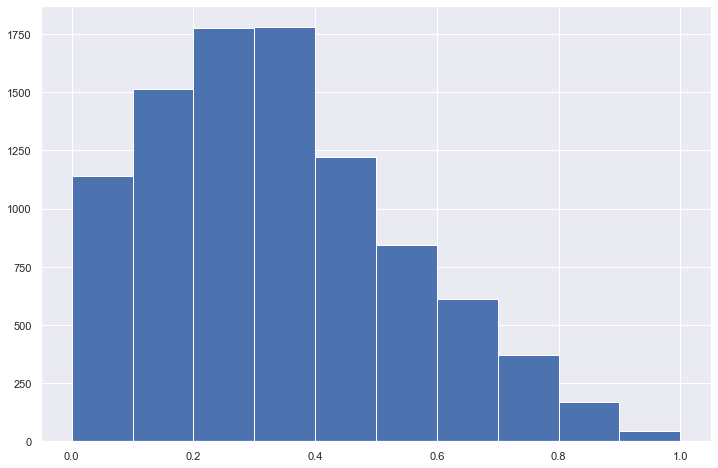

In [1090]:
filmography_RT_data['RT_comb_score'].hist();

In [1099]:
filmography_RT_data.to_csv('filmography_RT_scores_new.csv', index=False)

### Combine Netflix, non-Netflix Films, Filmographies

In [1139]:
n_urls = list(movie_urls_df[movie_urls_df['Netflix_prod']==True]['IMDb_url'])

netflix_urls=[]
for u in n_urls:
    u_split = u.split('/title/')[1]
    netflix_urls.append(u_split)

In [1150]:
old_master_data = pd.read_pickle('master_data_v4.pkl')

In [1159]:
netflix_indices = []
netflix_urls2 = []
for i in range(622):
    imdb_url = old_master_data['IMDb_url'].iloc[i].split('/title/')[1]
    if imdb_url in netflix_urls:
        netflix_indices.append(i)
        netflix_urls2.append(imdb_url)

In [1160]:
set(netflix_urls)-set(netflix_urls2)

{'tt4537986/', 'tt8354112/'}

In [1176]:
old_master_data[old_master_data['Title']=='Manhunt']
old_master_data[old_master_data['Title']=='Mosul']

,Title,Lang,Lang_eng,Rel_year,Rel_month,Genre,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Actor5_films,Actor5_film_scores,Actor5_qual,Actor_avg_qual,Actor_nom_cnt,RT_score,RT_rev_cnt,RT_comb_score,RT_url,IMDb_url
289,Manhunt,English,1,2017,8,"['Biography', 'Crime', 'Drama', 'Thriller']",0,0,0,1,...,"{'Jobs': [2013, nan], 'Hitting the Bricks': [2008, 4]}","[0.12106385971368973, nan]",0.048931,0.153341,0,67.0,30,0.356792,https://www.rottentomatoes.com/m/manhunt_2017,http://www.imdb.com/title/tt5618256/


,Title,Lang,Lang_eng,Rel_year,Rel_month,Genre,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Actor5_films,Actor5_film_scores,Actor5_qual,Actor_avg_qual,Actor_nom_cnt,RT_score,RT_rev_cnt,RT_comb_score,RT_url,IMDb_url
306,Mosul,Arabic,0,2019,11,"['Action', 'Drama', 'War']",1,0,0,0,...,"{'Beirut': [2018, nan], 'Damascus Cover': [2017, 18], '13 Hours': [2016, nan]}","[0.479384833132128, 0.04568394226146836, 0.26948962015346845]",0.262208,0.21334,0,84.0,32,0.454597,https://www.rottentomatoes.com/m/mosul_2020,http://www.imdb.com/title/tt9252468/


In [1180]:
netflix_indices.extend([289,306])

In [1186]:
main_data_df2.columns

Index(['Title', 'Lang', 'Rel_year', 'Rel_month', 'Distributor', 'Genre',
       'Plot_summ', 'Plot_keywords', 'Rating', 'Rating_reason', 'Runtime',
       'RT_url', 'IMDb_url'],
      dtype='object')

In [1187]:
old_master_data.columns

Index(['Title', 'Lang', 'Lang_eng', 'Rel_year', 'Rel_month', 'Genre',
       'Genre_Action', 'Genre_Adventure', 'Genre_Animation', 'Genre_Biography',
       'Genre_Comedy', 'Genre_Crime', 'Genre_Documentary', 'Genre_Drama',
       'Genre_Family', 'Genre_Fantasy', 'Genre_History', 'Genre_Horror',
       'Genre_LGBTQ', 'Genre_Music', 'Genre_Musical', 'Genre_Mystery',
       'Genre_News', 'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Short',
       'Genre_Sport', 'Genre_Thriller', 'Genre_War', 'Genre_Western',
       'Plot_summ', 'Plot_keywords', 'Based_on_existing_material',
       'Based_on_real_life', 'Rating', 'Rating_General', 'Rating_Limited',
       'Rating_Not rated', 'Rating_Restricted', 'Rating_reason', 'Runtime',
       'Writer_director', 'Dir1', 'Dir1_films', 'Dir1_film_scores',
       'Dir1_qual', 'Dir2', 'Dir2_films', 'Dir2_film_scores', 'Dir2_qual',
       'Dir3', 'Dir3_films', 'Dir3_film_scores', 'Dir3_qual', 'Dir_avg_qual',
       'Dir_nom_cnt', 'Writer1', 'Writer1_films', 'Wri

In [1518]:
### append to final non-Netflix dataset ###
main_data_netflix = old_master_data.iloc[netflix_indices][['Title','Lang','Rel_year','Rel_month','Genre','Plot_summ','Plot_keywords',\
                                     'Rating','Rating_reason','Runtime','RT_score','RT_rev_cnt','RT_comb_score','RT_url','IMDb_url']]
main_data_netflix.insert(loc=4, column='Distributor',value=['Netflix']*264)

In [1239]:
score_lst=[]
rev_cnt_lst=[]
for i in range(750):
    url = main_data_df2['RT_url'].iloc[i]
    for j in range(2516):
        url2 = RT_subset['URL'].iloc[j]
        if url==url2:
            score = RT_subset['Critic_score'].iloc[j]
            score_lst.append(score)
            rev_cnt = RT_subset['Critic_rev_cnt'].iloc[j]
            rev_cnt_lst.append(rev_cnt)

In [1243]:
main_data_df2.insert(loc=11, column='RT_score', value=score_lst)
main_data_df2.insert(loc=12, column='RT_rev_cnt', value=rev_cnt_lst)

In [1407]:
bad_genres=[]
for i in range(750):
    g=main_data_df2['Genre'].iloc[i]
    for gi in g:
        if (gi=='Documentary') or (gi=='Short'):
            bad_genres.append(i)

In [1408]:
main_data_df2 = main_data_df2.drop(bad_genres)
len(main_data_df2)

739

In [1433]:
main_data_df2 = main_data_df2.reset_index(drop=True)

In [1519]:
all_main_data = pd.concat([main_data_netflix, main_data_df2], ignore_index=True)

In [1215]:
new_n = list(all_main_data[(all_main_data['Distributor']=='Netflix')]['Title'])

In [1217]:
set(new_n)-set(old_master_data['Title'])

{'Apollo 10 1/2: A Space Age Childhood',
 'Choose or Die',
 'Death to 2020',
 'Monsoon',
 'No One Gets Out Alive',
 'Operation Mincemeat',
 'Radium Girls',
 'Running With the Devil',
 'The Old Ways',
 'The Wandering Earth',
 'Uncut Gems',
 'Wind River'}

In [1421]:
bad_genres

[12, 79, 100, 141, 207, 275, 307, 320, 565, 574, 583]

In [1428]:
filmographies_df = filmographies_df.reset_index(drop=True)

In [1430]:
filmographies_df = filmographies_df.drop(bad_genres)

In [1431]:
filmographies_df = filmographies_df.reset_index(drop=True)

In [1435]:
main_data_df3 = main_data_df2.iloc[:,:11]
main_data_df3['Director'] = list(filmographies_df['Dir_names'])
main_data_df3['Dir_recent_work'] = list(filmographies_df['Dir_projs'])
main_data_df3['Writer'] = list(filmographies_df['Wrtr_names'])
main_data_df3['Writer_recent_work'] = list(filmographies_df['Writer_projs'])
main_data_df3['Cast'] = list(filmographies_df['Actr_names'])
main_data_df3['Cast_recent_work'] = list(filmographies_df['Actor_projs'])
main_data_df3 = pd.concat([main_data_df3, main_data_df2.iloc[:,11:]], axis=1)

### Calculate Cast/Crew Quality Scores

In [1439]:
df_dirs = pd.DataFrame(main_data_df3['Director'].to_list(), columns=['Dir1', 'Dir2', 'Dir3'])
df_dirs.head()

,Dir1,Dir2,Dir3
0,Rob Jabbaz,None,None
1,Xavier Dolan,None,None
2,Denis Villeneuve,None,None
3,Xavier Legrand,None,None
4,Atom Egoyan,None,None


In [1440]:
df_dir_films = pd.DataFrame(main_data_df3['Dir_recent_work'].to_list(), columns=['Dir1_films', 'Dir2_films', 'Dir3_films'])
df_dir_films = pd.concat([main_data_df3['Rel_year'], df_dir_films], axis=1)
df_dir_films.head()

,Rel_year,Dir1_films,Dir2_films,Dir3_films
0,2021,{},None,None
1,2019,"{'The Death & Life of John F. Donovan': 2018, 'It's Only the End of the World': 2016, 'Mommy': 2014, 'Tom at the Farm': 2013, 'Laurence Anyways': 2012, 'Heartbeats': 2010, 'I Killed My Mother': 2009}",None,None
2,2021,"{'Blade Runner 2049': 2017, 'Arrival': 2016, 'Sicario': 2015, 'Enemy': 2013, 'Prisoners': 2013, 'Incendies': 2010, 'Polytechnique': 2009, 'Happiness Bound': 2007}",None,None
3,2017,{},None,None
4,2019,"{'Remember': 2015, 'The Captive': 2014, 'Devil's Knot': 2013, 'Venice 70: Future Reloaded': 2013, 'Chloe': 2009, 'Adoration': 2008, 'Citadel': 2006, 'Where the Truth Lies': 2005, 'Ararat': 2002, 'Felicia's Journey': 1999}",None,None


In [1441]:
df_writer = pd.DataFrame(main_data_df3['Writer'].to_list(), columns=['Writer1', 'Writer2', 'Writer3'])
df_writer.head()

,Writer1,Writer2,Writer3
0,Rob Jabbaz,None,None
1,Xavier Dolan,None,None
2,Jon Spaihts,Denis Villeneuve,Eric Roth
3,Xavier Legrand,None,None
4,Atom Egoyan,None,None


In [1442]:
df_writer_films = pd.DataFrame(main_data_df3['Writer_recent_work'].to_list(), columns=['Writer1_films', 'Writer2_films', 'Writer3_films'])
df_writer_films = pd.concat([main_data_df3['Rel_year'], df_writer_films], axis=1)
df_writer_films.head()

,Rel_year,Writer1_films,Writer2_films,Writer3_films
0,2021,{},None,None
1,2019,"{'The Death & Life of John F. Donovan': 2018, 'It's Only the End of the World': 2016, 'Mommy': 2014, 'Tom at the Farm': 2013, 'Laurence Anyways': 2012, 'Heartbeats': 2010, 'I Killed My Mother': 2009}",None,None
2,2021,"{'The Mummy': 2017, 'Passengers': 2016, 'Doctor Strange': 2016, 'Prometheus': 2012, 'The Darkest Hour': 2011}","{'Incendies': 2010, 'Polytechnique': 2009}","{'A Star Is Born': 2018, 'Extremely Loud & Incredibly Close': 2011, 'The Curious Case of Benjamin Button': 2008, 'Lucky You': 2007, 'The Good Shepherd': 2006, 'Munich': 2005, 'Ali': 2001}"
3,2017,{},None,None
4,2019,"{'The Captive': 2014, 'No Man's Zone': 2012, 'Adoration': 2008, 'Citadel': 2006, 'Where the Truth Lies': 2005, 'Ararat': 2002, 'Felicia's Journey': 1999}",None,None


In [1443]:
# for i in range(len(data)):
#     data['Actor(s)'].iloc[i] = literal_eval(data['Actor(s)'].iloc[i])

df_actors = pd.DataFrame(main_data_df3['Cast'].to_list(), columns=['Actor1', 'Actor2', 'Actor3', 'Actor4', 'Actor5'])
df_actors.head()

,Actor1,Actor2,Actor3,Actor4,Actor5
0,Berant Zhu,Regina Lei,Ying-Ru Chen,Tzu-Chiang Wang,Emerson Tsai
1,Gabriel D'Almeida Freitas,Xavier Dolan,Pier-Luc Funk,Samuel Gauthier,Antoine Pilon
2,Timothée Chalamet,Rebecca Ferguson,Zendaya,Oscar Isaac,Jason Momoa
3,Léa Drucker,Denis Ménochet,Thomas Gioria,Mathilde Auneveux,Mathieu Saikaly
4,Laysla De Oliveira,Luke Wilson,David Thewlis,Cherie D'Elia,Sugith Varughese


In [1444]:
# for i in range(len(data)):
#     films = data['Actor(s)_recent_work'].iloc[i]
#     films = films.replace('nan','0')
#     data['Actor(s)_recent_work'].iloc[i] = literal_eval(films)

df_actors_films = pd.DataFrame(main_data_df3['Cast_recent_work'].to_list(), columns=['Actor1_films', 'Actor2_films', 'Actor3_films','Actor4_films','Actor5_films'])
df_actors_films = pd.concat([main_data_df3['Rel_year'], df_actors_films], axis=1)
df_actors_films.head()

,Rel_year,Actor1_films,Actor2_films,Actor3_films,Actor4_films,Actor5_films
0,2021,"{'We Are Champions': [2019, 1], 'How to Train Our Dragon': [2018, 1]}",{},{},"{'My Missing Valentine': [2020, 1], 'Sent from Above': [2020, 1], 'The Shooting of 319': [2019, 1], 'See You After Life': [2017, 1], 'Ace of Sales': [2016, 1], 'Warmth': [2016, 1], 'The Bride': [2015, 1], 'Wu xing ji yu gan nu': [2015, 1], 'When Geek Meets Serial Killer': [2015, 1], 'Conspiracy': [2014, 1], '100 Days': [2013, 1], 'Apolitical Romance': [2013, 1], 'Zone Pro Site: The Moveable Feast': [2013, 1], 'Cha Cha for Twins': [2012, 1], 'Black & White Episode 1: The Dawn of Assault': [2012, 1], 'Make Up': [2011, 1]}","{'How to Train Our Dragon': [2018, 1], 'Tshiong': [2017, 1], 'All Because of Love': [2017, 1], 'Mon Mon Mon Monsters': [2017, 1], 'The Big Power': [2016, 1], 'The Tenants Downstairs': [2016, 1], 'Like Life': [2016, 1], 'Rookie Chef': [2016, 1], 'Café. Waiting. Love': [2014, 1], 'To My Dear Granny': [2012, 1], 'The Fierce Wife Final Episode': [2012, 1], 'You Are the Apple of My Eye': [2011, 1], 'Night Market Hero': [2011, 1]}"
1,2019,{},"{'Bad Times at the El Royale': [2018, 1], 'Boy Erased': [2018, 1], 'Elephant Song': [2014, 1], 'Miraculum': [2014, 1], 'Tom at the Farm': [2013, 1], 'Laurence Anyways': [2012, 1], 'Good Neighbours': [2010, 1], 'Heartbeats': [2010, 1], 'I Killed My Mother': [2009, 1], 'Suzie': [2009, 1]}","{'Genesis': [2018, 1], 'Sashinka': [2017, 1], 'Embrasse-moi comme tu m'aimes': [2016, 1], 'The Demons': [2015, 1], 'Aurélie Laflamme: Les pieds sur terre': [2015, 1], '1987': [2014, 1], 'Vic + Flo Saw a Bear': [2013, 1]}","{'The Fall of Sparta': [2018, 1], 'Slut in a Good Way': [2018, 1], 'When We Were Boys': [2013, 1]}","{'Wolfe': [2018, 1], 'Mad Dog Labine': [2018, 1], 'La chasse au collet': [2016, 1]}"
2,2021,"{'Little Women': [2019, 1], 'The King': [2019, 1], 'A Rainy Day in New York': [2019, 1], 'Beautiful Boy': [2018, 1], 'Hostiles': [2017, 1], 'Lady Bird': [2017, 1], 'Hot Summer Nights': [2017, 1], 'Call Me by Your Name': [2017, 1], 'Miss Stevens': [2016, 1], 'Love the Coopers': [2015, 1], 'The Adderall Diaries': [2015, 1], 'One and Two': [2015, 1], 'Interstellar': [2014, 1], 'Worst Friends': [2014, 1], 'Men, Women & Children': [2014, 1]}","{'Doctor Sleep': [2019, 1], 'Cold Night': [2019, 1], 'Men in Black: International': [2019, 1], 'The Kid Who Would Be King': [2019, 1], 'Mission: Impossible - Fallout': [2018, 1], 'The Greatest Showman': [2017, 1], 'The Snowman': [2017, 1], 'Life': [2017, 1], 'The Girl on the Train': [2016, 1], 'Florence Foster Jenkins': [2016, 1], 'Despite the Falling Snow': [2016, 1], 'Mission: Impossible - Rogue Nation': [2015, 1], 'Hercules': [2014, 1], 'Vi': [2013, 1], 'A One-Way Trip to Antibes': [2011, 1]}","{'Spider-Man: Far from Home': [2019, 1], 'Smallfoot': [2018, 1], 'Duck Duck Goose': [2018, 1], 'The Greatest Showman': [2017, 1], 'Spider-Man: Homecoming': [2017, 1]}","{'Star Wars: The Rise Of Skywalker': [2019, 1], 'The Addams Family': [2019, 1], 'Triple Frontier': [2019, 1], 'Spider-Man: Into the Spider-Verse': [2018, 1], 'Life Itself': [2018, 1], 'At Eternity's Gate': [2018, 1], 'Operation Finale': [2018, 1], 'Annihilation': [2018, 1], 'Star Wars: Episode VIII - The Last Jedi': [2017, 1], 'Suburbicon': [2017, 1], 'The Promise': [2016, 1], 'X-Men: Apocalypse': [2016, 1], 'Star Wars: Episode VII - The Force Awakens': [2015, 1], 'Mojave': [2015, 1], 'Ex Machina': [2014, 1], 'A Most Violent Year': [2014, 1], 'The Two Faces of January': [2014, 1], 'In Secret': [2013, 1], 'Inside Llewyn Davis': [2013, 1], 'Won't Back Down': [2012, 1], 'The Bourne Legacy': [2012, 1], 'Revenge for Jolly!': [2012, 1], 'For Greater Glory: The True Story of Cristiada': [2012, 1], '10 Years': [2011, 1], 'W.E.': [2011, 1], 'Drive': [2011, 1], 'Sucker Punch': [2011, 1]}","{'The Lego Movie 2: The Second Part': [2019, 1], 'Aquaman': [2018, 1], 'Braven': [2018, 1], 'Justice League': [2017, 1], 'Once Upon a Time in Venice': [201

In [1445]:
df_dirs = pd.concat([old_master_data.iloc[netflix_indices][['Dir1','Dir2','Dir3']], df_dirs], ignore_index=True)
df_dir_films = pd.concat([old_master_data.iloc[netflix_indices][['Rel_year','Dir1_films','Dir2_films','Dir3_films']], df_dir_films], ignore_index=True)
df_writer = pd.concat([old_master_data.iloc[netflix_indices][['Writer1','Writer2','Writer3']], df_writer], ignore_index=True)
df_writer_films = pd.concat([old_master_data.iloc[netflix_indices][['Rel_year','Writer1_films','Writer2_films','Writer3_films']], df_writer_films], ignore_index=True)
df_actors = pd.concat([old_master_data.iloc[netflix_indices][['Actor1','Actor2','Actor3','Actor4','Actor5']], df_actors], ignore_index=True)
df_actors_films = pd.concat([old_master_data.iloc[netflix_indices][['Rel_year','Actor1_films','Actor2_films','Actor3_films','Actor4_films','Actor5_films']], df_actors_films], ignore_index=True)

In [1450]:
# define function to calculate quality of crew
def calc_crew_qual(df, cast_crew_col): # df
    
    cast_crew_qual = []
    cast_crew_film_scores = []
    
    for i in range(len(df_dirs)):
        scores_ = []
        rel_year = df['Rel_year'].iloc[i] # new
        dic = cast_crew_col.iloc[i]
        if dic!=None:
            for j in dic:
                year = dic.get(j)
                if ((filmography_RT_data['Title']==j) & (filmography_RT_data['Year']==year)).any():
                    movie_score = filmography_RT_data[(filmography_RT_data['Title']==j) & (filmography_RT_data['Year']==year)]['RT_comb_score'].item()
                    cast_crew_score = movie_score # /((rel_year-year+1)**0.5)
                else:
                    movie_score = np.nan
                    cast_crew_score = np.nan
                scores_.append(cast_crew_score)
            if all(x is np.nan for x in scores_):
                cast_crew_score = np.nan
            else:
                cast_crew_score = np.nansum(scores_)/math.sqrt(len(scores_)) # np.count_nonzero(~np.isnan(scores_)) / len(scores_)
            cast_crew_film_scores.append(scores_)
            cast_crew_qual.append(cast_crew_score)
        else:
            cast_crew_film_scores.append(np.nan)
            cast_crew_qual.append(np.nan)
    
    return cast_crew_film_scores, cast_crew_qual


def norm_cast_crew_qual(lst1, lst2, lst3):

    dir_lst = lst1 + lst2 + lst3
    
    cast_crew_qual_lst = []
    for i in dir_lst:
        if i is np.nan:
            i_norm = np.nan
        else:
            i_norm = (i-np.nanmin(dir_lst))/(np.nanmax(dir_lst)-np.nanmin(dir_lst))
        cast_crew_qual_lst.append(i_norm)
    
    norm_lst1 = cast_crew_qual_lst[:1003]
    norm_lst2 = cast_crew_qual_lst[1003:2006]
    norm_lst3 = cast_crew_qual_lst[2006:3009]
    
    return norm_lst1, norm_lst2, norm_lst3

In [1451]:
# define function to calculate quality of cast
def calc_cast_qual(df, cast_crew_col):
    
    cast_crew_qual = []
    cast_crew_film_scores = []
    
    for i in range(len(df_dirs)):
        scores_ = []
        rel_year = df['Rel_year'].iloc[i] # new
        dic = cast_crew_col.iloc[i]
        if dic!=None:
            for j in dic:
                year = dic.get(j)[0]
                rank = dic.get(j)[1]
                if rank==0:
                    rank=np.nan
                if ((filmography_RT_data['Title']==j) & (filmography_RT_data['Year']==year)).any():
                    movie_score = filmography_RT_data[(filmography_RT_data['Title']==j) & (filmography_RT_data['Year']==year)]['RT_comb_score'].item()
                    cast_crew_score = movie_score/((rel_year-year+1)**(1/3)) # (rank**0.5)*
                else:
                    movie_score = np.nan
                    cast_crew_score = np.nan
                scores_.append(cast_crew_score)
            if all(x is np.nan for x in scores_):
                cast_crew_score = np.nan
            else:
                cast_crew_score = np.nansum(scores_)/math.sqrt(len(scores_)) # np.count_nonzero(~np.isnan(scores_)) / len(scores_)
            cast_crew_film_scores.append(scores_)
            cast_crew_qual.append(cast_crew_score)
        else:
            cast_crew_film_scores.append(np.nan)
            cast_crew_qual.append(np.nan)
    
    return cast_crew_film_scores, cast_crew_qual


def norm_cast_qual(lst1, lst2, lst3, lst4, lst5):

    actor_lst = lst1 + lst2 + lst3 + lst4 + lst5
    
    cast_crew_qual_lst = []
    for i in actor_lst:
        if i is np.nan:
            i_norm = np.nan
        else:
            i_norm = (i-np.nanmin(actor_lst))/(np.nanmax(actor_lst)-np.nanmin(actor_lst))
        cast_crew_qual_lst.append(i_norm)
    
    norm_lst1 = cast_crew_qual_lst[:1003]
    norm_lst2 = cast_crew_qual_lst[1003:2006]
    norm_lst3 = cast_crew_qual_lst[2006:3009]
    norm_lst4 = cast_crew_qual_lst[3009:4012]
    norm_lst5 = cast_crew_qual_lst[4012:5015]

    return norm_lst1, norm_lst2, norm_lst3, norm_lst4, norm_lst5

In [1452]:
dir1_film_scores, dir1_qual = calc_crew_qual(df_dir_films, df_dir_films['Dir1_films']) # df_dir_films, 
dir2_film_scores, dir2_qual = calc_crew_qual(df_dir_films, df_dir_films['Dir2_films']) # df_dir_films, 
dir3_film_scores, dir3_qual = calc_crew_qual(df_dir_films, df_dir_films['Dir3_films']) # df_dir_films, 

In [1453]:
dir1_qual, dir2_qual, dir3_qual = norm_cast_crew_qual(dir1_qual, dir2_qual, dir3_qual)

In [1454]:
df_dir_final = all_main_data[['Title','Rel_year','RT_rev_cnt','RT_comb_score']]
df_dir_final['Dir1'] = df_dirs[['Dir1']]
df_dir_final['Dir1_films'] = df_dir_films[['Dir1_films']]
df_dir_final['Dir1_film_scores'] = dir1_film_scores
df_dir_final['Dir1_qual']=dir1_qual

df_dir_final['Dir2'] = df_dirs[['Dir2']]
df_dir_final['Dir2_films'] = df_dir_films[['Dir2_films']]
df_dir_final['Dir2_film_scores'] = dir2_film_scores
df_dir_final['Dir2_qual']=dir2_qual

df_dir_final['Dir3'] = df_dirs[['Dir3']]
df_dir_final['Dir3_films'] = df_dir_films[['Dir3_films']]
df_dir_final['Dir3_film_scores'] = dir3_film_scores
df_dir_final['Dir3_qual']=dir3_qual

In [1455]:
df_dir_final['Dir_avg_qual'] = df_dir_final[['Dir1_qual','Dir2_qual','Dir3_qual']].mean(axis=1)

In [1456]:
df_dir_final2 = df_dir_final.sort_values(by='Dir_avg_qual', ascending=False)[['Title','RT_comb_score','Dir1','Dir2','Dir3','Dir1_films','Dir1_qual','Dir2_qual','Dir_avg_qual']]
df_dir_final2[:25].reset_index(drop=True)

,Title,RT_comb_score,Dir1,Dir2,Dir3,Dir1_films,Dir1_qual,Dir2_qual,Dir_avg_qual
0,Let Them All Talk,NaN,Steven Soderbergh,None,None,"{'The Laundromat': 2019, 'High Flying Bird': 2019, 'Unsane': 2018, 'Logan Lucky': 2017, 'Behind the Candelabra': 2013, 'Side Effects': 2013, 'Magic Mike': 2012, 'Haywire': 2011, 'Contagion': 2011, 'And Everything Is Going Fine': 2010, 'The Informant!': 2009, 'The Girlfriend Experience': 2009, 'Che: Part Two': 2008, 'Che: Part One': 2008, 'Ocean's Thirteen': 2007, 'The Good German': 2006, 'Bubble': 2005, 'Ocean's Twelve': 2004, 'Solaris': 2002, 'Full Frontal': 2002, 'Ocean's Eleven': 2001, 'Traffic': 2000, 'Erin Brockovich': 2000}",1.000000,NaN,1.000000
1,Kimi,NaN,Steven Soderbergh,None,None,"{'No Sudden Move': 2021, 'Let Them All Talk': 2020, 'The Laundromat': 2019, 'High Flying Bird': 2019, 'Unsane': 2018, 'Logan Lucky': 2017, 'Behind the Candelabra': 2013, 'Side Effects': 2013, 'Magic Mike': 2012, 'Haywire': 2011, 'Contagion': 2011, 'And Everything Is Going Fine': 2010, 'The Informant!': 2009, 'The Girlfriend Experience': 2009, 'Che: Part Two': 2008, 'Che: Part One': 2008, 'Ocean's Thirteen': 2007, 'The Good German': 2006, 'Bubble': 2005, 'Ocean's Twelve': 2004, 'Solaris': 2002, 'Full Frontal': 2002}",0.966586,NaN,0.966586
2,Ready Player One,NaN,Steven Spielberg,None,None,"{'The Post': 2017, 'The BFG': 2016, 'Bridge of Spies': 2015, 'Lincoln': 2012, 'War Horse': 2011, 'The Adventures of Tintin': 2011, 'Indiana Jones and the Kingdom of the Crystal Skull': 2008, 'Munich': 2005, 'War of the Worlds': 2005, 'The Terminal': 2004, 'Catch Me If You Can': 2002, 'Minority Report': 2002, 'A.I. Artificial Intelligence': 2001, 'Saving Private Ryan': 1998}",0.955481,NaN,0.955481
3,The Laundromat,0.329611,Steven Soderbergh,None,None,"{'Unsane': 2018, 'Logan Lucky': 2017, 'Behind The Candelabra': 2013, 'Side Effects': 2013, 'Magic Mike': 2012, 'Haywire': 2011, 'Contagion': 2011, 'And Everything Is Going Fine': 2010, 'The Informant!': 2009, 'The Girlfriend Experience': 2009, 'Che: Part Two': 2008, 'Che: Part One': 2008, 'Ocean's Thirteen': 2007, 'The Good German': 2006, 'Bubble': 2005, 'Ocean's Twelve': 2004, 'Solaris': 2002, 'Full Frontal': 2002, 'Ocean's Eleven': 2001, 'Traffic': 2000, 'Erin Brockovich': 2000, 'The Limey': 1999}",0.941315,NaN,0.941315
4,Richard Jewell,NaN,Clint Eastwood,None,None,"{'The Mule': 2018, 'The 15:17 to Paris': 2018, 'Sully': 2016, 'American Sniper': 2014, 'Jersey Boys': 2014, 'J. Edgar': 2011, 'Hereafter': 2010, 'Invictus': 2009, 'Gran Torino': 2008, 'Changeling': 2008, 'Letters from Iwo Jima': 2006, 'Flags of Our Fathers': 2006, 'Million Dollar Baby': 2004, 'Mystic River': 2003, 'Blood Work': 2002, 'Space Cowboys': 2000, 'True Crime': 1999}",0.827326,NaN,0.827326
5,The Ballad of Buster Scruggs,0.792897,Ethan Coen,Joel Coen,None,"{'Hail, Caesar!': 2016, 'Inside Llewyn Davis': 2013, 'True Grit': 2010, 'A Serious Man': 2009, 'Burn After Reading': 2008, 'No Country for Old Men': 2007, 'The Ladykillers': 2004, 'Intolerable Cruelty': 2003, 'O Brother, Where Art Thou?': 2000, 'The Big Lebowski': 1998}",0.802999,0.834467,0.818733
6,"Where'd You Go, Bernadette",NaN,Richard Linklater,None,None,"{'Last Flag Flying': 2017, 'Everybody Wants Some!!': 2016, 'Boyhood': 2014, 'Before Midnight': 2013, 'Bernie': 2011, 'Me and Orson Welles': 2008, 'Inning by Inning: A Portrait of a Coach': 2008, 'A Scanner Darkly': 2006, 'Fast Food Nation': 2006, 'Bad News Bears': 2005, 'Before Sunset': 2004, 'School of Rock': 2003, 'Tape': 2001, 'Waking Life': 2001}",0.814762,NaN,0.814762
7,Last Flag Flying,NaN,Richard Linklater,None,None,"{'Everybody Wants Some!!': 2016, 'Boyhood': 2014, 'Before Midnight': 2013, 'Bernie': 2011, 'Me and Orson Welles': 2008, 'Inning by Inning: A Portrait of a Coach': 2008, 'A Scanner Darkly': 2006, 'Fast Food Nation': 2006, 'Bad News Bears': 2005, 'Before Sunset': 2004, 'School of Rock': 2003, 'Tape': 2001, 'Waking Life': 2001, 'The Newton Boys': 1998}",0.785826,NaN,0.785826
8,Apollo

In [1458]:
writer1_film_scores, writer1_qual = calc_crew_qual(df_writer_films, df_writer_films['Writer1_films'])
writer2_film_scores, writer2_qual = calc_crew_qual(df_writer_films, df_writer_films['Writer2_films'])
writer3_film_scores, writer3_qual = calc_crew_qual(df_writer_films, df_writer_films['Writer3_films'])

In [1459]:
writer1_qual, writer2_qual, writer3_qual = norm_cast_crew_qual(writer1_qual, writer2_qual, writer3_qual)

In [1460]:
df_writer_final = all_main_data[['Title','Rel_year','RT_rev_cnt','RT_comb_score']]
df_writer_final['Writer1'] = df_writer[['Writer1']]
df_writer_final['Writer1_films'] = df_writer_films[['Writer1_films']]
df_writer_final['Writer1_film_scores'] = writer1_film_scores
df_writer_final['Writer1_qual'] = writer1_qual

df_writer_final['Writer2'] = df_writer[['Writer2']]
df_writer_final['Writer2_films'] = df_writer_films[['Writer2_films']]
df_writer_final['Writer2_film_scores'] = writer2_film_scores
df_writer_final['Writer2_qual'] = writer2_qual

df_writer_final['Writer3'] = df_writer[['Writer3']]
df_writer_final['Writer3_films'] = df_writer_films[['Writer3_films']]
df_writer_final['Writer3_film_scores'] = writer3_film_scores
df_writer_final['Writer3_qual'] = writer3_qual

In [1461]:
df_writer_final['Writer_avg_qual'] = df_writer_final[['Writer1_qual','Writer2_qual','Writer3_qual']].mean(axis=1)

In [1462]:
df_writer_final2 = df_writer_final.sort_values(by='Writer_avg_qual', ascending=False)[['Title','RT_comb_score','Writer1','Writer2','Writer3','Writer1_films','Writer1_qual','Writer2_qual','Writer3_qual','Writer_avg_qual']]
df_writer_final2[:25].reset_index(drop=True)

,Title,RT_comb_score,Writer1,Writer2,Writer3,Writer1_films,Writer1_qual,Writer2_qual,Writer3_qual,Writer_avg_qual
0,The Ballad of Buster Scruggs,0.792897,Joel Coen,Ethan Coen,Jack London,"{'Suburbicon': 2017, 'Hail, Caesar!': 2016, 'Bridge of Spies': 2015, 'Unbroken': 2014, 'Inside Llewyn Davis': 2013, 'Gambit': 2012, 'True Grit': 2010, 'A Woman, a Gun and a Noodle Shop': 2009, 'A Serious Man': 2009, 'Burn After Reading': 2008, 'No Country for Old Men': 2007, 'The Ladykillers': 2004, 'Intolerable Cruelty': 2003, 'The Man Who Wasn't There': 2001, 'O Brother, Where Art Thou?': 2000, 'The Big Lebowski': 1998}",0.994122,0.971105,NaN,0.982613
1,Marriage Story,0.953536,Noah Baumbach,None,None,"{'The Meyerowitz Stories': 2017, 'Mistress America': 2015, 'While We're Young': 2014, 'Frances Ha': 2012, 'Madagascar 3: Europe's Most Wanted': 2012, 'Greenberg': 2010, 'Fantastic Mr. Fox': 2009, 'Margot at the Wedding': 2007, 'The Squid and the Whale': 2005, 'The Life Aquatic with Steve Zissou': 2004}",0.855648,NaN,NaN,0.855648
2,Apollo 10 1/2: A Space Age Childhood,NaN,Richard Linklater,None,None,"{'Where'd You Go, Bernadette': 2019, 'Last Flag Flying': 2017, 'Everybody Wants Some!!': 2016, 'Boyhood': 2014, 'Before Midnight': 2013, 'Bernie': 2011, 'A Scanner Darkly': 2006, 'Fast Food Nation': 2006, 'Before Sunset': 2004}",0.823898,NaN,NaN,0.823898
3,"Family Romance, LLC",NaN,Werner Herzog,None,None,"{'Meeting Gorbachev': 2018, 'Into the Inferno': 2016, 'Salt and Fire': 2016, 'Lo and Behold: Reveries of the Connected World': 2016, 'Queen of the Desert': 2015, 'Into the Abyss': 2011, 'Happy People: A Year in the Taiga': 2010, 'Cave of Forgotten Dreams': 2010, 'My Son, My Son, What Have Ye Done': 2009, 'Encounters at the End of the World': 2007, 'Rescue Dawn': 2006, 'The Wild Blue Yonder': 2005, 'Grizzly Man': 2005, 'The White Diamond': 2004, 'Wheel of Time': 2003, 'Invincible': 2001}",0.823204,NaN,NaN,0.823204
4,Suburbicon,NaN,Joel Coen,Ethan Coen,George Clooney,"{'Hail, Caesar!': 2016, 'Bridge of Spies': 2015, 'Unbroken': 2014, 'Inside Llewyn Davis': 2013, 'Gambit': 2012, 'True Grit': 2010, 'A Woman, a Gun and a Noodle Shop': 2009, 'A Serious Man': 2009, 'Burn After Reading': 2008, 'No Country for Old Men': 2007, 'The Ladykillers': 2004, 'Intolerable Cruelty': 2003, 'The Man Who Wasn't There': 2001, 'O Brother, Where Art Thou?': 2000, 'The Big Lebowski': 1998}",1.000000,0.975116,0.431736,0.802284
5,Baby Driver,NaN,Edgar Wright,None,None,"{'Ant-Man': 2015, 'The World's End': 2013, 'The Adventures of Tintin': 2011, 'Scott Pilgrim vs. the World': 2010, 'Hot Fuzz': 2007, 'Shaun of the Dead': 2004}",0.759697,NaN,NaN,0.759697
6,The Meyerowitz Stories (New and Selected),0.783578,Noah Baumbach,None,None,"{'Mistress America': 2015, 'While We're Young': 2014, 'Frances Ha': 2012, 'Madagascar 3: Europe's Most Wanted': 2012, 'Greenberg': 2010, 'Fantastic Mr. Fox': 2009, 'Margot at the Wedding': 2007, 'The Squid and the Whale': 2005, 'The Life Aquatic with Steve Zissou': 2004, 'Highball': 1997, 'Mr. Jealousy': 1997}",0.758475,NaN,NaN,0.758475
7,Sorry We Missed You,NaN,Paul Laverty,None,None,"{'Yuli': 2018, 'I, Daniel Blake': 2016, 'The Olive Tree': 2016, 'Jimmy's Hall': 2014, 'The Angels' Share': 2012, 'Katmandú, un espejo en el cielo': 2011, 'Even the Rain': 2010, 'Route Irish': 2010, 'Looking for Eric': 2009, 'It's a Free World...': 2007, 'The Wind that Shakes the Barley': 2006, 'Cargo': 2006, 'Tickets': 2005, 'Ae Fond Kiss...': 2004, 'Sweet Sixteen': 2002, 'Bread and Roses': 2000}",0.745500,NaN,NaN,0.745500
8,The Trial of the Chicago 7,0.865738,Aaron Sorkin,None,None,"{'Molly's Game': 2017, 'Steve Jobs': 2015, 'Moneyball': 2011, 'The Social Network': 2010, 'Charlie Wilson's War': 2007}",0.740268,NaN,NaN,0.740268
9,Don't Look Up,0.515997,Adam McKay,David Sirota,None,"{'Vice': 2018, 'The Big Short': 2015, 'Ant-Man': 2015, 'Get Hard': 2015, 'We the Economy: 20 Short Films You Can't Afford to Miss': 2014, 'Anchorman 2: The Legend Continues': 2013, 'The Camp

In [1463]:
actor1_film_scores, actor1_qual = calc_cast_qual(df_actors_films, df_actors_films['Actor1_films'])
actor2_film_scores, actor2_qual = calc_cast_qual(df_actors_films, df_actors_films['Actor2_films'])
actor3_film_scores, actor3_qual = calc_cast_qual(df_actors_films, df_actors_films['Actor3_films'])
actor4_film_scores, actor4_qual = calc_cast_qual(df_actors_films, df_actors_films['Actor4_films'])
actor5_film_scores, actor5_qual = calc_cast_qual(df_actors_films, df_actors_films['Actor5_films'])

In [1464]:
actor1_qual,actor2_qual,actor3_qual,actor4_qual,actor5_qual = norm_cast_qual(actor1_qual,actor2_qual,actor3_qual,actor4_qual,actor5_qual)

In [1465]:
df_actors_final = all_main_data[['Title','Rel_year','RT_rev_cnt','RT_comb_score']]
df_actors_final['Actor1'] = df_actors[['Actor1']]
df_actors_final['Actor1_films'] = df_actors_films[['Actor1_films']]
df_actors_final['Actor1_film_scores'] = actor1_film_scores
df_actors_final['Actor1_qual']=actor1_qual

df_actors_final['Actor2'] = df_actors[['Actor2']]
df_actors_final['Actor2_films'] = df_actors_films[['Actor2_films']]
df_actors_final['Actor2_film_scores'] = actor2_film_scores
df_actors_final['Actor2_qual']=actor2_qual

df_actors_final['Actor3'] = df_actors[['Actor3']]
df_actors_final['Actor3_films'] = df_actors_films[['Actor3_films']]
df_actors_final['Actor3_film_scores'] = actor3_film_scores
df_actors_final['Actor3_qual']=actor3_qual

df_actors_final['Actor4'] = df_actors[['Actor4']]
df_actors_final['Actor4_films'] = df_actors_films[['Actor4_films']]
df_actors_final['Actor4_film_scores'] = actor4_film_scores
df_actors_final['Actor4_qual']=actor4_qual

df_actors_final['Actor5'] = df_actors[['Actor5']]
df_actors_final['Actor5_films'] = df_actors_films[['Actor5_films']]
df_actors_final['Actor5_film_scores'] = actor5_film_scores
df_actors_final['Actor5_qual']=actor5_qual

In [1466]:
df_actors_final['Actor_avg_qual'] = df_actors_final[['Actor1_qual','Actor2_qual','Actor3_qual','Actor4_qual','Actor5_qual']].mean(axis=1)
# .apply(pd.Series.nlargest, axis=1, n=3).mean(axis=1)

In [1468]:
df_actors_final2 = df_actors_final.\
sort_values(by='Actor_avg_qual', ascending=False)[['Title','Rel_year','RT_comb_score','Actor1','Actor2','Actor3','Actor4','Actor5',\
                                                'Actor1_qual','Actor2_qual','Actor3_qual','Actor4_qual',\
                                                'Actor5_qual','Actor_avg_qual']]
df_actors_final2[:25].reset_index(drop=True)

,Title,Rel_year,RT_comb_score,Actor1,Actor2,Actor3,Actor4,Actor5,Actor1_qual,Actor2_qual,Actor3_qual,Actor4_qual,Actor5_qual,Actor_avg_qual
0,Nightmare Alley,2021,NaN,Bradley Cooper,Cate Blanchett,Toni Collette,Willem Dafoe,Richard Jenkins,0.731746,0.749425,0.718571,0.708977,0.638261,0.709396
1,Song to Song,2017,NaN,Ryan Gosling,Rooney Mara,Michael Fassbender,Natalie Portman,Cate Blanchett,0.709199,0.662112,0.858890,0.520832,0.794968,0.709200
2,Captain Marvel,2019,NaN,Brie Larson,Samuel L. Jackson,Ben Mendelsohn,Jude Law,Annette Bening,0.613910,0.833499,0.675130,0.610890,0.501234,0.646932
3,The Adam Project,2022,0.590428,Ryan Reynolds,Walker Scobell,Mark Ruffalo,Jennifer Garner,Zoe Saldana,0.650221,NaN,0.833701,0.396386,0.698779,0.644772
4,The Banker,2020,NaN,Anthony Mackie,Samuel L. Jackson,Nicholas Hoult,Nia Long,Scott Daniel Johnson,0.718510,0.956976,0.608659,0.289848,NaN,0.643498
5,Mowgli: Legend of the Jungle,2018,0.380548,Christian Bale,Cate Blanchett,Benedict Cumberbatch,Naomie Harris,Andy Serkis,0.600414,0.795898,0.673992,0.422932,0.658475,0.630342
6,Star Wars: The Rise of Skywalker,2019,NaN,Daisy Ridley,John Boyega,Oscar Isaac,Adam Driver,Carrie Fisher,0.500663,0.514954,0.786304,0.926690,0.385242,0.622771
7,Marriage Story,2019,0.953536,Adam Driver,Scarlett Johansson,Julia Greer,Azhy Robertson,Wallace Shawn,0.926690,0.922898,NaN,0.253162,0.353822,0.614143
8,Holmes & Watson,2018,NaN,Will Ferrell,John C. Reilly,Ralph Fiennes,Rebecca Hall,Rob Brydon,0.421618,0.779022,0.808700,0.659401,0.370515,0.607851
9,Suspiria,2018,NaN,Chloë Grace Moretz,Tilda Swinton,Doris Hick,Malgorzata Bela,Dakota Johnson,0.541263,0.844779,NaN,NaN,0.407569,0.597870


In [1472]:
df_dir_final
df_writer_final
df_actors_final

,Title,Rel_year,RT_rev_cnt,RT_comb_score,Actor1,Actor1_films,Actor1_film_scores,Actor1_qual,Actor2,Actor2_films,...,Actor3_qual,Actor4,Actor4_films,Actor4_film_scores,Actor4_qual,Actor5,Actor5_films,Actor5_film_scores,Actor5_qual,Actor_avg_qual
617,Black Widow,2021,445,NaN,Scarlett Johansson,"{'Jojo Rabbit': [2019, 1], 'Marriage Story': [2019, 1], 'Avengers: Endgame': [2019, 1], 'Captain Marvel': [2019, 1], 'Avengers: Infinity War': [2018, 1], 'Isle of Dogs': [2018, 1], 'Rough Night': [2017, 1], 'Ghost in the Shell': [2017, 1], 'Sing': [2016, 1], 'Captain America: Civil War': [2016, 1], 'The Jungle Book': [2016, 1], 'Hail, Caesar!': [2016, 1], '(RED) Shopathon Holiday Jingle': [2015, 1], 'Avengers: Age of Ultron': [2015, 1], 'Lucy': [2014, 1], 'Captain America: The Winter Soldier': [2014, 1], 'Chef': [2014, 1], 'Her': [2013, 1], 'Under the Skin': [2013, 1], 'Don Jon': [2013, 1], 'Hitchcock': [2012, 1], 'The Avengers': [2012, 1], 'We Bought a Zoo': [2011, 1]}","[0.5476111154027297, 0.6314035154785657, 0.6858804025300685, 0.5748528439890501, 0.546899471593851, 0.5403517508476605, 0.2079947201935381, 0.2272304547105359, 0.3144013102245294, 0.48954203391336076, 0.4783908348565816, 0.4482928249503408, nan, 0.3801731954440515, 0.28622961644340417, 0.40965709336156897, 0.3514130498119865, 0.40348604469732213, 0.3513597559202491, 0.31662575758693695, 0.23227535731732177, 0.4006406405708957, 0.23033730103011127]",1.000000,Florence Pugh,"{'Father of the Bride Part 3 (ish)': [2020, 1], 'Little Women': [2019, 1], 'Midsommar': [2019, 1], 'Fighting with My Family': [2019, 1], 'Malevolent': [2018, 1], 'Outlaw King': [2018, 1], 'The Commuter': [2018, 1], 'Lady Macbeth': [2016, 1], 'The Falling': [2014, 1]}",...,0.372079,Rachel Weisz,"{'The Favourite': [2018, 1], 'The Mercy': [2018, 1], 'Disobedience': [2017, 1], 'My Cousin Rachel': [2017, 1], 'Denial': [2016, 1], 'The Light Between Oceans': [2016, 1], 'Complete Unknown': [2016, 1], 'Youth': [2015, 1], 'The Lobster': [2015, 1], 'Oz the Great and Powerful': [2013, 1], 'The Bourne Legacy': [2012, 1], 'Dream House': [2011, 1], 'The Deep Blue Sea': [2011, 1], '360': [2011, 1]}","[0.5777075392586108, 0.30483779066082656, 0.4053922152571026, 0.34133044484990743, 0.3578790738171903, 0.2909144624547727, 0.1800777726719314, 0.30991558159994925, 0.3991265346589415, 0.24204993328798316, 0.21673977727493338, 0.017956070823084286, 0.26983697798227135, 0.057508852602637536]",0.562133,Ray Winstone,"{'Cats': [2019, 1], 'The Queen's Corgi': [2019, 1], 'King of Thieves': [2018, 1], 'Jawbone': [2017, 1], 'Point Break': [2015, 1], 'Barney Thomson': [2015, 1], 'The Gunman': [2015, 1], 'Zipper': [2015, 1], 'Noah': [2014, 1], 'Lords of London': [2014, 1], 'Ashes': [2012, 1], 'The Sweeney': [2012, 1], 'The Hot Potato': [2012, 1], 'Snow White and the Huntsman': [2012, 1], 'Elfie Hopkins: Cannibal Hunter': [2012, 1], 'Hugo': [2011, 1], 'Rango': [2011, 1]}","[0.12192210256321334, 0.0, 0.13796768448611474, 0.27809453793938277, 0.04065070954642585, 0.17370529622762176, 0.06666694682807368, 0.053171786100116164, 0.3312674952447742, nan, nan, 0.13174165769575105, nan, 0.1943267145824349, 0.0, 0.35502694885658415, 0.3326473499795062]",0.284807,0.552485
313,The Souvenir Part II,2021,126,NaN,Tilda Swinton,"{'Last and First Men': [2020, 1], 'The Personal History of David Copperfield': [2019, 1], 'Uncut Gems': [2019, 1], 'The Dead Don't Die': [2019, 1], 'Avengers: Endgame': [2019, 1], 'The Souvenir': [2019, 1], 'Suspiria': [2018, 1], 'Isle of Dogs': [2018, 1], 'War Machine': [2017, 1], 'Okja': [2017, 1], 'Doctor Strange': [2016, 1], 'Letters from Baghdad': [2016, 1], 'Hail, Caesar!': [2016, 1], 'A Bigger Splash': [2015, 1], 'Trainwreck': [2015, 1], 'The Grand Budapest Hotel': [2014, 1], 'The Zero Theorem': [2013, 1], 'Snowpiercer': [2013, 1], 'Only Lovers Left Alive': [2013, 1], 'Moonrise Kingdom': [2012, 1], 'We Need to Talk About Kevin': [2011, 1]}","[0.3931587046153547, 0.5495306672019267, 0.5965422740616299, 0.34167541073570

### Put it all together

In [1553]:
# all_main_data2 = all_main_data.copy()

In [1531]:
df_part1 = pd.concat([all_main_data2.iloc[:,0:11],df_dir_final.iloc[:,4:]], axis=1)

In [1533]:
df_part2 = pd.concat([df_part1,df_writer_final.iloc[:,4:]], axis=1)

In [1534]:
df_part3 = pd.concat([df_part2,df_actors_final.iloc[:,4:]], axis=1)

In [1539]:
df_final = pd.concat([df_part3,all_main_data2.iloc[:,11:]], axis=1)

In [1546]:
#### COMBINED SCORE FORMULA ####
RT_comb_score_ = (df_final['RT_score']**2) * (df_final['RT_rev_cnt']**0.5)

sqrt_trans_score_ = []
for i in RT_comb_score_:
    i_norm = (i-RT_comb_score_.min())/(RT_comb_score_.max()-RT_comb_score_.min())
    i_new = math.sqrt(i_norm)
    sqrt_trans_score_.append(i_new)

df_final['RT_comb_score'] = sqrt_trans_score_

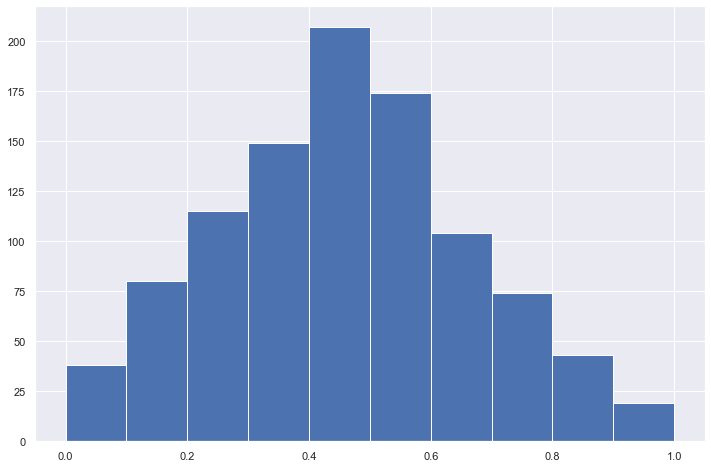

In [1547]:
df_final['RT_comb_score'].hist();

In [1552]:
df_final.sort_values(by='RT_comb_score', ascending=False)[['Title','Rel_year','Distributor','RT_comb_score']][:20]

,Title,Rel_year,Distributor,RT_comb_score
777,Mission: Impossible -- Fallout,2018,Paramount Pictures,1.000000
326,Lady Bird,2017,A24,0.995905
185,The Irishman,2019,Netflix,0.989811
429,Spider-Man: Into the Spider-Verse,2018,Columbia Pictures,0.972707
144,ROMA,2018,Netflix,0.969945
613,The Shape of Water,2017,Twentieth Century Fox,0.960640
285,Coco,2017,Walt Disney Studios Motion Pictures,0.948290
114,Marriage Story,2019,Netflix,0.943820
960,Eighth Grade,2018,A24,0.943050
874,If Beale Street Could Talk,2018,Annapurna Pictures,0.933926


In [1554]:
writer_dir_lst = []
for i in range(len(df_final)):
    dirs = []
    dir1 = df_final['Dir1'].iloc[i]
    dir2 = df_final['Dir2'].iloc[i]
    dir3 = df_final['Dir3'].iloc[i]
    
    dirs.append(dir1)
    dirs.append(dir2)
    dirs.append(dir3)
    
    writers = []
    writer1 = df_final['Writer1'].iloc[i]
    writer2 = df_final['Writer2'].iloc[i]
    writer3 = df_final['Writer3'].iloc[i]
    
    writers.append(writer1)
    writers.append(writer2)
    writers.append(writer3)
    
    searching=True
    
    for d in dirs:
        if d==None:
            continue
        elif d in writers:
            writer_dir_lst.append(1)
            searching=False
            break
        elif d!=dirs[-1]:
            continue
        else:
            writer_dir_lst.append(0)
            searching=False
            break
            
    if searching==True:
        writer_dir_lst.append(0)

In [1558]:
df_final.insert(loc=11, column='Writer_director', value=writer_dir_lst)

In [1595]:
from ast import literal_eval
genres_lst1 = [literal_eval(x) for x in list(df_final['Genre'])[:264]]
genres_lst2 = list(df_final['Genre'])[264:]
genres_lst = genres_lst1 + genres_lst2

In [1598]:
df_final['Genre'] = genres_lst

In [1563]:
p_kwords = list(df_final['Plot_keywords'])

existing_material = []
real_life = []

for i in p_kwords:
    
    searching = True
    if i==['DNE']:
        searching = False
        existing_material.append(np.nan)
        real_life.append(np.nan)
        continue
    
    else:
        l = []
        for j in i:
            if 'based on' in j:
                searching = False
                l.append(j)
            else:
                continue
        
        if l!=[]:
            for k in l:
                if ('real' in k) or ('true' in k):
                    real_life.append(1)
                    break
                elif k==l[-1]:
                    real_life.append(0)
                    break
                else:
                    continue

            for k in l:
                if ('real' not in k) and ('true' not in k):
                    existing_material.append(1)
                    break
                elif k==l[-1]:
                    existing_material.append(0)
                    break
                else:
                    continue
                
    if searching==True:
        existing_material.append(0)
        real_life.append(0)
        continue

In [1600]:
for i,ind in zip(real_life,range(len(genres_lst))):
    if 'Documentary' in genres_lst[ind]:
        real_life[ind]=1
        existing_material[ind]=0
    elif 'Biography' in genres_lst[ind]:
        real_life[ind]=1

In [1601]:
df_existing = pd.DataFrame(existing_material, columns=['Based_on_existing_material'])
df_existing
df_real = pd.DataFrame(real_life, columns=['Based_on_real_life'])
df_real

,Based_on_existing_material
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0
...,...
998,0.0
999,0.0
1000,0.0
1001,0.0


,Based_on_real_life
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
998,0.0
999,0.0
1000,0.0
1001,0.0


In [1602]:
df_genres = pd.get_dummies(df_final['Genre'].apply(pd.Series).stack(), prefix='Genre').sum(level=0)
df_genres

,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_History,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War,Genre_Western
0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
999,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1000,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [1671]:
genres = list(set([item for sublist in genres_lst for item in sublist]))

In [1681]:
all_urls = list(RT_data['URL'])
subset_urls = list(df_final['RT_url'])
gay_urls=[]
for u in subset_urls:
    for u2 in all_urls:
        if u==u2:
            g = RT_data[RT_data['URL']==u2]['Genre']
            if 'lgbt' in str(g).lower():
                gay_urls.append(RT_data[RT_data['URL']==u2]['URL'].item())

In [1682]:
RT_gay=[]
for t in gay_urls:
    if t not in list(data_gay[data_gay['Genre_LGBTQ']==1]['RT_url']):
        RT_gay.append(t)

In [1684]:
lgbt = []
terms=[]
for i in range(1003):
    keywords = df_final['Plot_keywords'].iloc[i]
    title = df_final['Title'].iloc[i]
    url = df_final['RT_url'].iloc[i]
    cnt=0
    term=[]
    if url in RT_gay:
        lgbt.append(1)
        continue
    for k in keywords:
        if ('gay' in k) or ('lesbian' in k) or ('bisexual' in k) or ('trans' in k) or ('queer' in k) or \
        ('homosexual' in k) or ('lgbt' in k.lower()) or ('homophob' in k) or ('closet' in k):
            if ('transform' in k) or ('transit' in k) or ('transport' in k) or ('transfer' in k) or ('reference' in k):
                continue
            else:
                cnt+=1
                term.append(k)
    if (cnt>4): # or (title=='John Was Trying to Contact Aliens') or (title=='A Secret Love'):
        lgbt.append(1)
        terms.append(term)
    else:
        lgbt.append(0)
        terms.append('')

In [1639]:
df_final2 = df_final.copy()

In [1680]:
df_final2['Genre_LGBTQ']=lgbt
data_gay = df_final2[['Title','Genre_LGBTQ','RT_url']]
data_gay['Terms']=terms
data_gay[data_gay['Genre_LGBTQ']==1]

,Title,Genre_LGBTQ,RT_url,Terms
13,Alex Strangelove,1,https://www.rottentomatoes.com/m/alex_strangelove,"[gay interest, gay character, gay kiss, gay boyfriend, gay slur, queer cinema, gay]"
69,Fear Street Part 1: 1994,1,https://www.rottentomatoes.com/m/fear_street_part_one_1994,"[lesbian kiss, teenage lesbian, lesbian teenager, transphobia, lesbian]"
71,Fear Street Part 3: 1666,1,https://www.rottentomatoes.com/m/fear_street_part_three_1666,"[lesbianism, lesbian kiss, homophobia, lesbian couple, lesbian cunnilingus, homophobic slur, lesbian]"
78,Girl,1,https://www.rottentomatoes.com/m/girl,"[transgender, transgender woman, transgender protagonist, lgbt cinema, gay sex, transgender interest]"
105,Let It Snow,1,https://www.rottentomatoes.com/m/let_it_snow_2019,"[lesbian, lesbian character, lesbian lead character, lesbian kiss, lesbian teenager, straight female lesbian female relationship, straight female lesbian female friendship, lesbian cinema]"
142,Rebecca,1,https://www.rottentomatoes.com/m/rebecca,"[gay subtext, lesbian, gay villain, lgbt cinema, gay cinema, gay character, gay, lesbian character, gay antagonist, lesbian antagonist]"
150,Sierra Burgess Is a Loser,1,https://www.rottentomatoes.com/m/sierra_burgess_is_a_loser,"[gay best friend, transphobic remark, transphobic girl, transphobic woman, transphobic joke, gay african american, gay character, gay black american, gay slur, homophobic slur, homophobic remark, mistaken belief that someone is gay, mistaken belief that someone is lesbian]"
151,Single All The Way,1,https://www.rottentomatoes.com/m/single_all_the_way,"[gay, gay interest, gay film, gay character, gay protagonist, gay cinema, interracial gay couple, interracial gay romance, gay relationship, gay date, gay kiss, gay comedy, gay romance]"
164,The Boys in the Band,1,https://www.rottentomatoes.com/m/the_boys_in_the_band,"[gay interest, gay, homosexual, homosexuality, gay slur]"
178,The Half Of It,1,https://www.rottentomatoes.com/m/the_half_of_it,"[lesbian, lesbian teen, gay character, lesbian character, gay kiss, gay woman straight man friendship, lesbian kiss, lgbt cinema, lesbian protagonist, gay protagonist, gay love triangle, closeted gay, mistaken belief that someone is gay, internalized homophobia, homophobia, homophobe, homophobic society, homophobic woman, straight man gay woman relationship, lesbian attracted to a straight woman]"


In [1657]:
# df_final.to_pickle('master_data_final.pkl')

In [1637]:
RT_data[RT_data['Title']=='Can You Ever Forgive Me?']['Genre']

3990    Biography/Comedy
Name: Genre, dtype: object

In [1636]:
'Can You Ever Forgive Me?' in list(data_gay[data_gay['Genre_LGBTQ']==1]['Title'])

True

In [1607]:
df_final['Genre_LGBTQ']=lgbt
data_gay = df_final[['Title','Plot_keywords','Genre_LGBTQ']]
data_gay[data_gay['Genre_LGBTQ']==1][:10]

,Title,Plot_keywords,Genre_LGBTQ
13,Alex Strangelove,"[sexual confusion, gay interest, gay character, coming out to girlfriend, gay kiss, gay boyfriend, boyfriend girlfriend relationship, gummi worm, fellatio, gay slur, queer cinema, reference to keith haring, shirtless male, coming out, female nudity, bare breasts, first name in title, profanity, high school, reference to columbia university, cancer, class president, aquarium, costume party, vomiting, nervous, motel sex, talking about sex, talking about love, virgin, illusion, hallucinating, making a video, condom, sex scene, crying, college admission, reference to liam neeson, text message, bloody nose, mask, bullying, swimming pool, homecoming dance, prom, kissing in public, uplifting and inspiring video, frog, endangered species, denial, confusion, epiphany, reference to sid & nancy, biology class, proboscis monkey, talking dirty, reference to you tube, projectile vomit, buying condom, seduction, sexual fantasy, frat party, beer pong, falling into a pool, daydreaming, loss of virginity, gay]",1
33,Bird Box,"[suicide, survival, invisible creature, dystopia, supermarket, parakeet, interracial romance, violence, blindfold, bald man, gun, river, stabbing, car explosion, post apocalypse, title directed by female, black man white woman romance, black man white woman sex, black man white woman relationship, black man white woman kiss, netflix original, mother son relationship, blindness, school for the blind, scissors, creature, stabbed with scissors, pregnancy, end of the world, car accident, sex, black american, walk in refrigerator, based on novel, mother daughter relationship, blood, river rapids, grocery store, drink, drinking, childbirth, newborn child, newborn baby boy, newborn baby girl, tv news, car on fire, sister sister relationship, man wears eyeglasses, african american, drawing, toy, crying woman, hiding, chase, pursuit, running, subjective camera, flash forward, flashback, repeated scene, murder, bare chested male, bird, bird in a cage, fleeing, f word, no opening credits, pop tarts, archival footage, lac mgantic quebec canada, controversy, hit by a truck, exploding car, f rated, necklace yanked off, two word title, literature on screen, american literature on screen, 21st century literature on screen, hospital, telephone call, cage, female protagonist, animal in a cage, blindfolded, birdcage, boy, little boy, girl, little girl, strong female, alliteration in title, animal in title, bird in title, community, title same as book, trip, character's point of view camera shot, carrying someone, carrying someone in one's arms, ...]",1
69,Fear Street Part 1: 1994,"[murder, witch, killer, masked killer, year 1994, girl in bra and panties, axe in the head, teen slasher, timeframe 1990s, netflix original, lesbian kiss, teensploitation, knife, friend, town, teenager, evil, skeleton costume, skull mask, razor blade, axe, halloween, overalls, stabbed in the back, stabbing, blood, store, mask, death, book, based on book series, middle finger, bookstore, bookseller, book shop, buying a book, first of trilogy, raised middle finger, obscene finger gesture, woman giving the middle finger, shopping mall, female shop assistant, calling someone dude, calling someone an asshole, sex doll, reference to jackie collins, reference to tom clancy, glow stick, black light, stabbed in the stomach, blow up doll, lava lamp, hit with a lava lamp, shot in the forehead, stabbed in the chest, slow motion scene, slow motion fight scene, newspaper headline, barefoot female, reference to pj harvey, reference to iron maiden, reference to beastie boys, reference to ll cool j, listening to music on headphones, teenage boy, teenage girl, reference to guns n' roses, reference to aol, calling someone a nerd, school locker, graffiti, calling someone a dick, calling someone sick, reference to halloween, reference to santa claus, cheerleader, calling someone a moron, bus ride, school bus, school band, woman wear

In [346]:
rating_cat = []
for r in list(df_add_plot_kwords['Rating']):
    r=str(r)
    if (r=='R') or (r=='TV-MA'):
        rating_cat.append('Restricted')
    elif (r=='TV-14') or (r=='PG-13'):
        rating_cat.append('Limited')
    elif r=='nan':
        rating_cat.append('Not rated')
    else:
        rating_cat.append('General')

df_ratings = pd.DataFrame(rating_cat, columns=['Rating_cat'])

In [347]:
df_ratings = pd.get_dummies(df_ratings, prefix=['Rating'], drop_first=True)
df_ratings

,Rating_Limited,Rating_Not rated,Rating_Restricted
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
617,0,0,0
618,0,1,0
619,0,0,1
620,0,0,1
